1. Energy consumption section
2. Weather data section
3. Future prediction

In [55]:
import tensorflow 
import os
from os import listdir
from os.path import isfile, join
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError
from tensorflow.keras.optimizers import Adam
from keras import callbacks
from tensorflow.keras.losses import MeanSquaredError
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import joblib
from tensorflow import keras

# Functions

In [56]:
# energy consumption 

def scaleAllData(df):
    allScalers = []
    for column in df.columns:
        df1 = df[column]
        scaler = MinMaxScaler(feature_range=(0,1))
        df[column] = scaler.fit_transform(np.array(df1.values.reshape(-1, 1)))
        allScalers.append(scaler)
    return df, allScalers

In [57]:
#energy consumption
def saveScalers(colNames, allScalers):
    i = 0
    for scaler in allScalers:
        scaler_filename = colNames[i] + ".save"
#         print(scaler_filename)
        joblib.dump(scaler, scaler_filename)
        i+=1

In [58]:
#energy consumption
def df_to_X_y(df, megawattsPos, window_size= 1): #1 day of feature data
    df_as_np = df.to_numpy()
    X = []
    y = []
    for i in range(len(df_as_np)-1):
        row = [ r for r in df_as_np[i:i+window_size]]
        X.append(row)
        label = df_as_np[i+window_size][megawattsPos] 
        y.append(label)
    return np.array(X), np.array(y)

In [59]:
#weather data
def df_to_X_y_weather(df, predictValuePos, window_size= 1): #1 day of feature data
    df_as_np = df.to_numpy()
    X = []
    y = []
    for i in range(len(df_as_np)-window_size):
        row = [ r for r in df_as_np[i:i+window_size]]
        X.append(row)
        label = df_as_np[i+window_size][predictValuePos] 
        y.append(label)
    return np.array(X), np.array(y)

In [60]:
#weather data

# getting the day cos data for the next 24 hours for prediction
def prepareCircularTimeData(df, colName, howManyHours, timeSteps):
    
    # has last 3 hours of december 31st
    previousDaysData = np.array(df[colName][8757:][0:]).reshape(1,-1)
    previousDaysSin = np.array(df['Day sin'][8757:][0:]).reshape(1,-1)
    previousDaysCos = np.array(df['Day cos'][8757:][0:]).reshape(1,-1)
    previousYearsSin = np.array(df['Year sin'][8757:][0:]).reshape(1,-1)
    previousYearsCos = np.array(df['Year cos'][8757:][0:]).reshape(1,-1)

    previousDaysData = list(previousDaysData)[0].tolist()
    previousDaysSin = list(previousDaysSin)[0].tolist()
    previousDaysCos = list(previousDaysCos)[0].tolist()
    previousYearsSin = list(previousYearsSin)[0].tolist()
    previousYearsCos = list(previousYearsCos)[0].tolist()

    futurePredData = []
    for i in range(timeSteps):
        mem = []
        mem.append(previousDaysData[i])
        mem.append(previousDaysSin[i])
        mem.append(previousDaysCos[i])
        mem.append(previousYearsSin[i])
        mem.append(previousYearsCos[i])
        futurePredData.append(mem)
    
    # Day sin, Day cos, Year sin, Year cos
    # Need these in addition to the weather data variable information for circular time
    startPos = 0
    endPos = 24

    previousDaysSin = np.array(df['Day sin'][startPos:endPos][0:]).reshape(1,-1)
    previousDaysCos = np.array(df['Day cos'][startPos:endPos][0:]).reshape(1,-1)
    previousYearsSin = np.array(df['Year sin'][startPos:endPos][0:]).reshape(1,-1)
    previousYearsCos = np.array(df['Year cos'][startPos:endPos][0:]).reshape(1,-1)

    previousDaysSin = list(previousDaysSin)[0].tolist()
    previousDaysCos = list(previousDaysCos)[0].tolist()
    previousYearsSin = list(previousYearsSin)[0].tolist()
    previousYearsCos = list(previousYearsCos)[0].tolist()

    for i in range(endPos):
        mem = []
        mem.append(previousDaysSin[i])
        mem.append(previousDaysCos[i])
        mem.append(previousYearsSin[i])
        mem.append(previousYearsCos[i])
        futurePredData.append(mem)
    
#     print(np.array(futurePredData))
    return futurePredData
    

In [61]:
#weather data 
def futurePredictions_weather(model, data, hourPred, timesteps, numVars):
    future_outputs=[]
    i=0
    beg = 0
    end = 3
    while(i < hourPred): #for the next however many hours
        oneStep = np.array(list(data[beg:end])).reshape(1, timesteps, numVars) #1 list, each index has n_steps (3) of numVars (5) data
        yhat = model.predict(oneStep, verbose=0)#.flatten()
        future_outputs.append(yhat[0][0])
        data[end].insert(0, yhat[0][0])
        beg += 1
        end += 1
        i+=1

    return future_outputs

In [62]:
def futurePredictions_all(model, lastDay_input, weatherData, hourPred, timesteps, numVars):
    future_outputs=[]
    i=0
    counter = 0
    while(i<hourPred): #for the next thirty hours
        if i == 0: #for the first new predicted value, using old weather data to predict new value 
            lastDay_input = np.array(lastDay_input)
            lastDay_input = lastDay_input.reshape(1, timesteps, numVars)
            yhat = model.predict(lastDay_input, verbose=0)#.flatten()
            print(yhat[0])
#             future_outputs.extend(yhat.tolist())
            future_outputs.append(yhat[0][0])
            i=i+1
        else:# then take from the 1 position and getting the new input and putting it into input
#             print(future_outputs[counter])
            setVal = future_outputs[counter].item()
            weatherData.at[counter, -1:] = setVal #set the megawatts val from the prev predicted
            oneData = np.array(weatherData.iloc[counter, :]) #one day of data 
#             print("{} hour input {}".format(1, oneData))
            oneData = oneData.reshape((1, timesteps, numVars)) #works
            yhat = model.predict(oneData, verbose=0)
#             print("{} hour output {}".format(i,yhat))
#             future_outputs.extend(yhat.tolist())
            future_outputs.append(yhat[0][0])
            i=i+1
            counter+=1

    return future_outputs

In [63]:
def prepareDf(columns):
    directory = '/Users/yukahatori/A_Fairness/FairnessML_git/NOAA_and_CAISO_Data_ONEYEAR/'
    dataFiles = [f for f in listdir(directory) if isfile(join(directory, f))] 
    for file in dataFiles:
#         print(file)
        df = pd.read_csv(directory + file)

    #for now, I will only use SF data 
    location = '_SD'
    fileRead = directory + dataFiles[1]
    print('fileRead: ', fileRead)
    df = pd.read_csv(fileRead)

    df['date'] = pd.to_datetime(df['date'], format='%m-%dT%H:%M:%S')
    df['date']= df["date"].map(lambda x: x.replace(year=2019))
    df.index = df['date']
    df.drop('date', axis=1, inplace=True)

    ################################################ preprocess #########################################################
    df, allScalers = scaleAllData(df)
    colNames = df.columns
    
    saveScalers(colNames, allScalers) #saving scalers
    
    df['Seconds'] = df.index.map(pd.Timestamp.timestamp)
    day = 60 * 60 * 24 #60 s in a min, 60 min in an hour, 24 hours in a day
    year = 365.2425*day #num seconds in a year
    df['Day sin'] = np.sin(df['Seconds']*2*(np.pi/day))
    df['Day cos'] = np.cos(df['Seconds']*2*(np.pi/day))
    df['Year sin'] = np.sin(df['Seconds']*2*(np.pi/year))
    df['Year cos'] = np.cos(df['Seconds']*2*(np.pi/year))

    df = df.drop('Seconds', axis = 1)

    cols = columns
    df = df[cols]
    return df

In [64]:
def energyConsumptionModel(df, numEpochs):
    megawattsPos = 30
    X, y = df_to_X_y(df, megawattsPos, 1) 
    #############################################train and test #########################################################
    train_percent = 0.9
    validation_percent = 0.1

    train_percent_split = int(train_percent * len(X))
    validation_percent_split = int(validation_percent * len(X)) + train_percent_split
    print(validation_percent_split)

    X_train, y_train = X[:train_percent_split], y[:train_percent_split]
    X_val, y_val = X[train_percent_split:validation_percent_split], y[train_percent_split:validation_percent_split] #validation

    # just gonna have it hold like 1 day of prev data 
    testData = 8760 - 2
    X_test, y_test = X[testData:], y[testData:]

    # X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

    ############################################# create model #########################################################
    model = Sequential()
    model.add(LSTM(64,input_shape=(X_train.shape[1],X_train.shape[2]))) # input layer; 31 data inputs, 1 step (1 hr)
    model.add(Dense(32, 'relu')) #hidden layer 1
    model.add(Dense(32, 'relu')) #hidden layer 2
    model.add(Dense(1, 'linear')) #output layer

    storeModel = '/Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/model'
    cp = ModelCheckpoint(storeModel, save_best_only = True) #I want to only save the best model (lowest validation loss)
    model.compile(loss = MeanSquaredError(), optimizer = Adam(), metrics = [RootMeanSquaredError()])

    model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs = numEpochs, callbacks = [cp])

    train_predictions = model.predict(X_train).flatten()
    train_results = pd.DataFrame(data = {'Train Predictions': train_predictions, 'Actuals':y_train})
    rmse = mean_squared_error(train_predictions, y_train, squared=False)
    print("RMSE value: ", rmse)
    return rmse, model

In [65]:
def getBestEnergyConsumptionModel(iters, df, numEpochs):
    getBest = {}
    for i in range(iters):
        rmse, model = energyConsumptionModel(df, numEpochs)
        getBest.update({rmse:model})
    lowestRmse = min(getBest.keys())
    return getBest[lowestRmse]
    

In [66]:
def weatherVariableModel(df, window_size, column, numEpochs):
    ################### get a variable to predict for ##################
    getCols = ['Day sin', 'Day cos', 'Year sin', 'Year cos']
    getCols.append(column)
    col = df[getCols]
    predictColPos = len(col.columns) - 1
    X1, y1 = df_to_X_y_weather(col, predictColPos, window_size)

    ################## split data ##################
    train_percent = 0.9
    validation_percent = 0.1
    train_percent_split = int(train_percent * len(X1))
    validation_percent_split = int(validation_percent * len(X1)) + train_percent_split

    X_train1, y_train1 = X1[:train_percent_split], y1[:train_percent_split]
    X_val1, y_val1 = X1[train_percent_split:validation_percent_split], y1[train_percent_split:validation_percent_split] #validation

    # just gonna have it hold like 1 day of prev data 
    testData = validation_percent_split - 2
    X_test1, y_tes1t = X1[testData:], y1[testData:]

    numDataInputs = X_train1.shape[1]
    numSteps = X_train1.shape[2]
    
    ################## Model Creation ##################
    modelx = Sequential()
    modelx.add(LSTM(64,input_shape=(numDataInputs, numSteps))) # input layer; 5 data inputs, 3 step (3 hr)
    modelx.add(Dense(32, 'relu')) #hidden layer 1
    modelx.add(Dense(32, 'relu')) #hidden layer 2
    modelx.add(Dense(1, 'linear')) #output layer
    storeModel = '/Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/'
    cpx = ModelCheckpoint(storeModel, save_best_only = True) #I want to only save the best model (lowest validation loss)
    modelx.compile(loss = MeanSquaredError(), optimizer = Adam(), metrics = [RootMeanSquaredError()])

    modelx.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs = numEpochs, callbacks = [cpx])
    train_predictions = modelx.predict(X_train1).flatten()
    rmse = mean_squared_error(train_predictions, y_train1, squared=False)
    print("RMSE value: ", rmse)
    return rmse, modelx
    

In [67]:
def getBestWeatherModels(df, window_size, columns, numEpochs, iters):
    getBest = []
    for column in columns:
        getBestOneVar = {}
        for i in range(iters):
            rmse, model = weatherVariableModel(df, window_size, column, numEpochs)
            getBestOneVar.update({rmse:model})
        #now store the best one for that variables
        lowestRmse = min(getBestOneVar.keys())
        getBest.append(getBestOneVar[lowestRmse])
    return getBest

In [68]:
def bestPerformingModel(howManyFutureHours, window_size, numEpochs, iters, columnsForDf, columns):
    df = prepareDf(columnsForDf)
    bestEnergyConsumptionModel = getBestEnergyConsumptionModel(iters, df, numEpochs)
    directory = 'Best_SD/'
    bestEnergyConsumptionModel.save(directory+'energyModel', save_format = 'utf')
    print("--------------------------------- SAVED BEST ENERGY CONSUMPTION MODEL -----------------------------------")
    #we only want weather variable prediction, so only pass the correct stuff
    
    bestWeatherDataModels = getBestWeatherModels(df, window_size, columns, numEpochs, iters)
    
    #save the models
    j = 0
    for weatherModel in bestWeatherDataModels:
        weatherModel.save(directory+columns[j], save_format = 'utf')
        j+=1
    
    i = 0
    numVars = 5 # 3 time steps, 5 variables (for weather variable prediction)
    allVarFuturePreds = []
    for column in columns:
        futurePredData = prepareCircularTimeData(df, column, howManyFutureHours, window_size)
        future_outputs = futurePredictions_weather(bestWeatherDataModels[i], futurePredData, howManyFutureHours, window_size, numVars)
        allVarFuturePreds.append(future_outputs)
        i+=1

    df2 = pd.DataFrame(allVarFuturePreds)
    df2 = df2.T
    df2.columns = columns
    # df2.to_csv('weatherPred.csv', encoding='utf-8', index = False) #MIGHT HAVE TO CHANGE THIS TO weatherPred + i

    ########################################## FUTURE PREDICTION #######################################################
    weatherPred = df2
    daySin = df['Day sin'][0:24]
    dayCos = df['Day cos'][0:24]
    yearSin = df['Year sin'][0:24]
    yearCos = df['Year cos'][0:24]

    addFiles = [daySin, dayCos, yearSin, yearCos]
    weatherPred['Day sin'] = daySin.values
    weatherPred['Day cos'] = dayCos.values
    weatherPred['Year sin'] = yearSin.values
    weatherPred['Year cos'] = yearCos.values
    weatherPred['Megawatts_2020'] = 0

    lastDay = df[-1:]
    lst_output = futurePredictions_all(bestEnergyConsumptionModel, lastDay, weatherPred, 24, 1, 31)

    ########################################### check output #######################################################
    scaler_filename = 'Megawatts_2019.save'
    megawattsScaler = joblib.load(scaler_filename)

    predictedVals = megawattsScaler.inverse_transform(np.array(lst_output).reshape(-1,1))
    predicted24Hours = pd.DataFrame(predictedVals)

    check_directory = '/Users/yukahatori/A_Fairness/FairnessML_git/NOAA_and_CAISO_Data_2020/'
    compFiles = [f for f in listdir(check_directory) if isfile(join(check_directory, f))] 
    flies = []
    for file in compFiles:
    #     print(file)
        flies.append(check_directory + file)
    df1 = pd.read_csv(flies[2])
    actual24Hours = df1['Megawatts_2020'][:24]

    print("----------------------------FINAL, DONE;----------------------------")
    plt.plot(actual24Hours, color = 'blue')
    plt.plot(predicted24Hours, color = 'red')
    plt.show()

    rmse = mean_squared_error(actual24Hours, predicted24Hours, squared=False)
    print("RMSE value: ", rmse)

# Testing

fileRead:  /Users/yukahatori/A_Fairness/FairnessML_git/NOAA_and_CAISO_Data_ONEYEAR/SD-NOAA-and-Megawatts.csv
8758
Epoch 1/20
236/247 [===========================>..] - ETA: 0s - loss: 0.0150 - root_mean_squared_error: 0.1223

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/model/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/model/assets


247/247 [==============================] - 5s 15ms/step - loss: 0.0145 - root_mean_squared_error: 0.1202 - val_loss: 0.0026 - val_root_mean_squared_error: 0.0512
Epoch 2/20
237/247 [===========================>..] - ETA: 0s - loss: 0.0024 - root_mean_squared_error: 0.0490

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/model/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/model/assets


247/247 [==============================] - 4s 16ms/step - loss: 0.0024 - root_mean_squared_error: 0.0489 - val_loss: 0.0017 - val_root_mean_squared_error: 0.0408
Epoch 3/20
239/247 [============================>.] - ETA: 0s - loss: 0.0015 - root_mean_squared_error: 0.0390

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/model/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/model/assets


247/247 [==============================] - 4s 16ms/step - loss: 0.0015 - root_mean_squared_error: 0.0387 - val_loss: 7.1828e-04 - val_root_mean_squared_error: 0.0268
Epoch 4/20
231/247 [===========================>..] - ETA: 0s - loss: 8.1079e-04 - root_mean_squared_error: 0.0285

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/model/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/model/assets


247/247 [==============================] - 3s 14ms/step - loss: 8.0321e-04 - root_mean_squared_error: 0.0283 - val_loss: 5.0033e-04 - val_root_mean_squared_error: 0.0224
Epoch 5/20
236/247 [===========================>..] - ETA: 0s - loss: 5.8173e-04 - root_mean_squared_error: 0.0241

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/model/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/model/assets


247/247 [==============================] - 4s 16ms/step - loss: 5.7724e-04 - root_mean_squared_error: 0.0240 - val_loss: 4.7807e-04 - val_root_mean_squared_error: 0.0219
Epoch 6/20
244/247 [============================>.] - ETA: 0s - loss: 5.0986e-04 - root_mean_squared_error: 0.0226

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/model/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/model/assets


247/247 [==============================] - 3s 13ms/step - loss: 5.1021e-04 - root_mean_squared_error: 0.0226 - val_loss: 4.5233e-04 - val_root_mean_squared_error: 0.0213
Epoch 7/20
230/247 [==========================>...] - ETA: 0s - loss: 5.5111e-04 - root_mean_squared_error: 0.0235

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/model/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/model/assets


247/247 [==============================] - 3s 13ms/step - loss: 5.4509e-04 - root_mean_squared_error: 0.0233 - val_loss: 3.2463e-04 - val_root_mean_squared_error: 0.0180
Epoch 8/20
226/247 [==========================>...] - ETA: 0s - loss: 4.7184e-04 - root_mean_squared_error: 0.0217

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/model/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/model/assets


247/247 [==============================] - 4s 16ms/step - loss: 4.5965e-04 - root_mean_squared_error: 0.0214 - val_loss: 3.1415e-04 - val_root_mean_squared_error: 0.0177
Epoch 9/20
247/247 [==============================] - 1s 2ms/step - loss: 4.1195e-04 - root_mean_squared_error: 0.0203 - val_loss: 3.9754e-04 - val_root_mean_squared_error: 0.0199
Epoch 10/20
247/247 [==============================] - 1s 2ms/step - loss: 4.0602e-04 - root_mean_squared_error: 0.0201 - val_loss: 3.6856e-04 - val_root_mean_squared_error: 0.0192
Epoch 11/20
229/247 [==========================>...] - ETA: 0s - loss: 4.2623e-04 - root_mean_squared_error: 0.0206

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/model/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/model/assets


247/247 [==============================] - 3s 14ms/step - loss: 4.2309e-04 - root_mean_squared_error: 0.0206 - val_loss: 2.7876e-04 - val_root_mean_squared_error: 0.0167
Epoch 12/20
247/247 [==============================] - 1s 2ms/step - loss: 3.6539e-04 - root_mean_squared_error: 0.0191 - val_loss: 4.3763e-04 - val_root_mean_squared_error: 0.0209
Epoch 13/20
247/247 [==============================] - 1s 2ms/step - loss: 3.6821e-04 - root_mean_squared_error: 0.0192 - val_loss: 3.6259e-04 - val_root_mean_squared_error: 0.0190
Epoch 14/20
247/247 [==============================] - 1s 2ms/step - loss: 3.5390e-04 - root_mean_squared_error: 0.0188 - val_loss: 3.9584e-04 - val_root_mean_squared_error: 0.0199
Epoch 15/20
247/247 [==============================] - 0s 2ms/step - loss: 3.4925e-04 - root_mean_squared_error: 0.0187 - val_loss: 2.8380e-04 - val_root_mean_squared_error: 0.0168
Epoch 16/20
245/247 [============================>.] - ETA: 0s - loss: 3.3305e-04 - root_mean_squared_erro

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/model/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/model/assets


247/247 [==============================] - 3s 14ms/step - loss: 3.3324e-04 - root_mean_squared_error: 0.0183 - val_loss: 2.3374e-04 - val_root_mean_squared_error: 0.0153
Epoch 17/20
247/247 [==============================] - 0s 2ms/step - loss: 3.4642e-04 - root_mean_squared_error: 0.0186 - val_loss: 4.3529e-04 - val_root_mean_squared_error: 0.0209
Epoch 18/20
247/247 [==============================] - 1s 2ms/step - loss: 3.0491e-04 - root_mean_squared_error: 0.0175 - val_loss: 5.2234e-04 - val_root_mean_squared_error: 0.0229
Epoch 19/20
247/247 [==============================] - 1s 2ms/step - loss: 2.8897e-04 - root_mean_squared_error: 0.0170 - val_loss: 3.1074e-04 - val_root_mean_squared_error: 0.0176
Epoch 20/20
247/247 [==============================] - 1s 2ms/step - loss: 3.1507e-04 - root_mean_squared_error: 0.0178 - val_loss: 5.1012e-04 - val_root_mean_squared_error: 0.0226
RMSE value:  0.025884991078305317
8758
Epoch 1/20
239/247 [============================>.] - ETA: 0s - los

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/model/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/model/assets


247/247 [==============================] - 5s 14ms/step - loss: 0.0250 - root_mean_squared_error: 0.1583 - val_loss: 0.0023 - val_root_mean_squared_error: 0.0479
Epoch 2/20
244/247 [============================>.] - ETA: 0s - loss: 0.0030 - root_mean_squared_error: 0.0546

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/model/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/model/assets


247/247 [==============================] - 3s 13ms/step - loss: 0.0030 - root_mean_squared_error: 0.0546 - val_loss: 0.0017 - val_root_mean_squared_error: 0.0408
Epoch 3/20
246/247 [============================>.] - ETA: 0s - loss: 0.0022 - root_mean_squared_error: 0.0470

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/model/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/model/assets


247/247 [==============================] - 4s 16ms/step - loss: 0.0022 - root_mean_squared_error: 0.0470 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0371
Epoch 4/20
229/247 [==========================>...] - ETA: 0s - loss: 0.0015 - root_mean_squared_error: 0.0385

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/model/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/model/assets


247/247 [==============================] - 3s 13ms/step - loss: 0.0014 - root_mean_squared_error: 0.0380 - val_loss: 8.4896e-04 - val_root_mean_squared_error: 0.0291
Epoch 5/20
247/247 [==============================] - 1s 2ms/step - loss: 0.0010 - root_mean_squared_error: 0.0321 - val_loss: 8.8233e-04 - val_root_mean_squared_error: 0.0297
Epoch 6/20
232/247 [===========================>..] - ETA: 0s - loss: 7.2185e-04 - root_mean_squared_error: 0.0269

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/model/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/model/assets


247/247 [==============================] - 4s 14ms/step - loss: 7.1640e-04 - root_mean_squared_error: 0.0268 - val_loss: 6.8589e-04 - val_root_mean_squared_error: 0.0262
Epoch 7/20
223/247 [==========================>...] - ETA: 0s - loss: 6.3213e-04 - root_mean_squared_error: 0.0251

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/model/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/model/assets


247/247 [==============================] - 4s 16ms/step - loss: 6.2235e-04 - root_mean_squared_error: 0.0249 - val_loss: 4.3714e-04 - val_root_mean_squared_error: 0.0209
Epoch 8/20
227/247 [==========================>...] - ETA: 0s - loss: 5.4790e-04 - root_mean_squared_error: 0.0234

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/model/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/model/assets


247/247 [==============================] - 4s 14ms/step - loss: 5.5205e-04 - root_mean_squared_error: 0.0235 - val_loss: 3.1754e-04 - val_root_mean_squared_error: 0.0178
Epoch 9/20
247/247 [==============================] - 1s 2ms/step - loss: 5.1124e-04 - root_mean_squared_error: 0.0226 - val_loss: 5.0453e-04 - val_root_mean_squared_error: 0.0225
Epoch 10/20
246/247 [============================>.] - ETA: 0s - loss: 4.7601e-04 - root_mean_squared_error: 0.0218

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/model/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/model/assets


247/247 [==============================] - 3s 13ms/step - loss: 4.7743e-04 - root_mean_squared_error: 0.0219 - val_loss: 3.0622e-04 - val_root_mean_squared_error: 0.0175
Epoch 11/20
247/247 [==============================] - 0s 2ms/step - loss: 4.7392e-04 - root_mean_squared_error: 0.0218 - val_loss: 5.3171e-04 - val_root_mean_squared_error: 0.0231
Epoch 12/20
247/247 [==============================] - 1s 2ms/step - loss: 4.3731e-04 - root_mean_squared_error: 0.0209 - val_loss: 3.3564e-04 - val_root_mean_squared_error: 0.0183
Epoch 13/20
247/247 [==============================] - 1s 2ms/step - loss: 4.1769e-04 - root_mean_squared_error: 0.0204 - val_loss: 3.8371e-04 - val_root_mean_squared_error: 0.0196
Epoch 14/20
243/247 [============================>.] - ETA: 0s - loss: 3.7518e-04 - root_mean_squared_error: 0.0194

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/model/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/model/assets


247/247 [==============================] - 4s 16ms/step - loss: 3.7375e-04 - root_mean_squared_error: 0.0193 - val_loss: 2.9099e-04 - val_root_mean_squared_error: 0.0171
Epoch 15/20
247/247 [==============================] - 0s 2ms/step - loss: 3.5433e-04 - root_mean_squared_error: 0.0188 - val_loss: 5.2690e-04 - val_root_mean_squared_error: 0.0230
Epoch 16/20
247/247 [==============================] - 1s 2ms/step - loss: 3.6516e-04 - root_mean_squared_error: 0.0191 - val_loss: 3.1843e-04 - val_root_mean_squared_error: 0.0178
Epoch 17/20
238/247 [===========================>..] - ETA: 0s - loss: 3.3969e-04 - root_mean_squared_error: 0.0184

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/model/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/model/assets


247/247 [==============================] - 3s 13ms/step - loss: 3.3737e-04 - root_mean_squared_error: 0.0184 - val_loss: 2.6676e-04 - val_root_mean_squared_error: 0.0163
Epoch 18/20
220/247 [=========================>....] - ETA: 0s - loss: 3.5677e-04 - root_mean_squared_error: 0.0189

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/model/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/model/assets


247/247 [==============================] - 4s 15ms/step - loss: 3.4505e-04 - root_mean_squared_error: 0.0186 - val_loss: 2.4568e-04 - val_root_mean_squared_error: 0.0157
Epoch 19/20
233/247 [===========================>..] - ETA: 0s - loss: 2.7660e-04 - root_mean_squared_error: 0.0166

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/model/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/model/assets


247/247 [==============================] - 3s 13ms/step - loss: 2.7525e-04 - root_mean_squared_error: 0.0166 - val_loss: 2.2169e-04 - val_root_mean_squared_error: 0.0149
Epoch 20/20
225/247 [==========================>...] - ETA: 0s - loss: 2.8683e-04 - root_mean_squared_error: 0.0169

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/model/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/model/assets


247/247 [==============================] - 3s 13ms/step - loss: 2.8437e-04 - root_mean_squared_error: 0.0169 - val_loss: 2.1678e-04 - val_root_mean_squared_error: 0.0147
RMSE value:  0.014312137833718363
8758
Epoch 1/20
247/247 [==============================] - ETA: 0s - loss: 0.0241 - root_mean_squared_error: 0.1552

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/model/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/model/assets


247/247 [==============================] - 6s 19ms/step - loss: 0.0241 - root_mean_squared_error: 0.1552 - val_loss: 0.0032 - val_root_mean_squared_error: 0.0569
Epoch 2/20
239/247 [============================>.] - ETA: 0s - loss: 0.0028 - root_mean_squared_error: 0.0531

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/model/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/model/assets


247/247 [==============================] - 3s 14ms/step - loss: 0.0028 - root_mean_squared_error: 0.0529 - val_loss: 0.0019 - val_root_mean_squared_error: 0.0433
Epoch 3/20
238/247 [===========================>..] - ETA: 0s - loss: 0.0019 - root_mean_squared_error: 0.0432

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/model/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/model/assets


247/247 [==============================] - 4s 15ms/step - loss: 0.0018 - root_mean_squared_error: 0.0430 - val_loss: 8.1764e-04 - val_root_mean_squared_error: 0.0286
Epoch 4/20
247/247 [==============================] - 1s 2ms/step - loss: 9.9021e-04 - root_mean_squared_error: 0.0315 - val_loss: 8.5213e-04 - val_root_mean_squared_error: 0.0292
Epoch 5/20
234/247 [===========================>..] - ETA: 0s - loss: 6.4096e-04 - root_mean_squared_error: 0.0253

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/model/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/model/assets


247/247 [==============================] - 4s 17ms/step - loss: 6.3416e-04 - root_mean_squared_error: 0.0252 - val_loss: 5.0464e-04 - val_root_mean_squared_error: 0.0225
Epoch 6/20
247/247 [==============================] - 1s 2ms/step - loss: 5.4482e-04 - root_mean_squared_error: 0.0233 - val_loss: 5.5412e-04 - val_root_mean_squared_error: 0.0235
Epoch 7/20
238/247 [===========================>..] - ETA: 0s - loss: 5.5808e-04 - root_mean_squared_error: 0.0236

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/model/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/model/assets


247/247 [==============================] - 3s 13ms/step - loss: 5.5120e-04 - root_mean_squared_error: 0.0235 - val_loss: 4.0683e-04 - val_root_mean_squared_error: 0.0202
Epoch 8/20
247/247 [==============================] - 1s 2ms/step - loss: 5.1160e-04 - root_mean_squared_error: 0.0226 - val_loss: 5.1248e-04 - val_root_mean_squared_error: 0.0226
Epoch 9/20
247/247 [==============================] - 1s 2ms/step - loss: 4.9828e-04 - root_mean_squared_error: 0.0223 - val_loss: 5.9937e-04 - val_root_mean_squared_error: 0.0245
Epoch 10/20
241/247 [============================>.] - ETA: 0s - loss: 4.7959e-04 - root_mean_squared_error: 0.0219

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/model/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/model/assets


247/247 [==============================] - 3s 14ms/step - loss: 4.7628e-04 - root_mean_squared_error: 0.0218 - val_loss: 3.9262e-04 - val_root_mean_squared_error: 0.0198
Epoch 11/20
241/247 [============================>.] - ETA: 0s - loss: 4.7318e-04 - root_mean_squared_error: 0.0218

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/model/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/model/assets


247/247 [==============================] - 4s 16ms/step - loss: 4.6989e-04 - root_mean_squared_error: 0.0217 - val_loss: 2.9986e-04 - val_root_mean_squared_error: 0.0173
Epoch 12/20
247/247 [==============================] - 1s 2ms/step - loss: 4.3508e-04 - root_mean_squared_error: 0.0209 - val_loss: 3.2354e-04 - val_root_mean_squared_error: 0.0180
Epoch 13/20
247/247 [==============================] - 0s 2ms/step - loss: 4.3344e-04 - root_mean_squared_error: 0.0208 - val_loss: 3.2159e-04 - val_root_mean_squared_error: 0.0179
Epoch 14/20
247/247 [==============================] - 1s 2ms/step - loss: 4.2604e-04 - root_mean_squared_error: 0.0206 - val_loss: 4.2978e-04 - val_root_mean_squared_error: 0.0207
Epoch 15/20
247/247 [==============================] - 1s 2ms/step - loss: 3.7941e-04 - root_mean_squared_error: 0.0195 - val_loss: 3.3408e-04 - val_root_mean_squared_error: 0.0183
Epoch 16/20
247/247 [==============================] - 0s 2ms/step - loss: 3.8001e-04 - root_mean_squared_

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/model/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/model/assets


247/247 [==============================] - 3s 13ms/step - loss: 3.3507e-04 - root_mean_squared_error: 0.0183 - val_loss: 2.8524e-04 - val_root_mean_squared_error: 0.0169
Epoch 19/20
247/247 [==============================] - 1s 2ms/step - loss: 3.1218e-04 - root_mean_squared_error: 0.0177 - val_loss: 3.8709e-04 - val_root_mean_squared_error: 0.0197
Epoch 20/20
247/247 [==============================] - 1s 2ms/step - loss: 3.1627e-04 - root_mean_squared_error: 0.0178 - val_loss: 4.2378e-04 - val_root_mean_squared_error: 0.0206
RMSE value:  0.01801111132208814
8758
Epoch 1/20
226/247 [==========================>...] - ETA: 0s - loss: 0.0086 - root_mean_squared_error: 0.0929

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/model/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/model/assets


247/247 [==============================] - 5s 17ms/step - loss: 0.0081 - root_mean_squared_error: 0.0901 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0359
Epoch 2/20
231/247 [===========================>..] - ETA: 0s - loss: 0.0019 - root_mean_squared_error: 0.0439

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/model/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/model/assets


247/247 [==============================] - 3s 14ms/step - loss: 0.0019 - root_mean_squared_error: 0.0435 - val_loss: 8.3164e-04 - val_root_mean_squared_error: 0.0288
Epoch 3/20
247/247 [==============================] - ETA: 0s - loss: 9.5843e-04 - root_mean_squared_error: 0.0310

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/model/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/model/assets


247/247 [==============================] - 3s 14ms/step - loss: 9.5843e-04 - root_mean_squared_error: 0.0310 - val_loss: 5.0479e-04 - val_root_mean_squared_error: 0.0225
Epoch 4/20
247/247 [==============================] - 0s 2ms/step - loss: 6.4889e-04 - root_mean_squared_error: 0.0255 - val_loss: 6.4101e-04 - val_root_mean_squared_error: 0.0253
Epoch 5/20
243/247 [============================>.] - ETA: 0s - loss: 5.9935e-04 - root_mean_squared_error: 0.0245

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/model/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/model/assets


247/247 [==============================] - 4s 16ms/step - loss: 5.9799e-04 - root_mean_squared_error: 0.0245 - val_loss: 4.0414e-04 - val_root_mean_squared_error: 0.0201
Epoch 6/20
242/247 [============================>.] - ETA: 0s - loss: 5.6206e-04 - root_mean_squared_error: 0.0237

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/model/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/model/assets


247/247 [==============================] - 3s 13ms/step - loss: 5.6146e-04 - root_mean_squared_error: 0.0237 - val_loss: 3.8321e-04 - val_root_mean_squared_error: 0.0196
Epoch 7/20
247/247 [==============================] - 1s 2ms/step - loss: 4.8716e-04 - root_mean_squared_error: 0.0221 - val_loss: 4.0791e-04 - val_root_mean_squared_error: 0.0202
Epoch 8/20
244/247 [============================>.] - ETA: 0s - loss: 4.7693e-04 - root_mean_squared_error: 0.0218

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/model/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/model/assets


247/247 [==============================] - 3s 13ms/step - loss: 4.7551e-04 - root_mean_squared_error: 0.0218 - val_loss: 3.1337e-04 - val_root_mean_squared_error: 0.0177
Epoch 9/20
247/247 [==============================] - 1s 2ms/step - loss: 4.2122e-04 - root_mean_squared_error: 0.0205 - val_loss: 5.4051e-04 - val_root_mean_squared_error: 0.0232
Epoch 10/20
239/247 [============================>.] - ETA: 0s - loss: 4.1966e-04 - root_mean_squared_error: 0.0205

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/model/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/model/assets


247/247 [==============================] - 4s 17ms/step - loss: 4.1623e-04 - root_mean_squared_error: 0.0204 - val_loss: 3.1306e-04 - val_root_mean_squared_error: 0.0177
Epoch 11/20
247/247 [==============================] - 1s 2ms/step - loss: 3.7246e-04 - root_mean_squared_error: 0.0193 - val_loss: 3.4168e-04 - val_root_mean_squared_error: 0.0185
Epoch 12/20
247/247 [==============================] - 1s 2ms/step - loss: 3.4886e-04 - root_mean_squared_error: 0.0187 - val_loss: 3.1472e-04 - val_root_mean_squared_error: 0.0177
Epoch 13/20
243/247 [============================>.] - ETA: 0s - loss: 3.2407e-04 - root_mean_squared_error: 0.0180

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/model/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/model/assets


247/247 [==============================] - 3s 14ms/step - loss: 3.2282e-04 - root_mean_squared_error: 0.0180 - val_loss: 2.9395e-04 - val_root_mean_squared_error: 0.0171
Epoch 14/20
247/247 [==============================] - 0s 2ms/step - loss: 3.4254e-04 - root_mean_squared_error: 0.0185 - val_loss: 5.6444e-04 - val_root_mean_squared_error: 0.0238
Epoch 15/20
247/247 [==============================] - 1s 2ms/step - loss: 2.9484e-04 - root_mean_squared_error: 0.0172 - val_loss: 5.2205e-04 - val_root_mean_squared_error: 0.0228
Epoch 16/20
223/247 [==========================>...] - ETA: 0s - loss: 2.6774e-04 - root_mean_squared_error: 0.0164

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/model/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/model/assets


247/247 [==============================] - 3s 14ms/step - loss: 2.6877e-04 - root_mean_squared_error: 0.0164 - val_loss: 2.8196e-04 - val_root_mean_squared_error: 0.0168
Epoch 17/20
247/247 [==============================] - 0s 2ms/step - loss: 2.9037e-04 - root_mean_squared_error: 0.0170 - val_loss: 5.3412e-04 - val_root_mean_squared_error: 0.0231
Epoch 18/20
226/247 [==========================>...] - ETA: 0s - loss: 2.2955e-04 - root_mean_squared_error: 0.0152

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/model/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/model/assets


247/247 [==============================] - 3s 13ms/step - loss: 2.3323e-04 - root_mean_squared_error: 0.0153 - val_loss: 2.1994e-04 - val_root_mean_squared_error: 0.0148
Epoch 19/20
247/247 [==============================] - 1s 2ms/step - loss: 2.1810e-04 - root_mean_squared_error: 0.0148 - val_loss: 2.8703e-04 - val_root_mean_squared_error: 0.0169
Epoch 20/20
247/247 [==============================] - 0s 2ms/step - loss: 2.3374e-04 - root_mean_squared_error: 0.0153 - val_loss: 2.5756e-04 - val_root_mean_squared_error: 0.0160
RMSE value:  0.013714175633607191
8758
Epoch 1/20
241/247 [============================>.] - ETA: 0s - loss: 0.0270 - root_mean_squared_error: 0.1644

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/model/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/model/assets


247/247 [==============================] - 5s 15ms/step - loss: 0.0265 - root_mean_squared_error: 0.1627 - val_loss: 0.0023 - val_root_mean_squared_error: 0.0484
Epoch 2/20
238/247 [===========================>..] - ETA: 0s - loss: 0.0025 - root_mean_squared_error: 0.0500

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/model/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/model/assets


247/247 [==============================] - 3s 14ms/step - loss: 0.0025 - root_mean_squared_error: 0.0501 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0388
Epoch 3/20
223/247 [==========================>...] - ETA: 0s - loss: 0.0016 - root_mean_squared_error: 0.0402

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/model/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/model/assets


247/247 [==============================] - 4s 16ms/step - loss: 0.0016 - root_mean_squared_error: 0.0400 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0352
Epoch 4/20
247/247 [==============================] - ETA: 0s - loss: 9.1569e-04 - root_mean_squared_error: 0.0303

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/model/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/model/assets


247/247 [==============================] - 3s 13ms/step - loss: 9.1569e-04 - root_mean_squared_error: 0.0303 - val_loss: 5.0789e-04 - val_root_mean_squared_error: 0.0225
Epoch 5/20
237/247 [===========================>..] - ETA: 0s - loss: 7.8819e-04 - root_mean_squared_error: 0.0281

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/model/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/model/assets


247/247 [==============================] - 4s 16ms/step - loss: 7.8305e-04 - root_mean_squared_error: 0.0280 - val_loss: 4.1238e-04 - val_root_mean_squared_error: 0.0203
Epoch 6/20
228/247 [==========================>...] - ETA: 0s - loss: 6.3191e-04 - root_mean_squared_error: 0.0251

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/model/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/model/assets


247/247 [==============================] - 5s 19ms/step - loss: 6.4227e-04 - root_mean_squared_error: 0.0253 - val_loss: 3.7833e-04 - val_root_mean_squared_error: 0.0195
Epoch 7/20
247/247 [==============================] - 1s 3ms/step - loss: 6.5013e-04 - root_mean_squared_error: 0.0255 - val_loss: 4.1708e-04 - val_root_mean_squared_error: 0.0204
Epoch 8/20
247/247 [==============================] - 1s 3ms/step - loss: 6.2887e-04 - root_mean_squared_error: 0.0251 - val_loss: 5.1288e-04 - val_root_mean_squared_error: 0.0226
Epoch 9/20
234/247 [===========================>..] - ETA: 0s - loss: 6.0232e-04 - root_mean_squared_error: 0.0245

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/model/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/model/assets


247/247 [==============================] - 4s 16ms/step - loss: 5.9483e-04 - root_mean_squared_error: 0.0244 - val_loss: 3.4977e-04 - val_root_mean_squared_error: 0.0187
Epoch 10/20
247/247 [==============================] - 1s 2ms/step - loss: 5.4521e-04 - root_mean_squared_error: 0.0233 - val_loss: 4.5695e-04 - val_root_mean_squared_error: 0.0214
Epoch 11/20
225/247 [==========================>...] - ETA: 0s - loss: 5.3129e-04 - root_mean_squared_error: 0.0230

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/model/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/model/assets


247/247 [==============================] - 3s 13ms/step - loss: 5.3654e-04 - root_mean_squared_error: 0.0232 - val_loss: 3.0831e-04 - val_root_mean_squared_error: 0.0176
Epoch 12/20
247/247 [==============================] - 1s 2ms/step - loss: 5.0719e-04 - root_mean_squared_error: 0.0225 - val_loss: 6.2784e-04 - val_root_mean_squared_error: 0.0251
Epoch 13/20
247/247 [==============================] - 1s 2ms/step - loss: 4.7623e-04 - root_mean_squared_error: 0.0218 - val_loss: 4.2638e-04 - val_root_mean_squared_error: 0.0206
Epoch 14/20
247/247 [==============================] - 1s 2ms/step - loss: 4.5468e-04 - root_mean_squared_error: 0.0213 - val_loss: 4.3870e-04 - val_root_mean_squared_error: 0.0209
Epoch 15/20
235/247 [===========================>..] - ETA: 0s - loss: 4.4516e-04 - root_mean_squared_error: 0.0211

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/model/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/model/assets


247/247 [==============================] - 3s 13ms/step - loss: 4.3907e-04 - root_mean_squared_error: 0.0210 - val_loss: 2.6808e-04 - val_root_mean_squared_error: 0.0164
Epoch 16/20
247/247 [==============================] - 1s 2ms/step - loss: 3.9126e-04 - root_mean_squared_error: 0.0198 - val_loss: 3.5202e-04 - val_root_mean_squared_error: 0.0188
Epoch 17/20
247/247 [==============================] - 1s 2ms/step - loss: 4.1413e-04 - root_mean_squared_error: 0.0204 - val_loss: 2.8926e-04 - val_root_mean_squared_error: 0.0170
Epoch 18/20
247/247 [==============================] - 1s 2ms/step - loss: 3.1921e-04 - root_mean_squared_error: 0.0179 - val_loss: 5.7017e-04 - val_root_mean_squared_error: 0.0239
Epoch 19/20
235/247 [===========================>..] - ETA: 0s - loss: 3.0034e-04 - root_mean_squared_error: 0.0173

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/model/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/model/assets


247/247 [==============================] - 4s 17ms/step - loss: 3.0307e-04 - root_mean_squared_error: 0.0174 - val_loss: 2.5291e-04 - val_root_mean_squared_error: 0.0159
Epoch 20/20
247/247 [==============================] - 1s 2ms/step - loss: 2.8764e-04 - root_mean_squared_error: 0.0170 - val_loss: 3.0175e-04 - val_root_mean_squared_error: 0.0174
RMSE value:  0.018144541685713955


INFO:tensorflow:Assets written to: Best_SD/energyModel/assets


INFO:tensorflow:Assets written to: Best_SD/energyModel/assets


--------------------------------- SAVED BEST ENERGY CONSUMPTION MODEL -----------------------------------
Epoch 1/20
239/247 [============================>.] - ETA: 0s - loss: 0.0217 - root_mean_squared_error: 0.1473

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 6s 20ms/step - loss: 0.0211 - root_mean_squared_error: 0.1451 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0426
Epoch 2/20
245/247 [============================>.] - ETA: 0s - loss: 1.6458e-04 - root_mean_squared_error: 0.0128

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 3s 14ms/step - loss: 1.6448e-04 - root_mean_squared_error: 0.0128 - val_loss: 0.0010 - val_root_mean_squared_error: 0.0318
Epoch 3/20
238/247 [===========================>..] - ETA: 0s - loss: 1.1563e-04 - root_mean_squared_error: 0.0108

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 3s 14ms/step - loss: 1.1545e-04 - root_mean_squared_error: 0.0107 - val_loss: 7.2683e-04 - val_root_mean_squared_error: 0.0270
Epoch 4/20
245/247 [============================>.] - ETA: 0s - loss: 9.2538e-05 - root_mean_squared_error: 0.0096

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 17ms/step - loss: 9.2554e-05 - root_mean_squared_error: 0.0096 - val_loss: 5.4237e-04 - val_root_mean_squared_error: 0.0233
Epoch 5/20
247/247 [==============================] - 1s 3ms/step - loss: 8.0372e-05 - root_mean_squared_error: 0.0090 - val_loss: 6.5143e-04 - val_root_mean_squared_error: 0.0255
Epoch 6/20
247/247 [==============================] - 1s 3ms/step - loss: 7.4488e-05 - root_mean_squared_error: 0.0086 - val_loss: 6.2752e-04 - val_root_mean_squared_error: 0.0251
Epoch 7/20
247/247 [==============================] - 1s 3ms/step - loss: 6.9753e-05 - root_mean_squared_error: 0.0084 - val_loss: 6.8390e-04 - val_root_mean_squared_error: 0.0262
Epoch 8/20
232/247 [===========================>..] - ETA: 0s - loss: 6.0747e-05 - root_mean_squared_error: 0.0078

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 3s 14ms/step - loss: 6.1414e-05 - root_mean_squared_error: 0.0078 - val_loss: 4.5532e-04 - val_root_mean_squared_error: 0.0213
Epoch 9/20
237/247 [===========================>..] - ETA: 0s - loss: 5.9709e-05 - root_mean_squared_error: 0.0077

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 3s 14ms/step - loss: 6.0381e-05 - root_mean_squared_error: 0.0078 - val_loss: 3.2369e-04 - val_root_mean_squared_error: 0.0180
Epoch 10/20
247/247 [==============================] - 1s 3ms/step - loss: 5.9822e-05 - root_mean_squared_error: 0.0077 - val_loss: 6.0300e-04 - val_root_mean_squared_error: 0.0246
Epoch 11/20
236/247 [===========================>..] - ETA: 0s - loss: 5.4652e-05 - root_mean_squared_error: 0.0074

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 17ms/step - loss: 5.4990e-05 - root_mean_squared_error: 0.0074 - val_loss: 1.8264e-04 - val_root_mean_squared_error: 0.0135
Epoch 12/20
247/247 [==============================] - 1s 3ms/step - loss: 4.7375e-05 - root_mean_squared_error: 0.0069 - val_loss: 2.5897e-04 - val_root_mean_squared_error: 0.0161
Epoch 13/20
247/247 [==============================] - 1s 3ms/step - loss: 4.6158e-05 - root_mean_squared_error: 0.0068 - val_loss: 3.4477e-04 - val_root_mean_squared_error: 0.0186
Epoch 14/20
247/247 [==============================] - 1s 3ms/step - loss: 4.6567e-05 - root_mean_squared_error: 0.0068 - val_loss: 3.9162e-04 - val_root_mean_squared_error: 0.0198
Epoch 15/20
234/247 [===========================>..] - ETA: 0s - loss: 5.9110e-05 - root_mean_squared_error: 0.0077

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 14ms/step - loss: 5.7732e-05 - root_mean_squared_error: 0.0076 - val_loss: 1.7870e-04 - val_root_mean_squared_error: 0.0134
Epoch 16/20
247/247 [==============================] - 1s 3ms/step - loss: 4.0151e-05 - root_mean_squared_error: 0.0063 - val_loss: 2.8167e-04 - val_root_mean_squared_error: 0.0168
Epoch 17/20
247/247 [==============================] - 1s 3ms/step - loss: 4.4730e-05 - root_mean_squared_error: 0.0067 - val_loss: 2.5273e-04 - val_root_mean_squared_error: 0.0159
Epoch 18/20
240/247 [============================>.] - ETA: 0s - loss: 3.5421e-05 - root_mean_squared_error: 0.0060

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 14ms/step - loss: 3.5218e-05 - root_mean_squared_error: 0.0059 - val_loss: 1.4294e-04 - val_root_mean_squared_error: 0.0120
Epoch 19/20
247/247 [==============================] - 1s 3ms/step - loss: 3.3228e-05 - root_mean_squared_error: 0.0058 - val_loss: 1.5626e-04 - val_root_mean_squared_error: 0.0125
Epoch 20/20
247/247 [==============================] - 1s 3ms/step - loss: 4.9745e-05 - root_mean_squared_error: 0.0071 - val_loss: 2.7428e-04 - val_root_mean_squared_error: 0.0166
RMSE value:  0.0066779858821554685
Epoch 1/20
232/247 [===========================>..] - ETA: 0s - loss: 0.0132 - root_mean_squared_error: 0.1149

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 6s 15ms/step - loss: 0.0124 - root_mean_squared_error: 0.1116 - val_loss: 0.0017 - val_root_mean_squared_error: 0.0408
Epoch 2/20
238/247 [===========================>..] - ETA: 0s - loss: 1.9303e-04 - root_mean_squared_error: 0.0139

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 3s 14ms/step - loss: 1.9164e-04 - root_mean_squared_error: 0.0138 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0393
Epoch 3/20
242/247 [============================>.] - ETA: 0s - loss: 1.2729e-04 - root_mean_squared_error: 0.0113

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 16ms/step - loss: 1.2676e-04 - root_mean_squared_error: 0.0113 - val_loss: 8.8020e-04 - val_root_mean_squared_error: 0.0297
Epoch 4/20
242/247 [============================>.] - ETA: 0s - loss: 1.0034e-04 - root_mean_squared_error: 0.0100

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 18ms/step - loss: 1.0044e-04 - root_mean_squared_error: 0.0100 - val_loss: 7.8203e-04 - val_root_mean_squared_error: 0.0280
Epoch 5/20
237/247 [===========================>..] - ETA: 0s - loss: 8.9007e-05 - root_mean_squared_error: 0.0094

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 14ms/step - loss: 8.8441e-05 - root_mean_squared_error: 0.0094 - val_loss: 6.1206e-04 - val_root_mean_squared_error: 0.0247
Epoch 6/20
240/247 [============================>.] - ETA: 0s - loss: 7.8529e-05 - root_mean_squared_error: 0.0089

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 17ms/step - loss: 7.8541e-05 - root_mean_squared_error: 0.0089 - val_loss: 4.9996e-04 - val_root_mean_squared_error: 0.0224
Epoch 7/20
247/247 [==============================] - 1s 3ms/step - loss: 7.9647e-05 - root_mean_squared_error: 0.0089 - val_loss: 6.8280e-04 - val_root_mean_squared_error: 0.0261
Epoch 8/20
242/247 [============================>.] - ETA: 0s - loss: 7.0109e-05 - root_mean_squared_error: 0.0084

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 14ms/step - loss: 7.0113e-05 - root_mean_squared_error: 0.0084 - val_loss: 4.2983e-04 - val_root_mean_squared_error: 0.0207
Epoch 9/20
239/247 [============================>.] - ETA: 0s - loss: 6.2925e-05 - root_mean_squared_error: 0.0079

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 15ms/step - loss: 6.2672e-05 - root_mean_squared_error: 0.0079 - val_loss: 3.7293e-04 - val_root_mean_squared_error: 0.0193
Epoch 10/20
236/247 [===========================>..] - ETA: 0s - loss: 6.2194e-05 - root_mean_squared_error: 0.0079

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 18ms/step - loss: 6.1911e-05 - root_mean_squared_error: 0.0079 - val_loss: 2.7836e-04 - val_root_mean_squared_error: 0.0167
Epoch 11/20
247/247 [==============================] - 1s 3ms/step - loss: 6.2670e-05 - root_mean_squared_error: 0.0079 - val_loss: 2.9006e-04 - val_root_mean_squared_error: 0.0170
Epoch 12/20
236/247 [===========================>..] - ETA: 0s - loss: 5.1777e-05 - root_mean_squared_error: 0.0072

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 17ms/step - loss: 5.1436e-05 - root_mean_squared_error: 0.0072 - val_loss: 2.0558e-04 - val_root_mean_squared_error: 0.0143
Epoch 13/20
247/247 [==============================] - 1s 3ms/step - loss: 5.3640e-05 - root_mean_squared_error: 0.0073 - val_loss: 2.7295e-04 - val_root_mean_squared_error: 0.0165
Epoch 14/20
230/247 [==========================>...] - ETA: 0s - loss: 4.9950e-05 - root_mean_squared_error: 0.0071

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 15ms/step - loss: 5.2507e-05 - root_mean_squared_error: 0.0072 - val_loss: 1.3107e-04 - val_root_mean_squared_error: 0.0114
Epoch 15/20
247/247 [==============================] - 1s 3ms/step - loss: 5.2511e-05 - root_mean_squared_error: 0.0072 - val_loss: 1.4752e-04 - val_root_mean_squared_error: 0.0121
Epoch 16/20
247/247 [==============================] - 1s 3ms/step - loss: 4.8882e-05 - root_mean_squared_error: 0.0070 - val_loss: 2.2427e-04 - val_root_mean_squared_error: 0.0150
Epoch 17/20
247/247 [==============================] - 1s 3ms/step - loss: 5.1020e-05 - root_mean_squared_error: 0.0071 - val_loss: 3.3931e-04 - val_root_mean_squared_error: 0.0184
Epoch 18/20
247/247 [==============================] - 1s 3ms/step - loss: 5.5283e-05 - root_mean_squared_error: 0.0074 - val_loss: 2.3695e-04 - val_root_mean_squared_error: 0.0154
Epoch 19/20
238/247 [===========================>..] - ETA: 0s - loss: 4.1246e-05 - root_mean_squared_erro

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 17ms/step - loss: 4.0986e-05 - root_mean_squared_error: 0.0064 - val_loss: 1.3021e-04 - val_root_mean_squared_error: 0.0114
Epoch 20/20
247/247 [==============================] - 1s 3ms/step - loss: 3.7638e-05 - root_mean_squared_error: 0.0061 - val_loss: 2.0848e-04 - val_root_mean_squared_error: 0.0144
RMSE value:  0.006056872458395827
Epoch 1/20
225/247 [==========================>...] - ETA: 0s - loss: 0.0237 - root_mean_squared_error: 0.1538

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 5s 15ms/step - loss: 0.0216 - root_mean_squared_error: 0.1471 - val_loss: 7.0712e-04 - val_root_mean_squared_error: 0.0266
Epoch 2/20
231/247 [===========================>..] - ETA: 0s - loss: 1.9601e-04 - root_mean_squared_error: 0.0140

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 16ms/step - loss: 1.9324e-04 - root_mean_squared_error: 0.0139 - val_loss: 4.5018e-04 - val_root_mean_squared_error: 0.0212
Epoch 3/20
240/247 [============================>.] - ETA: 0s - loss: 1.3676e-04 - root_mean_squared_error: 0.0117

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 5s 20ms/step - loss: 1.3575e-04 - root_mean_squared_error: 0.0117 - val_loss: 4.0577e-04 - val_root_mean_squared_error: 0.0201
Epoch 4/20
246/247 [============================>.] - ETA: 0s - loss: 1.0942e-04 - root_mean_squared_error: 0.0105

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 17ms/step - loss: 1.0936e-04 - root_mean_squared_error: 0.0105 - val_loss: 3.3417e-04 - val_root_mean_squared_error: 0.0183
Epoch 5/20
235/247 [===========================>..] - ETA: 0s - loss: 8.9936e-05 - root_mean_squared_error: 0.0095

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 17ms/step - loss: 8.9375e-05 - root_mean_squared_error: 0.0095 - val_loss: 2.6374e-04 - val_root_mean_squared_error: 0.0162
Epoch 6/20
247/247 [==============================] - 1s 3ms/step - loss: 8.1629e-05 - root_mean_squared_error: 0.0090 - val_loss: 2.7614e-04 - val_root_mean_squared_error: 0.0166
Epoch 7/20
247/247 [==============================] - 1s 3ms/step - loss: 7.3226e-05 - root_mean_squared_error: 0.0086 - val_loss: 2.9533e-04 - val_root_mean_squared_error: 0.0172
Epoch 8/20
244/247 [============================>.] - ETA: 0s - loss: 6.6041e-05 - root_mean_squared_error: 0.0081

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 18ms/step - loss: 6.5952e-05 - root_mean_squared_error: 0.0081 - val_loss: 2.4297e-04 - val_root_mean_squared_error: 0.0156
Epoch 9/20
237/247 [===========================>..] - ETA: 0s - loss: 6.4429e-05 - root_mean_squared_error: 0.0080

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 15ms/step - loss: 6.4646e-05 - root_mean_squared_error: 0.0080 - val_loss: 2.1878e-04 - val_root_mean_squared_error: 0.0148
Epoch 10/20
247/247 [==============================] - 1s 3ms/step - loss: 6.0833e-05 - root_mean_squared_error: 0.0078 - val_loss: 2.5061e-04 - val_root_mean_squared_error: 0.0158
Epoch 11/20
247/247 [==============================] - 1s 3ms/step - loss: 5.3677e-05 - root_mean_squared_error: 0.0073 - val_loss: 3.0183e-04 - val_root_mean_squared_error: 0.0174
Epoch 12/20
247/247 [==============================] - 1s 3ms/step - loss: 5.3282e-05 - root_mean_squared_error: 0.0073 - val_loss: 2.4920e-04 - val_root_mean_squared_error: 0.0158
Epoch 13/20
235/247 [===========================>..] - ETA: 0s - loss: 5.3896e-05 - root_mean_squared_error: 0.0073

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 15ms/step - loss: 5.4509e-05 - root_mean_squared_error: 0.0074 - val_loss: 1.5684e-04 - val_root_mean_squared_error: 0.0125
Epoch 14/20
247/247 [==============================] - 1s 3ms/step - loss: 5.5063e-05 - root_mean_squared_error: 0.0074 - val_loss: 2.1965e-04 - val_root_mean_squared_error: 0.0148
Epoch 15/20
246/247 [============================>.] - ETA: 0s - loss: 5.0195e-05 - root_mean_squared_error: 0.0071

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 18ms/step - loss: 5.0169e-05 - root_mean_squared_error: 0.0071 - val_loss: 1.4427e-04 - val_root_mean_squared_error: 0.0120
Epoch 16/20
247/247 [==============================] - 1s 3ms/step - loss: 4.6208e-05 - root_mean_squared_error: 0.0068 - val_loss: 2.5076e-04 - val_root_mean_squared_error: 0.0158
Epoch 17/20
247/247 [==============================] - 1s 3ms/step - loss: 5.7132e-05 - root_mean_squared_error: 0.0076 - val_loss: 2.2092e-04 - val_root_mean_squared_error: 0.0149
Epoch 18/20
247/247 [==============================] - 1s 3ms/step - loss: 3.9234e-05 - root_mean_squared_error: 0.0063 - val_loss: 1.6709e-04 - val_root_mean_squared_error: 0.0129
Epoch 19/20
247/247 [==============================] - 1s 3ms/step - loss: 4.6091e-05 - root_mean_squared_error: 0.0068 - val_loss: 1.6735e-04 - val_root_mean_squared_error: 0.0129
Epoch 20/20
247/247 [==============================] - 1s 3ms/step - loss: 3.7005e-05 - root_mean_squared_

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 5s 15ms/step - loss: 0.0145 - root_mean_squared_error: 0.1203 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0374
Epoch 2/20
229/247 [==========================>...] - ETA: 0s - loss: 1.9721e-04 - root_mean_squared_error: 0.0140

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 18ms/step - loss: 1.9366e-04 - root_mean_squared_error: 0.0139 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0325
Epoch 3/20
231/247 [===========================>..] - ETA: 0s - loss: 1.2645e-04 - root_mean_squared_error: 0.0112

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 16ms/step - loss: 1.2507e-04 - root_mean_squared_error: 0.0112 - val_loss: 7.9790e-04 - val_root_mean_squared_error: 0.0282
Epoch 4/20
238/247 [===========================>..] - ETA: 0s - loss: 9.9293e-05 - root_mean_squared_error: 0.0100

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 15ms/step - loss: 9.9530e-05 - root_mean_squared_error: 0.0100 - val_loss: 5.6011e-04 - val_root_mean_squared_error: 0.0237
Epoch 5/20
247/247 [==============================] - 1s 3ms/step - loss: 8.5121e-05 - root_mean_squared_error: 0.0092 - val_loss: 6.0603e-04 - val_root_mean_squared_error: 0.0246
Epoch 6/20
242/247 [============================>.] - ETA: 0s - loss: 7.7879e-05 - root_mean_squared_error: 0.0088

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 16ms/step - loss: 7.7903e-05 - root_mean_squared_error: 0.0088 - val_loss: 5.1824e-04 - val_root_mean_squared_error: 0.0228
Epoch 7/20
247/247 [==============================] - 1s 3ms/step - loss: 7.0522e-05 - root_mean_squared_error: 0.0084 - val_loss: 5.7085e-04 - val_root_mean_squared_error: 0.0239
Epoch 8/20
247/247 [==============================] - 1s 3ms/step - loss: 6.4101e-05 - root_mean_squared_error: 0.0080 - val_loss: 6.1181e-04 - val_root_mean_squared_error: 0.0247
Epoch 9/20
236/247 [===========================>..] - ETA: 0s - loss: 5.6416e-05 - root_mean_squared_error: 0.0075

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 6s 25ms/step - loss: 5.6204e-05 - root_mean_squared_error: 0.0075 - val_loss: 5.0135e-04 - val_root_mean_squared_error: 0.0224
Epoch 10/20
246/247 [============================>.] - ETA: 0s - loss: 5.4335e-05 - root_mean_squared_error: 0.0074

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 6s 23ms/step - loss: 5.4448e-05 - root_mean_squared_error: 0.0074 - val_loss: 3.5014e-04 - val_root_mean_squared_error: 0.0187
Epoch 11/20
247/247 [==============================] - 1s 6ms/step - loss: 5.6242e-05 - root_mean_squared_error: 0.0075 - val_loss: 4.0075e-04 - val_root_mean_squared_error: 0.0200
Epoch 12/20
247/247 [==============================] - 2s 8ms/step - loss: 5.1781e-05 - root_mean_squared_error: 0.0072 - val_loss: 3.6416e-04 - val_root_mean_squared_error: 0.0191
Epoch 13/20
246/247 [============================>.] - ETA: 0s - loss: 5.1087e-05 - root_mean_squared_error: 0.0071

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 5s 19ms/step - loss: 5.1088e-05 - root_mean_squared_error: 0.0071 - val_loss: 2.7903e-04 - val_root_mean_squared_error: 0.0167
Epoch 14/20
247/247 [==============================] - 1s 3ms/step - loss: 4.5115e-05 - root_mean_squared_error: 0.0067 - val_loss: 3.7350e-04 - val_root_mean_squared_error: 0.0193
Epoch 15/20
241/247 [============================>.] - ETA: 0s - loss: 4.7524e-05 - root_mean_squared_error: 0.0069

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 5s 20ms/step - loss: 4.7584e-05 - root_mean_squared_error: 0.0069 - val_loss: 2.3816e-04 - val_root_mean_squared_error: 0.0154
Epoch 16/20
247/247 [==============================] - 1s 3ms/step - loss: 4.4227e-05 - root_mean_squared_error: 0.0067 - val_loss: 2.7925e-04 - val_root_mean_squared_error: 0.0167
Epoch 17/20
247/247 [==============================] - 1s 3ms/step - loss: 4.2750e-05 - root_mean_squared_error: 0.0065 - val_loss: 2.5854e-04 - val_root_mean_squared_error: 0.0161
Epoch 18/20
247/247 [==============================] - 1s 3ms/step - loss: 5.4074e-05 - root_mean_squared_error: 0.0074 - val_loss: 2.4133e-04 - val_root_mean_squared_error: 0.0155
Epoch 19/20
238/247 [===========================>..] - ETA: 0s - loss: 5.2716e-05 - root_mean_squared_error: 0.0073

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 14ms/step - loss: 5.2571e-05 - root_mean_squared_error: 0.0073 - val_loss: 2.1833e-04 - val_root_mean_squared_error: 0.0148
Epoch 20/20
233/247 [===========================>..] - ETA: 0s - loss: 4.0810e-05 - root_mean_squared_error: 0.0064

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 3s 14ms/step - loss: 4.0730e-05 - root_mean_squared_error: 0.0064 - val_loss: 2.0422e-04 - val_root_mean_squared_error: 0.0143
RMSE value:  0.0052667589418312595
Epoch 1/20
228/247 [==========================>...] - ETA: 0s - loss: 0.0155 - root_mean_squared_error: 0.1243

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 6s 19ms/step - loss: 0.0143 - root_mean_squared_error: 0.1197 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0424
Epoch 2/20
242/247 [============================>.] - ETA: 0s - loss: 1.5226e-04 - root_mean_squared_error: 0.0123

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 15ms/step - loss: 1.5171e-04 - root_mean_squared_error: 0.0123 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0339
Epoch 3/20
245/247 [============================>.] - ETA: 0s - loss: 9.8943e-05 - root_mean_squared_error: 0.0099

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 15ms/step - loss: 9.8917e-05 - root_mean_squared_error: 0.0099 - val_loss: 6.3503e-04 - val_root_mean_squared_error: 0.0252
Epoch 4/20
232/247 [===========================>..] - ETA: 0s - loss: 8.2512e-05 - root_mean_squared_error: 0.0091

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 17ms/step - loss: 8.2080e-05 - root_mean_squared_error: 0.0091 - val_loss: 5.5164e-04 - val_root_mean_squared_error: 0.0235
Epoch 5/20
236/247 [===========================>..] - ETA: 0s - loss: 6.9171e-05 - root_mean_squared_error: 0.0083

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 15ms/step - loss: 6.9334e-05 - root_mean_squared_error: 0.0083 - val_loss: 3.2140e-04 - val_root_mean_squared_error: 0.0179
Epoch 6/20
247/247 [==============================] - 1s 3ms/step - loss: 6.6595e-05 - root_mean_squared_error: 0.0082 - val_loss: 3.5385e-04 - val_root_mean_squared_error: 0.0188
Epoch 7/20
247/247 [==============================] - 1s 3ms/step - loss: 5.9650e-05 - root_mean_squared_error: 0.0077 - val_loss: 3.2971e-04 - val_root_mean_squared_error: 0.0182
Epoch 8/20
247/247 [==============================] - 1s 3ms/step - loss: 6.0973e-05 - root_mean_squared_error: 0.0078 - val_loss: 4.4650e-04 - val_root_mean_squared_error: 0.0211
Epoch 9/20
240/247 [============================>.] - ETA: 0s - loss: 5.3716e-05 - root_mean_squared_error: 0.0073

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 17ms/step - loss: 5.4011e-05 - root_mean_squared_error: 0.0073 - val_loss: 1.7970e-04 - val_root_mean_squared_error: 0.0134
Epoch 10/20
247/247 [==============================] - 1s 3ms/step - loss: 5.0298e-05 - root_mean_squared_error: 0.0071 - val_loss: 1.9032e-04 - val_root_mean_squared_error: 0.0138
Epoch 11/20
247/247 [==============================] - 1s 3ms/step - loss: 4.9585e-05 - root_mean_squared_error: 0.0070 - val_loss: 2.0476e-04 - val_root_mean_squared_error: 0.0143
Epoch 12/20
247/247 [==============================] - 1s 3ms/step - loss: 4.9881e-05 - root_mean_squared_error: 0.0071 - val_loss: 2.4592e-04 - val_root_mean_squared_error: 0.0157
Epoch 13/20
247/247 [==============================] - 1s 3ms/step - loss: 4.1574e-05 - root_mean_squared_error: 0.0064 - val_loss: 1.9209e-04 - val_root_mean_squared_error: 0.0139
Epoch 14/20
247/247 [==============================] - 1s 3ms/step - loss: 4.7201e-05 - root_mean_squared_

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 5s 20ms/step - loss: 4.8485e-05 - root_mean_squared_error: 0.0070 - val_loss: 1.4747e-04 - val_root_mean_squared_error: 0.0121
Epoch 16/20
247/247 [==============================] - 1s 3ms/step - loss: 4.2888e-05 - root_mean_squared_error: 0.0065 - val_loss: 1.8093e-04 - val_root_mean_squared_error: 0.0135
Epoch 17/20
247/247 [==============================] - 1s 3ms/step - loss: 4.9151e-05 - root_mean_squared_error: 0.0070 - val_loss: 1.4909e-04 - val_root_mean_squared_error: 0.0122
Epoch 18/20
247/247 [==============================] - 1s 3ms/step - loss: 4.6325e-05 - root_mean_squared_error: 0.0068 - val_loss: 1.7054e-04 - val_root_mean_squared_error: 0.0131
Epoch 19/20
247/247 [==============================] - 1s 3ms/step - loss: 4.4768e-05 - root_mean_squared_error: 0.0067 - val_loss: 1.4910e-04 - val_root_mean_squared_error: 0.0122
Epoch 20/20
247/247 [==============================] - 1s 4ms/step - loss: 3.5934e-05 - root_mean_squared_

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 5s 16ms/step - loss: 0.0241 - root_mean_squared_error: 0.1554 - val_loss: 0.0020 - val_root_mean_squared_error: 0.0450
Epoch 2/20
234/247 [===========================>..] - ETA: 0s - loss: 3.1496e-04 - root_mean_squared_error: 0.0177

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 14ms/step - loss: 3.1246e-04 - root_mean_squared_error: 0.0177 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0371
Epoch 3/20
244/247 [============================>.] - ETA: 0s - loss: 2.5134e-04 - root_mean_squared_error: 0.0159

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 5s 19ms/step - loss: 2.5066e-04 - root_mean_squared_error: 0.0158 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0329
Epoch 4/20
242/247 [============================>.] - ETA: 0s - loss: 2.2589e-04 - root_mean_squared_error: 0.0150

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 5s 18ms/step - loss: 2.2580e-04 - root_mean_squared_error: 0.0150 - val_loss: 8.9638e-04 - val_root_mean_squared_error: 0.0299
Epoch 5/20
243/247 [============================>.] - ETA: 0s - loss: 2.1306e-04 - root_mean_squared_error: 0.0146

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 5s 20ms/step - loss: 2.1283e-04 - root_mean_squared_error: 0.0146 - val_loss: 7.8719e-04 - val_root_mean_squared_error: 0.0281
Epoch 6/20
247/247 [==============================] - ETA: 0s - loss: 2.1041e-04 - root_mean_squared_error: 0.0145

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 16ms/step - loss: 2.1041e-04 - root_mean_squared_error: 0.0145 - val_loss: 7.1359e-04 - val_root_mean_squared_error: 0.0267
Epoch 7/20
243/247 [============================>.] - ETA: 0s - loss: 2.0862e-04 - root_mean_squared_error: 0.0144

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 5s 22ms/step - loss: 2.0869e-04 - root_mean_squared_error: 0.0144 - val_loss: 4.3194e-04 - val_root_mean_squared_error: 0.0208
Epoch 8/20
247/247 [==============================] - 1s 3ms/step - loss: 2.0578e-04 - root_mean_squared_error: 0.0143 - val_loss: 6.4795e-04 - val_root_mean_squared_error: 0.0255
Epoch 9/20
247/247 [==============================] - 1s 3ms/step - loss: 2.1548e-04 - root_mean_squared_error: 0.0147 - val_loss: 8.4100e-04 - val_root_mean_squared_error: 0.0290
Epoch 10/20
228/247 [==========================>...] - ETA: 0s - loss: 2.0237e-04 - root_mean_squared_error: 0.0142

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 15ms/step - loss: 2.0255e-04 - root_mean_squared_error: 0.0142 - val_loss: 3.4366e-04 - val_root_mean_squared_error: 0.0185
Epoch 11/20
247/247 [==============================] - 1s 3ms/step - loss: 2.1135e-04 - root_mean_squared_error: 0.0145 - val_loss: 4.7587e-04 - val_root_mean_squared_error: 0.0218
Epoch 12/20
247/247 [==============================] - 1s 3ms/step - loss: 2.1719e-04 - root_mean_squared_error: 0.0147 - val_loss: 4.2919e-04 - val_root_mean_squared_error: 0.0207
Epoch 13/20
247/247 [==============================] - 1s 3ms/step - loss: 2.2343e-04 - root_mean_squared_error: 0.0149 - val_loss: 5.0860e-04 - val_root_mean_squared_error: 0.0226
Epoch 14/20
247/247 [==============================] - 1s 3ms/step - loss: 2.3926e-04 - root_mean_squared_error: 0.0155 - val_loss: 4.7037e-04 - val_root_mean_squared_error: 0.0217
Epoch 15/20
247/247 [==============================] - 1s 3ms/step - loss: 2.1828e-04 - root_mean_squared_

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 16ms/step - loss: 2.1745e-04 - root_mean_squared_error: 0.0147 - val_loss: 3.2075e-04 - val_root_mean_squared_error: 0.0179
Epoch 18/20
247/247 [==============================] - 1s 2ms/step - loss: 2.1231e-04 - root_mean_squared_error: 0.0146 - val_loss: 4.0983e-04 - val_root_mean_squared_error: 0.0202
Epoch 19/20
247/247 [==============================] - 1s 3ms/step - loss: 2.0280e-04 - root_mean_squared_error: 0.0142 - val_loss: 4.5496e-04 - val_root_mean_squared_error: 0.0213
Epoch 20/20
247/247 [==============================] - 1s 3ms/step - loss: 2.1831e-04 - root_mean_squared_error: 0.0148 - val_loss: 4.0250e-04 - val_root_mean_squared_error: 0.0201
RMSE value:  0.013888148753191014
Epoch 1/20
245/247 [============================>.] - ETA: 0s - loss: 0.0135 - root_mean_squared_error: 0.1162

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 5s 16ms/step - loss: 0.0134 - root_mean_squared_error: 0.1159 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0361
Epoch 2/20
232/247 [===========================>..] - ETA: 0s - loss: 3.0580e-04 - root_mean_squared_error: 0.0175

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 17ms/step - loss: 3.0302e-04 - root_mean_squared_error: 0.0174 - val_loss: 8.5997e-04 - val_root_mean_squared_error: 0.0293
Epoch 3/20
231/247 [===========================>..] - ETA: 0s - loss: 2.4573e-04 - root_mean_squared_error: 0.0157

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 18ms/step - loss: 2.4518e-04 - root_mean_squared_error: 0.0157 - val_loss: 5.1502e-04 - val_root_mean_squared_error: 0.0227
Epoch 4/20
247/247 [==============================] - 1s 3ms/step - loss: 2.2137e-04 - root_mean_squared_error: 0.0149 - val_loss: 6.0002e-04 - val_root_mean_squared_error: 0.0245
Epoch 5/20
229/247 [==========================>...] - ETA: 0s - loss: 2.1063e-04 - root_mean_squared_error: 0.0145

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 3s 14ms/step - loss: 2.1055e-04 - root_mean_squared_error: 0.0145 - val_loss: 4.2768e-04 - val_root_mean_squared_error: 0.0207
Epoch 6/20
244/247 [============================>.] - ETA: 0s - loss: 2.2224e-04 - root_mean_squared_error: 0.0149

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 15ms/step - loss: 2.2191e-04 - root_mean_squared_error: 0.0149 - val_loss: 3.5842e-04 - val_root_mean_squared_error: 0.0189
Epoch 7/20
247/247 [==============================] - 1s 3ms/step - loss: 2.0903e-04 - root_mean_squared_error: 0.0145 - val_loss: 5.2357e-04 - val_root_mean_squared_error: 0.0229
Epoch 8/20
247/247 [==============================] - 1s 3ms/step - loss: 2.1714e-04 - root_mean_squared_error: 0.0147 - val_loss: 5.1334e-04 - val_root_mean_squared_error: 0.0227
Epoch 9/20
238/247 [===========================>..] - ETA: 0s - loss: 2.1788e-04 - root_mean_squared_error: 0.0148

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 5s 19ms/step - loss: 2.1837e-04 - root_mean_squared_error: 0.0148 - val_loss: 3.3308e-04 - val_root_mean_squared_error: 0.0183
Epoch 10/20
247/247 [==============================] - 1s 3ms/step - loss: 2.1166e-04 - root_mean_squared_error: 0.0145 - val_loss: 4.9597e-04 - val_root_mean_squared_error: 0.0223
Epoch 11/20
247/247 [==============================] - 1s 3ms/step - loss: 2.0986e-04 - root_mean_squared_error: 0.0145 - val_loss: 7.9110e-04 - val_root_mean_squared_error: 0.0281
Epoch 12/20
245/247 [============================>.] - ETA: 0s - loss: 2.2389e-04 - root_mean_squared_error: 0.0150

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 18ms/step - loss: 2.2374e-04 - root_mean_squared_error: 0.0150 - val_loss: 3.2601e-04 - val_root_mean_squared_error: 0.0181
Epoch 13/20
247/247 [==============================] - 1s 3ms/step - loss: 2.0931e-04 - root_mean_squared_error: 0.0145 - val_loss: 3.7766e-04 - val_root_mean_squared_error: 0.0194
Epoch 14/20
247/247 [==============================] - 1s 3ms/step - loss: 2.3978e-04 - root_mean_squared_error: 0.0155 - val_loss: 4.3887e-04 - val_root_mean_squared_error: 0.0209
Epoch 15/20
238/247 [===========================>..] - ETA: 0s - loss: 2.5041e-04 - root_mean_squared_error: 0.0158

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 16ms/step - loss: 2.5193e-04 - root_mean_squared_error: 0.0159 - val_loss: 2.9090e-04 - val_root_mean_squared_error: 0.0171
Epoch 16/20
247/247 [==============================] - 1s 4ms/step - loss: 2.3407e-04 - root_mean_squared_error: 0.0153 - val_loss: 4.1257e-04 - val_root_mean_squared_error: 0.0203
Epoch 17/20
247/247 [==============================] - 1s 3ms/step - loss: 2.1898e-04 - root_mean_squared_error: 0.0148 - val_loss: 6.4181e-04 - val_root_mean_squared_error: 0.0253
Epoch 18/20
247/247 [==============================] - 1s 3ms/step - loss: 2.0806e-04 - root_mean_squared_error: 0.0144 - val_loss: 6.2422e-04 - val_root_mean_squared_error: 0.0250
Epoch 19/20
247/247 [==============================] - 1s 3ms/step - loss: 2.2213e-04 - root_mean_squared_error: 0.0149 - val_loss: 6.3632e-04 - val_root_mean_squared_error: 0.0252
Epoch 20/20
247/247 [==============================] - 1s 3ms/step - loss: 2.1664e-04 - root_mean_squared_

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 7s 21ms/step - loss: 0.0280 - root_mean_squared_error: 0.1673 - val_loss: 0.0017 - val_root_mean_squared_error: 0.0407
Epoch 2/20
238/247 [===========================>..] - ETA: 0s - loss: 3.1957e-04 - root_mean_squared_error: 0.0179

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 17ms/step - loss: 3.1778e-04 - root_mean_squared_error: 0.0178 - val_loss: 8.9966e-04 - val_root_mean_squared_error: 0.0300
Epoch 3/20
243/247 [============================>.] - ETA: 0s - loss: 2.4855e-04 - root_mean_squared_error: 0.0158

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 17ms/step - loss: 2.4839e-04 - root_mean_squared_error: 0.0158 - val_loss: 7.7576e-04 - val_root_mean_squared_error: 0.0279
Epoch 4/20
244/247 [============================>.] - ETA: 0s - loss: 2.1840e-04 - root_mean_squared_error: 0.0148

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 5s 19ms/step - loss: 2.1864e-04 - root_mean_squared_error: 0.0148 - val_loss: 6.4977e-04 - val_root_mean_squared_error: 0.0255
Epoch 5/20
233/247 [===========================>..] - ETA: 0s - loss: 2.1054e-04 - root_mean_squared_error: 0.0145

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 18ms/step - loss: 2.1076e-04 - root_mean_squared_error: 0.0145 - val_loss: 4.0345e-04 - val_root_mean_squared_error: 0.0201
Epoch 6/20
247/247 [==============================] - 1s 4ms/step - loss: 2.1042e-04 - root_mean_squared_error: 0.0145 - val_loss: 6.2894e-04 - val_root_mean_squared_error: 0.0251
Epoch 7/20
247/247 [==============================] - 1s 4ms/step - loss: 2.0694e-04 - root_mean_squared_error: 0.0144 - val_loss: 6.5037e-04 - val_root_mean_squared_error: 0.0255
Epoch 8/20
247/247 [==============================] - 1s 5ms/step - loss: 1.9775e-04 - root_mean_squared_error: 0.0141 - val_loss: 5.0725e-04 - val_root_mean_squared_error: 0.0225
Epoch 9/20
247/247 [==============================] - 1s 3ms/step - loss: 2.0542e-04 - root_mean_squared_error: 0.0143 - val_loss: 6.4235e-04 - val_root_mean_squared_error: 0.0253
Epoch 10/20
247/247 [==============================] - 1s 3ms/step - loss: 1.9916e-04 - root_mean_squared_erro

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 17ms/step - loss: 2.1550e-04 - root_mean_squared_error: 0.0147 - val_loss: 3.5740e-04 - val_root_mean_squared_error: 0.0189
Epoch 12/20
247/247 [==============================] - 1s 3ms/step - loss: 2.0524e-04 - root_mean_squared_error: 0.0143 - val_loss: 3.7134e-04 - val_root_mean_squared_error: 0.0193
Epoch 13/20
247/247 [==============================] - 1s 3ms/step - loss: 2.1215e-04 - root_mean_squared_error: 0.0146 - val_loss: 3.7829e-04 - val_root_mean_squared_error: 0.0194
Epoch 14/20
247/247 [==============================] - 1s 3ms/step - loss: 2.0639e-04 - root_mean_squared_error: 0.0144 - val_loss: 5.6091e-04 - val_root_mean_squared_error: 0.0237
Epoch 15/20
247/247 [==============================] - 1s 3ms/step - loss: 2.0779e-04 - root_mean_squared_error: 0.0144 - val_loss: 5.5060e-04 - val_root_mean_squared_error: 0.0235
Epoch 16/20
246/247 [============================>.] - ETA: 0s - loss: 2.0565e-04 - root_mean_squared_erro

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 5s 20ms/step - loss: 2.0583e-04 - root_mean_squared_error: 0.0143 - val_loss: 3.2453e-04 - val_root_mean_squared_error: 0.0180
Epoch 17/20
247/247 [==============================] - 1s 4ms/step - loss: 2.0003e-04 - root_mean_squared_error: 0.0141 - val_loss: 5.4639e-04 - val_root_mean_squared_error: 0.0234
Epoch 18/20
247/247 [==============================] - 1s 5ms/step - loss: 2.1455e-04 - root_mean_squared_error: 0.0146 - val_loss: 3.8445e-04 - val_root_mean_squared_error: 0.0196
Epoch 19/20
247/247 [==============================] - 1s 3ms/step - loss: 1.9751e-04 - root_mean_squared_error: 0.0141 - val_loss: 5.4614e-04 - val_root_mean_squared_error: 0.0234
Epoch 20/20
247/247 [==============================] - 1s 3ms/step - loss: 2.0073e-04 - root_mean_squared_error: 0.0142 - val_loss: 7.8980e-04 - val_root_mean_squared_error: 0.0281
RMSE value:  0.014546197712842747
Epoch 1/20
241/247 [============================>.] - ETA: 0s - loss: 0.

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 6s 18ms/step - loss: 0.0151 - root_mean_squared_error: 0.1230 - val_loss: 0.0022 - val_root_mean_squared_error: 0.0473
Epoch 2/20
231/247 [===========================>..] - ETA: 0s - loss: 3.4258e-04 - root_mean_squared_error: 0.0185

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 5s 19ms/step - loss: 3.3853e-04 - root_mean_squared_error: 0.0184 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0367
Epoch 3/20
247/247 [==============================] - ETA: 0s - loss: 2.5698e-04 - root_mean_squared_error: 0.0160

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 6s 22ms/step - loss: 2.5698e-04 - root_mean_squared_error: 0.0160 - val_loss: 6.9795e-04 - val_root_mean_squared_error: 0.0264
Epoch 4/20
247/247 [==============================] - 1s 3ms/step - loss: 2.3213e-04 - root_mean_squared_error: 0.0152 - val_loss: 8.0569e-04 - val_root_mean_squared_error: 0.0284
Epoch 5/20
247/247 [==============================] - 1s 3ms/step - loss: 2.1779e-04 - root_mean_squared_error: 0.0148 - val_loss: 7.5187e-04 - val_root_mean_squared_error: 0.0274
Epoch 6/20
243/247 [============================>.] - ETA: 0s - loss: 2.0864e-04 - root_mean_squared_error: 0.0144

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 3s 14ms/step - loss: 2.0862e-04 - root_mean_squared_error: 0.0144 - val_loss: 6.7591e-04 - val_root_mean_squared_error: 0.0260
Epoch 7/20
228/247 [==========================>...] - ETA: 0s - loss: 2.0754e-04 - root_mean_squared_error: 0.0144

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 15ms/step - loss: 2.0760e-04 - root_mean_squared_error: 0.0144 - val_loss: 6.7313e-04 - val_root_mean_squared_error: 0.0259
Epoch 8/20
238/247 [===========================>..] - ETA: 0s - loss: 2.1473e-04 - root_mean_squared_error: 0.0147

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 5s 21ms/step - loss: 2.1385e-04 - root_mean_squared_error: 0.0146 - val_loss: 5.4034e-04 - val_root_mean_squared_error: 0.0232
Epoch 9/20
247/247 [==============================] - 1s 4ms/step - loss: 2.1270e-04 - root_mean_squared_error: 0.0146 - val_loss: 6.4879e-04 - val_root_mean_squared_error: 0.0255
Epoch 10/20
243/247 [============================>.] - ETA: 0s - loss: 2.1714e-04 - root_mean_squared_error: 0.0147

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 18ms/step - loss: 2.1660e-04 - root_mean_squared_error: 0.0147 - val_loss: 4.9435e-04 - val_root_mean_squared_error: 0.0222
Epoch 11/20
246/247 [============================>.] - ETA: 0s - loss: 2.1850e-04 - root_mean_squared_error: 0.0148

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 17ms/step - loss: 2.1845e-04 - root_mean_squared_error: 0.0148 - val_loss: 4.3883e-04 - val_root_mean_squared_error: 0.0209
Epoch 12/20
247/247 [==============================] - 1s 3ms/step - loss: 2.1676e-04 - root_mean_squared_error: 0.0147 - val_loss: 4.7914e-04 - val_root_mean_squared_error: 0.0219
Epoch 13/20
247/247 [==============================] - 1s 3ms/step - loss: 2.1435e-04 - root_mean_squared_error: 0.0146 - val_loss: 4.5731e-04 - val_root_mean_squared_error: 0.0214
Epoch 14/20
247/247 [==============================] - 1s 3ms/step - loss: 2.2412e-04 - root_mean_squared_error: 0.0150 - val_loss: 4.9658e-04 - val_root_mean_squared_error: 0.0223
Epoch 15/20
243/247 [============================>.] - ETA: 0s - loss: 2.1761e-04 - root_mean_squared_error: 0.0148

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 5s 19ms/step - loss: 2.1772e-04 - root_mean_squared_error: 0.0148 - val_loss: 4.2443e-04 - val_root_mean_squared_error: 0.0206
Epoch 16/20
247/247 [==============================] - 1s 3ms/step - loss: 2.3187e-04 - root_mean_squared_error: 0.0152 - val_loss: 5.6414e-04 - val_root_mean_squared_error: 0.0238
Epoch 17/20
240/247 [============================>.] - ETA: 0s - loss: 2.2411e-04 - root_mean_squared_error: 0.0150

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 16ms/step - loss: 2.2367e-04 - root_mean_squared_error: 0.0150 - val_loss: 4.0475e-04 - val_root_mean_squared_error: 0.0201
Epoch 18/20
247/247 [==============================] - 1s 3ms/step - loss: 2.2325e-04 - root_mean_squared_error: 0.0149 - val_loss: 6.3999e-04 - val_root_mean_squared_error: 0.0253
Epoch 19/20
247/247 [==============================] - 1s 3ms/step - loss: 2.1213e-04 - root_mean_squared_error: 0.0146 - val_loss: 7.0189e-04 - val_root_mean_squared_error: 0.0265
Epoch 20/20
247/247 [==============================] - 1s 4ms/step - loss: 2.0734e-04 - root_mean_squared_error: 0.0144 - val_loss: 4.1684e-04 - val_root_mean_squared_error: 0.0204
RMSE value:  0.01598338885177113
Epoch 1/20
236/247 [===========================>..] - ETA: 0s - loss: 0.0222 - root_mean_squared_error: 0.1490

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 7s 21ms/step - loss: 0.0213 - root_mean_squared_error: 0.1459 - val_loss: 0.0019 - val_root_mean_squared_error: 0.0433
Epoch 2/20
240/247 [============================>.] - ETA: 0s - loss: 2.8325e-04 - root_mean_squared_error: 0.0168

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 5s 18ms/step - loss: 2.8244e-04 - root_mean_squared_error: 0.0168 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0330
Epoch 3/20
244/247 [============================>.] - ETA: 0s - loss: 2.3712e-04 - root_mean_squared_error: 0.0154

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 18ms/step - loss: 2.3747e-04 - root_mean_squared_error: 0.0154 - val_loss: 0.0010 - val_root_mean_squared_error: 0.0318
Epoch 4/20
241/247 [============================>.] - ETA: 0s - loss: 2.2748e-04 - root_mean_squared_error: 0.0151

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 18ms/step - loss: 2.2748e-04 - root_mean_squared_error: 0.0151 - val_loss: 5.8715e-04 - val_root_mean_squared_error: 0.0242
Epoch 5/20
237/247 [===========================>..] - ETA: 0s - loss: 2.1146e-04 - root_mean_squared_error: 0.0145

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 5s 21ms/step - loss: 2.1127e-04 - root_mean_squared_error: 0.0145 - val_loss: 4.6609e-04 - val_root_mean_squared_error: 0.0216
Epoch 6/20
236/247 [===========================>..] - ETA: 0s - loss: 2.0741e-04 - root_mean_squared_error: 0.0144

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 18ms/step - loss: 2.0798e-04 - root_mean_squared_error: 0.0144 - val_loss: 4.6101e-04 - val_root_mean_squared_error: 0.0215
Epoch 7/20
247/247 [==============================] - 1s 3ms/step - loss: 2.0433e-04 - root_mean_squared_error: 0.0143 - val_loss: 4.7040e-04 - val_root_mean_squared_error: 0.0217
Epoch 8/20
247/247 [==============================] - ETA: 0s - loss: 2.0586e-04 - root_mean_squared_error: 0.0143

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 15ms/step - loss: 2.0586e-04 - root_mean_squared_error: 0.0143 - val_loss: 3.8116e-04 - val_root_mean_squared_error: 0.0195
Epoch 9/20
247/247 [==============================] - 1s 3ms/step - loss: 2.1220e-04 - root_mean_squared_error: 0.0146 - val_loss: 6.2791e-04 - val_root_mean_squared_error: 0.0251
Epoch 10/20
247/247 [==============================] - 1s 3ms/step - loss: 2.0928e-04 - root_mean_squared_error: 0.0145 - val_loss: 5.4550e-04 - val_root_mean_squared_error: 0.0234
Epoch 11/20
233/247 [===========================>..] - ETA: 0s - loss: 2.1303e-04 - root_mean_squared_error: 0.0146

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 16ms/step - loss: 2.1204e-04 - root_mean_squared_error: 0.0146 - val_loss: 3.3364e-04 - val_root_mean_squared_error: 0.0183
Epoch 12/20
247/247 [==============================] - 1s 3ms/step - loss: 2.1428e-04 - root_mean_squared_error: 0.0146 - val_loss: 3.3614e-04 - val_root_mean_squared_error: 0.0183
Epoch 13/20
236/247 [===========================>..] - ETA: 0s - loss: 2.2267e-04 - root_mean_squared_error: 0.0149

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 5s 22ms/step - loss: 2.2566e-04 - root_mean_squared_error: 0.0150 - val_loss: 2.7224e-04 - val_root_mean_squared_error: 0.0165
Epoch 14/20
247/247 [==============================] - 1s 3ms/step - loss: 2.1805e-04 - root_mean_squared_error: 0.0148 - val_loss: 5.5330e-04 - val_root_mean_squared_error: 0.0235
Epoch 15/20
247/247 [==============================] - 1s 3ms/step - loss: 2.0617e-04 - root_mean_squared_error: 0.0144 - val_loss: 3.2243e-04 - val_root_mean_squared_error: 0.0180
Epoch 16/20
247/247 [==============================] - 1s 3ms/step - loss: 2.0706e-04 - root_mean_squared_error: 0.0144 - val_loss: 5.9399e-04 - val_root_mean_squared_error: 0.0244
Epoch 17/20
247/247 [==============================] - 1s 3ms/step - loss: 2.1000e-04 - root_mean_squared_error: 0.0145 - val_loss: 3.6885e-04 - val_root_mean_squared_error: 0.0192
Epoch 18/20
247/247 [==============================] - 1s 3ms/step - loss: 2.2167e-04 - root_mean_squared_

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 7s 21ms/step - loss: 0.0083 - root_mean_squared_error: 0.0912 - val_loss: 0.0039 - val_root_mean_squared_error: 0.0628
Epoch 2/20
247/247 [==============================] - ETA: 0s - loss: 7.6238e-04 - root_mean_squared_error: 0.0276

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 18ms/step - loss: 7.6238e-04 - root_mean_squared_error: 0.0276 - val_loss: 0.0031 - val_root_mean_squared_error: 0.0561
Epoch 3/20
241/247 [============================>.] - ETA: 0s - loss: 6.0879e-04 - root_mean_squared_error: 0.0247

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 15ms/step - loss: 6.0504e-04 - root_mean_squared_error: 0.0246 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0356
Epoch 4/20
234/247 [===========================>..] - ETA: 0s - loss: 5.0058e-04 - root_mean_squared_error: 0.0224

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 17ms/step - loss: 4.9597e-04 - root_mean_squared_error: 0.0223 - val_loss: 8.6935e-04 - val_root_mean_squared_error: 0.0295
Epoch 5/20
247/247 [==============================] - 1s 4ms/step - loss: 4.3559e-04 - root_mean_squared_error: 0.0209 - val_loss: 8.7390e-04 - val_root_mean_squared_error: 0.0296
Epoch 6/20
231/247 [===========================>..] - ETA: 0s - loss: 4.0141e-04 - root_mean_squared_error: 0.0200

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 16ms/step - loss: 4.0025e-04 - root_mean_squared_error: 0.0200 - val_loss: 5.8563e-04 - val_root_mean_squared_error: 0.0242
Epoch 7/20
247/247 [==============================] - 1s 3ms/step - loss: 3.9662e-04 - root_mean_squared_error: 0.0199 - val_loss: 7.6579e-04 - val_root_mean_squared_error: 0.0277
Epoch 8/20
247/247 [==============================] - 1s 3ms/step - loss: 4.0545e-04 - root_mean_squared_error: 0.0201 - val_loss: 0.0010 - val_root_mean_squared_error: 0.0323
Epoch 9/20
247/247 [==============================] - 1s 3ms/step - loss: 3.7986e-04 - root_mean_squared_error: 0.0195 - val_loss: 6.1982e-04 - val_root_mean_squared_error: 0.0249
Epoch 10/20
247/247 [==============================] - 1s 3ms/step - loss: 3.8832e-04 - root_mean_squared_error: 0.0197 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0331
Epoch 11/20
247/247 [==============================] - 1s 3ms/step - loss: 3.5907e-04 - root_mean_squared_error: 0.01

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 6s 23ms/step - loss: 3.5108e-04 - root_mean_squared_error: 0.0187 - val_loss: 5.2082e-04 - val_root_mean_squared_error: 0.0228
Epoch 16/20
247/247 [==============================] - 1s 4ms/step - loss: 3.2658e-04 - root_mean_squared_error: 0.0181 - val_loss: 6.5627e-04 - val_root_mean_squared_error: 0.0256
Epoch 17/20
247/247 [==============================] - 1s 4ms/step - loss: 3.4434e-04 - root_mean_squared_error: 0.0186 - val_loss: 7.2713e-04 - val_root_mean_squared_error: 0.0270
Epoch 18/20
247/247 [==============================] - 1s 3ms/step - loss: 3.3963e-04 - root_mean_squared_error: 0.0184 - val_loss: 7.9935e-04 - val_root_mean_squared_error: 0.0283
Epoch 19/20
247/247 [==============================] - 1s 3ms/step - loss: 3.5213e-04 - root_mean_squared_error: 0.0188 - val_loss: 5.2906e-04 - val_root_mean_squared_error: 0.0230
Epoch 20/20
247/247 [==============================] - 1s 4ms/step - loss: 3.3496e-04 - root_mean_squared_

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 6s 19ms/step - loss: 0.0186 - root_mean_squared_error: 0.1364 - val_loss: 0.0039 - val_root_mean_squared_error: 0.0623
Epoch 2/20
233/247 [===========================>..] - ETA: 0s - loss: 8.2020e-04 - root_mean_squared_error: 0.0286

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 5s 20ms/step - loss: 8.1826e-04 - root_mean_squared_error: 0.0286 - val_loss: 0.0020 - val_root_mean_squared_error: 0.0446
Epoch 3/20
226/247 [==========================>...] - ETA: 0s - loss: 6.0370e-04 - root_mean_squared_error: 0.0246

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 15ms/step - loss: 5.9822e-04 - root_mean_squared_error: 0.0245 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0353
Epoch 4/20
244/247 [============================>.] - ETA: 0s - loss: 4.6417e-04 - root_mean_squared_error: 0.0215

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 15ms/step - loss: 4.6347e-04 - root_mean_squared_error: 0.0215 - val_loss: 6.6163e-04 - val_root_mean_squared_error: 0.0257
Epoch 5/20
247/247 [==============================] - 1s 3ms/step - loss: 4.0379e-04 - root_mean_squared_error: 0.0201 - val_loss: 0.0010 - val_root_mean_squared_error: 0.0321
Epoch 6/20
233/247 [===========================>..] - ETA: 0s - loss: 4.0068e-04 - root_mean_squared_error: 0.0200

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 6s 24ms/step - loss: 3.9811e-04 - root_mean_squared_error: 0.0200 - val_loss: 5.8564e-04 - val_root_mean_squared_error: 0.0242
Epoch 7/20
247/247 [==============================] - 1s 3ms/step - loss: 3.6239e-04 - root_mean_squared_error: 0.0190 - val_loss: 6.4186e-04 - val_root_mean_squared_error: 0.0253
Epoch 8/20
247/247 [==============================] - 1s 3ms/step - loss: 3.6443e-04 - root_mean_squared_error: 0.0191 - val_loss: 7.1193e-04 - val_root_mean_squared_error: 0.0267
Epoch 9/20
247/247 [==============================] - 1s 3ms/step - loss: 3.6435e-04 - root_mean_squared_error: 0.0191 - val_loss: 0.0010 - val_root_mean_squared_error: 0.0318
Epoch 10/20
242/247 [============================>.] - ETA: 0s - loss: 3.5432e-04 - root_mean_squared_error: 0.0188

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 16ms/step - loss: 3.5468e-04 - root_mean_squared_error: 0.0188 - val_loss: 5.7051e-04 - val_root_mean_squared_error: 0.0239
Epoch 11/20
247/247 [==============================] - ETA: 0s - loss: 3.5783e-04 - root_mean_squared_error: 0.0189

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 16ms/step - loss: 3.5783e-04 - root_mean_squared_error: 0.0189 - val_loss: 5.0598e-04 - val_root_mean_squared_error: 0.0225
Epoch 12/20
231/247 [===========================>..] - ETA: 0s - loss: 3.4386e-04 - root_mean_squared_error: 0.0185

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 16ms/step - loss: 3.4221e-04 - root_mean_squared_error: 0.0185 - val_loss: 4.1985e-04 - val_root_mean_squared_error: 0.0205
Epoch 13/20
247/247 [==============================] - 1s 3ms/step - loss: 3.4659e-04 - root_mean_squared_error: 0.0186 - val_loss: 5.3372e-04 - val_root_mean_squared_error: 0.0231
Epoch 14/20
247/247 [==============================] - 1s 3ms/step - loss: 3.6904e-04 - root_mean_squared_error: 0.0192 - val_loss: 5.7885e-04 - val_root_mean_squared_error: 0.0241
Epoch 15/20
238/247 [===========================>..] - ETA: 0s - loss: 3.2817e-04 - root_mean_squared_error: 0.0181

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 17ms/step - loss: 3.2729e-04 - root_mean_squared_error: 0.0181 - val_loss: 3.6936e-04 - val_root_mean_squared_error: 0.0192
Epoch 16/20
247/247 [==============================] - 1s 3ms/step - loss: 3.4287e-04 - root_mean_squared_error: 0.0185 - val_loss: 7.2125e-04 - val_root_mean_squared_error: 0.0269
Epoch 17/20
247/247 [==============================] - 1s 3ms/step - loss: 3.2463e-04 - root_mean_squared_error: 0.0180 - val_loss: 4.6050e-04 - val_root_mean_squared_error: 0.0215
Epoch 18/20
247/247 [==============================] - 1s 3ms/step - loss: 3.4458e-04 - root_mean_squared_error: 0.0186 - val_loss: 9.1116e-04 - val_root_mean_squared_error: 0.0302
Epoch 19/20
247/247 [==============================] - 1s 3ms/step - loss: 3.4829e-04 - root_mean_squared_error: 0.0187 - val_loss: 8.8052e-04 - val_root_mean_squared_error: 0.0297
Epoch 20/20
247/247 [==============================] - 1s 3ms/step - loss: 3.5838e-04 - root_mean_squared_

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 5s 16ms/step - loss: 0.0105 - root_mean_squared_error: 0.1023 - val_loss: 0.0050 - val_root_mean_squared_error: 0.0704
Epoch 2/20
242/247 [============================>.] - ETA: 0s - loss: 8.3399e-04 - root_mean_squared_error: 0.0289

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 18ms/step - loss: 8.3025e-04 - root_mean_squared_error: 0.0288 - val_loss: 0.0022 - val_root_mean_squared_error: 0.0470
Epoch 3/20
241/247 [============================>.] - ETA: 0s - loss: 6.1241e-04 - root_mean_squared_error: 0.0247

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 3s 14ms/step - loss: 6.1059e-04 - root_mean_squared_error: 0.0247 - val_loss: 0.0021 - val_root_mean_squared_error: 0.0460
Epoch 4/20
242/247 [============================>.] - ETA: 0s - loss: 5.1735e-04 - root_mean_squared_error: 0.0227

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 5s 20ms/step - loss: 5.1578e-04 - root_mean_squared_error: 0.0227 - val_loss: 0.0020 - val_root_mean_squared_error: 0.0450
Epoch 5/20
240/247 [============================>.] - ETA: 0s - loss: 4.4407e-04 - root_mean_squared_error: 0.0211

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 5s 18ms/step - loss: 4.4499e-04 - root_mean_squared_error: 0.0211 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0385
Epoch 6/20
238/247 [===========================>..] - ETA: 0s - loss: 4.1708e-04 - root_mean_squared_error: 0.0204

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 5s 22ms/step - loss: 4.1650e-04 - root_mean_squared_error: 0.0204 - val_loss: 0.0010 - val_root_mean_squared_error: 0.0323
Epoch 7/20
232/247 [===========================>..] - ETA: 0s - loss: 3.9632e-04 - root_mean_squared_error: 0.0199

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 15ms/step - loss: 3.9656e-04 - root_mean_squared_error: 0.0199 - val_loss: 9.6506e-04 - val_root_mean_squared_error: 0.0311
Epoch 8/20
247/247 [==============================] - 1s 3ms/step - loss: 3.7072e-04 - root_mean_squared_error: 0.0193 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0355
Epoch 9/20
229/247 [==========================>...] - ETA: 0s - loss: 3.6396e-04 - root_mean_squared_error: 0.0191

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 5s 19ms/step - loss: 3.7354e-04 - root_mean_squared_error: 0.0193 - val_loss: 6.7088e-04 - val_root_mean_squared_error: 0.0259
Epoch 10/20
247/247 [==============================] - 1s 4ms/step - loss: 3.7418e-04 - root_mean_squared_error: 0.0193 - val_loss: 8.1554e-04 - val_root_mean_squared_error: 0.0286
Epoch 11/20
247/247 [==============================] - 1s 4ms/step - loss: 3.5117e-04 - root_mean_squared_error: 0.0187 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0370
Epoch 12/20
247/247 [==============================] - 1s 4ms/step - loss: 3.5508e-04 - root_mean_squared_error: 0.0188 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0352
Epoch 13/20
247/247 [==============================] - 1s 3ms/step - loss: 3.7407e-04 - root_mean_squared_error: 0.0193 - val_loss: 6.9341e-04 - val_root_mean_squared_error: 0.0263
Epoch 14/20
247/247 [==============================] - 1s 4ms/step - loss: 3.3916e-04 - root_mean_squared_error: 0

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 5s 18ms/step - loss: 3.4241e-04 - root_mean_squared_error: 0.0185 - val_loss: 5.7035e-04 - val_root_mean_squared_error: 0.0239
Epoch 20/20
247/247 [==============================] - 1s 3ms/step - loss: 3.2939e-04 - root_mean_squared_error: 0.0181 - val_loss: 6.1293e-04 - val_root_mean_squared_error: 0.0248
RMSE value:  0.017845691173021594
Epoch 1/20
234/247 [===========================>..] - ETA: 0s - loss: 0.0109 - root_mean_squared_error: 0.1044

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 5s 16ms/step - loss: 0.0104 - root_mean_squared_error: 0.1020 - val_loss: 0.0032 - val_root_mean_squared_error: 0.0567
Epoch 2/20
231/247 [===========================>..] - ETA: 0s - loss: 8.6105e-04 - root_mean_squared_error: 0.0293

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 15ms/step - loss: 8.5504e-04 - root_mean_squared_error: 0.0292 - val_loss: 0.0028 - val_root_mean_squared_error: 0.0525
Epoch 3/20
247/247 [==============================] - ETA: 0s - loss: 6.2722e-04 - root_mean_squared_error: 0.0250

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 17ms/step - loss: 6.2722e-04 - root_mean_squared_error: 0.0250 - val_loss: 0.0017 - val_root_mean_squared_error: 0.0407
Epoch 4/20
232/247 [===========================>..] - ETA: 0s - loss: 4.8850e-04 - root_mean_squared_error: 0.0221

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 3s 14ms/step - loss: 4.8609e-04 - root_mean_squared_error: 0.0220 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0341
Epoch 5/20
247/247 [==============================] - 1s 3ms/step - loss: 4.4171e-04 - root_mean_squared_error: 0.0210 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0353
Epoch 6/20
235/247 [===========================>..] - ETA: 0s - loss: 3.9793e-04 - root_mean_squared_error: 0.0199

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 15ms/step - loss: 3.9541e-04 - root_mean_squared_error: 0.0199 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0335
Epoch 7/20
247/247 [==============================] - 1s 3ms/step - loss: 3.8151e-04 - root_mean_squared_error: 0.0195 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0339
Epoch 8/20
246/247 [============================>.] - ETA: 0s - loss: 3.7075e-04 - root_mean_squared_error: 0.0193

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 18ms/step - loss: 3.7076e-04 - root_mean_squared_error: 0.0193 - val_loss: 0.0010 - val_root_mean_squared_error: 0.0318
Epoch 9/20
245/247 [============================>.] - ETA: 0s - loss: 3.4769e-04 - root_mean_squared_error: 0.0186

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 3s 14ms/step - loss: 3.4739e-04 - root_mean_squared_error: 0.0186 - val_loss: 5.9274e-04 - val_root_mean_squared_error: 0.0243
Epoch 10/20
247/247 [==============================] - 1s 3ms/step - loss: 3.7643e-04 - root_mean_squared_error: 0.0194 - val_loss: 9.2125e-04 - val_root_mean_squared_error: 0.0304
Epoch 11/20
239/247 [============================>.] - ETA: 0s - loss: 3.4806e-04 - root_mean_squared_error: 0.0187

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 15ms/step - loss: 3.4860e-04 - root_mean_squared_error: 0.0187 - val_loss: 5.6180e-04 - val_root_mean_squared_error: 0.0237
Epoch 12/20
247/247 [==============================] - 1s 2ms/step - loss: 3.4579e-04 - root_mean_squared_error: 0.0186 - val_loss: 8.7980e-04 - val_root_mean_squared_error: 0.0297
Epoch 13/20
247/247 [==============================] - 1s 3ms/step - loss: 3.3975e-04 - root_mean_squared_error: 0.0184 - val_loss: 0.0010 - val_root_mean_squared_error: 0.0323
Epoch 14/20
247/247 [==============================] - 1s 3ms/step - loss: 3.5778e-04 - root_mean_squared_error: 0.0189 - val_loss: 5.8089e-04 - val_root_mean_squared_error: 0.0241
Epoch 15/20
247/247 [==============================] - 1s 3ms/step - loss: 3.4991e-04 - root_mean_squared_error: 0.0187 - val_loss: 5.7684e-04 - val_root_mean_squared_error: 0.0240
Epoch 16/20
247/247 [==============================] - 1s 2ms/step - loss: 3.5928e-04 - root_mean_squared_erro

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 14ms/step - loss: 3.2420e-04 - root_mean_squared_error: 0.0180 - val_loss: 5.0700e-04 - val_root_mean_squared_error: 0.0225
Epoch 19/20
236/247 [===========================>..] - ETA: 0s - loss: 3.5415e-04 - root_mean_squared_error: 0.0188

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 17ms/step - loss: 3.5033e-04 - root_mean_squared_error: 0.0187 - val_loss: 3.6969e-04 - val_root_mean_squared_error: 0.0192
Epoch 20/20
247/247 [==============================] - 1s 3ms/step - loss: 3.3869e-04 - root_mean_squared_error: 0.0184 - val_loss: 5.3038e-04 - val_root_mean_squared_error: 0.0230
RMSE value:  0.017312830766377706
Epoch 1/20
246/247 [============================>.] - ETA: 0s - loss: 0.0099 - root_mean_squared_error: 0.0993

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 5s 15ms/step - loss: 0.0098 - root_mean_squared_error: 0.0992 - val_loss: 0.0035 - val_root_mean_squared_error: 0.0588
Epoch 2/20
244/247 [============================>.] - ETA: 0s - loss: 7.5664e-04 - root_mean_squared_error: 0.0275

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 16ms/step - loss: 7.5619e-04 - root_mean_squared_error: 0.0275 - val_loss: 0.0025 - val_root_mean_squared_error: 0.0501
Epoch 3/20
243/247 [============================>.] - ETA: 0s - loss: 5.8699e-04 - root_mean_squared_error: 0.0242

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 3s 14ms/step - loss: 5.8607e-04 - root_mean_squared_error: 0.0242 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0397
Epoch 4/20
247/247 [==============================] - 1s 3ms/step - loss: 4.9035e-04 - root_mean_squared_error: 0.0221 - val_loss: 0.0020 - val_root_mean_squared_error: 0.0452
Epoch 5/20
243/247 [============================>.] - ETA: 0s - loss: 4.0658e-04 - root_mean_squared_error: 0.0202

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 14ms/step - loss: 4.0574e-04 - root_mean_squared_error: 0.0201 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0352
Epoch 6/20
238/247 [===========================>..] - ETA: 0s - loss: 3.8830e-04 - root_mean_squared_error: 0.0197

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 15ms/step - loss: 3.8655e-04 - root_mean_squared_error: 0.0197 - val_loss: 6.7375e-04 - val_root_mean_squared_error: 0.0260
Epoch 7/20
241/247 [============================>.] - ETA: 0s - loss: 3.8026e-04 - root_mean_squared_error: 0.0195

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 5s 18ms/step - loss: 3.7927e-04 - root_mean_squared_error: 0.0195 - val_loss: 5.3714e-04 - val_root_mean_squared_error: 0.0232
Epoch 8/20
247/247 [==============================] - 1s 3ms/step - loss: 3.7874e-04 - root_mean_squared_error: 0.0195 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0334
Epoch 9/20
247/247 [==============================] - 1s 3ms/step - loss: 3.6459e-04 - root_mean_squared_error: 0.0191 - val_loss: 7.1471e-04 - val_root_mean_squared_error: 0.0267
Epoch 10/20
240/247 [============================>.] - ETA: 0s - loss: 3.6517e-04 - root_mean_squared_error: 0.0191

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 16ms/step - loss: 3.6472e-04 - root_mean_squared_error: 0.0191 - val_loss: 4.0560e-04 - val_root_mean_squared_error: 0.0201
Epoch 11/20
247/247 [==============================] - 1s 3ms/step - loss: 3.6184e-04 - root_mean_squared_error: 0.0190 - val_loss: 4.8974e-04 - val_root_mean_squared_error: 0.0221
Epoch 12/20
247/247 [==============================] - 1s 3ms/step - loss: 3.6908e-04 - root_mean_squared_error: 0.0192 - val_loss: 8.5826e-04 - val_root_mean_squared_error: 0.0293
Epoch 13/20
247/247 [==============================] - 1s 3ms/step - loss: 3.4618e-04 - root_mean_squared_error: 0.0186 - val_loss: 7.1612e-04 - val_root_mean_squared_error: 0.0268
Epoch 14/20
247/247 [==============================] - 1s 3ms/step - loss: 3.8553e-04 - root_mean_squared_error: 0.0196 - val_loss: 6.2079e-04 - val_root_mean_squared_error: 0.0249
Epoch 15/20
240/247 [============================>.] - ETA: 0s - loss: 3.4560e-04 - root_mean_squared_erro

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 18ms/step - loss: 3.4606e-04 - root_mean_squared_error: 0.0186 - val_loss: 3.9065e-04 - val_root_mean_squared_error: 0.0198
Epoch 16/20
247/247 [==============================] - 1s 4ms/step - loss: 3.7390e-04 - root_mean_squared_error: 0.0193 - val_loss: 5.7621e-04 - val_root_mean_squared_error: 0.0240
Epoch 17/20
247/247 [==============================] - 1s 3ms/step - loss: 3.5296e-04 - root_mean_squared_error: 0.0188 - val_loss: 5.6933e-04 - val_root_mean_squared_error: 0.0239
Epoch 18/20
247/247 [==============================] - 1s 3ms/step - loss: 3.5357e-04 - root_mean_squared_error: 0.0188 - val_loss: 4.7081e-04 - val_root_mean_squared_error: 0.0217
Epoch 19/20
247/247 [==============================] - 1s 2ms/step - loss: 3.4702e-04 - root_mean_squared_error: 0.0186 - val_loss: 5.7099e-04 - val_root_mean_squared_error: 0.0239
Epoch 20/20
247/247 [==============================] - 1s 3ms/step - loss: 3.3999e-04 - root_mean_squared_

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 6s 19ms/step - loss: 0.0251 - root_mean_squared_error: 0.1584 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0358
Epoch 2/20
247/247 [==============================] - 1s 3ms/step - loss: 2.1798e-04 - root_mean_squared_error: 0.0148 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0373
Epoch 3/20
247/247 [==============================] - 1s 3ms/step - loss: 1.7103e-04 - root_mean_squared_error: 0.0131 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0368
Epoch 4/20
247/247 [==============================] - 1s 3ms/step - loss: 1.5078e-04 - root_mean_squared_error: 0.0123 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0375
Epoch 5/20
241/247 [============================>.] - ETA: 0s - loss: 1.2914e-04 - root_mean_squared_error: 0.0114

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 14ms/step - loss: 1.2944e-04 - root_mean_squared_error: 0.0114 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0333
Epoch 6/20
247/247 [==============================] - 1s 3ms/step - loss: 1.1988e-04 - root_mean_squared_error: 0.0109 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0377
Epoch 7/20
247/247 [==============================] - 1s 3ms/step - loss: 1.0865e-04 - root_mean_squared_error: 0.0104 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0343
Epoch 8/20
247/247 [==============================] - 1s 3ms/step - loss: 9.6238e-05 - root_mean_squared_error: 0.0098 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0346
Epoch 9/20
247/247 [==============================] - 1s 3ms/step - loss: 9.4884e-05 - root_mean_squared_error: 0.0097 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0337
Epoch 10/20
237/247 [===========================>..] - ETA: 0s - loss: 7.7957e-05 - root_mean_squared_error: 0.0088

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 15ms/step - loss: 7.7418e-05 - root_mean_squared_error: 0.0088 - val_loss: 8.1529e-04 - val_root_mean_squared_error: 0.0286
Epoch 11/20
230/247 [==========================>...] - ETA: 0s - loss: 7.2516e-05 - root_mean_squared_error: 0.0085

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 18ms/step - loss: 7.2609e-05 - root_mean_squared_error: 0.0085 - val_loss: 6.5504e-04 - val_root_mean_squared_error: 0.0256
Epoch 12/20
247/247 [==============================] - 1s 3ms/step - loss: 6.2047e-05 - root_mean_squared_error: 0.0079 - val_loss: 9.2692e-04 - val_root_mean_squared_error: 0.0304
Epoch 13/20
242/247 [============================>.] - ETA: 0s - loss: 6.2215e-05 - root_mean_squared_error: 0.0079

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 15ms/step - loss: 6.1998e-05 - root_mean_squared_error: 0.0079 - val_loss: 6.3126e-04 - val_root_mean_squared_error: 0.0251
Epoch 14/20
232/247 [===========================>..] - ETA: 0s - loss: 5.7095e-05 - root_mean_squared_error: 0.0076

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 15ms/step - loss: 5.6747e-05 - root_mean_squared_error: 0.0075 - val_loss: 4.2078e-04 - val_root_mean_squared_error: 0.0205
Epoch 15/20
247/247 [==============================] - 1s 2ms/step - loss: 4.6939e-05 - root_mean_squared_error: 0.0069 - val_loss: 4.7409e-04 - val_root_mean_squared_error: 0.0218
Epoch 16/20
247/247 [==============================] - ETA: 0s - loss: 4.9540e-05 - root_mean_squared_error: 0.0070

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 15ms/step - loss: 4.9540e-05 - root_mean_squared_error: 0.0070 - val_loss: 4.0328e-04 - val_root_mean_squared_error: 0.0201
Epoch 17/20
240/247 [============================>.] - ETA: 0s - loss: 4.1062e-05 - root_mean_squared_error: 0.0064

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 18ms/step - loss: 4.1201e-05 - root_mean_squared_error: 0.0064 - val_loss: 3.5132e-04 - val_root_mean_squared_error: 0.0187
Epoch 18/20
247/247 [==============================] - 1s 3ms/step - loss: 4.8787e-05 - root_mean_squared_error: 0.0070 - val_loss: 4.5026e-04 - val_root_mean_squared_error: 0.0212
Epoch 19/20
237/247 [===========================>..] - ETA: 0s - loss: 5.0456e-05 - root_mean_squared_error: 0.0071

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 3s 14ms/step - loss: 5.0131e-05 - root_mean_squared_error: 0.0071 - val_loss: 3.0410e-04 - val_root_mean_squared_error: 0.0174
Epoch 20/20
244/247 [============================>.] - ETA: 0s - loss: 3.6460e-05 - root_mean_squared_error: 0.0060

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 3s 14ms/step - loss: 3.6459e-05 - root_mean_squared_error: 0.0060 - val_loss: 2.6084e-04 - val_root_mean_squared_error: 0.0162
RMSE value:  0.007824067550904984
Epoch 1/20
239/247 [============================>.] - ETA: 0s - loss: 0.0237 - root_mean_squared_error: 0.1541

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 6s 20ms/step - loss: 0.0231 - root_mean_squared_error: 0.1518 - val_loss: 0.0021 - val_root_mean_squared_error: 0.0459
Epoch 2/20
235/247 [===========================>..] - ETA: 0s - loss: 1.8480e-04 - root_mean_squared_error: 0.0136

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 3s 14ms/step - loss: 1.8383e-04 - root_mean_squared_error: 0.0136 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0369
Epoch 3/20
246/247 [============================>.] - ETA: 0s - loss: 1.4954e-04 - root_mean_squared_error: 0.0122

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 3s 14ms/step - loss: 1.4950e-04 - root_mean_squared_error: 0.0122 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0362
Epoch 4/20
247/247 [==============================] - 1s 3ms/step - loss: 1.2798e-04 - root_mean_squared_error: 0.0113 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0382
Epoch 5/20
246/247 [============================>.] - ETA: 0s - loss: 1.1348e-04 - root_mean_squared_error: 0.0107

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 17ms/step - loss: 1.1346e-04 - root_mean_squared_error: 0.0107 - val_loss: 9.4508e-04 - val_root_mean_squared_error: 0.0307
Epoch 6/20
247/247 [==============================] - 1s 2ms/step - loss: 1.0271e-04 - root_mean_squared_error: 0.0101 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0336
Epoch 7/20
247/247 [==============================] - ETA: 0s - loss: 9.2097e-05 - root_mean_squared_error: 0.0096

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 3s 14ms/step - loss: 9.2097e-05 - root_mean_squared_error: 0.0096 - val_loss: 7.8979e-04 - val_root_mean_squared_error: 0.0281
Epoch 8/20
247/247 [==============================] - 1s 3ms/step - loss: 8.3639e-05 - root_mean_squared_error: 0.0091 - val_loss: 9.0301e-04 - val_root_mean_squared_error: 0.0301
Epoch 9/20
234/247 [===========================>..] - ETA: 0s - loss: 7.3768e-05 - root_mean_squared_error: 0.0086

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 15ms/step - loss: 7.3943e-05 - root_mean_squared_error: 0.0086 - val_loss: 6.3680e-04 - val_root_mean_squared_error: 0.0252
Epoch 10/20
239/247 [============================>.] - ETA: 0s - loss: 6.6098e-05 - root_mean_squared_error: 0.0081

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 18ms/step - loss: 6.5988e-05 - root_mean_squared_error: 0.0081 - val_loss: 5.3479e-04 - val_root_mean_squared_error: 0.0231
Epoch 11/20
234/247 [===========================>..] - ETA: 0s - loss: 6.2041e-05 - root_mean_squared_error: 0.0079

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 3s 14ms/step - loss: 6.2034e-05 - root_mean_squared_error: 0.0079 - val_loss: 4.4334e-04 - val_root_mean_squared_error: 0.0211
Epoch 12/20
244/247 [============================>.] - ETA: 0s - loss: 5.5333e-05 - root_mean_squared_error: 0.0074

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 15ms/step - loss: 5.5234e-05 - root_mean_squared_error: 0.0074 - val_loss: 3.8623e-04 - val_root_mean_squared_error: 0.0197
Epoch 13/20
243/247 [============================>.] - ETA: 0s - loss: 5.5675e-05 - root_mean_squared_error: 0.0075

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 5s 19ms/step - loss: 5.5504e-05 - root_mean_squared_error: 0.0075 - val_loss: 2.9626e-04 - val_root_mean_squared_error: 0.0172
Epoch 14/20
247/247 [==============================] - 1s 3ms/step - loss: 5.4224e-05 - root_mean_squared_error: 0.0074 - val_loss: 3.2306e-04 - val_root_mean_squared_error: 0.0180
Epoch 15/20
233/247 [===========================>..] - ETA: 0s - loss: 5.4129e-05 - root_mean_squared_error: 0.0074

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 15ms/step - loss: 5.5380e-05 - root_mean_squared_error: 0.0074 - val_loss: 2.4474e-04 - val_root_mean_squared_error: 0.0156
Epoch 16/20
230/247 [==========================>...] - ETA: 0s - loss: 4.4737e-05 - root_mean_squared_error: 0.0067

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 17ms/step - loss: 4.4261e-05 - root_mean_squared_error: 0.0067 - val_loss: 1.9135e-04 - val_root_mean_squared_error: 0.0138
Epoch 17/20
247/247 [==============================] - 1s 4ms/step - loss: 4.3874e-05 - root_mean_squared_error: 0.0066 - val_loss: 4.1761e-04 - val_root_mean_squared_error: 0.0204
Epoch 18/20
236/247 [===========================>..] - ETA: 0s - loss: 4.9549e-05 - root_mean_squared_error: 0.0070

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 17ms/step - loss: 4.9262e-05 - root_mean_squared_error: 0.0070 - val_loss: 1.6257e-04 - val_root_mean_squared_error: 0.0128
Epoch 19/20
243/247 [============================>.] - ETA: 0s - loss: 5.0192e-05 - root_mean_squared_error: 0.0071

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 17ms/step - loss: 5.0273e-05 - root_mean_squared_error: 0.0071 - val_loss: 1.5456e-04 - val_root_mean_squared_error: 0.0124
Epoch 20/20
247/247 [==============================] - 1s 3ms/step - loss: 4.4221e-05 - root_mean_squared_error: 0.0066 - val_loss: 2.4416e-04 - val_root_mean_squared_error: 0.0156
RMSE value:  0.005211689605038003
Epoch 1/20
237/247 [===========================>..] - ETA: 0s - loss: 0.0179 - root_mean_squared_error: 0.1337

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 5s 15ms/step - loss: 0.0172 - root_mean_squared_error: 0.1312 - val_loss: 0.0021 - val_root_mean_squared_error: 0.0456
Epoch 2/20
243/247 [============================>.] - ETA: 0s - loss: 1.5460e-04 - root_mean_squared_error: 0.0124

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 17ms/step - loss: 1.5400e-04 - root_mean_squared_error: 0.0124 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0397
Epoch 3/20
245/247 [============================>.] - ETA: 0s - loss: 1.1989e-04 - root_mean_squared_error: 0.0109

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 18ms/step - loss: 1.2016e-04 - root_mean_squared_error: 0.0110 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0395
Epoch 4/20
246/247 [============================>.] - ETA: 0s - loss: 1.0074e-04 - root_mean_squared_error: 0.0100

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 15ms/step - loss: 1.0080e-04 - root_mean_squared_error: 0.0100 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0369
Epoch 5/20
228/247 [==========================>...] - ETA: 0s - loss: 8.7797e-05 - root_mean_squared_error: 0.0094

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 15ms/step - loss: 8.7506e-05 - root_mean_squared_error: 0.0094 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0326
Epoch 6/20
247/247 [==============================] - ETA: 0s - loss: 7.8976e-05 - root_mean_squared_error: 0.0089

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 5s 19ms/step - loss: 7.8976e-05 - root_mean_squared_error: 0.0089 - val_loss: 0.0010 - val_root_mean_squared_error: 0.0323
Epoch 7/20
239/247 [============================>.] - ETA: 0s - loss: 7.3456e-05 - root_mean_squared_error: 0.0086

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 15ms/step - loss: 7.3173e-05 - root_mean_squared_error: 0.0086 - val_loss: 9.3671e-04 - val_root_mean_squared_error: 0.0306
Epoch 8/20
239/247 [============================>.] - ETA: 0s - loss: 6.4780e-05 - root_mean_squared_error: 0.0080

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 15ms/step - loss: 6.4603e-05 - root_mean_squared_error: 0.0080 - val_loss: 8.1619e-04 - val_root_mean_squared_error: 0.0286
Epoch 9/20
231/247 [===========================>..] - ETA: 0s - loss: 5.9131e-05 - root_mean_squared_error: 0.0077

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 18ms/step - loss: 5.9099e-05 - root_mean_squared_error: 0.0077 - val_loss: 7.7378e-04 - val_root_mean_squared_error: 0.0278
Epoch 10/20
247/247 [==============================] - 1s 3ms/step - loss: 5.7404e-05 - root_mean_squared_error: 0.0076 - val_loss: 8.5890e-04 - val_root_mean_squared_error: 0.0293
Epoch 11/20
239/247 [============================>.] - ETA: 0s - loss: 5.1044e-05 - root_mean_squared_error: 0.0071

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 15ms/step - loss: 5.1444e-05 - root_mean_squared_error: 0.0072 - val_loss: 5.4587e-04 - val_root_mean_squared_error: 0.0234
Epoch 12/20
241/247 [============================>.] - ETA: 0s - loss: 5.1813e-05 - root_mean_squared_error: 0.0072

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 15ms/step - loss: 5.2179e-05 - root_mean_squared_error: 0.0072 - val_loss: 4.2381e-04 - val_root_mean_squared_error: 0.0206
Epoch 13/20
239/247 [============================>.] - ETA: 0s - loss: 5.5093e-05 - root_mean_squared_error: 0.0074

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 15ms/step - loss: 5.5054e-05 - root_mean_squared_error: 0.0074 - val_loss: 3.2926e-04 - val_root_mean_squared_error: 0.0181
Epoch 14/20
233/247 [===========================>..] - ETA: 0s - loss: 4.4482e-05 - root_mean_squared_error: 0.0067- ETA: 0s - loss: 4.2608e-05 - root_mean_squared_error: 0

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 5s 20ms/step - loss: 4.4877e-05 - root_mean_squared_error: 0.0067 - val_loss: 3.0779e-04 - val_root_mean_squared_error: 0.0175
Epoch 15/20
247/247 [==============================] - 1s 3ms/step - loss: 4.4658e-05 - root_mean_squared_error: 0.0067 - val_loss: 3.5839e-04 - val_root_mean_squared_error: 0.0189
Epoch 16/20
247/247 [==============================] - 1s 3ms/step - loss: 4.8457e-05 - root_mean_squared_error: 0.0070 - val_loss: 3.9835e-04 - val_root_mean_squared_error: 0.0200
Epoch 17/20
247/247 [==============================] - 1s 3ms/step - loss: 4.7862e-05 - root_mean_squared_error: 0.0069 - val_loss: 3.6418e-04 - val_root_mean_squared_error: 0.0191
Epoch 18/20
243/247 [============================>.] - ETA: 0s - loss: 4.7811e-05 - root_mean_squared_error: 0.0069

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 16ms/step - loss: 4.8188e-05 - root_mean_squared_error: 0.0069 - val_loss: 2.8502e-04 - val_root_mean_squared_error: 0.0169
Epoch 19/20
241/247 [============================>.] - ETA: 0s - loss: 3.6188e-05 - root_mean_squared_error: 0.0060

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 15ms/step - loss: 3.6136e-05 - root_mean_squared_error: 0.0060 - val_loss: 2.6316e-04 - val_root_mean_squared_error: 0.0162
Epoch 20/20
247/247 [==============================] - 1s 3ms/step - loss: 5.6200e-05 - root_mean_squared_error: 0.0075 - val_loss: 2.9152e-04 - val_root_mean_squared_error: 0.0171
RMSE value:  0.007227160792565323
Epoch 1/20
234/247 [===========================>..] - ETA: 0s - loss: 0.0242 - root_mean_squared_error: 0.1557

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 6s 20ms/step - loss: 0.0230 - root_mean_squared_error: 0.1518 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0393
Epoch 2/20
230/247 [==========================>...] - ETA: 0s - loss: 2.0547e-04 - root_mean_squared_error: 0.0143

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 15ms/step - loss: 2.0349e-04 - root_mean_squared_error: 0.0143 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0369
Epoch 3/20
244/247 [============================>.] - ETA: 0s - loss: 1.6022e-04 - root_mean_squared_error: 0.0127

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 15ms/step - loss: 1.5972e-04 - root_mean_squared_error: 0.0126 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0351
Epoch 4/20
243/247 [============================>.] - ETA: 0s - loss: 1.3862e-04 - root_mean_squared_error: 0.0118

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 18ms/step - loss: 1.3839e-04 - root_mean_squared_error: 0.0118 - val_loss: 8.8932e-04 - val_root_mean_squared_error: 0.0298
Epoch 5/20
247/247 [==============================] - 1s 3ms/step - loss: 1.2768e-04 - root_mean_squared_error: 0.0113 - val_loss: 9.8101e-04 - val_root_mean_squared_error: 0.0313
Epoch 6/20
247/247 [==============================] - 1s 3ms/step - loss: 1.1120e-04 - root_mean_squared_error: 0.0105 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0332
Epoch 7/20
229/247 [==========================>...] - ETA: 0s - loss: 1.0160e-04 - root_mean_squared_error: 0.0101

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 15ms/step - loss: 1.0157e-04 - root_mean_squared_error: 0.0101 - val_loss: 8.8585e-04 - val_root_mean_squared_error: 0.0298
Epoch 8/20
247/247 [==============================] - 1s 3ms/step - loss: 8.8612e-05 - root_mean_squared_error: 0.0094 - val_loss: 9.0808e-04 - val_root_mean_squared_error: 0.0301
Epoch 9/20
242/247 [============================>.] - ETA: 0s - loss: 7.5424e-05 - root_mean_squared_error: 0.0087

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 16ms/step - loss: 7.5253e-05 - root_mean_squared_error: 0.0087 - val_loss: 6.8316e-04 - val_root_mean_squared_error: 0.0261
Epoch 10/20
246/247 [============================>.] - ETA: 0s - loss: 6.6721e-05 - root_mean_squared_error: 0.0082

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 16ms/step - loss: 6.6736e-05 - root_mean_squared_error: 0.0082 - val_loss: 5.4965e-04 - val_root_mean_squared_error: 0.0234
Epoch 11/20
247/247 [==============================] - 1s 3ms/step - loss: 6.0081e-05 - root_mean_squared_error: 0.0078 - val_loss: 5.8006e-04 - val_root_mean_squared_error: 0.0241
Epoch 12/20
244/247 [============================>.] - ETA: 0s - loss: 5.3048e-05 - root_mean_squared_error: 0.0073

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 5s 20ms/step - loss: 5.2979e-05 - root_mean_squared_error: 0.0073 - val_loss: 4.1210e-04 - val_root_mean_squared_error: 0.0203
Epoch 13/20
247/247 [==============================] - 1s 3ms/step - loss: 5.4850e-05 - root_mean_squared_error: 0.0074 - val_loss: 4.5656e-04 - val_root_mean_squared_error: 0.0214
Epoch 14/20
247/247 [==============================] - 1s 3ms/step - loss: 5.3196e-05 - root_mean_squared_error: 0.0073 - val_loss: 4.3981e-04 - val_root_mean_squared_error: 0.0210
Epoch 15/20
237/247 [===========================>..] - ETA: 0s - loss: 4.3900e-05 - root_mean_squared_error: 0.0066

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 15ms/step - loss: 4.4267e-05 - root_mean_squared_error: 0.0067 - val_loss: 3.3883e-04 - val_root_mean_squared_error: 0.0184
Epoch 16/20
247/247 [==============================] - 1s 3ms/step - loss: 4.9644e-05 - root_mean_squared_error: 0.0070 - val_loss: 3.4811e-04 - val_root_mean_squared_error: 0.0187
Epoch 17/20
247/247 [==============================] - 1s 3ms/step - loss: 4.0721e-05 - root_mean_squared_error: 0.0064 - val_loss: 4.8290e-04 - val_root_mean_squared_error: 0.0220
Epoch 18/20
243/247 [============================>.] - ETA: 0s - loss: 4.7195e-05 - root_mean_squared_error: 0.0069

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 15ms/step - loss: 4.7359e-05 - root_mean_squared_error: 0.0069 - val_loss: 3.0708e-04 - val_root_mean_squared_error: 0.0175
Epoch 19/20
247/247 [==============================] - 1s 4ms/step - loss: 5.4383e-05 - root_mean_squared_error: 0.0074 - val_loss: 4.2095e-04 - val_root_mean_squared_error: 0.0205
Epoch 20/20
247/247 [==============================] - 1s 3ms/step - loss: 3.6212e-05 - root_mean_squared_error: 0.0060 - val_loss: 3.3219e-04 - val_root_mean_squared_error: 0.0182
RMSE value:  0.00758941498108169
Epoch 1/20
246/247 [============================>.] - ETA: 0s - loss: 0.0254 - root_mean_squared_error: 0.1593

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 6s 18ms/step - loss: 0.0253 - root_mean_squared_error: 0.1592 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0359
Epoch 2/20
241/247 [============================>.] - ETA: 0s - loss: 1.7811e-04 - root_mean_squared_error: 0.0133

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 3s 14ms/step - loss: 1.7707e-04 - root_mean_squared_error: 0.0133 - val_loss: 9.5319e-04 - val_root_mean_squared_error: 0.0309
Epoch 3/20
242/247 [============================>.] - ETA: 0s - loss: 1.3122e-04 - root_mean_squared_error: 0.0115

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 15ms/step - loss: 1.3159e-04 - root_mean_squared_error: 0.0115 - val_loss: 9.4940e-04 - val_root_mean_squared_error: 0.0308
Epoch 4/20
247/247 [==============================] - 1s 3ms/step - loss: 1.1411e-04 - root_mean_squared_error: 0.0107 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0328
Epoch 5/20
247/247 [==============================] - 1s 3ms/step - loss: 1.0276e-04 - root_mean_squared_error: 0.0101 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0343
Epoch 6/20
247/247 [==============================] - 1s 3ms/step - loss: 8.8333e-05 - root_mean_squared_error: 0.0094 - val_loss: 0.0010 - val_root_mean_squared_error: 0.0318
Epoch 7/20
244/247 [============================>.] - ETA: 0s - loss: 8.1862e-05 - root_mean_squared_error: 0.0090

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 16ms/step - loss: 8.2093e-05 - root_mean_squared_error: 0.0091 - val_loss: 8.7656e-04 - val_root_mean_squared_error: 0.0296
Epoch 8/20
243/247 [============================>.] - ETA: 0s - loss: 6.8932e-05 - root_mean_squared_error: 0.0083

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 17ms/step - loss: 6.8943e-05 - root_mean_squared_error: 0.0083 - val_loss: 6.4564e-04 - val_root_mean_squared_error: 0.0254
Epoch 9/20
243/247 [============================>.] - ETA: 0s - loss: 5.7870e-05 - root_mean_squared_error: 0.0076

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 3s 14ms/step - loss: 5.7664e-05 - root_mean_squared_error: 0.0076 - val_loss: 4.6246e-04 - val_root_mean_squared_error: 0.0215
Epoch 10/20
247/247 [==============================] - 1s 3ms/step - loss: 5.8064e-05 - root_mean_squared_error: 0.0076 - val_loss: 5.8686e-04 - val_root_mean_squared_error: 0.0242
Epoch 11/20
243/247 [============================>.] - ETA: 0s - loss: 5.0991e-05 - root_mean_squared_error: 0.0071

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 17ms/step - loss: 5.0968e-05 - root_mean_squared_error: 0.0071 - val_loss: 3.1599e-04 - val_root_mean_squared_error: 0.0178
Epoch 12/20
227/247 [==========================>...] - ETA: 0s - loss: 4.5831e-05 - root_mean_squared_error: 0.0068

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 18ms/step - loss: 4.5658e-05 - root_mean_squared_error: 0.0068 - val_loss: 2.7721e-04 - val_root_mean_squared_error: 0.0166
Epoch 13/20
247/247 [==============================] - 1s 2ms/step - loss: 5.2889e-05 - root_mean_squared_error: 0.0073 - val_loss: 3.3440e-04 - val_root_mean_squared_error: 0.0183
Epoch 14/20
247/247 [==============================] - 1s 3ms/step - loss: 4.6519e-05 - root_mean_squared_error: 0.0068 - val_loss: 3.4325e-04 - val_root_mean_squared_error: 0.0185
Epoch 15/20
231/247 [===========================>..] - ETA: 0s - loss: 5.2040e-05 - root_mean_squared_error: 0.0072

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 15ms/step - loss: 5.0970e-05 - root_mean_squared_error: 0.0071 - val_loss: 2.1953e-04 - val_root_mean_squared_error: 0.0148
Epoch 16/20
231/247 [===========================>..] - ETA: 0s - loss: 4.6072e-05 - root_mean_squared_error: 0.0068

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 3s 14ms/step - loss: 4.6166e-05 - root_mean_squared_error: 0.0068 - val_loss: 2.0569e-04 - val_root_mean_squared_error: 0.0143
Epoch 17/20
247/247 [==============================] - 1s 3ms/step - loss: 5.4343e-05 - root_mean_squared_error: 0.0074 - val_loss: 2.6039e-04 - val_root_mean_squared_error: 0.0161
Epoch 18/20
247/247 [==============================] - 1s 3ms/step - loss: 4.3298e-05 - root_mean_squared_error: 0.0066 - val_loss: 2.3935e-04 - val_root_mean_squared_error: 0.0155
Epoch 19/20
247/247 [==============================] - 1s 3ms/step - loss: 4.1502e-05 - root_mean_squared_error: 0.0064 - val_loss: 2.2960e-04 - val_root_mean_squared_error: 0.0152
Epoch 20/20
239/247 [============================>.] - ETA: 0s - loss: 6.0939e-05 - root_mean_squared_error: 0.0078

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 3s 14ms/step - loss: 6.0264e-05 - root_mean_squared_error: 0.0078 - val_loss: 1.9214e-04 - val_root_mean_squared_error: 0.0139
RMSE value:  0.005426043330464157
Epoch 1/20
235/247 [===========================>..] - ETA: 0s - loss: 0.0204 - root_mean_squared_error: 0.1430

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 6s 21ms/step - loss: 0.0195 - root_mean_squared_error: 0.1398 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0377
Epoch 2/20
247/247 [==============================] - 1s 2ms/step - loss: 4.5318e-04 - root_mean_squared_error: 0.0213 - val_loss: 0.0017 - val_root_mean_squared_error: 0.0411
Epoch 3/20
235/247 [===========================>..] - ETA: 0s - loss: 3.8374e-04 - root_mean_squared_error: 0.0196

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 15ms/step - loss: 3.8403e-04 - root_mean_squared_error: 0.0196 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0371
Epoch 4/20
247/247 [==============================] - 1s 3ms/step - loss: 3.5486e-04 - root_mean_squared_error: 0.0188 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0382
Epoch 5/20
247/247 [==============================] - 1s 3ms/step - loss: 3.4927e-04 - root_mean_squared_error: 0.0187 - val_loss: 0.0017 - val_root_mean_squared_error: 0.0413
Epoch 6/20
241/247 [============================>.] - ETA: 0s - loss: 3.2251e-04 - root_mean_squared_error: 0.0180

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 15ms/step - loss: 3.2218e-04 - root_mean_squared_error: 0.0179 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0359
Epoch 7/20
240/247 [============================>.] - ETA: 0s - loss: 3.2703e-04 - root_mean_squared_error: 0.0181

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 5s 20ms/step - loss: 3.2645e-04 - root_mean_squared_error: 0.0181 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0353
Epoch 8/20
247/247 [==============================] - 1s 3ms/step - loss: 2.9902e-04 - root_mean_squared_error: 0.0173 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0373
Epoch 9/20
246/247 [============================>.] - ETA: 0s - loss: 2.9948e-04 - root_mean_squared_error: 0.0173

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 17ms/step - loss: 2.9951e-04 - root_mean_squared_error: 0.0173 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0345
Epoch 10/20
245/247 [============================>.] - ETA: 0s - loss: 2.9710e-04 - root_mean_squared_error: 0.0172

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 16ms/step - loss: 2.9671e-04 - root_mean_squared_error: 0.0172 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0325
Epoch 11/20
247/247 [==============================] - 1s 3ms/step - loss: 2.9531e-04 - root_mean_squared_error: 0.0172 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0333
Epoch 12/20
247/247 [==============================] - 1s 3ms/step - loss: 2.7787e-04 - root_mean_squared_error: 0.0167 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0367
Epoch 13/20
236/247 [===========================>..] - ETA: 0s - loss: 2.8199e-04 - root_mean_squared_error: 0.0168

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 5s 20ms/step - loss: 2.8185e-04 - root_mean_squared_error: 0.0168 - val_loss: 8.1376e-04 - val_root_mean_squared_error: 0.0285
Epoch 14/20
247/247 [==============================] - 1s 3ms/step - loss: 2.8796e-04 - root_mean_squared_error: 0.0170 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0384
Epoch 15/20
247/247 [==============================] - 1s 3ms/step - loss: 2.9963e-04 - root_mean_squared_error: 0.0173 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0369
Epoch 16/20
247/247 [==============================] - 1s 3ms/step - loss: 2.6765e-04 - root_mean_squared_error: 0.0164 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0349
Epoch 17/20
247/247 [==============================] - 1s 3ms/step - loss: 2.9739e-04 - root_mean_squared_error: 0.0172 - val_loss: 9.6072e-04 - val_root_mean_squared_error: 0.0310
Epoch 18/20
247/247 [==============================] - 1s 3ms/step - loss: 2.6497e-04 - root_mean_squared_error: 0.016

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 5s 16ms/step - loss: 0.0204 - root_mean_squared_error: 0.1427 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0328
Epoch 2/20
247/247 [==============================] - 1s 3ms/step - loss: 4.3977e-04 - root_mean_squared_error: 0.0210 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0359
Epoch 3/20
247/247 [==============================] - 1s 3ms/step - loss: 3.8163e-04 - root_mean_squared_error: 0.0195 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0376
Epoch 4/20
247/247 [==============================] - 1s 3ms/step - loss: 3.5805e-04 - root_mean_squared_error: 0.0189 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0367
Epoch 5/20
247/247 [==============================] - 1s 3ms/step - loss: 3.3830e-04 - root_mean_squared_error: 0.0184 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0386
Epoch 6/20
247/247 [==============================] - 1s 3ms/step - loss: 3.0929e-04 - root_mean_squared_error: 0.0176 - val_loss: 0.0

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 15ms/step - loss: 2.9966e-04 - root_mean_squared_error: 0.0173 - val_loss: 8.2055e-04 - val_root_mean_squared_error: 0.0286
Epoch 8/20
247/247 [==============================] - 1s 4ms/step - loss: 2.9302e-04 - root_mean_squared_error: 0.0171 - val_loss: 9.1324e-04 - val_root_mean_squared_error: 0.0302
Epoch 9/20
247/247 [==============================] - 1s 4ms/step - loss: 3.0129e-04 - root_mean_squared_error: 0.0174 - val_loss: 8.6125e-04 - val_root_mean_squared_error: 0.0293
Epoch 10/20
247/247 [==============================] - 1s 3ms/step - loss: 2.8095e-04 - root_mean_squared_error: 0.0168 - val_loss: 8.2796e-04 - val_root_mean_squared_error: 0.0288
Epoch 11/20
247/247 [==============================] - 1s 3ms/step - loss: 2.7909e-04 - root_mean_squared_error: 0.0167 - val_loss: 0.0022 - val_root_mean_squared_error: 0.0471
Epoch 12/20
247/247 [==============================] - 1s 3ms/step - loss: 2.8623e-04 - root_mean_squared_error:

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 5s 18ms/step - loss: 2.7410e-04 - root_mean_squared_error: 0.0166 - val_loss: 6.5177e-04 - val_root_mean_squared_error: 0.0255
Epoch 14/20
247/247 [==============================] - 1s 3ms/step - loss: 2.7000e-04 - root_mean_squared_error: 0.0164 - val_loss: 7.9546e-04 - val_root_mean_squared_error: 0.0282
Epoch 15/20
241/247 [============================>.] - ETA: 0s - loss: 2.5437e-04 - root_mean_squared_error: 0.0159

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 3s 14ms/step - loss: 2.5480e-04 - root_mean_squared_error: 0.0160 - val_loss: 6.3085e-04 - val_root_mean_squared_error: 0.0251
Epoch 16/20
247/247 [==============================] - 1s 3ms/step - loss: 2.6217e-04 - root_mean_squared_error: 0.0162 - val_loss: 7.5505e-04 - val_root_mean_squared_error: 0.0275
Epoch 17/20
231/247 [===========================>..] - ETA: 0s - loss: 2.8484e-04 - root_mean_squared_error: 0.0169

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 16ms/step - loss: 2.8334e-04 - root_mean_squared_error: 0.0168 - val_loss: 6.2019e-04 - val_root_mean_squared_error: 0.0249
Epoch 18/20
247/247 [==============================] - 1s 3ms/step - loss: 2.6982e-04 - root_mean_squared_error: 0.0164 - val_loss: 6.9687e-04 - val_root_mean_squared_error: 0.0264
Epoch 19/20
247/247 [==============================] - 1s 3ms/step - loss: 2.5733e-04 - root_mean_squared_error: 0.0160 - val_loss: 7.1725e-04 - val_root_mean_squared_error: 0.0268
Epoch 20/20
247/247 [==============================] - 1s 3ms/step - loss: 2.6244e-04 - root_mean_squared_error: 0.0162 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0398
RMSE value:  0.018298552319491224
Epoch 1/20
244/247 [============================>.] - ETA: 0s - loss: 0.0352 - root_mean_squared_error: 0.1876

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 6s 19ms/step - loss: 0.0349 - root_mean_squared_error: 0.1867 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0357
Epoch 2/20
247/247 [==============================] - 1s 3ms/step - loss: 5.0089e-04 - root_mean_squared_error: 0.0224 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0367
Epoch 3/20
247/247 [==============================] - 1s 3ms/step - loss: 4.2569e-04 - root_mean_squared_error: 0.0206 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0385
Epoch 4/20
247/247 [==============================] - 1s 3ms/step - loss: 3.7595e-04 - root_mean_squared_error: 0.0194 - val_loss: 0.0019 - val_root_mean_squared_error: 0.0438
Epoch 5/20
247/247 [==============================] - 1s 3ms/step - loss: 3.4833e-04 - root_mean_squared_error: 0.0187 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0426
Epoch 6/20
247/247 [==============================] - 1s 3ms/step - loss: 3.3351e-04 - root_mean_squared_error: 0.0183 - val_loss: 0.0

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 3s 14ms/step - loss: 3.0721e-04 - root_mean_squared_error: 0.0175 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0334
Epoch 9/20
247/247 [==============================] - 1s 3ms/step - loss: 2.9074e-04 - root_mean_squared_error: 0.0171 - val_loss: 0.0017 - val_root_mean_squared_error: 0.0407
Epoch 10/20
237/247 [===========================>..] - ETA: 0s - loss: 3.0989e-04 - root_mean_squared_error: 0.0176

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 3s 14ms/step - loss: 3.0954e-04 - root_mean_squared_error: 0.0176 - val_loss: 9.3297e-04 - val_root_mean_squared_error: 0.0305
Epoch 11/20
247/247 [==============================] - 1s 3ms/step - loss: 3.0125e-04 - root_mean_squared_error: 0.0174 - val_loss: 0.0010 - val_root_mean_squared_error: 0.0319
Epoch 12/20
232/247 [===========================>..] - ETA: 0s - loss: 2.9888e-04 - root_mean_squared_error: 0.0173

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 14ms/step - loss: 2.9817e-04 - root_mean_squared_error: 0.0173 - val_loss: 7.9766e-04 - val_root_mean_squared_error: 0.0282
Epoch 13/20
247/247 [==============================] - 1s 3ms/step - loss: 3.0449e-04 - root_mean_squared_error: 0.0174 - val_loss: 9.2176e-04 - val_root_mean_squared_error: 0.0304
Epoch 14/20
247/247 [==============================] - 1s 3ms/step - loss: 2.7995e-04 - root_mean_squared_error: 0.0167 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0326
Epoch 15/20
247/247 [==============================] - 1s 3ms/step - loss: 2.7899e-04 - root_mean_squared_error: 0.0167 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0369
Epoch 16/20
230/247 [==========================>...] - ETA: 0s - loss: 2.7820e-04 - root_mean_squared_error: 0.0167

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 18ms/step - loss: 2.8078e-04 - root_mean_squared_error: 0.0168 - val_loss: 6.9337e-04 - val_root_mean_squared_error: 0.0263
Epoch 17/20
247/247 [==============================] - 1s 3ms/step - loss: 3.0020e-04 - root_mean_squared_error: 0.0173 - val_loss: 9.4911e-04 - val_root_mean_squared_error: 0.0308
Epoch 18/20
247/247 [==============================] - 1s 3ms/step - loss: 2.9855e-04 - root_mean_squared_error: 0.0173 - val_loss: 0.0017 - val_root_mean_squared_error: 0.0413
Epoch 19/20
247/247 [==============================] - 1s 3ms/step - loss: 2.6972e-04 - root_mean_squared_error: 0.0164 - val_loss: 9.0702e-04 - val_root_mean_squared_error: 0.0301
Epoch 20/20
247/247 [==============================] - 1s 3ms/step - loss: 2.7293e-04 - root_mean_squared_error: 0.0165 - val_loss: 8.3170e-04 - val_root_mean_squared_error: 0.0288
RMSE value:  0.016494614438434373
Epoch 1/20
233/247 [===========================>..] - ETA: 0s - loss: 0.0209

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 5s 16ms/step - loss: 0.0198 - root_mean_squared_error: 0.1409 - val_loss: 0.0019 - val_root_mean_squared_error: 0.0439
Epoch 2/20
247/247 [==============================] - 1s 3ms/step - loss: 5.4473e-04 - root_mean_squared_error: 0.0233 - val_loss: 0.0021 - val_root_mean_squared_error: 0.0462
Epoch 3/20
247/247 [==============================] - ETA: 0s - loss: 4.2265e-04 - root_mean_squared_error: 0.0206

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 3s 14ms/step - loss: 4.2265e-04 - root_mean_squared_error: 0.0206 - val_loss: 0.0019 - val_root_mean_squared_error: 0.0432
Epoch 4/20
236/247 [===========================>..] - ETA: 0s - loss: 3.7592e-04 - root_mean_squared_error: 0.0194

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 17ms/step - loss: 3.7818e-04 - root_mean_squared_error: 0.0194 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0392
Epoch 5/20
247/247 [==============================] - 1s 3ms/step - loss: 3.4775e-04 - root_mean_squared_error: 0.0186 - val_loss: 0.0020 - val_root_mean_squared_error: 0.0449
Epoch 6/20
237/247 [===========================>..] - ETA: 0s - loss: 3.2780e-04 - root_mean_squared_error: 0.0181

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 3s 14ms/step - loss: 3.2832e-04 - root_mean_squared_error: 0.0181 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0384
Epoch 7/20
247/247 [==============================] - 1s 3ms/step - loss: 3.1229e-04 - root_mean_squared_error: 0.0177 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0405
Epoch 8/20
236/247 [===========================>..] - ETA: 0s - loss: 3.1354e-04 - root_mean_squared_error: 0.0177

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 15ms/step - loss: 3.1084e-04 - root_mean_squared_error: 0.0176 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0365
Epoch 9/20
247/247 [==============================] - 1s 3ms/step - loss: 3.1293e-04 - root_mean_squared_error: 0.0177 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0388
Epoch 10/20
239/247 [============================>.] - ETA: 0s - loss: 2.9951e-04 - root_mean_squared_error: 0.0173

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 3s 14ms/step - loss: 3.0010e-04 - root_mean_squared_error: 0.0173 - val_loss: 0.0010 - val_root_mean_squared_error: 0.0322
Epoch 11/20
247/247 [==============================] - 1s 3ms/step - loss: 2.8189e-04 - root_mean_squared_error: 0.0168 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0364
Epoch 12/20
230/247 [==========================>...] - ETA: 0s - loss: 2.8231e-04 - root_mean_squared_error: 0.0168

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 18ms/step - loss: 2.8341e-04 - root_mean_squared_error: 0.0168 - val_loss: 0.0010 - val_root_mean_squared_error: 0.0319
Epoch 13/20
230/247 [==========================>...] - ETA: 0s - loss: 2.8623e-04 - root_mean_squared_error: 0.0169

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 3s 14ms/step - loss: 2.8462e-04 - root_mean_squared_error: 0.0169 - val_loss: 0.0010 - val_root_mean_squared_error: 0.0317
Epoch 14/20
246/247 [============================>.] - ETA: 0s - loss: 2.6799e-04 - root_mean_squared_error: 0.0164

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 3s 14ms/step - loss: 2.6823e-04 - root_mean_squared_error: 0.0164 - val_loss: 8.5797e-04 - val_root_mean_squared_error: 0.0293
Epoch 15/20
247/247 [==============================] - 1s 3ms/step - loss: 2.6877e-04 - root_mean_squared_error: 0.0164 - val_loss: 9.7962e-04 - val_root_mean_squared_error: 0.0313
Epoch 16/20
247/247 [==============================] - 1s 3ms/step - loss: 2.6894e-04 - root_mean_squared_error: 0.0164 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0332
Epoch 17/20
247/247 [==============================] - 1s 3ms/step - loss: 2.6563e-04 - root_mean_squared_error: 0.0163 - val_loss: 8.7883e-04 - val_root_mean_squared_error: 0.0296
Epoch 18/20
236/247 [===========================>..] - ETA: 0s - loss: 2.5675e-04 - root_mean_squared_error: 0.0160

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 17ms/step - loss: 2.6047e-04 - root_mean_squared_error: 0.0161 - val_loss: 8.0673e-04 - val_root_mean_squared_error: 0.0284
Epoch 19/20
247/247 [==============================] - 1s 3ms/step - loss: 2.6249e-04 - root_mean_squared_error: 0.0162 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0374
Epoch 20/20
247/247 [==============================] - 1s 3ms/step - loss: 2.6037e-04 - root_mean_squared_error: 0.0161 - val_loss: 8.7195e-04 - val_root_mean_squared_error: 0.0295
RMSE value:  0.015992469720239752
Epoch 1/20
237/247 [===========================>..] - ETA: 0s - loss: 0.0196 - root_mean_squared_error: 0.1401

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 5s 15ms/step - loss: 0.0189 - root_mean_squared_error: 0.1375 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0347
Epoch 2/20
240/247 [============================>.] - ETA: 0s - loss: 4.7037e-04 - root_mean_squared_error: 0.0217

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 3s 14ms/step - loss: 4.6721e-04 - root_mean_squared_error: 0.0216 - val_loss: 9.9734e-04 - val_root_mean_squared_error: 0.0316
Epoch 3/20
247/247 [==============================] - 1s 2ms/step - loss: 3.8795e-04 - root_mean_squared_error: 0.0197 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0362
Epoch 4/20
247/247 [==============================] - 1s 3ms/step - loss: 3.6410e-04 - root_mean_squared_error: 0.0191 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0374
Epoch 5/20
234/247 [===========================>..] - ETA: 0s - loss: 3.4016e-04 - root_mean_squared_error: 0.0184

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 15ms/step - loss: 3.3734e-04 - root_mean_squared_error: 0.0184 - val_loss: 9.8340e-04 - val_root_mean_squared_error: 0.0314
Epoch 6/20
234/247 [===========================>..] - ETA: 0s - loss: 3.3186e-04 - root_mean_squared_error: 0.0182

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 18ms/step - loss: 3.3251e-04 - root_mean_squared_error: 0.0182 - val_loss: 9.8290e-04 - val_root_mean_squared_error: 0.0314
Epoch 7/20
247/247 [==============================] - 1s 3ms/step - loss: 3.1311e-04 - root_mean_squared_error: 0.0177 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0335
Epoch 8/20
247/247 [==============================] - 1s 3ms/step - loss: 3.1997e-04 - root_mean_squared_error: 0.0179 - val_loss: 0.0010 - val_root_mean_squared_error: 0.0323
Epoch 9/20
247/247 [==============================] - 1s 3ms/step - loss: 3.0595e-04 - root_mean_squared_error: 0.0175 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0345
Epoch 10/20
247/247 [==============================] - 1s 3ms/step - loss: 2.9025e-04 - root_mean_squared_error: 0.0170 - val_loss: 0.0010 - val_root_mean_squared_error: 0.0316
Epoch 11/20
247/247 [==============================] - 1s 3ms/step - loss: 2.9710e-04 - root_mean_squared_error: 0.0172 - val

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 3s 14ms/step - loss: 2.8083e-04 - root_mean_squared_error: 0.0168 - val_loss: 7.4722e-04 - val_root_mean_squared_error: 0.0273
Epoch 14/20
239/247 [============================>.] - ETA: 0s - loss: 2.7194e-04 - root_mean_squared_error: 0.0165

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 3s 14ms/step - loss: 2.7088e-04 - root_mean_squared_error: 0.0165 - val_loss: 6.8782e-04 - val_root_mean_squared_error: 0.0262
Epoch 15/20
244/247 [============================>.] - ETA: 0s - loss: 2.7836e-04 - root_mean_squared_error: 0.0167

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 17ms/step - loss: 2.7811e-04 - root_mean_squared_error: 0.0167 - val_loss: 6.5057e-04 - val_root_mean_squared_error: 0.0255
Epoch 16/20
246/247 [============================>.] - ETA: 0s - loss: 2.5153e-04 - root_mean_squared_error: 0.0159

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 3s 14ms/step - loss: 2.5151e-04 - root_mean_squared_error: 0.0159 - val_loss: 6.4872e-04 - val_root_mean_squared_error: 0.0255
Epoch 17/20
234/247 [===========================>..] - ETA: 0s - loss: 2.7995e-04 - root_mean_squared_error: 0.0167

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 3s 14ms/step - loss: 2.7889e-04 - root_mean_squared_error: 0.0167 - val_loss: 6.1354e-04 - val_root_mean_squared_error: 0.0248
Epoch 18/20
247/247 [==============================] - 1s 3ms/step - loss: 2.7452e-04 - root_mean_squared_error: 0.0166 - val_loss: 7.0104e-04 - val_root_mean_squared_error: 0.0265
Epoch 19/20
247/247 [==============================] - 1s 3ms/step - loss: 2.5874e-04 - root_mean_squared_error: 0.0161 - val_loss: 6.3234e-04 - val_root_mean_squared_error: 0.0251
Epoch 20/20
247/247 [==============================] - 1s 3ms/step - loss: 2.5032e-04 - root_mean_squared_error: 0.0158 - val_loss: 8.0675e-04 - val_root_mean_squared_error: 0.0284
RMSE value:  0.016469654197960273
Epoch 1/20
242/247 [============================>.] - ETA: 0s - loss: 0.0221 - root_mean_squared_error: 0.1487

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 6s 17ms/step - loss: 0.0217 - root_mean_squared_error: 0.1474 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0368
Epoch 2/20
238/247 [===========================>..] - ETA: 0s - loss: 5.5524e-04 - root_mean_squared_error: 0.0236

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 5s 19ms/step - loss: 5.5360e-04 - root_mean_squared_error: 0.0235 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0348
Epoch 3/20
233/247 [===========================>..] - ETA: 0s - loss: 4.7188e-04 - root_mean_squared_error: 0.0217

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 3s 14ms/step - loss: 4.7166e-04 - root_mean_squared_error: 0.0217 - val_loss: 9.4780e-04 - val_root_mean_squared_error: 0.0308
Epoch 4/20
239/247 [============================>.] - ETA: 0s - loss: 4.4832e-04 - root_mean_squared_error: 0.0212

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 3s 14ms/step - loss: 4.4965e-04 - root_mean_squared_error: 0.0212 - val_loss: 8.6211e-04 - val_root_mean_squared_error: 0.0294
Epoch 5/20
247/247 [==============================] - 1s 3ms/step - loss: 4.2021e-04 - root_mean_squared_error: 0.0205 - val_loss: 8.8235e-04 - val_root_mean_squared_error: 0.0297
Epoch 6/20
247/247 [==============================] - 1s 2ms/step - loss: 4.0260e-04 - root_mean_squared_error: 0.0201 - val_loss: 8.9472e-04 - val_root_mean_squared_error: 0.0299
Epoch 7/20
247/247 [==============================] - 1s 3ms/step - loss: 4.1549e-04 - root_mean_squared_error: 0.0204 - val_loss: 8.8677e-04 - val_root_mean_squared_error: 0.0298
Epoch 8/20
241/247 [============================>.] - ETA: 0s - loss: 4.1466e-04 - root_mean_squared_error: 0.0204

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 5s 19ms/step - loss: 4.1427e-04 - root_mean_squared_error: 0.0204 - val_loss: 8.4134e-04 - val_root_mean_squared_error: 0.0290
Epoch 9/20
247/247 [==============================] - 1s 3ms/step - loss: 4.2659e-04 - root_mean_squared_error: 0.0207 - val_loss: 8.7789e-04 - val_root_mean_squared_error: 0.0296
Epoch 10/20
231/247 [===========================>..] - ETA: 0s - loss: 4.1789e-04 - root_mean_squared_error: 0.0204

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 16ms/step - loss: 4.2069e-04 - root_mean_squared_error: 0.0205 - val_loss: 7.8075e-04 - val_root_mean_squared_error: 0.0279
Epoch 11/20
247/247 [==============================] - 1s 3ms/step - loss: 4.1705e-04 - root_mean_squared_error: 0.0204 - val_loss: 8.3244e-04 - val_root_mean_squared_error: 0.0289
Epoch 12/20
247/247 [==============================] - 1s 3ms/step - loss: 4.0675e-04 - root_mean_squared_error: 0.0202 - val_loss: 9.5798e-04 - val_root_mean_squared_error: 0.0310
Epoch 13/20
247/247 [==============================] - 1s 3ms/step - loss: 4.3059e-04 - root_mean_squared_error: 0.0208 - val_loss: 8.4466e-04 - val_root_mean_squared_error: 0.0291
Epoch 14/20
247/247 [==============================] - 1s 3ms/step - loss: 4.1358e-04 - root_mean_squared_error: 0.0203 - val_loss: 9.1775e-04 - val_root_mean_squared_error: 0.0303
Epoch 15/20
247/247 [==============================] - 1s 3ms/step - loss: 4.0289e-04 - root_mean_squared_

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 16ms/step - loss: 3.9945e-04 - root_mean_squared_error: 0.0200 - val_loss: 7.8023e-04 - val_root_mean_squared_error: 0.0279
Epoch 18/20
239/247 [============================>.] - ETA: 0s - loss: 4.1205e-04 - root_mean_squared_error: 0.0203

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 15ms/step - loss: 4.1101e-04 - root_mean_squared_error: 0.0203 - val_loss: 7.3131e-04 - val_root_mean_squared_error: 0.0270
Epoch 19/20
247/247 [==============================] - 1s 3ms/step - loss: 4.0219e-04 - root_mean_squared_error: 0.0201 - val_loss: 9.6408e-04 - val_root_mean_squared_error: 0.0310
Epoch 20/20
247/247 [==============================] - 1s 3ms/step - loss: 4.0122e-04 - root_mean_squared_error: 0.0200 - val_loss: 8.1839e-04 - val_root_mean_squared_error: 0.0286
RMSE value:  0.018582169843910073
Epoch 1/20
234/247 [===========================>..] - ETA: 0s - loss: 0.0200 - root_mean_squared_error: 0.1413

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 6s 15ms/step - loss: 0.0190 - root_mean_squared_error: 0.1379 - val_loss: 0.0025 - val_root_mean_squared_error: 0.0499
Epoch 2/20
240/247 [============================>.] - ETA: 0s - loss: 6.1993e-04 - root_mean_squared_error: 0.0249

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 3s 14ms/step - loss: 6.2111e-04 - root_mean_squared_error: 0.0249 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0425
Epoch 3/20
227/247 [==========================>...] - ETA: 0s - loss: 5.4797e-04 - root_mean_squared_error: 0.0234

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 17ms/step - loss: 5.4668e-04 - root_mean_squared_error: 0.0234 - val_loss: 0.0017 - val_root_mean_squared_error: 0.0410
Epoch 4/20
237/247 [===========================>..] - ETA: 0s - loss: 4.8701e-04 - root_mean_squared_error: 0.0221

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 3s 14ms/step - loss: 4.8378e-04 - root_mean_squared_error: 0.0220 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0376
Epoch 5/20
239/247 [============================>.] - ETA: 0s - loss: 4.3931e-04 - root_mean_squared_error: 0.0210

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 3s 14ms/step - loss: 4.3952e-04 - root_mean_squared_error: 0.0210 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0341
Epoch 6/20
243/247 [============================>.] - ETA: 0s - loss: 4.1768e-04 - root_mean_squared_error: 0.0204

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 3s 14ms/step - loss: 4.1826e-04 - root_mean_squared_error: 0.0205 - val_loss: 8.2964e-04 - val_root_mean_squared_error: 0.0288
Epoch 7/20
247/247 [==============================] - 1s 3ms/step - loss: 4.1806e-04 - root_mean_squared_error: 0.0204 - val_loss: 9.4883e-04 - val_root_mean_squared_error: 0.0308
Epoch 8/20
247/247 [==============================] - 1s 2ms/step - loss: 4.0895e-04 - root_mean_squared_error: 0.0202 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0339
Epoch 9/20
247/247 [==============================] - 1s 3ms/step - loss: 4.0414e-04 - root_mean_squared_error: 0.0201 - val_loss: 8.6638e-04 - val_root_mean_squared_error: 0.0294
Epoch 10/20
247/247 [==============================] - 1s 3ms/step - loss: 4.3342e-04 - root_mean_squared_error: 0.0208 - val_loss: 9.5510e-04 - val_root_mean_squared_error: 0.0309
Epoch 11/20
238/247 [===========================>..] - ETA: 0s - loss: 4.2447e-04 - root_mean_squared_error: 0.02

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 17ms/step - loss: 4.2402e-04 - root_mean_squared_error: 0.0206 - val_loss: 7.9352e-04 - val_root_mean_squared_error: 0.0282
Epoch 12/20
247/247 [==============================] - 1s 3ms/step - loss: 4.2621e-04 - root_mean_squared_error: 0.0206 - val_loss: 9.0493e-04 - val_root_mean_squared_error: 0.0301
Epoch 13/20
239/247 [============================>.] - ETA: 0s - loss: 4.1037e-04 - root_mean_squared_error: 0.0203

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 14ms/step - loss: 4.0913e-04 - root_mean_squared_error: 0.0202 - val_loss: 7.7111e-04 - val_root_mean_squared_error: 0.0278
Epoch 14/20
247/247 [==============================] - 1s 3ms/step - loss: 4.2306e-04 - root_mean_squared_error: 0.0206 - val_loss: 8.7656e-04 - val_root_mean_squared_error: 0.0296
Epoch 15/20
237/247 [===========================>..] - ETA: 0s - loss: 4.3702e-04 - root_mean_squared_error: 0.0209

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 16ms/step - loss: 4.3586e-04 - root_mean_squared_error: 0.0209 - val_loss: 7.6974e-04 - val_root_mean_squared_error: 0.0277
Epoch 16/20
247/247 [==============================] - 1s 3ms/step - loss: 4.0174e-04 - root_mean_squared_error: 0.0200 - val_loss: 8.4052e-04 - val_root_mean_squared_error: 0.0290
Epoch 17/20
247/247 [==============================] - 1s 3ms/step - loss: 4.2892e-04 - root_mean_squared_error: 0.0207 - val_loss: 8.9726e-04 - val_root_mean_squared_error: 0.0300
Epoch 18/20
247/247 [==============================] - 1s 3ms/step - loss: 4.0528e-04 - root_mean_squared_error: 0.0201 - val_loss: 8.8301e-04 - val_root_mean_squared_error: 0.0297
Epoch 19/20
247/247 [==============================] - 1s 3ms/step - loss: 4.0534e-04 - root_mean_squared_error: 0.0201 - val_loss: 8.4808e-04 - val_root_mean_squared_error: 0.0291
Epoch 20/20
247/247 [==============================] - 1s 3ms/step - loss: 4.1395e-04 - root_mean_squared_

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 6s 19ms/step - loss: 0.0113 - root_mean_squared_error: 0.1064 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0379
Epoch 2/20
247/247 [==============================] - 1s 3ms/step - loss: 5.6409e-04 - root_mean_squared_error: 0.0238 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0386
Epoch 3/20
247/247 [==============================] - 1s 3ms/step - loss: 4.7625e-04 - root_mean_squared_error: 0.0218 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0384
Epoch 4/20
237/247 [===========================>..] - ETA: 0s - loss: 4.4799e-04 - root_mean_squared_error: 0.0212

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 3s 14ms/step - loss: 4.4581e-04 - root_mean_squared_error: 0.0211 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0341
Epoch 5/20
243/247 [============================>.] - ETA: 0s - loss: 4.3572e-04 - root_mean_squared_error: 0.0209

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 3s 14ms/step - loss: 4.3487e-04 - root_mean_squared_error: 0.0209 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0327
Epoch 6/20
241/247 [============================>.] - ETA: 0s - loss: 4.3798e-04 - root_mean_squared_error: 0.0209

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 3s 14ms/step - loss: 4.3680e-04 - root_mean_squared_error: 0.0209 - val_loss: 0.0010 - val_root_mean_squared_error: 0.0316
Epoch 7/20
236/247 [===========================>..] - ETA: 0s - loss: 4.3900e-04 - root_mean_squared_error: 0.0210

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 17ms/step - loss: 4.4078e-04 - root_mean_squared_error: 0.0210 - val_loss: 9.7089e-04 - val_root_mean_squared_error: 0.0312
Epoch 8/20
247/247 [==============================] - 1s 3ms/step - loss: 4.3780e-04 - root_mean_squared_error: 0.0209 - val_loss: 9.8922e-04 - val_root_mean_squared_error: 0.0315
Epoch 9/20
247/247 [==============================] - 1s 3ms/step - loss: 4.1425e-04 - root_mean_squared_error: 0.0204 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0356
Epoch 10/20
247/247 [==============================] - 1s 3ms/step - loss: 4.1648e-04 - root_mean_squared_error: 0.0204 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0327
Epoch 11/20
235/247 [===========================>..] - ETA: 0s - loss: 4.0616e-04 - root_mean_squared_error: 0.0202

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 3s 14ms/step - loss: 4.0727e-04 - root_mean_squared_error: 0.0202 - val_loss: 9.4514e-04 - val_root_mean_squared_error: 0.0307
Epoch 12/20
247/247 [==============================] - 1s 3ms/step - loss: 4.1144e-04 - root_mean_squared_error: 0.0203 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0340
Epoch 13/20
231/247 [===========================>..] - ETA: 0s - loss: 4.0704e-04 - root_mean_squared_error: 0.0202

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 14ms/step - loss: 4.1206e-04 - root_mean_squared_error: 0.0203 - val_loss: 9.0097e-04 - val_root_mean_squared_error: 0.0300
Epoch 14/20
247/247 [==============================] - 1s 3ms/step - loss: 4.1526e-04 - root_mean_squared_error: 0.0204 - val_loss: 0.0010 - val_root_mean_squared_error: 0.0320
Epoch 15/20
247/247 [==============================] - 1s 3ms/step - loss: 4.0262e-04 - root_mean_squared_error: 0.0201 - val_loss: 9.5285e-04 - val_root_mean_squared_error: 0.0309
Epoch 16/20
247/247 [==============================] - 1s 3ms/step - loss: 4.0676e-04 - root_mean_squared_error: 0.0202 - val_loss: 0.0010 - val_root_mean_squared_error: 0.0324
Epoch 17/20
247/247 [==============================] - 1s 3ms/step - loss: 4.0673e-04 - root_mean_squared_error: 0.0202 - val_loss: 9.8990e-04 - val_root_mean_squared_error: 0.0315
Epoch 18/20
247/247 [==============================] - 1s 2ms/step - loss: 4.2625e-04 - root_mean_squared_error: 0

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 6s 19ms/step - loss: 0.0223 - root_mean_squared_error: 0.1492 - val_loss: 0.0020 - val_root_mean_squared_error: 0.0450
Epoch 2/20
240/247 [============================>.] - ETA: 0s - loss: 5.7055e-04 - root_mean_squared_error: 0.0239

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 14ms/step - loss: 5.7105e-04 - root_mean_squared_error: 0.0239 - val_loss: 0.0017 - val_root_mean_squared_error: 0.0414
Epoch 3/20
235/247 [===========================>..] - ETA: 0s - loss: 4.9172e-04 - root_mean_squared_error: 0.0222

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 3s 14ms/step - loss: 4.9442e-04 - root_mean_squared_error: 0.0222 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0364
Epoch 4/20
242/247 [============================>.] - ETA: 0s - loss: 4.4168e-04 - root_mean_squared_error: 0.0210

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 3s 14ms/step - loss: 4.4119e-04 - root_mean_squared_error: 0.0210 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0351
Epoch 5/20
231/247 [===========================>..] - ETA: 0s - loss: 4.3574e-04 - root_mean_squared_error: 0.0209

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 18ms/step - loss: 4.3477e-04 - root_mean_squared_error: 0.0209 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0349
Epoch 6/20
236/247 [===========================>..] - ETA: 0s - loss: 4.1760e-04 - root_mean_squared_error: 0.0204

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 3s 14ms/step - loss: 4.1664e-04 - root_mean_squared_error: 0.0204 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0334
Epoch 7/20
247/247 [==============================] - 1s 3ms/step - loss: 4.1162e-04 - root_mean_squared_error: 0.0203 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0340
Epoch 8/20
247/247 [==============================] - 1s 3ms/step - loss: 4.2129e-04 - root_mean_squared_error: 0.0205 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0343
Epoch 9/20
247/247 [==============================] - 1s 3ms/step - loss: 3.9746e-04 - root_mean_squared_error: 0.0199 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0336
Epoch 10/20
228/247 [==========================>...] - ETA: 0s - loss: 4.0354e-04 - root_mean_squared_error: 0.0201

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 14ms/step - loss: 4.0735e-04 - root_mean_squared_error: 0.0202 - val_loss: 9.8378e-04 - val_root_mean_squared_error: 0.0314
Epoch 11/20
247/247 [==============================] - 1s 3ms/step - loss: 4.4092e-04 - root_mean_squared_error: 0.0210 - val_loss: 0.0010 - val_root_mean_squared_error: 0.0320
Epoch 12/20
247/247 [==============================] - 1s 2ms/step - loss: 4.0833e-04 - root_mean_squared_error: 0.0202 - val_loss: 9.8988e-04 - val_root_mean_squared_error: 0.0315
Epoch 13/20
234/247 [===========================>..] - ETA: 0s - loss: 3.9982e-04 - root_mean_squared_error: 0.0200

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 3s 14ms/step - loss: 4.0011e-04 - root_mean_squared_error: 0.0200 - val_loss: 9.0597e-04 - val_root_mean_squared_error: 0.0301
Epoch 14/20
247/247 [==============================] - 1s 3ms/step - loss: 4.0928e-04 - root_mean_squared_error: 0.0202 - val_loss: 9.8816e-04 - val_root_mean_squared_error: 0.0314
Epoch 15/20
247/247 [==============================] - 1s 3ms/step - loss: 4.0302e-04 - root_mean_squared_error: 0.0201 - val_loss: 9.2058e-04 - val_root_mean_squared_error: 0.0303
Epoch 16/20
247/247 [==============================] - 1s 3ms/step - loss: 4.0894e-04 - root_mean_squared_error: 0.0202 - val_loss: 9.5012e-04 - val_root_mean_squared_error: 0.0308
Epoch 17/20
247/247 [==============================] - 1s 3ms/step - loss: 4.1483e-04 - root_mean_squared_error: 0.0204 - val_loss: 9.2127e-04 - val_root_mean_squared_error: 0.0304
Epoch 18/20
237/247 [===========================>..] - ETA: 0s - loss: 3.9202e-04 - root_mean_squared_erro

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 17ms/step - loss: 3.9004e-04 - root_mean_squared_error: 0.0197 - val_loss: 8.9505e-04 - val_root_mean_squared_error: 0.0299
Epoch 19/20
247/247 [==============================] - 1s 3ms/step - loss: 4.0836e-04 - root_mean_squared_error: 0.0202 - val_loss: 9.4547e-04 - val_root_mean_squared_error: 0.0307
Epoch 20/20
247/247 [==============================] - 1s 3ms/step - loss: 4.2117e-04 - root_mean_squared_error: 0.0205 - val_loss: 9.9282e-04 - val_root_mean_squared_error: 0.0315
RMSE value:  0.020742601625459236
Epoch 1/20
234/247 [===========================>..] - ETA: 0s - loss: 0.0154 - root_mean_squared_error: 0.1243

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 5s 16ms/step - loss: 0.0147 - root_mean_squared_error: 0.1213 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0377
Epoch 2/20
247/247 [==============================] - 1s 3ms/step - loss: 5.7418e-04 - root_mean_squared_error: 0.0240 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0387
Epoch 3/20
247/247 [==============================] - 1s 3ms/step - loss: 4.9824e-04 - root_mean_squared_error: 0.0223 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0394
Epoch 4/20
234/247 [===========================>..] - ETA: 0s - loss: 4.6111e-04 - root_mean_squared_error: 0.0215

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 3s 14ms/step - loss: 4.5979e-04 - root_mean_squared_error: 0.0214 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0362
Epoch 5/20
238/247 [===========================>..] - ETA: 0s - loss: 4.4306e-04 - root_mean_squared_error: 0.0210

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 17ms/step - loss: 4.4156e-04 - root_mean_squared_error: 0.0210 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0350
Epoch 6/20
247/247 [==============================] - 1s 3ms/step - loss: 4.2351e-04 - root_mean_squared_error: 0.0206 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0351
Epoch 7/20
239/247 [============================>.] - ETA: 0s - loss: 4.3393e-04 - root_mean_squared_error: 0.0208

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 14ms/step - loss: 4.3173e-04 - root_mean_squared_error: 0.0208 - val_loss: 0.0010 - val_root_mean_squared_error: 0.0318
Epoch 8/20
247/247 [==============================] - 1s 3ms/step - loss: 4.1456e-04 - root_mean_squared_error: 0.0204 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0340
Epoch 9/20
247/247 [==============================] - 1s 2ms/step - loss: 4.5480e-04 - root_mean_squared_error: 0.0213 - val_loss: 0.0010 - val_root_mean_squared_error: 0.0323
Epoch 10/20
247/247 [==============================] - 1s 3ms/step - loss: 4.3319e-04 - root_mean_squared_error: 0.0208 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0331
Epoch 11/20
225/247 [==========================>...] - ETA: 0s - loss: 4.3455e-04 - root_mean_squared_error: 0.0208

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 3s 14ms/step - loss: 4.3400e-04 - root_mean_squared_error: 0.0208 - val_loss: 9.6335e-04 - val_root_mean_squared_error: 0.0310
Epoch 12/20
247/247 [==============================] - 1s 2ms/step - loss: 4.1682e-04 - root_mean_squared_error: 0.0204 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0326
Epoch 13/20
244/247 [============================>.] - ETA: 0s - loss: 4.0983e-04 - root_mean_squared_error: 0.0202

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 3s 14ms/step - loss: 4.0988e-04 - root_mean_squared_error: 0.0202 - val_loss: 9.5909e-04 - val_root_mean_squared_error: 0.0310
Epoch 14/20
247/247 [==============================] - 1s 3ms/step - loss: 4.1516e-04 - root_mean_squared_error: 0.0204 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0347
Epoch 15/20
247/247 [==============================] - 1s 3ms/step - loss: 4.0437e-04 - root_mean_squared_error: 0.0201 - val_loss: 0.0010 - val_root_mean_squared_error: 0.0321
Epoch 16/20
247/247 [==============================] - 1s 3ms/step - loss: 4.0704e-04 - root_mean_squared_error: 0.0202 - val_loss: 0.0010 - val_root_mean_squared_error: 0.0322
Epoch 17/20
247/247 [==============================] - 1s 3ms/step - loss: 4.0926e-04 - root_mean_squared_error: 0.0202 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0331
Epoch 18/20
247/247 [==============================] - 1s 3ms/step - loss: 3.9032e-04 - root_mean_squared_error: 0.0198 - 

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 6s 20ms/step - loss: 0.0124 - root_mean_squared_error: 0.1114 - val_loss: 9.5883e-04 - val_root_mean_squared_error: 0.0310
Epoch 2/20
238/247 [===========================>..] - ETA: 0s - loss: 4.1327e-04 - root_mean_squared_error: 0.0203

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 16ms/step - loss: 4.0788e-04 - root_mean_squared_error: 0.0202 - val_loss: 4.0361e-04 - val_root_mean_squared_error: 0.0201
Epoch 3/20
237/247 [===========================>..] - ETA: 0s - loss: 1.7969e-04 - root_mean_squared_error: 0.0134

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 3s 14ms/step - loss: 1.7781e-04 - root_mean_squared_error: 0.0133 - val_loss: 2.4973e-04 - val_root_mean_squared_error: 0.0158
Epoch 4/20
247/247 [==============================] - 1s 3ms/step - loss: 1.1834e-04 - root_mean_squared_error: 0.0109 - val_loss: 2.6349e-04 - val_root_mean_squared_error: 0.0162
Epoch 5/20
235/247 [===========================>..] - ETA: 0s - loss: 1.0014e-04 - root_mean_squared_error: 0.0100

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 17ms/step - loss: 1.0109e-04 - root_mean_squared_error: 0.0101 - val_loss: 2.2599e-04 - val_root_mean_squared_error: 0.0150
Epoch 6/20
247/247 [==============================] - 1s 3ms/step - loss: 9.2169e-05 - root_mean_squared_error: 0.0096 - val_loss: 2.2996e-04 - val_root_mean_squared_error: 0.0152
Epoch 7/20
247/247 [==============================] - 1s 3ms/step - loss: 7.9049e-05 - root_mean_squared_error: 0.0089 - val_loss: 2.5882e-04 - val_root_mean_squared_error: 0.0161
Epoch 8/20
247/247 [==============================] - 1s 3ms/step - loss: 6.9065e-05 - root_mean_squared_error: 0.0083 - val_loss: 3.4189e-04 - val_root_mean_squared_error: 0.0185
Epoch 9/20
230/247 [==========================>...] - ETA: 0s - loss: 7.1632e-05 - root_mean_squared_error: 0.0085

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 3s 14ms/step - loss: 7.1153e-05 - root_mean_squared_error: 0.0084 - val_loss: 2.0571e-04 - val_root_mean_squared_error: 0.0143
Epoch 10/20
247/247 [==============================] - 1s 2ms/step - loss: 7.1600e-05 - root_mean_squared_error: 0.0085 - val_loss: 2.3659e-04 - val_root_mean_squared_error: 0.0154
Epoch 11/20
247/247 [==============================] - 1s 3ms/step - loss: 7.4975e-05 - root_mean_squared_error: 0.0087 - val_loss: 2.8309e-04 - val_root_mean_squared_error: 0.0168
Epoch 12/20
238/247 [===========================>..] - ETA: 0s - loss: 6.5731e-05 - root_mean_squared_error: 0.0081

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 3s 14ms/step - loss: 6.5160e-05 - root_mean_squared_error: 0.0081 - val_loss: 1.4890e-04 - val_root_mean_squared_error: 0.0122
Epoch 13/20
247/247 [==============================] - 1s 3ms/step - loss: 6.0745e-05 - root_mean_squared_error: 0.0078 - val_loss: 3.7494e-04 - val_root_mean_squared_error: 0.0194
Epoch 14/20
247/247 [==============================] - 1s 3ms/step - loss: 7.6189e-05 - root_mean_squared_error: 0.0087 - val_loss: 1.8550e-04 - val_root_mean_squared_error: 0.0136
Epoch 15/20
247/247 [==============================] - 1s 3ms/step - loss: 6.7969e-05 - root_mean_squared_error: 0.0082 - val_loss: 3.0515e-04 - val_root_mean_squared_error: 0.0175
Epoch 16/20
231/247 [===========================>..] - ETA: 0s - loss: 6.0981e-05 - root_mean_squared_error: 0.0078

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 3s 14ms/step - loss: 6.1259e-05 - root_mean_squared_error: 0.0078 - val_loss: 1.1255e-04 - val_root_mean_squared_error: 0.0106
Epoch 17/20
241/247 [============================>.] - ETA: 0s - loss: 6.1140e-05 - root_mean_squared_error: 0.0078

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 17ms/step - loss: 6.0805e-05 - root_mean_squared_error: 0.0078 - val_loss: 8.9323e-05 - val_root_mean_squared_error: 0.0095
Epoch 18/20
247/247 [==============================] - 1s 3ms/step - loss: 8.0351e-05 - root_mean_squared_error: 0.0090 - val_loss: 9.2889e-05 - val_root_mean_squared_error: 0.0096
Epoch 19/20
247/247 [==============================] - 1s 3ms/step - loss: 5.6605e-05 - root_mean_squared_error: 0.0075 - val_loss: 2.0798e-04 - val_root_mean_squared_error: 0.0144
Epoch 20/20
247/247 [==============================] - ETA: 0s - loss: 7.6435e-05 - root_mean_squared_error: 0.0087

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 15ms/step - loss: 7.6435e-05 - root_mean_squared_error: 0.0087 - val_loss: 8.6653e-05 - val_root_mean_squared_error: 0.0093
RMSE value:  0.007927778482297348
Epoch 1/20
232/247 [===========================>..] - ETA: 0s - loss: 0.0172 - root_mean_squared_error: 0.1311

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 5s 15ms/step - loss: 0.0162 - root_mean_squared_error: 0.1274 - val_loss: 6.3049e-04 - val_root_mean_squared_error: 0.0251
Epoch 2/20
239/247 [============================>.] - ETA: 0s - loss: 4.2752e-04 - root_mean_squared_error: 0.0207

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 18ms/step - loss: 4.2178e-04 - root_mean_squared_error: 0.0205 - val_loss: 4.8532e-04 - val_root_mean_squared_error: 0.0220
Epoch 3/20
247/247 [==============================] - 1s 3ms/step - loss: 1.7371e-04 - root_mean_squared_error: 0.0132 - val_loss: 4.9844e-04 - val_root_mean_squared_error: 0.0223
Epoch 4/20
241/247 [============================>.] - ETA: 0s - loss: 1.1391e-04 - root_mean_squared_error: 0.0107

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 3s 14ms/step - loss: 1.1380e-04 - root_mean_squared_error: 0.0107 - val_loss: 2.7835e-04 - val_root_mean_squared_error: 0.0167
Epoch 5/20
247/247 [==============================] - 1s 3ms/step - loss: 9.4705e-05 - root_mean_squared_error: 0.0097 - val_loss: 3.5770e-04 - val_root_mean_squared_error: 0.0189
Epoch 6/20
247/247 [==============================] - 1s 3ms/step - loss: 8.3181e-05 - root_mean_squared_error: 0.0091 - val_loss: 6.4938e-04 - val_root_mean_squared_error: 0.0255
Epoch 7/20
247/247 [==============================] - 1s 3ms/step - loss: 7.6520e-05 - root_mean_squared_error: 0.0087 - val_loss: 2.8389e-04 - val_root_mean_squared_error: 0.0168
Epoch 8/20
234/247 [===========================>..] - ETA: 0s - loss: 7.0306e-05 - root_mean_squared_error: 0.0084

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 3s 14ms/step - loss: 7.1390e-05 - root_mean_squared_error: 0.0084 - val_loss: 1.5075e-04 - val_root_mean_squared_error: 0.0123
Epoch 9/20
247/247 [==============================] - 1s 3ms/step - loss: 6.9796e-05 - root_mean_squared_error: 0.0084 - val_loss: 2.7469e-04 - val_root_mean_squared_error: 0.0166
Epoch 10/20
247/247 [==============================] - 1s 3ms/step - loss: 6.7105e-05 - root_mean_squared_error: 0.0082 - val_loss: 1.6304e-04 - val_root_mean_squared_error: 0.0128
Epoch 11/20
247/247 [==============================] - 1s 3ms/step - loss: 7.1653e-05 - root_mean_squared_error: 0.0085 - val_loss: 1.8490e-04 - val_root_mean_squared_error: 0.0136
Epoch 12/20
247/247 [==============================] - 1s 3ms/step - loss: 7.5774e-05 - root_mean_squared_error: 0.0087 - val_loss: 1.9536e-04 - val_root_mean_squared_error: 0.0140
Epoch 13/20
247/247 [==============================] - 1s 3ms/step - loss: 7.3005e-05 - root_mean_squared_e

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 7s 21ms/step - loss: 0.0153 - root_mean_squared_error: 0.1237 - val_loss: 7.4552e-04 - val_root_mean_squared_error: 0.0273
Epoch 2/20
242/247 [============================>.] - ETA: 0s - loss: 3.1040e-04 - root_mean_squared_error: 0.0176

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 5s 20ms/step - loss: 3.0921e-04 - root_mean_squared_error: 0.0176 - val_loss: 4.5353e-04 - val_root_mean_squared_error: 0.0213
Epoch 3/20
239/247 [============================>.] - ETA: 0s - loss: 1.7050e-04 - root_mean_squared_error: 0.0131

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 5s 21ms/step - loss: 1.6891e-04 - root_mean_squared_error: 0.0130 - val_loss: 3.6989e-04 - val_root_mean_squared_error: 0.0192
Epoch 4/20
237/247 [===========================>..] - ETA: 0s - loss: 1.3704e-04 - root_mean_squared_error: 0.0117

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 5s 19ms/step - loss: 1.3633e-04 - root_mean_squared_error: 0.0117 - val_loss: 3.6512e-04 - val_root_mean_squared_error: 0.0191
Epoch 5/20
245/247 [============================>.] - ETA: 0s - loss: 1.2046e-04 - root_mean_squared_error: 0.0110

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 5s 22ms/step - loss: 1.2053e-04 - root_mean_squared_error: 0.0110 - val_loss: 3.0297e-04 - val_root_mean_squared_error: 0.0174
Epoch 6/20
243/247 [============================>.] - ETA: 0s - loss: 1.0639e-04 - root_mean_squared_error: 0.0103

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 5s 19ms/step - loss: 1.0652e-04 - root_mean_squared_error: 0.0103 - val_loss: 2.6161e-04 - val_root_mean_squared_error: 0.0162
Epoch 7/20
247/247 [==============================] - 1s 3ms/step - loss: 9.8772e-05 - root_mean_squared_error: 0.0099 - val_loss: 4.7746e-04 - val_root_mean_squared_error: 0.0219
Epoch 8/20
247/247 [==============================] - 1s 3ms/step - loss: 9.7854e-05 - root_mean_squared_error: 0.0099 - val_loss: 5.2502e-04 - val_root_mean_squared_error: 0.0229
Epoch 9/20
247/247 [==============================] - 1s 3ms/step - loss: 9.0087e-05 - root_mean_squared_error: 0.0095 - val_loss: 3.8352e-04 - val_root_mean_squared_error: 0.0196
Epoch 10/20
247/247 [==============================] - 1s 3ms/step - loss: 8.5191e-05 - root_mean_squared_error: 0.0092 - val_loss: 2.7838e-04 - val_root_mean_squared_error: 0.0167
Epoch 11/20
247/247 [==============================] - 1s 3ms/step - loss: 8.1745e-05 - root_mean_squared_err

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 14ms/step - loss: 7.3792e-05 - root_mean_squared_error: 0.0086 - val_loss: 1.7850e-04 - val_root_mean_squared_error: 0.0134
Epoch 13/20
238/247 [===========================>..] - ETA: 0s - loss: 8.5621e-05 - root_mean_squared_error: 0.0093

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 3s 14ms/step - loss: 8.5735e-05 - root_mean_squared_error: 0.0093 - val_loss: 1.6582e-04 - val_root_mean_squared_error: 0.0129
Epoch 14/20
247/247 [==============================] - 1s 3ms/step - loss: 7.7610e-05 - root_mean_squared_error: 0.0088 - val_loss: 2.6949e-04 - val_root_mean_squared_error: 0.0164
Epoch 15/20
247/247 [==============================] - 1s 3ms/step - loss: 6.6898e-05 - root_mean_squared_error: 0.0082 - val_loss: 1.8013e-04 - val_root_mean_squared_error: 0.0134
Epoch 16/20
247/247 [==============================] - 1s 3ms/step - loss: 7.5854e-05 - root_mean_squared_error: 0.0087 - val_loss: 2.2732e-04 - val_root_mean_squared_error: 0.0151
Epoch 17/20
230/247 [==========================>...] - ETA: 0s - loss: 6.8586e-05 - root_mean_squared_error: 0.0083

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 18ms/step - loss: 6.9192e-05 - root_mean_squared_error: 0.0083 - val_loss: 1.2177e-04 - val_root_mean_squared_error: 0.0110
Epoch 18/20
247/247 [==============================] - 1s 3ms/step - loss: 6.6027e-05 - root_mean_squared_error: 0.0081 - val_loss: 3.9885e-04 - val_root_mean_squared_error: 0.0200
Epoch 19/20
247/247 [==============================] - 1s 3ms/step - loss: 6.4377e-05 - root_mean_squared_error: 0.0080 - val_loss: 7.7997e-04 - val_root_mean_squared_error: 0.0279
Epoch 20/20
247/247 [==============================] - 1s 3ms/step - loss: 9.7889e-05 - root_mean_squared_error: 0.0099 - val_loss: 1.2552e-04 - val_root_mean_squared_error: 0.0112
RMSE value:  0.011135712257207109
Epoch 1/20
247/247 [==============================] - ETA: 0s - loss: 0.0142 - root_mean_squared_error: 0.1191

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 5s 16ms/step - loss: 0.0142 - root_mean_squared_error: 0.1191 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0339
Epoch 2/20
243/247 [============================>.] - ETA: 0s - loss: 4.7798e-04 - root_mean_squared_error: 0.0219

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 16ms/step - loss: 4.7468e-04 - root_mean_squared_error: 0.0218 - val_loss: 3.7088e-04 - val_root_mean_squared_error: 0.0193
Epoch 3/20
247/247 [==============================] - ETA: 0s - loss: 2.0031e-04 - root_mean_squared_error: 0.0142

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 5s 20ms/step - loss: 2.0031e-04 - root_mean_squared_error: 0.0142 - val_loss: 3.2331e-04 - val_root_mean_squared_error: 0.0180
Epoch 4/20
242/247 [============================>.] - ETA: 0s - loss: 1.3571e-04 - root_mean_squared_error: 0.0116

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 17ms/step - loss: 1.3541e-04 - root_mean_squared_error: 0.0116 - val_loss: 2.1900e-04 - val_root_mean_squared_error: 0.0148
Epoch 5/20
241/247 [============================>.] - ETA: 0s - loss: 1.1064e-04 - root_mean_squared_error: 0.0105

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 16ms/step - loss: 1.1074e-04 - root_mean_squared_error: 0.0105 - val_loss: 1.9162e-04 - val_root_mean_squared_error: 0.0138
Epoch 6/20
247/247 [==============================] - 1s 3ms/step - loss: 1.0087e-04 - root_mean_squared_error: 0.0100 - val_loss: 2.7175e-04 - val_root_mean_squared_error: 0.0165
Epoch 7/20
247/247 [==============================] - 1s 3ms/step - loss: 9.0868e-05 - root_mean_squared_error: 0.0095 - val_loss: 2.6046e-04 - val_root_mean_squared_error: 0.0161
Epoch 8/20
247/247 [==============================] - 1s 3ms/step - loss: 8.6838e-05 - root_mean_squared_error: 0.0093 - val_loss: 4.0265e-04 - val_root_mean_squared_error: 0.0201
Epoch 9/20
247/247 [==============================] - 1s 3ms/step - loss: 8.8603e-05 - root_mean_squared_error: 0.0094 - val_loss: 5.0201e-04 - val_root_mean_squared_error: 0.0224
Epoch 10/20
247/247 [==============================] - 1s 3ms/step - loss: 8.6502e-05 - root_mean_squared_erro

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 17ms/step - loss: 8.7199e-05 - root_mean_squared_error: 0.0093 - val_loss: 1.9078e-04 - val_root_mean_squared_error: 0.0138
Epoch 14/20
247/247 [==============================] - 1s 3ms/step - loss: 7.5076e-05 - root_mean_squared_error: 0.0087 - val_loss: 5.6060e-04 - val_root_mean_squared_error: 0.0237
Epoch 15/20
247/247 [==============================] - 1s 3ms/step - loss: 7.6869e-05 - root_mean_squared_error: 0.0088 - val_loss: 6.1683e-04 - val_root_mean_squared_error: 0.0248
Epoch 16/20
247/247 [==============================] - 1s 3ms/step - loss: 6.7700e-05 - root_mean_squared_error: 0.0082 - val_loss: 4.0913e-04 - val_root_mean_squared_error: 0.0202
Epoch 17/20
247/247 [==============================] - 1s 3ms/step - loss: 6.2478e-05 - root_mean_squared_error: 0.0079 - val_loss: 3.0607e-04 - val_root_mean_squared_error: 0.0175
Epoch 18/20
247/247 [==============================] - 1s 3ms/step - loss: 7.6695e-05 - root_mean_squared_

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 5s 19ms/step - loss: 7.0750e-05 - root_mean_squared_error: 0.0084 - val_loss: 1.5912e-04 - val_root_mean_squared_error: 0.0126
RMSE value:  0.012099394281186934
Epoch 1/20
232/247 [===========================>..] - ETA: 0s - loss: 0.0124 - root_mean_squared_error: 0.1116

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 6s 17ms/step - loss: 0.0118 - root_mean_squared_error: 0.1085 - val_loss: 7.4947e-04 - val_root_mean_squared_error: 0.0274
Epoch 2/20
239/247 [============================>.] - ETA: 0s - loss: 3.7939e-04 - root_mean_squared_error: 0.0195

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 15ms/step - loss: 3.7413e-04 - root_mean_squared_error: 0.0193 - val_loss: 4.4759e-04 - val_root_mean_squared_error: 0.0212
Epoch 3/20
239/247 [============================>.] - ETA: 0s - loss: 1.4536e-04 - root_mean_squared_error: 0.0121

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 18ms/step - loss: 1.4430e-04 - root_mean_squared_error: 0.0120 - val_loss: 3.9041e-04 - val_root_mean_squared_error: 0.0198
Epoch 4/20
231/247 [===========================>..] - ETA: 0s - loss: 1.1277e-04 - root_mean_squared_error: 0.0106

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 15ms/step - loss: 1.1250e-04 - root_mean_squared_error: 0.0106 - val_loss: 2.4973e-04 - val_root_mean_squared_error: 0.0158
Epoch 5/20
246/247 [============================>.] - ETA: 0s - loss: 8.9738e-05 - root_mean_squared_error: 0.0095

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 3s 14ms/step - loss: 8.9681e-05 - root_mean_squared_error: 0.0095 - val_loss: 2.0603e-04 - val_root_mean_squared_error: 0.0144
Epoch 6/20
247/247 [==============================] - 1s 3ms/step - loss: 8.2346e-05 - root_mean_squared_error: 0.0091 - val_loss: 2.7314e-04 - val_root_mean_squared_error: 0.0165
Epoch 7/20
247/247 [==============================] - 1s 3ms/step - loss: 8.1041e-05 - root_mean_squared_error: 0.0090 - val_loss: 2.3549e-04 - val_root_mean_squared_error: 0.0153
Epoch 8/20
247/247 [==============================] - 1s 3ms/step - loss: 7.5170e-05 - root_mean_squared_error: 0.0087 - val_loss: 2.9133e-04 - val_root_mean_squared_error: 0.0171
Epoch 9/20
247/247 [==============================] - 1s 3ms/step - loss: 6.8812e-05 - root_mean_squared_error: 0.0083 - val_loss: 4.0742e-04 - val_root_mean_squared_error: 0.0202
Epoch 10/20
247/247 [==============================] - 1s 3ms/step - loss: 7.3875e-05 - root_mean_squared_erro

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 15ms/step - loss: 7.5466e-05 - root_mean_squared_error: 0.0087 - val_loss: 1.3264e-04 - val_root_mean_squared_error: 0.0115
Epoch 12/20
247/247 [==============================] - 1s 3ms/step - loss: 6.5978e-05 - root_mean_squared_error: 0.0081 - val_loss: 1.7390e-04 - val_root_mean_squared_error: 0.0132
Epoch 13/20
242/247 [============================>.] - ETA: 0s - loss: 6.5937e-05 - root_mean_squared_error: 0.0081

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 5s 18ms/step - loss: 6.6195e-05 - root_mean_squared_error: 0.0081 - val_loss: 1.0899e-04 - val_root_mean_squared_error: 0.0104
Epoch 14/20
247/247 [==============================] - 1s 3ms/step - loss: 6.5204e-05 - root_mean_squared_error: 0.0081 - val_loss: 2.1375e-04 - val_root_mean_squared_error: 0.0146
Epoch 15/20
247/247 [==============================] - 1s 3ms/step - loss: 6.7979e-05 - root_mean_squared_error: 0.0082 - val_loss: 4.3546e-04 - val_root_mean_squared_error: 0.0209
Epoch 16/20
247/247 [==============================] - 1s 3ms/step - loss: 1.0283e-04 - root_mean_squared_error: 0.0101 - val_loss: 2.3923e-04 - val_root_mean_squared_error: 0.0155
Epoch 17/20
247/247 [==============================] - 1s 3ms/step - loss: 6.2844e-05 - root_mean_squared_error: 0.0079 - val_loss: 1.8496e-04 - val_root_mean_squared_error: 0.0136
Epoch 18/20
247/247 [==============================] - 1s 3ms/step - loss: 6.2671e-05 - root_mean_squared_

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 5s 15ms/step - loss: 0.0107 - root_mean_squared_error: 0.1034 - val_loss: 0.0020 - val_root_mean_squared_error: 0.0445
Epoch 2/20
247/247 [==============================] - 1s 3ms/step - loss: 5.7336e-04 - root_mean_squared_error: 0.0239 - val_loss: 0.0023 - val_root_mean_squared_error: 0.0476
Epoch 3/20
238/247 [===========================>..] - ETA: 0s - loss: 3.3135e-04 - root_mean_squared_error: 0.0182

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 3s 14ms/step - loss: 3.2962e-04 - root_mean_squared_error: 0.0182 - val_loss: 9.8588e-04 - val_root_mean_squared_error: 0.0314
Epoch 4/20
237/247 [===========================>..] - ETA: 0s - loss: 2.7152e-04 - root_mean_squared_error: 0.0165

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 18ms/step - loss: 2.7089e-04 - root_mean_squared_error: 0.0165 - val_loss: 8.3453e-04 - val_root_mean_squared_error: 0.0289
Epoch 5/20
234/247 [===========================>..] - ETA: 0s - loss: 2.4535e-04 - root_mean_squared_error: 0.0157

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 3s 14ms/step - loss: 2.4620e-04 - root_mean_squared_error: 0.0157 - val_loss: 4.4544e-04 - val_root_mean_squared_error: 0.0211
Epoch 6/20
247/247 [==============================] - 1s 3ms/step - loss: 2.2986e-04 - root_mean_squared_error: 0.0152 - val_loss: 6.0599e-04 - val_root_mean_squared_error: 0.0246
Epoch 7/20
247/247 [==============================] - 1s 3ms/step - loss: 2.1830e-04 - root_mean_squared_error: 0.0148 - val_loss: 4.8925e-04 - val_root_mean_squared_error: 0.0221
Epoch 8/20
247/247 [==============================] - 1s 3ms/step - loss: 2.2088e-04 - root_mean_squared_error: 0.0149 - val_loss: 5.1269e-04 - val_root_mean_squared_error: 0.0226
Epoch 9/20
247/247 [==============================] - 1s 3ms/step - loss: 2.0922e-04 - root_mean_squared_error: 0.0145 - val_loss: 7.8580e-04 - val_root_mean_squared_error: 0.0280
Epoch 10/20
247/247 [==============================] - 1s 3ms/step - loss: 2.3143e-04 - root_mean_squared_erro

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 5s 16ms/step - loss: 0.0183 - root_mean_squared_error: 0.1354 - val_loss: 9.2595e-04 - val_root_mean_squared_error: 0.0304
Epoch 2/20
238/247 [===========================>..] - ETA: 0s - loss: 5.3066e-04 - root_mean_squared_error: 0.0230

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 5s 18ms/step - loss: 5.2455e-04 - root_mean_squared_error: 0.0229 - val_loss: 7.0860e-04 - val_root_mean_squared_error: 0.0266
Epoch 3/20
231/247 [===========================>..] - ETA: 0s - loss: 2.9226e-04 - root_mean_squared_error: 0.0171

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 3s 14ms/step - loss: 2.8913e-04 - root_mean_squared_error: 0.0170 - val_loss: 6.7561e-04 - val_root_mean_squared_error: 0.0260
Epoch 4/20
240/247 [============================>.] - ETA: 0s - loss: 2.4402e-04 - root_mean_squared_error: 0.0156

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 3s 14ms/step - loss: 2.4469e-04 - root_mean_squared_error: 0.0156 - val_loss: 6.5229e-04 - val_root_mean_squared_error: 0.0255
Epoch 5/20
237/247 [===========================>..] - ETA: 0s - loss: 2.3700e-04 - root_mean_squared_error: 0.0154

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 14ms/step - loss: 2.3639e-04 - root_mean_squared_error: 0.0154 - val_loss: 4.7306e-04 - val_root_mean_squared_error: 0.0218
Epoch 6/20
247/247 [==============================] - 1s 2ms/step - loss: 2.2376e-04 - root_mean_squared_error: 0.0150 - val_loss: 6.0002e-04 - val_root_mean_squared_error: 0.0245
Epoch 7/20
247/247 [==============================] - 1s 3ms/step - loss: 2.1779e-04 - root_mean_squared_error: 0.0148 - val_loss: 5.7753e-04 - val_root_mean_squared_error: 0.0240
Epoch 8/20
247/247 [==============================] - 1s 3ms/step - loss: 2.0901e-04 - root_mean_squared_error: 0.0145 - val_loss: 6.0122e-04 - val_root_mean_squared_error: 0.0245
Epoch 9/20
245/247 [============================>.] - ETA: 0s - loss: 1.9451e-04 - root_mean_squared_error: 0.0139

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 18ms/step - loss: 1.9440e-04 - root_mean_squared_error: 0.0139 - val_loss: 4.1272e-04 - val_root_mean_squared_error: 0.0203
Epoch 10/20
247/247 [==============================] - 1s 3ms/step - loss: 1.8952e-04 - root_mean_squared_error: 0.0138 - val_loss: 5.0182e-04 - val_root_mean_squared_error: 0.0224
Epoch 11/20
247/247 [==============================] - 1s 3ms/step - loss: 1.9986e-04 - root_mean_squared_error: 0.0141 - val_loss: 4.2926e-04 - val_root_mean_squared_error: 0.0207
Epoch 12/20
247/247 [==============================] - 1s 3ms/step - loss: 1.9010e-04 - root_mean_squared_error: 0.0138 - val_loss: 4.2707e-04 - val_root_mean_squared_error: 0.0207
Epoch 13/20
247/247 [==============================] - 1s 3ms/step - loss: 1.8828e-04 - root_mean_squared_error: 0.0137 - val_loss: 5.7059e-04 - val_root_mean_squared_error: 0.0239
Epoch 14/20
247/247 [==============================] - 1s 3ms/step - loss: 1.8138e-04 - root_mean_squared_

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 15ms/step - loss: 1.7965e-04 - root_mean_squared_error: 0.0134 - val_loss: 4.0644e-04 - val_root_mean_squared_error: 0.0202
Epoch 17/20
235/247 [===========================>..] - ETA: 0s - loss: 1.9102e-04 - root_mean_squared_error: 0.0138

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 15ms/step - loss: 1.9062e-04 - root_mean_squared_error: 0.0138 - val_loss: 3.4479e-04 - val_root_mean_squared_error: 0.0186
Epoch 18/20
247/247 [==============================] - 1s 3ms/step - loss: 1.8310e-04 - root_mean_squared_error: 0.0135 - val_loss: 4.2731e-04 - val_root_mean_squared_error: 0.0207
Epoch 19/20
247/247 [==============================] - 1s 3ms/step - loss: 1.8502e-04 - root_mean_squared_error: 0.0136 - val_loss: 4.5764e-04 - val_root_mean_squared_error: 0.0214
Epoch 20/20
247/247 [==============================] - 1s 3ms/step - loss: 1.7972e-04 - root_mean_squared_error: 0.0134 - val_loss: 4.3976e-04 - val_root_mean_squared_error: 0.0210
RMSE value:  0.012560611937337924
Epoch 1/20
237/247 [===========================>..] - ETA: 0s - loss: 0.0093 - root_mean_squared_error: 0.0965

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 5s 16ms/step - loss: 0.0090 - root_mean_squared_error: 0.0949 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0422
Epoch 2/20
243/247 [============================>.] - ETA: 0s - loss: 4.6786e-04 - root_mean_squared_error: 0.0216

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 5s 19ms/step - loss: 4.6586e-04 - root_mean_squared_error: 0.0216 - val_loss: 7.5522e-04 - val_root_mean_squared_error: 0.0275
Epoch 3/20
238/247 [===========================>..] - ETA: 0s - loss: 2.7603e-04 - root_mean_squared_error: 0.0166

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 17ms/step - loss: 2.7408e-04 - root_mean_squared_error: 0.0166 - val_loss: 6.5422e-04 - val_root_mean_squared_error: 0.0256
Epoch 4/20
243/247 [============================>.] - ETA: 0s - loss: 2.4183e-04 - root_mean_squared_error: 0.0156

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 16ms/step - loss: 2.4156e-04 - root_mean_squared_error: 0.0155 - val_loss: 5.4098e-04 - val_root_mean_squared_error: 0.0233
Epoch 5/20
241/247 [============================>.] - ETA: 0s - loss: 2.1983e-04 - root_mean_squared_error: 0.0148

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 15ms/step - loss: 2.2018e-04 - root_mean_squared_error: 0.0148 - val_loss: 3.8741e-04 - val_root_mean_squared_error: 0.0197
Epoch 6/20
247/247 [==============================] - 1s 3ms/step - loss: 2.2148e-04 - root_mean_squared_error: 0.0149 - val_loss: 4.6688e-04 - val_root_mean_squared_error: 0.0216
Epoch 7/20
247/247 [==============================] - 1s 3ms/step - loss: 2.1937e-04 - root_mean_squared_error: 0.0148 - val_loss: 6.8422e-04 - val_root_mean_squared_error: 0.0262
Epoch 8/20
247/247 [==============================] - 1s 3ms/step - loss: 1.9863e-04 - root_mean_squared_error: 0.0141 - val_loss: 7.6392e-04 - val_root_mean_squared_error: 0.0276
Epoch 9/20
247/247 [==============================] - 1s 3ms/step - loss: 2.0176e-04 - root_mean_squared_error: 0.0142 - val_loss: 4.1872e-04 - val_root_mean_squared_error: 0.0205
Epoch 10/20
234/247 [===========================>..] - ETA: 0s - loss: 1.9715e-04 - root_mean_squared_error: 0

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 18ms/step - loss: 1.9730e-04 - root_mean_squared_error: 0.0140 - val_loss: 3.8128e-04 - val_root_mean_squared_error: 0.0195
Epoch 11/20
247/247 [==============================] - 1s 3ms/step - loss: 2.0801e-04 - root_mean_squared_error: 0.0144 - val_loss: 5.6266e-04 - val_root_mean_squared_error: 0.0237
Epoch 12/20
245/247 [============================>.] - ETA: 0s - loss: 1.8430e-04 - root_mean_squared_error: 0.0136

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 15ms/step - loss: 1.8412e-04 - root_mean_squared_error: 0.0136 - val_loss: 3.7001e-04 - val_root_mean_squared_error: 0.0192
Epoch 13/20
247/247 [==============================] - 1s 3ms/step - loss: 2.0861e-04 - root_mean_squared_error: 0.0144 - val_loss: 3.8766e-04 - val_root_mean_squared_error: 0.0197
Epoch 14/20
247/247 [==============================] - 1s 3ms/step - loss: 1.9794e-04 - root_mean_squared_error: 0.0141 - val_loss: 4.1118e-04 - val_root_mean_squared_error: 0.0203
Epoch 15/20
247/247 [==============================] - 1s 3ms/step - loss: 1.8911e-04 - root_mean_squared_error: 0.0138 - val_loss: 5.0340e-04 - val_root_mean_squared_error: 0.0224
Epoch 16/20
247/247 [==============================] - 1s 3ms/step - loss: 1.8606e-04 - root_mean_squared_error: 0.0136 - val_loss: 5.3112e-04 - val_root_mean_squared_error: 0.0230
Epoch 17/20
237/247 [===========================>..] - ETA: 0s - loss: 1.8944e-04 - root_mean_squared_erro

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 15ms/step - loss: 1.8780e-04 - root_mean_squared_error: 0.0137 - val_loss: 3.6864e-04 - val_root_mean_squared_error: 0.0192
Epoch 18/20
247/247 [==============================] - 1s 3ms/step - loss: 2.0185e-04 - root_mean_squared_error: 0.0142 - val_loss: 6.2020e-04 - val_root_mean_squared_error: 0.0249
Epoch 19/20
247/247 [==============================] - 1s 3ms/step - loss: 1.8310e-04 - root_mean_squared_error: 0.0135 - val_loss: 4.3226e-04 - val_root_mean_squared_error: 0.0208
Epoch 20/20
247/247 [==============================] - 1s 3ms/step - loss: 1.8720e-04 - root_mean_squared_error: 0.0137 - val_loss: 7.7608e-04 - val_root_mean_squared_error: 0.0279
RMSE value:  0.016794127018450802
Epoch 1/20
235/247 [===========================>..] - ETA: 0s - loss: 0.0156 - root_mean_squared_error: 0.1249

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 7s 22ms/step - loss: 0.0149 - root_mean_squared_error: 0.1221 - val_loss: 0.0027 - val_root_mean_squared_error: 0.0520
Epoch 2/20
238/247 [===========================>..] - ETA: 0s - loss: 5.7607e-04 - root_mean_squared_error: 0.0240

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 16ms/step - loss: 5.7259e-04 - root_mean_squared_error: 0.0239 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0418
Epoch 3/20
234/247 [===========================>..] - ETA: 0s - loss: 3.7884e-04 - root_mean_squared_error: 0.0195

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 15ms/step - loss: 3.7577e-04 - root_mean_squared_error: 0.0194 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0383
Epoch 4/20
231/247 [===========================>..] - ETA: 0s - loss: 2.8505e-04 - root_mean_squared_error: 0.0169

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 16ms/step - loss: 2.8382e-04 - root_mean_squared_error: 0.0168 - val_loss: 9.4602e-04 - val_root_mean_squared_error: 0.0308
Epoch 5/20
236/247 [===========================>..] - ETA: 0s - loss: 2.5005e-04 - root_mean_squared_error: 0.0158

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 5s 21ms/step - loss: 2.5204e-04 - root_mean_squared_error: 0.0159 - val_loss: 6.7561e-04 - val_root_mean_squared_error: 0.0260
Epoch 6/20
247/247 [==============================] - 1s 3ms/step - loss: 2.4273e-04 - root_mean_squared_error: 0.0156 - val_loss: 7.0051e-04 - val_root_mean_squared_error: 0.0265
Epoch 7/20
247/247 [==============================] - 1s 3ms/step - loss: 2.1199e-04 - root_mean_squared_error: 0.0146 - val_loss: 9.1167e-04 - val_root_mean_squared_error: 0.0302
Epoch 8/20
240/247 [============================>.] - ETA: 0s - loss: 2.2461e-04 - root_mean_squared_error: 0.0150

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 3s 14ms/step - loss: 2.2416e-04 - root_mean_squared_error: 0.0150 - val_loss: 6.1715e-04 - val_root_mean_squared_error: 0.0248
Epoch 9/20
247/247 [==============================] - 1s 3ms/step - loss: 2.1342e-04 - root_mean_squared_error: 0.0146 - val_loss: 7.8319e-04 - val_root_mean_squared_error: 0.0280
Epoch 10/20
238/247 [===========================>..] - ETA: 0s - loss: 2.0767e-04 - root_mean_squared_error: 0.0144

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 3s 14ms/step - loss: 2.0846e-04 - root_mean_squared_error: 0.0144 - val_loss: 6.1255e-04 - val_root_mean_squared_error: 0.0247
Epoch 11/20
247/247 [==============================] - 1s 3ms/step - loss: 2.0985e-04 - root_mean_squared_error: 0.0145 - val_loss: 6.2013e-04 - val_root_mean_squared_error: 0.0249
Epoch 12/20
229/247 [==========================>...] - ETA: 0s - loss: 2.0447e-04 - root_mean_squared_error: 0.0143

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 3s 14ms/step - loss: 2.0371e-04 - root_mean_squared_error: 0.0143 - val_loss: 5.5344e-04 - val_root_mean_squared_error: 0.0235
Epoch 13/20
247/247 [==============================] - 1s 3ms/step - loss: 2.0308e-04 - root_mean_squared_error: 0.0143 - val_loss: 6.8266e-04 - val_root_mean_squared_error: 0.0261
Epoch 14/20
247/247 [==============================] - 1s 2ms/step - loss: 2.1376e-04 - root_mean_squared_error: 0.0146 - val_loss: 5.5916e-04 - val_root_mean_squared_error: 0.0236
Epoch 15/20
247/247 [==============================] - 1s 3ms/step - loss: 2.1574e-04 - root_mean_squared_error: 0.0147 - val_loss: 5.7695e-04 - val_root_mean_squared_error: 0.0240
Epoch 16/20
242/247 [============================>.] - ETA: 0s - loss: 2.0476e-04 - root_mean_squared_error: 0.0143

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 18ms/step - loss: 2.0420e-04 - root_mean_squared_error: 0.0143 - val_loss: 5.3295e-04 - val_root_mean_squared_error: 0.0231
Epoch 17/20
235/247 [===========================>..] - ETA: 0s - loss: 2.0242e-04 - root_mean_squared_error: 0.0142

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 15ms/step - loss: 2.0516e-04 - root_mean_squared_error: 0.0143 - val_loss: 4.9476e-04 - val_root_mean_squared_error: 0.0222
Epoch 18/20
247/247 [==============================] - 1s 3ms/step - loss: 2.0051e-04 - root_mean_squared_error: 0.0142 - val_loss: 6.2063e-04 - val_root_mean_squared_error: 0.0249
Epoch 19/20
247/247 [==============================] - 1s 3ms/step - loss: 1.8281e-04 - root_mean_squared_error: 0.0135 - val_loss: 6.5127e-04 - val_root_mean_squared_error: 0.0255
Epoch 20/20
247/247 [==============================] - 1s 3ms/step - loss: 1.7935e-04 - root_mean_squared_error: 0.0134 - val_loss: 5.0479e-04 - val_root_mean_squared_error: 0.0225
RMSE value:  0.011862460049393246
Epoch 1/20
229/247 [==========================>...] - ETA: 0s - loss: 0.0171 - root_mean_squared_error: 0.1307

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 6s 17ms/step - loss: 0.0160 - root_mean_squared_error: 0.1265 - val_loss: 0.0030 - val_root_mean_squared_error: 0.0547
Epoch 2/20
241/247 [============================>.] - ETA: 0s - loss: 7.5516e-04 - root_mean_squared_error: 0.0275

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 3s 13ms/step - loss: 7.4730e-04 - root_mean_squared_error: 0.0273 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0425
Epoch 3/20
227/247 [==========================>...] - ETA: 0s - loss: 3.5241e-04 - root_mean_squared_error: 0.0188

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 17ms/step - loss: 3.4776e-04 - root_mean_squared_error: 0.0186 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0400
Epoch 4/20
236/247 [===========================>..] - ETA: 0s - loss: 2.6207e-04 - root_mean_squared_error: 0.0162

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 3s 14ms/step - loss: 2.6299e-04 - root_mean_squared_error: 0.0162 - val_loss: 8.0075e-04 - val_root_mean_squared_error: 0.0283
Epoch 5/20
240/247 [============================>.] - ETA: 0s - loss: 2.2844e-04 - root_mean_squared_error: 0.0151

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 3s 14ms/step - loss: 2.2816e-04 - root_mean_squared_error: 0.0151 - val_loss: 7.5518e-04 - val_root_mean_squared_error: 0.0275
Epoch 6/20
240/247 [============================>.] - ETA: 0s - loss: 2.1088e-04 - root_mean_squared_error: 0.0145

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 3s 14ms/step - loss: 2.1077e-04 - root_mean_squared_error: 0.0145 - val_loss: 5.7677e-04 - val_root_mean_squared_error: 0.0240
Epoch 7/20
247/247 [==============================] - 1s 3ms/step - loss: 2.1254e-04 - root_mean_squared_error: 0.0146 - val_loss: 6.3142e-04 - val_root_mean_squared_error: 0.0251
Epoch 8/20
247/247 [==============================] - 1s 3ms/step - loss: 2.1336e-04 - root_mean_squared_error: 0.0146 - val_loss: 7.1076e-04 - val_root_mean_squared_error: 0.0267
Epoch 9/20
247/247 [==============================] - 1s 3ms/step - loss: 2.2263e-04 - root_mean_squared_error: 0.0149 - val_loss: 6.3603e-04 - val_root_mean_squared_error: 0.0252
Epoch 10/20
237/247 [===========================>..] - ETA: 0s - loss: 2.0190e-04 - root_mean_squared_error: 0.0142

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 5s 21ms/step - loss: 2.0155e-04 - root_mean_squared_error: 0.0142 - val_loss: 4.7295e-04 - val_root_mean_squared_error: 0.0217
Epoch 11/20
247/247 [==============================] - 1s 3ms/step - loss: 2.1081e-04 - root_mean_squared_error: 0.0145 - val_loss: 4.8143e-04 - val_root_mean_squared_error: 0.0219
Epoch 12/20
247/247 [==============================] - 1s 3ms/step - loss: 1.9456e-04 - root_mean_squared_error: 0.0139 - val_loss: 5.5589e-04 - val_root_mean_squared_error: 0.0236
Epoch 13/20
247/247 [==============================] - 1s 3ms/step - loss: 2.0401e-04 - root_mean_squared_error: 0.0143 - val_loss: 5.0416e-04 - val_root_mean_squared_error: 0.0225
Epoch 14/20
247/247 [==============================] - 1s 3ms/step - loss: 1.8159e-04 - root_mean_squared_error: 0.0135 - val_loss: 5.1101e-04 - val_root_mean_squared_error: 0.0226
Epoch 15/20
247/247 [==============================] - 1s 3ms/step - loss: 1.8162e-04 - root_mean_squared_

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 14ms/step - loss: 1.9022e-04 - root_mean_squared_error: 0.0138 - val_loss: 4.0054e-04 - val_root_mean_squared_error: 0.0200
Epoch 18/20
247/247 [==============================] - 1s 3ms/step - loss: 2.0502e-04 - root_mean_squared_error: 0.0143 - val_loss: 4.4646e-04 - val_root_mean_squared_error: 0.0211
Epoch 19/20
247/247 [==============================] - 1s 3ms/step - loss: 1.9828e-04 - root_mean_squared_error: 0.0141 - val_loss: 4.6964e-04 - val_root_mean_squared_error: 0.0217
Epoch 20/20
247/247 [==============================] - 1s 3ms/step - loss: 1.9905e-04 - root_mean_squared_error: 0.0141 - val_loss: 5.8529e-04 - val_root_mean_squared_error: 0.0242
RMSE value:  0.01344868725981551
Epoch 1/20
233/247 [===========================>..] - ETA: 0s - loss: 0.0094 - root_mean_squared_error: 0.0970

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 6s 18ms/step - loss: 0.0089 - root_mean_squared_error: 0.0945 - val_loss: 0.0022 - val_root_mean_squared_error: 0.0468
Epoch 2/20
240/247 [============================>.] - ETA: 0s - loss: 3.7118e-04 - root_mean_squared_error: 0.0193

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 5s 21ms/step - loss: 3.6935e-04 - root_mean_squared_error: 0.0192 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0373
Epoch 3/20
234/247 [===========================>..] - ETA: 0s - loss: 2.3665e-04 - root_mean_squared_error: 0.0154

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 3s 14ms/step - loss: 2.3512e-04 - root_mean_squared_error: 0.0153 - val_loss: 9.6972e-04 - val_root_mean_squared_error: 0.0311
Epoch 4/20
247/247 [==============================] - 1s 3ms/step - loss: 1.9596e-04 - root_mean_squared_error: 0.0140 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0395
Epoch 5/20
247/247 [==============================] - 1s 3ms/step - loss: 1.6778e-04 - root_mean_squared_error: 0.0130 - val_loss: 9.8061e-04 - val_root_mean_squared_error: 0.0313
Epoch 6/20
247/247 [==============================] - 1s 2ms/step - loss: 1.5490e-04 - root_mean_squared_error: 0.0124 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0327
Epoch 7/20
247/247 [==============================] - 1s 3ms/step - loss: 1.4683e-04 - root_mean_squared_error: 0.0121 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0406
Epoch 8/20
237/247 [===========================>..] - ETA: 0s - loss: 1.4455e-04 - root_mean_squared_error: 0.0120

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 16ms/step - loss: 1.4480e-04 - root_mean_squared_error: 0.0120 - val_loss: 5.0056e-04 - val_root_mean_squared_error: 0.0224
Epoch 9/20
237/247 [===========================>..] - ETA: 0s - loss: 1.5160e-04 - root_mean_squared_error: 0.0123

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 5s 21ms/step - loss: 1.4973e-04 - root_mean_squared_error: 0.0122 - val_loss: 4.9825e-04 - val_root_mean_squared_error: 0.0223
Epoch 10/20
245/247 [============================>.] - ETA: 0s - loss: 1.2680e-04 - root_mean_squared_error: 0.0113

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 5s 21ms/step - loss: 1.2655e-04 - root_mean_squared_error: 0.0112 - val_loss: 4.1450e-04 - val_root_mean_squared_error: 0.0204
Epoch 11/20
247/247 [==============================] - 1s 3ms/step - loss: 1.3266e-04 - root_mean_squared_error: 0.0115 - val_loss: 4.9367e-04 - val_root_mean_squared_error: 0.0222
Epoch 12/20
247/247 [==============================] - 1s 3ms/step - loss: 1.0565e-04 - root_mean_squared_error: 0.0103 - val_loss: 6.7277e-04 - val_root_mean_squared_error: 0.0259
Epoch 13/20
247/247 [==============================] - 1s 3ms/step - loss: 1.1705e-04 - root_mean_squared_error: 0.0108 - val_loss: 8.5710e-04 - val_root_mean_squared_error: 0.0293
Epoch 14/20
247/247 [==============================] - 1s 4ms/step - loss: 1.1518e-04 - root_mean_squared_error: 0.0107 - val_loss: 8.7688e-04 - val_root_mean_squared_error: 0.0296
Epoch 15/20
239/247 [============================>.] - ETA: 0s - loss: 1.0435e-04 - root_mean_squared_erro

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 15ms/step - loss: 1.0385e-04 - root_mean_squared_error: 0.0102 - val_loss: 1.8625e-04 - val_root_mean_squared_error: 0.0136
Epoch 16/20
247/247 [==============================] - 1s 3ms/step - loss: 1.0921e-04 - root_mean_squared_error: 0.0105 - val_loss: 5.0774e-04 - val_root_mean_squared_error: 0.0225
Epoch 17/20
233/247 [===========================>..] - ETA: 0s - loss: 1.0736e-04 - root_mean_squared_error: 0.0104

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 16ms/step - loss: 1.0685e-04 - root_mean_squared_error: 0.0103 - val_loss: 1.4909e-04 - val_root_mean_squared_error: 0.0122
Epoch 18/20
247/247 [==============================] - 1s 3ms/step - loss: 1.0762e-04 - root_mean_squared_error: 0.0104 - val_loss: 5.6520e-04 - val_root_mean_squared_error: 0.0238
Epoch 19/20
247/247 [==============================] - 1s 3ms/step - loss: 1.2531e-04 - root_mean_squared_error: 0.0112 - val_loss: 8.6827e-04 - val_root_mean_squared_error: 0.0295
Epoch 20/20
247/247 [==============================] - 1s 3ms/step - loss: 1.0617e-04 - root_mean_squared_error: 0.0103 - val_loss: 6.7930e-04 - val_root_mean_squared_error: 0.0261
RMSE value:  0.010447045820694329
Epoch 1/20
228/247 [==========================>...] - ETA: 0s - loss: 0.0082 - root_mean_squared_error: 0.0908

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 6s 18ms/step - loss: 0.0077 - root_mean_squared_error: 0.0875 - val_loss: 0.0025 - val_root_mean_squared_error: 0.0497
Epoch 2/20
241/247 [============================>.] - ETA: 0s - loss: 3.1809e-04 - root_mean_squared_error: 0.0178

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 5s 19ms/step - loss: 3.1600e-04 - root_mean_squared_error: 0.0178 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0330
Epoch 3/20
230/247 [==========================>...] - ETA: 0s - loss: 2.1737e-04 - root_mean_squared_error: 0.0147

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 3s 14ms/step - loss: 2.1501e-04 - root_mean_squared_error: 0.0147 - val_loss: 0.0010 - val_root_mean_squared_error: 0.0319
Epoch 4/20
247/247 [==============================] - 1s 3ms/step - loss: 1.7170e-04 - root_mean_squared_error: 0.0131 - val_loss: 0.0010 - val_root_mean_squared_error: 0.0320
Epoch 5/20
238/247 [===========================>..] - ETA: 0s - loss: 1.5640e-04 - root_mean_squared_error: 0.0125

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 17ms/step - loss: 1.5626e-04 - root_mean_squared_error: 0.0125 - val_loss: 6.1139e-04 - val_root_mean_squared_error: 0.0247
Epoch 6/20
247/247 [==============================] - 1s 3ms/step - loss: 1.3803e-04 - root_mean_squared_error: 0.0117 - val_loss: 8.5003e-04 - val_root_mean_squared_error: 0.0292
Epoch 7/20
236/247 [===========================>..] - ETA: 0s - loss: 1.3946e-04 - root_mean_squared_error: 0.0118

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 5s 21ms/step - loss: 1.3864e-04 - root_mean_squared_error: 0.0118 - val_loss: 5.4962e-04 - val_root_mean_squared_error: 0.0234
Epoch 8/20
235/247 [===========================>..] - ETA: 0s - loss: 1.2503e-04 - root_mean_squared_error: 0.0112

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 15ms/step - loss: 1.2462e-04 - root_mean_squared_error: 0.0112 - val_loss: 4.8442e-04 - val_root_mean_squared_error: 0.0220
Epoch 9/20
233/247 [===========================>..] - ETA: 0s - loss: 1.1676e-04 - root_mean_squared_error: 0.0108

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 15ms/step - loss: 1.1730e-04 - root_mean_squared_error: 0.0108 - val_loss: 3.9888e-04 - val_root_mean_squared_error: 0.0200
Epoch 10/20
229/247 [==========================>...] - ETA: 0s - loss: 1.1611e-04 - root_mean_squared_error: 0.0108

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 15ms/step - loss: 1.1547e-04 - root_mean_squared_error: 0.0107 - val_loss: 3.7414e-04 - val_root_mean_squared_error: 0.0193
Epoch 11/20
232/247 [===========================>..] - ETA: 0s - loss: 1.1274e-04 - root_mean_squared_error: 0.0106

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 18ms/step - loss: 1.1300e-04 - root_mean_squared_error: 0.0106 - val_loss: 3.6549e-04 - val_root_mean_squared_error: 0.0191
Epoch 12/20
240/247 [============================>.] - ETA: 0s - loss: 1.1575e-04 - root_mean_squared_error: 0.0108

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 14ms/step - loss: 1.1528e-04 - root_mean_squared_error: 0.0107 - val_loss: 2.5757e-04 - val_root_mean_squared_error: 0.0160
Epoch 13/20
235/247 [===========================>..] - ETA: 0s - loss: 1.1044e-04 - root_mean_squared_error: 0.0105

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 3s 14ms/step - loss: 1.1057e-04 - root_mean_squared_error: 0.0105 - val_loss: 2.3248e-04 - val_root_mean_squared_error: 0.0152
Epoch 14/20
247/247 [==============================] - 1s 2ms/step - loss: 1.1263e-04 - root_mean_squared_error: 0.0106 - val_loss: 5.8690e-04 - val_root_mean_squared_error: 0.0242
Epoch 15/20
247/247 [==============================] - 1s 3ms/step - loss: 1.1632e-04 - root_mean_squared_error: 0.0108 - val_loss: 6.6426e-04 - val_root_mean_squared_error: 0.0258
Epoch 16/20
244/247 [============================>.] - ETA: 0s - loss: 1.0737e-04 - root_mean_squared_error: 0.0104

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 18ms/step - loss: 1.0759e-04 - root_mean_squared_error: 0.0104 - val_loss: 2.1693e-04 - val_root_mean_squared_error: 0.0147
Epoch 17/20
247/247 [==============================] - 1s 3ms/step - loss: 1.1290e-04 - root_mean_squared_error: 0.0106 - val_loss: 2.6637e-04 - val_root_mean_squared_error: 0.0163
Epoch 18/20
247/247 [==============================] - 1s 3ms/step - loss: 1.0411e-04 - root_mean_squared_error: 0.0102 - val_loss: 6.0102e-04 - val_root_mean_squared_error: 0.0245
Epoch 19/20
247/247 [==============================] - 1s 4ms/step - loss: 1.0648e-04 - root_mean_squared_error: 0.0103 - val_loss: 3.8086e-04 - val_root_mean_squared_error: 0.0195
Epoch 20/20
247/247 [==============================] - 1s 4ms/step - loss: 1.1877e-04 - root_mean_squared_error: 0.0109 - val_loss: 2.2936e-04 - val_root_mean_squared_error: 0.0151
RMSE value:  0.009124450892664898
Epoch 1/20
237/247 [===========================>..] - ETA: 0s - loss: 0.

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 7s 24ms/step - loss: 0.0093 - root_mean_squared_error: 0.0966 - val_loss: 0.0019 - val_root_mean_squared_error: 0.0432
Epoch 2/20
235/247 [===========================>..] - ETA: 0s - loss: 3.1125e-04 - root_mean_squared_error: 0.0176

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 18ms/step - loss: 3.0820e-04 - root_mean_squared_error: 0.0176 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0352
Epoch 3/20
247/247 [==============================] - 1s 3ms/step - loss: 2.1605e-04 - root_mean_squared_error: 0.0147 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0355
Epoch 4/20
243/247 [============================>.] - ETA: 0s - loss: 1.7950e-04 - root_mean_squared_error: 0.0134

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 15ms/step - loss: 1.7948e-04 - root_mean_squared_error: 0.0134 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0325
Epoch 5/20
238/247 [===========================>..] - ETA: 0s - loss: 1.6137e-04 - root_mean_squared_error: 0.0127

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 15ms/step - loss: 1.6090e-04 - root_mean_squared_error: 0.0127 - val_loss: 6.6787e-04 - val_root_mean_squared_error: 0.0258
Epoch 6/20
246/247 [============================>.] - ETA: 0s - loss: 1.4582e-04 - root_mean_squared_error: 0.0121

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 5s 19ms/step - loss: 1.4583e-04 - root_mean_squared_error: 0.0121 - val_loss: 5.2857e-04 - val_root_mean_squared_error: 0.0230
Epoch 7/20
228/247 [==========================>...] - ETA: 0s - loss: 1.5416e-04 - root_mean_squared_error: 0.0124

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 5s 20ms/step - loss: 1.5366e-04 - root_mean_squared_error: 0.0124 - val_loss: 3.9379e-04 - val_root_mean_squared_error: 0.0198
Epoch 8/20
247/247 [==============================] - 1s 3ms/step - loss: 1.3214e-04 - root_mean_squared_error: 0.0115 - val_loss: 8.9693e-04 - val_root_mean_squared_error: 0.0299
Epoch 9/20
244/247 [============================>.] - ETA: 0s - loss: 1.1610e-04 - root_mean_squared_error: 0.0108

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 15ms/step - loss: 1.1600e-04 - root_mean_squared_error: 0.0108 - val_loss: 2.3121e-04 - val_root_mean_squared_error: 0.0152
Epoch 10/20
247/247 [==============================] - ETA: 0s - loss: 1.1663e-04 - root_mean_squared_error: 0.0108

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 18ms/step - loss: 1.1663e-04 - root_mean_squared_error: 0.0108 - val_loss: 2.2475e-04 - val_root_mean_squared_error: 0.0150
Epoch 11/20
236/247 [===========================>..] - ETA: 0s - loss: 1.1725e-04 - root_mean_squared_error: 0.0108

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 5s 19ms/step - loss: 1.1688e-04 - root_mean_squared_error: 0.0108 - val_loss: 1.9950e-04 - val_root_mean_squared_error: 0.0141
Epoch 12/20
247/247 [==============================] - 1s 3ms/step - loss: 1.1305e-04 - root_mean_squared_error: 0.0106 - val_loss: 2.0880e-04 - val_root_mean_squared_error: 0.0144
Epoch 13/20
233/247 [===========================>..] - ETA: 0s - loss: 1.0468e-04 - root_mean_squared_error: 0.0102

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 14ms/step - loss: 1.0607e-04 - root_mean_squared_error: 0.0103 - val_loss: 1.9097e-04 - val_root_mean_squared_error: 0.0138
Epoch 14/20
247/247 [==============================] - 1s 3ms/step - loss: 1.1116e-04 - root_mean_squared_error: 0.0105 - val_loss: 5.1976e-04 - val_root_mean_squared_error: 0.0228
Epoch 15/20
247/247 [==============================] - 1s 3ms/step - loss: 1.1136e-04 - root_mean_squared_error: 0.0106 - val_loss: 4.7589e-04 - val_root_mean_squared_error: 0.0218
Epoch 16/20
247/247 [==============================] - 1s 3ms/step - loss: 1.1950e-04 - root_mean_squared_error: 0.0109 - val_loss: 6.5933e-04 - val_root_mean_squared_error: 0.0257
Epoch 17/20
247/247 [==============================] - 1s 3ms/step - loss: 1.0567e-04 - root_mean_squared_error: 0.0103 - val_loss: 2.0719e-04 - val_root_mean_squared_error: 0.0144
Epoch 18/20
247/247 [==============================] - 1s 3ms/step - loss: 1.0533e-04 - root_mean_squared_

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 6s 16ms/step - loss: 0.0126 - root_mean_squared_error: 0.1123 - val_loss: 0.0023 - val_root_mean_squared_error: 0.0480
Epoch 2/20
234/247 [===========================>..] - ETA: 0s - loss: 3.4221e-04 - root_mean_squared_error: 0.0185

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 18ms/step - loss: 3.3908e-04 - root_mean_squared_error: 0.0184 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0352
Epoch 3/20
247/247 [==============================] - 1s 3ms/step - loss: 2.4077e-04 - root_mean_squared_error: 0.0155 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0420
Epoch 4/20
247/247 [==============================] - 1s 3ms/step - loss: 2.0722e-04 - root_mean_squared_error: 0.0144 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0397
Epoch 5/20
247/247 [==============================] - 1s 3ms/step - loss: 1.7130e-04 - root_mean_squared_error: 0.0131 - val_loss: 0.0019 - val_root_mean_squared_error: 0.0435
Epoch 6/20
244/247 [============================>.] - ETA: 0s - loss: 1.6159e-04 - root_mean_squared_error: 0.0127

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 16ms/step - loss: 1.6243e-04 - root_mean_squared_error: 0.0127 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0336
Epoch 7/20
247/247 [==============================] - 1s 3ms/step - loss: 1.4630e-04 - root_mean_squared_error: 0.0121 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0360
Epoch 8/20
227/247 [==========================>...] - ETA: 0s - loss: 1.4544e-04 - root_mean_squared_error: 0.0121

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 15ms/step - loss: 1.4292e-04 - root_mean_squared_error: 0.0120 - val_loss: 6.4487e-04 - val_root_mean_squared_error: 0.0254
Epoch 9/20
247/247 [==============================] - 1s 3ms/step - loss: 1.3733e-04 - root_mean_squared_error: 0.0117 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0345
Epoch 10/20
247/247 [==============================] - 1s 3ms/step - loss: 1.1823e-04 - root_mean_squared_error: 0.0109 - val_loss: 8.5987e-04 - val_root_mean_squared_error: 0.0293
Epoch 11/20
247/247 [==============================] - 1s 3ms/step - loss: 1.2201e-04 - root_mean_squared_error: 0.0110 - val_loss: 0.0010 - val_root_mean_squared_error: 0.0321
Epoch 12/20
245/247 [============================>.] - ETA: 0s - loss: 1.1449e-04 - root_mean_squared_error: 0.0107

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 14ms/step - loss: 1.1428e-04 - root_mean_squared_error: 0.0107 - val_loss: 5.0062e-04 - val_root_mean_squared_error: 0.0224
Epoch 13/20
247/247 [==============================] - 1s 3ms/step - loss: 1.0761e-04 - root_mean_squared_error: 0.0104 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0325
Epoch 14/20
235/247 [===========================>..] - ETA: 0s - loss: 1.1390e-04 - root_mean_squared_error: 0.0107

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 5s 20ms/step - loss: 1.1383e-04 - root_mean_squared_error: 0.0107 - val_loss: 2.7416e-04 - val_root_mean_squared_error: 0.0166
Epoch 15/20
247/247 [==============================] - 1s 3ms/step - loss: 1.3150e-04 - root_mean_squared_error: 0.0115 - val_loss: 0.0010 - val_root_mean_squared_error: 0.0317
Epoch 16/20
247/247 [==============================] - 1s 3ms/step - loss: 1.0817e-04 - root_mean_squared_error: 0.0104 - val_loss: 5.5353e-04 - val_root_mean_squared_error: 0.0235
Epoch 17/20
247/247 [==============================] - 1s 3ms/step - loss: 1.1768e-04 - root_mean_squared_error: 0.0108 - val_loss: 9.8552e-04 - val_root_mean_squared_error: 0.0314
Epoch 18/20
247/247 [==============================] - 1s 3ms/step - loss: 1.1756e-04 - root_mean_squared_error: 0.0108 - val_loss: 6.2765e-04 - val_root_mean_squared_error: 0.0251
Epoch 19/20
247/247 [==============================] - 1s 3ms/step - loss: 1.0747e-04 - root_mean_squared_erro

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 6s 17ms/step - loss: 0.0064 - root_mean_squared_error: 0.0799 - val_loss: 0.0019 - val_root_mean_squared_error: 0.0435
Epoch 2/20
247/247 [==============================] - 1s 3ms/step - loss: 3.1178e-04 - root_mean_squared_error: 0.0177 - val_loss: 0.0021 - val_root_mean_squared_error: 0.0457
Epoch 3/20
231/247 [===========================>..] - ETA: 0s - loss: 2.2888e-04 - root_mean_squared_error: 0.0151

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 16ms/step - loss: 2.2614e-04 - root_mean_squared_error: 0.0150 - val_loss: 0.0017 - val_root_mean_squared_error: 0.0408
Epoch 4/20
231/247 [===========================>..] - ETA: 0s - loss: 1.9186e-04 - root_mean_squared_error: 0.0139

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 16ms/step - loss: 1.9191e-04 - root_mean_squared_error: 0.0139 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0331
Epoch 5/20
247/247 [==============================] - 1s 3ms/step - loss: 1.6502e-04 - root_mean_squared_error: 0.0128 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0374
Epoch 6/20
241/247 [============================>.] - ETA: 0s - loss: 1.5614e-04 - root_mean_squared_error: 0.0125

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 5s 19ms/step - loss: 1.5553e-04 - root_mean_squared_error: 0.0125 - val_loss: 8.9227e-04 - val_root_mean_squared_error: 0.0299
Epoch 7/20
247/247 [==============================] - 1s 3ms/step - loss: 1.4722e-04 - root_mean_squared_error: 0.0121 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0326
Epoch 8/20
229/247 [==========================>...] - ETA: 0s - loss: 1.3681e-04 - root_mean_squared_error: 0.0117

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 16ms/step - loss: 1.3778e-04 - root_mean_squared_error: 0.0117 - val_loss: 4.8700e-04 - val_root_mean_squared_error: 0.0221
Epoch 9/20
247/247 [==============================] - 1s 4ms/step - loss: 1.5423e-04 - root_mean_squared_error: 0.0124 - val_loss: 6.5567e-04 - val_root_mean_squared_error: 0.0256
Epoch 10/20
247/247 [==============================] - 1s 3ms/step - loss: 1.3415e-04 - root_mean_squared_error: 0.0116 - val_loss: 5.3946e-04 - val_root_mean_squared_error: 0.0232
Epoch 11/20
247/247 [==============================] - 1s 3ms/step - loss: 1.2702e-04 - root_mean_squared_error: 0.0113 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0354
Epoch 12/20
247/247 [==============================] - 1s 3ms/step - loss: 1.2242e-04 - root_mean_squared_error: 0.0111 - val_loss: 5.2789e-04 - val_root_mean_squared_error: 0.0230
Epoch 13/20
247/247 [==============================] - 1s 3ms/step - loss: 1.3700e-04 - root_mean_squared_error

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 3s 14ms/step - loss: 1.1131e-04 - root_mean_squared_error: 0.0106 - val_loss: 4.4664e-04 - val_root_mean_squared_error: 0.0211
Epoch 20/20
247/247 [==============================] - 1s 3ms/step - loss: 1.1560e-04 - root_mean_squared_error: 0.0108 - val_loss: 6.5738e-04 - val_root_mean_squared_error: 0.0256
RMSE value:  0.010300716763893688
Epoch 1/20
245/247 [============================>.] - ETA: 0s - loss: 0.0039 - root_mean_squared_error: 0.0626

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 5s 16ms/step - loss: 0.0039 - root_mean_squared_error: 0.0625 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0342
Epoch 2/20
239/247 [============================>.] - ETA: 0s - loss: 2.8876e-04 - root_mean_squared_error: 0.0170

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 5s 19ms/step - loss: 2.8648e-04 - root_mean_squared_error: 0.0169 - val_loss: 8.9170e-04 - val_root_mean_squared_error: 0.0299
Epoch 3/20
246/247 [============================>.] - ETA: 0s - loss: 1.9468e-04 - root_mean_squared_error: 0.0140

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 3s 14ms/step - loss: 1.9467e-04 - root_mean_squared_error: 0.0140 - val_loss: 6.9897e-04 - val_root_mean_squared_error: 0.0264
Epoch 4/20
243/247 [============================>.] - ETA: 0s - loss: 1.5933e-04 - root_mean_squared_error: 0.0126

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 3s 14ms/step - loss: 1.5886e-04 - root_mean_squared_error: 0.0126 - val_loss: 6.9010e-04 - val_root_mean_squared_error: 0.0263
Epoch 5/20
237/247 [===========================>..] - ETA: 0s - loss: 1.1464e-04 - root_mean_squared_error: 0.0107

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 15ms/step - loss: 1.1508e-04 - root_mean_squared_error: 0.0107 - val_loss: 4.2849e-04 - val_root_mean_squared_error: 0.0207
Epoch 6/20
244/247 [============================>.] - ETA: 0s - loss: 1.0390e-04 - root_mean_squared_error: 0.0102

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 17ms/step - loss: 1.0388e-04 - root_mean_squared_error: 0.0102 - val_loss: 4.2063e-04 - val_root_mean_squared_error: 0.0205
Epoch 7/20
236/247 [===========================>..] - ETA: 0s - loss: 8.7112e-05 - root_mean_squared_error: 0.0093

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 3s 14ms/step - loss: 8.6288e-05 - root_mean_squared_error: 0.0093 - val_loss: 4.0830e-04 - val_root_mean_squared_error: 0.0202
Epoch 8/20
241/247 [============================>.] - ETA: 0s - loss: 8.0508e-05 - root_mean_squared_error: 0.0090

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 3s 14ms/step - loss: 8.0173e-05 - root_mean_squared_error: 0.0090 - val_loss: 3.4223e-04 - val_root_mean_squared_error: 0.0185
Epoch 9/20
247/247 [==============================] - 1s 3ms/step - loss: 7.7863e-05 - root_mean_squared_error: 0.0088 - val_loss: 4.3869e-04 - val_root_mean_squared_error: 0.0209
Epoch 10/20
247/247 [==============================] - 1s 3ms/step - loss: 7.3716e-05 - root_mean_squared_error: 0.0086 - val_loss: 4.4843e-04 - val_root_mean_squared_error: 0.0212
Epoch 11/20
247/247 [==============================] - 1s 3ms/step - loss: 7.2771e-05 - root_mean_squared_error: 0.0085 - val_loss: 4.2307e-04 - val_root_mean_squared_error: 0.0206
Epoch 12/20
247/247 [==============================] - 1s 2ms/step - loss: 6.8956e-05 - root_mean_squared_error: 0.0083 - val_loss: 4.1697e-04 - val_root_mean_squared_error: 0.0204
Epoch 13/20
245/247 [============================>.] - ETA: 0s - loss: 8.1768e-05 - root_mean_squared_error

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 3s 14ms/step - loss: 8.1794e-05 - root_mean_squared_error: 0.0090 - val_loss: 3.3407e-04 - val_root_mean_squared_error: 0.0183
Epoch 14/20
247/247 [==============================] - ETA: 0s - loss: 6.5929e-05 - root_mean_squared_error: 0.0081

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 17ms/step - loss: 6.5929e-05 - root_mean_squared_error: 0.0081 - val_loss: 3.2603e-04 - val_root_mean_squared_error: 0.0181
Epoch 15/20
247/247 [==============================] - ETA: 0s - loss: 7.5507e-05 - root_mean_squared_error: 0.0087

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 3s 14ms/step - loss: 7.5507e-05 - root_mean_squared_error: 0.0087 - val_loss: 2.1426e-04 - val_root_mean_squared_error: 0.0146
Epoch 16/20
247/247 [==============================] - 1s 3ms/step - loss: 7.9008e-05 - root_mean_squared_error: 0.0089 - val_loss: 2.6445e-04 - val_root_mean_squared_error: 0.0163
Epoch 17/20
247/247 [==============================] - 1s 3ms/step - loss: 6.6653e-05 - root_mean_squared_error: 0.0082 - val_loss: 3.1992e-04 - val_root_mean_squared_error: 0.0179
Epoch 18/20
240/247 [============================>.] - ETA: 0s - loss: 6.4707e-05 - root_mean_squared_error: 0.0080

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 3s 14ms/step - loss: 6.6021e-05 - root_mean_squared_error: 0.0081 - val_loss: 2.0990e-04 - val_root_mean_squared_error: 0.0145
Epoch 19/20
236/247 [===========================>..] - ETA: 0s - loss: 6.6464e-05 - root_mean_squared_error: 0.0082

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 3s 14ms/step - loss: 6.6830e-05 - root_mean_squared_error: 0.0082 - val_loss: 2.0614e-04 - val_root_mean_squared_error: 0.0144
Epoch 20/20
243/247 [============================>.] - ETA: 0s - loss: 6.0180e-05 - root_mean_squared_error: 0.0078

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 5s 20ms/step - loss: 6.0690e-05 - root_mean_squared_error: 0.0078 - val_loss: 1.8921e-04 - val_root_mean_squared_error: 0.0138
RMSE value:  0.00969157786537043
Epoch 1/20
242/247 [============================>.] - ETA: 0s - loss: 0.0058 - root_mean_squared_error: 0.0762

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 6s 18ms/step - loss: 0.0057 - root_mean_squared_error: 0.0756 - val_loss: 9.9063e-04 - val_root_mean_squared_error: 0.0315
Epoch 2/20
233/247 [===========================>..] - ETA: 0s - loss: 2.9398e-04 - root_mean_squared_error: 0.0171

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 3s 14ms/step - loss: 2.9029e-04 - root_mean_squared_error: 0.0170 - val_loss: 5.8631e-04 - val_root_mean_squared_error: 0.0242
Epoch 3/20
247/247 [==============================] - ETA: 0s - loss: 2.1382e-04 - root_mean_squared_error: 0.0146

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 18ms/step - loss: 2.1382e-04 - root_mean_squared_error: 0.0146 - val_loss: 5.3077e-04 - val_root_mean_squared_error: 0.0230
Epoch 4/20
242/247 [============================>.] - ETA: 0s - loss: 1.6775e-04 - root_mean_squared_error: 0.0130

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 14ms/step - loss: 1.6680e-04 - root_mean_squared_error: 0.0129 - val_loss: 3.9275e-04 - val_root_mean_squared_error: 0.0198
Epoch 5/20
247/247 [==============================] - 1s 2ms/step - loss: 1.3175e-04 - root_mean_squared_error: 0.0115 - val_loss: 6.2051e-04 - val_root_mean_squared_error: 0.0249
Epoch 6/20
242/247 [============================>.] - ETA: 0s - loss: 1.0753e-04 - root_mean_squared_error: 0.0104

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 3s 14ms/step - loss: 1.0855e-04 - root_mean_squared_error: 0.0104 - val_loss: 3.4196e-04 - val_root_mean_squared_error: 0.0185
Epoch 7/20
247/247 [==============================] - 1s 2ms/step - loss: 1.1033e-04 - root_mean_squared_error: 0.0105 - val_loss: 4.1914e-04 - val_root_mean_squared_error: 0.0205
Epoch 8/20
247/247 [==============================] - 1s 3ms/step - loss: 9.3471e-05 - root_mean_squared_error: 0.0097 - val_loss: 3.8536e-04 - val_root_mean_squared_error: 0.0196
Epoch 9/20
247/247 [==============================] - 1s 3ms/step - loss: 8.3823e-05 - root_mean_squared_error: 0.0092 - val_loss: 3.8019e-04 - val_root_mean_squared_error: 0.0195
Epoch 10/20
247/247 [==============================] - 1s 3ms/step - loss: 9.6830e-05 - root_mean_squared_error: 0.0098 - val_loss: 4.7512e-04 - val_root_mean_squared_error: 0.0218
Epoch 11/20
247/247 [==============================] - 1s 2ms/step - loss: 8.5679e-05 - root_mean_squared_err

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 3s 14ms/step - loss: 7.5451e-05 - root_mean_squared_error: 0.0087 - val_loss: 2.4255e-04 - val_root_mean_squared_error: 0.0156
Epoch 13/20
247/247 [==============================] - 1s 3ms/step - loss: 7.8161e-05 - root_mean_squared_error: 0.0088 - val_loss: 3.7778e-04 - val_root_mean_squared_error: 0.0194
Epoch 14/20
247/247 [==============================] - 1s 2ms/step - loss: 8.9933e-05 - root_mean_squared_error: 0.0095 - val_loss: 3.3381e-04 - val_root_mean_squared_error: 0.0183
Epoch 15/20
247/247 [==============================] - 1s 3ms/step - loss: 7.9790e-05 - root_mean_squared_error: 0.0089 - val_loss: 2.5174e-04 - val_root_mean_squared_error: 0.0159
Epoch 16/20
247/247 [==============================] - 1s 3ms/step - loss: 7.4855e-05 - root_mean_squared_error: 0.0087 - val_loss: 2.5536e-04 - val_root_mean_squared_error: 0.0160
Epoch 17/20
231/247 [===========================>..] - ETA: 0s - loss: 1.0212e-04 - root_mean_squared_erro

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 18ms/step - loss: 9.9447e-05 - root_mean_squared_error: 0.0100 - val_loss: 1.9920e-04 - val_root_mean_squared_error: 0.0141
Epoch 18/20
247/247 [==============================] - ETA: 0s - loss: 6.8262e-05 - root_mean_squared_error: 0.0083

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 3s 14ms/step - loss: 6.8262e-05 - root_mean_squared_error: 0.0083 - val_loss: 1.9267e-04 - val_root_mean_squared_error: 0.0139
Epoch 19/20
247/247 [==============================] - 1s 3ms/step - loss: 5.5240e-05 - root_mean_squared_error: 0.0074 - val_loss: 2.7969e-04 - val_root_mean_squared_error: 0.0167
Epoch 20/20
238/247 [===========================>..] - ETA: 0s - loss: 6.3164e-05 - root_mean_squared_error: 0.0079

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 3s 13ms/step - loss: 6.2743e-05 - root_mean_squared_error: 0.0079 - val_loss: 1.3820e-04 - val_root_mean_squared_error: 0.0118
RMSE value:  0.007198136798177412
Epoch 1/20
231/247 [===========================>..] - ETA: 0s - loss: 0.0045 - root_mean_squared_error: 0.0669

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 6s 19ms/step - loss: 0.0042 - root_mean_squared_error: 0.0649 - val_loss: 6.2523e-04 - val_root_mean_squared_error: 0.0250
Epoch 2/20
242/247 [============================>.] - ETA: 0s - loss: 2.3269e-04 - root_mean_squared_error: 0.0153

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 16ms/step - loss: 2.3231e-04 - root_mean_squared_error: 0.0152 - val_loss: 4.1715e-04 - val_root_mean_squared_error: 0.0204
Epoch 3/20
243/247 [============================>.] - ETA: 0s - loss: 1.6397e-04 - root_mean_squared_error: 0.0128

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 3s 14ms/step - loss: 1.6351e-04 - root_mean_squared_error: 0.0128 - val_loss: 2.0588e-04 - val_root_mean_squared_error: 0.0143
Epoch 4/20
247/247 [==============================] - 1s 3ms/step - loss: 1.3146e-04 - root_mean_squared_error: 0.0115 - val_loss: 3.1429e-04 - val_root_mean_squared_error: 0.0177
Epoch 5/20
235/247 [===========================>..] - ETA: 0s - loss: 1.0579e-04 - root_mean_squared_error: 0.0103

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 15ms/step - loss: 1.0618e-04 - root_mean_squared_error: 0.0103 - val_loss: 1.8055e-04 - val_root_mean_squared_error: 0.0134
Epoch 6/20
247/247 [==============================] - 1s 3ms/step - loss: 1.1211e-04 - root_mean_squared_error: 0.0106 - val_loss: 1.9779e-04 - val_root_mean_squared_error: 0.0141
Epoch 7/20
246/247 [============================>.] - ETA: 0s - loss: 8.9513e-05 - root_mean_squared_error: 0.0095

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 6s 24ms/step - loss: 8.9519e-05 - root_mean_squared_error: 0.0095 - val_loss: 1.6407e-04 - val_root_mean_squared_error: 0.0128
Epoch 8/20
247/247 [==============================] - 1s 3ms/step - loss: 6.9136e-05 - root_mean_squared_error: 0.0083 - val_loss: 1.8353e-04 - val_root_mean_squared_error: 0.0135
Epoch 9/20
237/247 [===========================>..] - ETA: 0s - loss: 1.0141e-04 - root_mean_squared_error: 0.0101

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 6s 22ms/step - loss: 9.9770e-05 - root_mean_squared_error: 0.0100 - val_loss: 1.4951e-04 - val_root_mean_squared_error: 0.0122
Epoch 10/20
247/247 [==============================] - 1s 3ms/step - loss: 7.3355e-05 - root_mean_squared_error: 0.0086 - val_loss: 2.1992e-04 - val_root_mean_squared_error: 0.0148
Epoch 11/20
247/247 [==============================] - 1s 3ms/step - loss: 7.3591e-05 - root_mean_squared_error: 0.0086 - val_loss: 1.5834e-04 - val_root_mean_squared_error: 0.0126
Epoch 12/20
240/247 [============================>.] - ETA: 0s - loss: 7.4811e-05 - root_mean_squared_error: 0.0086

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 5s 21ms/step - loss: 7.5172e-05 - root_mean_squared_error: 0.0087 - val_loss: 1.4573e-04 - val_root_mean_squared_error: 0.0121
Epoch 13/20
247/247 [==============================] - 1s 4ms/step - loss: 8.8481e-05 - root_mean_squared_error: 0.0094 - val_loss: 1.4884e-04 - val_root_mean_squared_error: 0.0122
Epoch 14/20
247/247 [==============================] - 1s 4ms/step - loss: 8.3988e-05 - root_mean_squared_error: 0.0092 - val_loss: 1.6411e-04 - val_root_mean_squared_error: 0.0128
Epoch 15/20
233/247 [===========================>..] - ETA: 0s - loss: 6.7645e-05 - root_mean_squared_error: 0.0082

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 5s 21ms/step - loss: 6.7338e-05 - root_mean_squared_error: 0.0082 - val_loss: 8.8501e-05 - val_root_mean_squared_error: 0.0094
Epoch 16/20
247/247 [==============================] - 1s 3ms/step - loss: 6.2777e-05 - root_mean_squared_error: 0.0079 - val_loss: 1.2002e-04 - val_root_mean_squared_error: 0.0110
Epoch 17/20
247/247 [==============================] - 1s 3ms/step - loss: 7.2481e-05 - root_mean_squared_error: 0.0085 - val_loss: 2.1118e-04 - val_root_mean_squared_error: 0.0145
Epoch 18/20
247/247 [==============================] - 1s 3ms/step - loss: 6.9701e-05 - root_mean_squared_error: 0.0083 - val_loss: 1.6654e-04 - val_root_mean_squared_error: 0.0129
Epoch 19/20
247/247 [==============================] - 1s 2ms/step - loss: 6.4629e-05 - root_mean_squared_error: 0.0080 - val_loss: 1.0598e-04 - val_root_mean_squared_error: 0.0103
Epoch 20/20
247/247 [==============================] - 1s 3ms/step - loss: 6.6889e-05 - root_mean_squared_

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 6s 20ms/step - loss: 0.0045 - root_mean_squared_error: 0.0672 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0331
Epoch 2/20
246/247 [============================>.] - ETA: 0s - loss: 2.5408e-04 - root_mean_squared_error: 0.0159

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 14ms/step - loss: 2.5399e-04 - root_mean_squared_error: 0.0159 - val_loss: 8.9612e-04 - val_root_mean_squared_error: 0.0299
Epoch 3/20
247/247 [==============================] - 1s 3ms/step - loss: 1.8259e-04 - root_mean_squared_error: 0.0135 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0368
Epoch 4/20
232/247 [===========================>..] - ETA: 0s - loss: 1.3237e-04 - root_mean_squared_error: 0.0115

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 3s 14ms/step - loss: 1.3113e-04 - root_mean_squared_error: 0.0115 - val_loss: 7.2196e-04 - val_root_mean_squared_error: 0.0269
Epoch 5/20
238/247 [===========================>..] - ETA: 0s - loss: 1.0931e-04 - root_mean_squared_error: 0.0105

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 14ms/step - loss: 1.0939e-04 - root_mean_squared_error: 0.0105 - val_loss: 7.0665e-04 - val_root_mean_squared_error: 0.0266
Epoch 6/20
239/247 [============================>.] - ETA: 0s - loss: 9.2817e-05 - root_mean_squared_error: 0.0096

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 5s 19ms/step - loss: 9.2655e-05 - root_mean_squared_error: 0.0096 - val_loss: 4.3947e-04 - val_root_mean_squared_error: 0.0210
Epoch 7/20
230/247 [==========================>...] - ETA: 0s - loss: 9.0210e-05 - root_mean_squared_error: 0.0095

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 3s 13ms/step - loss: 8.9505e-05 - root_mean_squared_error: 0.0095 - val_loss: 4.1321e-04 - val_root_mean_squared_error: 0.0203
Epoch 8/20
238/247 [===========================>..] - ETA: 0s - loss: 9.5785e-05 - root_mean_squared_error: 0.0098

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 3s 14ms/step - loss: 9.6748e-05 - root_mean_squared_error: 0.0098 - val_loss: 3.6788e-04 - val_root_mean_squared_error: 0.0192
Epoch 9/20
232/247 [===========================>..] - ETA: 0s - loss: 8.6822e-05 - root_mean_squared_error: 0.0093

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 3s 14ms/step - loss: 8.5467e-05 - root_mean_squared_error: 0.0092 - val_loss: 3.3290e-04 - val_root_mean_squared_error: 0.0182
Epoch 10/20
247/247 [==============================] - 1s 2ms/step - loss: 8.0311e-05 - root_mean_squared_error: 0.0090 - val_loss: 3.7666e-04 - val_root_mean_squared_error: 0.0194
Epoch 11/20
247/247 [==============================] - 1s 3ms/step - loss: 8.1932e-05 - root_mean_squared_error: 0.0091 - val_loss: 3.5956e-04 - val_root_mean_squared_error: 0.0190
Epoch 12/20
247/247 [==============================] - 1s 3ms/step - loss: 7.0972e-05 - root_mean_squared_error: 0.0084 - val_loss: 5.9562e-04 - val_root_mean_squared_error: 0.0244
Epoch 13/20
235/247 [===========================>..] - ETA: 0s - loss: 6.2539e-05 - root_mean_squared_error: 0.0079

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 14ms/step - loss: 6.4793e-05 - root_mean_squared_error: 0.0080 - val_loss: 1.4935e-04 - val_root_mean_squared_error: 0.0122
Epoch 14/20
247/247 [==============================] - 1s 3ms/step - loss: 7.8022e-05 - root_mean_squared_error: 0.0088 - val_loss: 2.8987e-04 - val_root_mean_squared_error: 0.0170
Epoch 15/20
241/247 [============================>.] - ETA: 0s - loss: 8.7110e-05 - root_mean_squared_error: 0.0093

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 5s 20ms/step - loss: 8.7182e-05 - root_mean_squared_error: 0.0093 - val_loss: 1.4276e-04 - val_root_mean_squared_error: 0.0119
Epoch 16/20
247/247 [==============================] - 1s 3ms/step - loss: 6.3055e-05 - root_mean_squared_error: 0.0079 - val_loss: 2.9836e-04 - val_root_mean_squared_error: 0.0173
Epoch 17/20
244/247 [============================>.] - ETA: 0s - loss: 6.7784e-05 - root_mean_squared_error: 0.0082

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 18ms/step - loss: 6.7673e-05 - root_mean_squared_error: 0.0082 - val_loss: 1.4108e-04 - val_root_mean_squared_error: 0.0119
Epoch 18/20
247/247 [==============================] - 1s 3ms/step - loss: 5.8121e-05 - root_mean_squared_error: 0.0076 - val_loss: 3.5102e-04 - val_root_mean_squared_error: 0.0187
Epoch 19/20
247/247 [==============================] - 1s 3ms/step - loss: 5.4906e-05 - root_mean_squared_error: 0.0074 - val_loss: 2.4461e-04 - val_root_mean_squared_error: 0.0156
Epoch 20/20
247/247 [==============================] - 1s 3ms/step - loss: 6.8499e-05 - root_mean_squared_error: 0.0083 - val_loss: 2.1956e-04 - val_root_mean_squared_error: 0.0148
RMSE value:  0.007903982835199613
Epoch 1/20
235/247 [===========================>..] - ETA: 0s - loss: 0.0033 - root_mean_squared_error: 0.0571

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 6s 17ms/step - loss: 0.0031 - root_mean_squared_error: 0.0559 - val_loss: 6.1876e-04 - val_root_mean_squared_error: 0.0249
Epoch 2/20
247/247 [==============================] - 1s 3ms/step - loss: 2.5536e-04 - root_mean_squared_error: 0.0160 - val_loss: 6.7546e-04 - val_root_mean_squared_error: 0.0260
Epoch 3/20
247/247 [==============================] - 1s 3ms/step - loss: 1.8633e-04 - root_mean_squared_error: 0.0137 - val_loss: 6.2598e-04 - val_root_mean_squared_error: 0.0250
Epoch 4/20
244/247 [============================>.] - ETA: 0s - loss: 1.3065e-04 - root_mean_squared_error: 0.0114

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 5s 20ms/step - loss: 1.3107e-04 - root_mean_squared_error: 0.0114 - val_loss: 4.8584e-04 - val_root_mean_squared_error: 0.0220
Epoch 5/20
247/247 [==============================] - ETA: 0s - loss: 1.3623e-04 - root_mean_squared_error: 0.0117

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 3s 14ms/step - loss: 1.3623e-04 - root_mean_squared_error: 0.0117 - val_loss: 4.2012e-04 - val_root_mean_squared_error: 0.0205
Epoch 6/20
246/247 [============================>.] - ETA: 0s - loss: 8.9125e-05 - root_mean_squared_error: 0.0094

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 3s 14ms/step - loss: 8.9117e-05 - root_mean_squared_error: 0.0094 - val_loss: 3.5835e-04 - val_root_mean_squared_error: 0.0189
Epoch 7/20
245/247 [============================>.] - ETA: 0s - loss: 8.0425e-05 - root_mean_squared_error: 0.0090

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 16ms/step - loss: 8.0567e-05 - root_mean_squared_error: 0.0090 - val_loss: 2.3587e-04 - val_root_mean_squared_error: 0.0154
Epoch 8/20
247/247 [==============================] - 1s 3ms/step - loss: 7.2601e-05 - root_mean_squared_error: 0.0085 - val_loss: 3.3072e-04 - val_root_mean_squared_error: 0.0182
Epoch 9/20
247/247 [==============================] - 1s 3ms/step - loss: 8.1145e-05 - root_mean_squared_error: 0.0090 - val_loss: 2.4132e-04 - val_root_mean_squared_error: 0.0155
Epoch 10/20
236/247 [===========================>..] - ETA: 0s - loss: 7.5718e-05 - root_mean_squared_error: 0.0087

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 15ms/step - loss: 7.5725e-05 - root_mean_squared_error: 0.0087 - val_loss: 2.3313e-04 - val_root_mean_squared_error: 0.0153
Epoch 11/20
233/247 [===========================>..] - ETA: 0s - loss: 5.8344e-05 - root_mean_squared_error: 0.0076

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 5s 19ms/step - loss: 5.8681e-05 - root_mean_squared_error: 0.0077 - val_loss: 2.0615e-04 - val_root_mean_squared_error: 0.0144
Epoch 12/20
247/247 [==============================] - 1s 3ms/step - loss: 7.5570e-05 - root_mean_squared_error: 0.0087 - val_loss: 4.2489e-04 - val_root_mean_squared_error: 0.0206
Epoch 13/20
233/247 [===========================>..] - ETA: 0s - loss: 9.1172e-05 - root_mean_squared_error: 0.0095

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 16ms/step - loss: 8.8959e-05 - root_mean_squared_error: 0.0094 - val_loss: 1.9548e-04 - val_root_mean_squared_error: 0.0140
Epoch 14/20
243/247 [============================>.] - ETA: 0s - loss: 5.9357e-05 - root_mean_squared_error: 0.0077

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 15ms/step - loss: 5.9654e-05 - root_mean_squared_error: 0.0077 - val_loss: 1.9453e-04 - val_root_mean_squared_error: 0.0139
Epoch 15/20
245/247 [============================>.] - ETA: 0s - loss: 6.4232e-05 - root_mean_squared_error: 0.0080

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 16ms/step - loss: 6.4044e-05 - root_mean_squared_error: 0.0080 - val_loss: 1.2511e-04 - val_root_mean_squared_error: 0.0112
Epoch 16/20
247/247 [==============================] - 1s 3ms/step - loss: 7.4933e-05 - root_mean_squared_error: 0.0087 - val_loss: 1.8460e-04 - val_root_mean_squared_error: 0.0136
Epoch 17/20
247/247 [==============================] - 1s 3ms/step - loss: 6.7325e-05 - root_mean_squared_error: 0.0082 - val_loss: 1.4856e-04 - val_root_mean_squared_error: 0.0122
Epoch 18/20
247/247 [==============================] - 1s 3ms/step - loss: 6.0840e-05 - root_mean_squared_error: 0.0078 - val_loss: 2.2320e-04 - val_root_mean_squared_error: 0.0149
Epoch 19/20
247/247 [==============================] - 1s 3ms/step - loss: 6.0804e-05 - root_mean_squared_error: 0.0078 - val_loss: 2.6498e-04 - val_root_mean_squared_error: 0.0163
Epoch 20/20
247/247 [==============================] - 1s 3ms/step - loss: 9.5743e-05 - root_mean_squared_

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 6s 15ms/step - loss: 0.0037 - root_mean_squared_error: 0.0609 - val_loss: 0.0024 - val_root_mean_squared_error: 0.0487
Epoch 2/20
234/247 [===========================>..] - ETA: 0s - loss: 1.4313e-04 - root_mean_squared_error: 0.0120

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 3s 13ms/step - loss: 1.4088e-04 - root_mean_squared_error: 0.0119 - val_loss: 0.0019 - val_root_mean_squared_error: 0.0433
Epoch 3/20
238/247 [===========================>..] - ETA: 0s - loss: 9.3131e-05 - root_mean_squared_error: 0.0097

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 3s 13ms/step - loss: 9.3013e-05 - root_mean_squared_error: 0.0096 - val_loss: 8.7353e-04 - val_root_mean_squared_error: 0.0296
Epoch 4/20
245/247 [============================>.] - ETA: 0s - loss: 7.3331e-05 - root_mean_squared_error: 0.0086

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 17ms/step - loss: 7.3287e-05 - root_mean_squared_error: 0.0086 - val_loss: 6.4021e-04 - val_root_mean_squared_error: 0.0253
Epoch 5/20
228/247 [==========================>...] - ETA: 0s - loss: 6.3676e-05 - root_mean_squared_error: 0.0080

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 3s 14ms/step - loss: 6.3912e-05 - root_mean_squared_error: 0.0080 - val_loss: 4.8212e-04 - val_root_mean_squared_error: 0.0220
Epoch 6/20
247/247 [==============================] - 1s 3ms/step - loss: 6.6931e-05 - root_mean_squared_error: 0.0082 - val_loss: 5.1398e-04 - val_root_mean_squared_error: 0.0227
Epoch 7/20
247/247 [==============================] - 1s 3ms/step - loss: 5.7238e-05 - root_mean_squared_error: 0.0076 - val_loss: 5.3636e-04 - val_root_mean_squared_error: 0.0232
Epoch 8/20
240/247 [============================>.] - ETA: 0s - loss: 5.4148e-05 - root_mean_squared_error: 0.0074

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 3s 13ms/step - loss: 5.3871e-05 - root_mean_squared_error: 0.0073 - val_loss: 4.1125e-04 - val_root_mean_squared_error: 0.0203
Epoch 9/20
240/247 [============================>.] - ETA: 0s - loss: 5.3457e-05 - root_mean_squared_error: 0.0073

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 3s 14ms/step - loss: 5.3091e-05 - root_mean_squared_error: 0.0073 - val_loss: 3.3737e-04 - val_root_mean_squared_error: 0.0184
Epoch 10/20
247/247 [==============================] - 1s 2ms/step - loss: 5.4498e-05 - root_mean_squared_error: 0.0074 - val_loss: 4.7723e-04 - val_root_mean_squared_error: 0.0218
Epoch 11/20
247/247 [==============================] - 1s 3ms/step - loss: 7.2126e-05 - root_mean_squared_error: 0.0085 - val_loss: 4.6590e-04 - val_root_mean_squared_error: 0.0216
Epoch 12/20
241/247 [============================>.] - ETA: 0s - loss: 4.4386e-05 - root_mean_squared_error: 0.0067

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 3s 14ms/step - loss: 4.4331e-05 - root_mean_squared_error: 0.0067 - val_loss: 2.4097e-04 - val_root_mean_squared_error: 0.0155
Epoch 13/20
247/247 [==============================] - 1s 3ms/step - loss: 5.1678e-05 - root_mean_squared_error: 0.0072 - val_loss: 3.9916e-04 - val_root_mean_squared_error: 0.0200
Epoch 14/20
247/247 [==============================] - 1s 3ms/step - loss: 5.8050e-05 - root_mean_squared_error: 0.0076 - val_loss: 4.7780e-04 - val_root_mean_squared_error: 0.0219
Epoch 15/20
231/247 [===========================>..] - ETA: 0s - loss: 3.9943e-05 - root_mean_squared_error: 0.0063

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 18ms/step - loss: 4.0712e-05 - root_mean_squared_error: 0.0064 - val_loss: 1.3575e-04 - val_root_mean_squared_error: 0.0117
Epoch 16/20
247/247 [==============================] - 1s 3ms/step - loss: 4.9600e-05 - root_mean_squared_error: 0.0070 - val_loss: 2.8841e-04 - val_root_mean_squared_error: 0.0170
Epoch 17/20
247/247 [==============================] - 1s 3ms/step - loss: 4.1588e-05 - root_mean_squared_error: 0.0064 - val_loss: 2.3697e-04 - val_root_mean_squared_error: 0.0154
Epoch 18/20
247/247 [==============================] - 1s 3ms/step - loss: 4.3560e-05 - root_mean_squared_error: 0.0066 - val_loss: 6.1733e-04 - val_root_mean_squared_error: 0.0248
Epoch 19/20
247/247 [==============================] - 1s 2ms/step - loss: 5.4688e-05 - root_mean_squared_error: 0.0074 - val_loss: 6.6886e-04 - val_root_mean_squared_error: 0.0259
Epoch 20/20
247/247 [==============================] - 1s 3ms/step - loss: 4.6203e-05 - root_mean_squared_

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 5s 16ms/step - loss: 0.0037 - root_mean_squared_error: 0.0606 - val_loss: 0.0033 - val_root_mean_squared_error: 0.0574
Epoch 2/20
243/247 [============================>.] - ETA: 0s - loss: 1.5507e-04 - root_mean_squared_error: 0.0125

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 18ms/step - loss: 1.5581e-04 - root_mean_squared_error: 0.0125 - val_loss: 9.9403e-04 - val_root_mean_squared_error: 0.0315
Epoch 3/20
243/247 [============================>.] - ETA: 0s - loss: 1.0944e-04 - root_mean_squared_error: 0.0105

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 7s 28ms/step - loss: 1.0929e-04 - root_mean_squared_error: 0.0105 - val_loss: 8.3953e-04 - val_root_mean_squared_error: 0.0290
Epoch 4/20
247/247 [==============================] - 1s 5ms/step - loss: 8.5353e-05 - root_mean_squared_error: 0.0092 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0357
Epoch 5/20
240/247 [============================>.] - ETA: 0s - loss: 7.2325e-05 - root_mean_squared_error: 0.0085

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 6s 22ms/step - loss: 7.2177e-05 - root_mean_squared_error: 0.0085 - val_loss: 4.4117e-04 - val_root_mean_squared_error: 0.0210
Epoch 6/20
247/247 [==============================] - 1s 5ms/step - loss: 7.6018e-05 - root_mean_squared_error: 0.0087 - val_loss: 4.6642e-04 - val_root_mean_squared_error: 0.0216
Epoch 7/20
238/247 [===========================>..] - ETA: 0s - loss: 5.9123e-05 - root_mean_squared_error: 0.0077

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 5s 22ms/step - loss: 5.8938e-05 - root_mean_squared_error: 0.0077 - val_loss: 3.5060e-04 - val_root_mean_squared_error: 0.0187
Epoch 8/20
247/247 [==============================] - 1s 3ms/step - loss: 5.7178e-05 - root_mean_squared_error: 0.0076 - val_loss: 4.0166e-04 - val_root_mean_squared_error: 0.0200
Epoch 9/20
247/247 [==============================] - 1s 3ms/step - loss: 5.6553e-05 - root_mean_squared_error: 0.0075 - val_loss: 4.1212e-04 - val_root_mean_squared_error: 0.0203
Epoch 10/20
240/247 [============================>.] - ETA: 0s - loss: 4.8009e-05 - root_mean_squared_error: 0.0069

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 16ms/step - loss: 4.8121e-05 - root_mean_squared_error: 0.0069 - val_loss: 3.1217e-04 - val_root_mean_squared_error: 0.0177
Epoch 11/20
247/247 [==============================] - 1s 3ms/step - loss: 4.8909e-05 - root_mean_squared_error: 0.0070 - val_loss: 3.4708e-04 - val_root_mean_squared_error: 0.0186
Epoch 12/20
247/247 [==============================] - 1s 6ms/step - loss: 6.2694e-05 - root_mean_squared_error: 0.0079 - val_loss: 3.4838e-04 - val_root_mean_squared_error: 0.0187
Epoch 13/20
238/247 [===========================>..] - ETA: 0s - loss: 4.7043e-05 - root_mean_squared_error: 0.0069

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 6s 25ms/step - loss: 4.7168e-05 - root_mean_squared_error: 0.0069 - val_loss: 3.0391e-04 - val_root_mean_squared_error: 0.0174
Epoch 14/20
241/247 [============================>.] - ETA: 0s - loss: 4.6578e-05 - root_mean_squared_error: 0.0068

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 5s 20ms/step - loss: 4.6628e-05 - root_mean_squared_error: 0.0068 - val_loss: 1.8785e-04 - val_root_mean_squared_error: 0.0137
Epoch 15/20
247/247 [==============================] - 1s 3ms/step - loss: 4.7155e-05 - root_mean_squared_error: 0.0069 - val_loss: 3.9936e-04 - val_root_mean_squared_error: 0.0200
Epoch 16/20
247/247 [==============================] - 1s 3ms/step - loss: 5.3314e-05 - root_mean_squared_error: 0.0073 - val_loss: 3.6511e-04 - val_root_mean_squared_error: 0.0191
Epoch 17/20
247/247 [==============================] - 1s 3ms/step - loss: 4.6909e-05 - root_mean_squared_error: 0.0068 - val_loss: 2.1596e-04 - val_root_mean_squared_error: 0.0147
Epoch 18/20
247/247 [==============================] - 1s 3ms/step - loss: 3.7011e-05 - root_mean_squared_error: 0.0061 - val_loss: 2.3704e-04 - val_root_mean_squared_error: 0.0154
Epoch 19/20
247/247 [==============================] - 1s 3ms/step - loss: 4.1773e-05 - root_mean_squared_

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 6s 18ms/step - loss: 0.0045 - root_mean_squared_error: 0.0673 - val_loss: 0.0033 - val_root_mean_squared_error: 0.0573
Epoch 2/20
243/247 [============================>.] - ETA: 0s - loss: 1.6860e-04 - root_mean_squared_error: 0.0130

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 15ms/step - loss: 1.6846e-04 - root_mean_squared_error: 0.0130 - val_loss: 0.0021 - val_root_mean_squared_error: 0.0462
Epoch 3/20
231/247 [===========================>..] - ETA: 0s - loss: 1.1124e-04 - root_mean_squared_error: 0.0105

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 5s 20ms/step - loss: 1.1010e-04 - root_mean_squared_error: 0.0105 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0387
Epoch 4/20
239/247 [============================>.] - ETA: 0s - loss: 8.0187e-05 - root_mean_squared_error: 0.0090

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 16ms/step - loss: 8.0239e-05 - root_mean_squared_error: 0.0090 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0377
Epoch 5/20
245/247 [============================>.] - ETA: 0s - loss: 7.2049e-05 - root_mean_squared_error: 0.0085

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 16ms/step - loss: 7.2164e-05 - root_mean_squared_error: 0.0085 - val_loss: 6.2787e-04 - val_root_mean_squared_error: 0.0251
Epoch 6/20
247/247 [==============================] - 1s 3ms/step - loss: 6.1737e-05 - root_mean_squared_error: 0.0079 - val_loss: 8.1173e-04 - val_root_mean_squared_error: 0.0285
Epoch 7/20
245/247 [============================>.] - ETA: 0s - loss: 5.8358e-05 - root_mean_squared_error: 0.0076

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 16ms/step - loss: 5.8250e-05 - root_mean_squared_error: 0.0076 - val_loss: 3.5870e-04 - val_root_mean_squared_error: 0.0189
Epoch 8/20
246/247 [============================>.] - ETA: 0s - loss: 5.5924e-05 - root_mean_squared_error: 0.0075

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 5s 20ms/step - loss: 5.5984e-05 - root_mean_squared_error: 0.0075 - val_loss: 2.8466e-04 - val_root_mean_squared_error: 0.0169
Epoch 9/20
247/247 [==============================] - 1s 3ms/step - loss: 4.9119e-05 - root_mean_squared_error: 0.0070 - val_loss: 3.3908e-04 - val_root_mean_squared_error: 0.0184
Epoch 10/20
247/247 [==============================] - 1s 3ms/step - loss: 5.6688e-05 - root_mean_squared_error: 0.0075 - val_loss: 4.8563e-04 - val_root_mean_squared_error: 0.0220
Epoch 11/20
247/247 [==============================] - 1s 3ms/step - loss: 4.6119e-05 - root_mean_squared_error: 0.0068 - val_loss: 5.8622e-04 - val_root_mean_squared_error: 0.0242
Epoch 12/20
237/247 [===========================>..] - ETA: 0s - loss: 4.2135e-05 - root_mean_squared_error: 0.0065

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 15ms/step - loss: 4.2303e-05 - root_mean_squared_error: 0.0065 - val_loss: 2.5362e-04 - val_root_mean_squared_error: 0.0159
Epoch 13/20
238/247 [===========================>..] - ETA: 0s - loss: 4.7683e-05 - root_mean_squared_error: 0.0069

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 17ms/step - loss: 4.8918e-05 - root_mean_squared_error: 0.0070 - val_loss: 2.5253e-04 - val_root_mean_squared_error: 0.0159
Epoch 14/20
230/247 [==========================>...] - ETA: 0s - loss: 5.7966e-05 - root_mean_squared_error: 0.0076

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 15ms/step - loss: 5.7010e-05 - root_mean_squared_error: 0.0076 - val_loss: 1.2979e-04 - val_root_mean_squared_error: 0.0114
Epoch 15/20
247/247 [==============================] - 1s 4ms/step - loss: 4.0670e-05 - root_mean_squared_error: 0.0064 - val_loss: 1.4100e-04 - val_root_mean_squared_error: 0.0119
Epoch 16/20
247/247 [==============================] - 1s 3ms/step - loss: 4.6313e-05 - root_mean_squared_error: 0.0068 - val_loss: 4.8169e-04 - val_root_mean_squared_error: 0.0219
Epoch 17/20
247/247 [==============================] - 1s 3ms/step - loss: 4.5320e-05 - root_mean_squared_error: 0.0067 - val_loss: 1.9801e-04 - val_root_mean_squared_error: 0.0141
Epoch 18/20
247/247 [==============================] - 1s 3ms/step - loss: 7.2461e-05 - root_mean_squared_error: 0.0085 - val_loss: 1.9421e-04 - val_root_mean_squared_error: 0.0139
Epoch 19/20
247/247 [==============================] - 1s 3ms/step - loss: 4.1593e-05 - root_mean_squared_

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 7s 23ms/step - loss: 0.0046 - root_mean_squared_error: 0.0679 - val_loss: 0.0024 - val_root_mean_squared_error: 0.0494
Epoch 2/20
241/247 [============================>.] - ETA: 0s - loss: 1.3711e-04 - root_mean_squared_error: 0.0117

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 15ms/step - loss: 1.3729e-04 - root_mean_squared_error: 0.0117 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0349
Epoch 3/20
247/247 [==============================] - 1s 3ms/step - loss: 1.0435e-04 - root_mean_squared_error: 0.0102 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0360
Epoch 4/20
237/247 [===========================>..] - ETA: 0s - loss: 8.1047e-05 - root_mean_squared_error: 0.0090

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 15ms/step - loss: 8.0479e-05 - root_mean_squared_error: 0.0090 - val_loss: 6.8442e-04 - val_root_mean_squared_error: 0.0262
Epoch 5/20
247/247 [==============================] - ETA: 0s - loss: 7.5004e-05 - root_mean_squared_error: 0.0087

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 15ms/step - loss: 7.5004e-05 - root_mean_squared_error: 0.0087 - val_loss: 3.3527e-04 - val_root_mean_squared_error: 0.0183
Epoch 6/20
247/247 [==============================] - 1s 3ms/step - loss: 6.3617e-05 - root_mean_squared_error: 0.0080 - val_loss: 5.6739e-04 - val_root_mean_squared_error: 0.0238
Epoch 7/20
247/247 [==============================] - 1s 3ms/step - loss: 7.5754e-05 - root_mean_squared_error: 0.0087 - val_loss: 8.9601e-04 - val_root_mean_squared_error: 0.0299
Epoch 8/20
247/247 [==============================] - 1s 3ms/step - loss: 5.3540e-05 - root_mean_squared_error: 0.0073 - val_loss: 5.4874e-04 - val_root_mean_squared_error: 0.0234
Epoch 9/20
233/247 [===========================>..] - ETA: 0s - loss: 4.7200e-05 - root_mean_squared_error: 0.0069

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 5s 19ms/step - loss: 4.7201e-05 - root_mean_squared_error: 0.0069 - val_loss: 3.2682e-04 - val_root_mean_squared_error: 0.0181
Epoch 10/20
237/247 [===========================>..] - ETA: 0s - loss: 6.1619e-05 - root_mean_squared_error: 0.0078

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 15ms/step - loss: 6.1086e-05 - root_mean_squared_error: 0.0078 - val_loss: 2.4081e-04 - val_root_mean_squared_error: 0.0155
Epoch 11/20
247/247 [==============================] - 1s 3ms/step - loss: 4.4269e-05 - root_mean_squared_error: 0.0067 - val_loss: 2.5557e-04 - val_root_mean_squared_error: 0.0160
Epoch 12/20
247/247 [==============================] - 1s 3ms/step - loss: 5.7822e-05 - root_mean_squared_error: 0.0076 - val_loss: 4.5495e-04 - val_root_mean_squared_error: 0.0213
Epoch 13/20
247/247 [==============================] - 1s 3ms/step - loss: 5.0783e-05 - root_mean_squared_error: 0.0071 - val_loss: 3.2238e-04 - val_root_mean_squared_error: 0.0180
Epoch 14/20
243/247 [============================>.] - ETA: 0s - loss: 7.7520e-05 - root_mean_squared_error: 0.0088

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 16ms/step - loss: 7.7316e-05 - root_mean_squared_error: 0.0088 - val_loss: 1.2803e-04 - val_root_mean_squared_error: 0.0113
Epoch 15/20
247/247 [==============================] - 1s 3ms/step - loss: 5.8010e-05 - root_mean_squared_error: 0.0076 - val_loss: 1.6735e-04 - val_root_mean_squared_error: 0.0129
Epoch 16/20
247/247 [==============================] - 1s 3ms/step - loss: 3.4057e-05 - root_mean_squared_error: 0.0058 - val_loss: 1.9274e-04 - val_root_mean_squared_error: 0.0139
Epoch 17/20
247/247 [==============================] - 1s 3ms/step - loss: 4.1651e-05 - root_mean_squared_error: 0.0065 - val_loss: 3.2463e-04 - val_root_mean_squared_error: 0.0180
Epoch 18/20
247/247 [==============================] - 1s 3ms/step - loss: 3.9489e-05 - root_mean_squared_error: 0.0063 - val_loss: 2.9415e-04 - val_root_mean_squared_error: 0.0172
Epoch 19/20
247/247 [==============================] - 1s 3ms/step - loss: 3.5189e-05 - root_mean_squared_

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 6s 18ms/step - loss: 0.0045 - root_mean_squared_error: 0.0670 - val_loss: 0.0032 - val_root_mean_squared_error: 0.0569
Epoch 2/20
235/247 [===========================>..] - ETA: 0s - loss: 2.3866e-04 - root_mean_squared_error: 0.0154

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 5s 19ms/step - loss: 2.3707e-04 - root_mean_squared_error: 0.0154 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0402
Epoch 3/20
247/247 [==============================] - 1s 3ms/step - loss: 1.5387e-04 - root_mean_squared_error: 0.0124 - val_loss: 0.0020 - val_root_mean_squared_error: 0.0444
Epoch 4/20
234/247 [===========================>..] - ETA: 0s - loss: 1.2069e-04 - root_mean_squared_error: 0.0110

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 17ms/step - loss: 1.1928e-04 - root_mean_squared_error: 0.0109 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0359
Epoch 5/20
239/247 [============================>.] - ETA: 0s - loss: 9.8543e-05 - root_mean_squared_error: 0.0099

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 17ms/step - loss: 9.8336e-05 - root_mean_squared_error: 0.0099 - val_loss: 7.5559e-04 - val_root_mean_squared_error: 0.0275
Epoch 6/20
243/247 [============================>.] - ETA: 0s - loss: 7.7940e-05 - root_mean_squared_error: 0.0088

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 5s 21ms/step - loss: 7.7893e-05 - root_mean_squared_error: 0.0088 - val_loss: 5.7826e-04 - val_root_mean_squared_error: 0.0240
Epoch 7/20
247/247 [==============================] - 1s 3ms/step - loss: 7.1040e-05 - root_mean_squared_error: 0.0084 - val_loss: 5.8132e-04 - val_root_mean_squared_error: 0.0241
Epoch 8/20
246/247 [============================>.] - ETA: 0s - loss: 6.6624e-05 - root_mean_squared_error: 0.0082

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 5s 18ms/step - loss: 6.6630e-05 - root_mean_squared_error: 0.0082 - val_loss: 3.7205e-04 - val_root_mean_squared_error: 0.0193
Epoch 9/20
247/247 [==============================] - 1s 3ms/step - loss: 5.8235e-05 - root_mean_squared_error: 0.0076 - val_loss: 4.6125e-04 - val_root_mean_squared_error: 0.0215
Epoch 10/20
243/247 [============================>.] - ETA: 0s - loss: 6.2035e-05 - root_mean_squared_error: 0.0079

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 3s 13ms/step - loss: 6.1869e-05 - root_mean_squared_error: 0.0079 - val_loss: 2.0828e-04 - val_root_mean_squared_error: 0.0144
Epoch 11/20
247/247 [==============================] - 1s 3ms/step - loss: 6.5558e-05 - root_mean_squared_error: 0.0081 - val_loss: 2.6457e-04 - val_root_mean_squared_error: 0.0163
Epoch 12/20
247/247 [==============================] - 1s 2ms/step - loss: 4.7455e-05 - root_mean_squared_error: 0.0069 - val_loss: 2.4015e-04 - val_root_mean_squared_error: 0.0155
Epoch 13/20
247/247 [==============================] - 1s 2ms/step - loss: 4.9809e-05 - root_mean_squared_error: 0.0071 - val_loss: 3.6536e-04 - val_root_mean_squared_error: 0.0191
Epoch 14/20
247/247 [==============================] - 1s 3ms/step - loss: 5.5948e-05 - root_mean_squared_error: 0.0075 - val_loss: 3.4932e-04 - val_root_mean_squared_error: 0.0187
Epoch 15/20
247/247 [==============================] - 1s 3ms/step - loss: 5.0894e-05 - root_mean_squared_

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 15ms/step - loss: 6.1826e-05 - root_mean_squared_error: 0.0079 - val_loss: 9.6534e-05 - val_root_mean_squared_error: 0.0098
Epoch 17/20
247/247 [==============================] - 1s 3ms/step - loss: 6.2479e-05 - root_mean_squared_error: 0.0079 - val_loss: 1.2228e-04 - val_root_mean_squared_error: 0.0111
Epoch 18/20
247/247 [==============================] - 1s 2ms/step - loss: 5.4613e-05 - root_mean_squared_error: 0.0074 - val_loss: 1.9168e-04 - val_root_mean_squared_error: 0.0138
Epoch 19/20
247/247 [==============================] - 1s 2ms/step - loss: 4.0391e-05 - root_mean_squared_error: 0.0064 - val_loss: 1.5905e-04 - val_root_mean_squared_error: 0.0126
Epoch 20/20
247/247 [==============================] - 1s 2ms/step - loss: 4.9367e-05 - root_mean_squared_error: 0.0070 - val_loss: 1.3658e-04 - val_root_mean_squared_error: 0.0117
RMSE value:  0.006094184107902076
Epoch 1/20
239/247 [============================>.] - ETA: 0s - loss: 0.

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 5s 15ms/step - loss: 0.0078 - root_mean_squared_error: 0.0883 - val_loss: 0.0056 - val_root_mean_squared_error: 0.0749
Epoch 2/20
242/247 [============================>.] - ETA: 0s - loss: 0.0022 - root_mean_squared_error: 0.0469

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 18ms/step - loss: 0.0022 - root_mean_squared_error: 0.0469 - val_loss: 0.0053 - val_root_mean_squared_error: 0.0727
Epoch 3/20
244/247 [============================>.] - ETA: 0s - loss: 0.0017 - root_mean_squared_error: 0.0418

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 5s 19ms/step - loss: 0.0017 - root_mean_squared_error: 0.0417 - val_loss: 0.0035 - val_root_mean_squared_error: 0.0590
Epoch 4/20
236/247 [===========================>..] - ETA: 0s - loss: 0.0015 - root_mean_squared_error: 0.0392

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 17ms/step - loss: 0.0015 - root_mean_squared_error: 0.0392 - val_loss: 0.0032 - val_root_mean_squared_error: 0.0570
Epoch 5/20
229/247 [==========================>...] - ETA: 0s - loss: 0.0013 - root_mean_squared_error: 0.0364

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 16ms/step - loss: 0.0013 - root_mean_squared_error: 0.0365 - val_loss: 0.0026 - val_root_mean_squared_error: 0.0510
Epoch 6/20
237/247 [===========================>..] - ETA: 0s - loss: 0.0012 - root_mean_squared_error: 0.0350

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 15ms/step - loss: 0.0012 - root_mean_squared_error: 0.0349 - val_loss: 0.0024 - val_root_mean_squared_error: 0.0490
Epoch 7/20
231/247 [===========================>..] - ETA: 0s - loss: 0.0011 - root_mean_squared_error: 0.0334

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 5s 19ms/step - loss: 0.0011 - root_mean_squared_error: 0.0333 - val_loss: 0.0023 - val_root_mean_squared_error: 0.0480
Epoch 8/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0010 - root_mean_squared_error: 0.0324 - val_loss: 0.0033 - val_root_mean_squared_error: 0.0573
Epoch 9/20
236/247 [===========================>..] - ETA: 0s - loss: 9.4917e-04 - root_mean_squared_error: 0.0308

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 15ms/step - loss: 9.4710e-04 - root_mean_squared_error: 0.0308 - val_loss: 0.0021 - val_root_mean_squared_error: 0.0457
Epoch 10/20
242/247 [============================>.] - ETA: 0s - loss: 8.6250e-04 - root_mean_squared_error: 0.0294

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 15ms/step - loss: 8.6711e-04 - root_mean_squared_error: 0.0294 - val_loss: 0.0019 - val_root_mean_squared_error: 0.0433
Epoch 11/20
247/247 [==============================] - 1s 3ms/step - loss: 8.1223e-04 - root_mean_squared_error: 0.0285 - val_loss: 0.0022 - val_root_mean_squared_error: 0.0471
Epoch 12/20
247/247 [==============================] - 1s 3ms/step - loss: 7.4973e-04 - root_mean_squared_error: 0.0274 - val_loss: 0.0021 - val_root_mean_squared_error: 0.0462
Epoch 13/20
247/247 [==============================] - 1s 3ms/step - loss: 7.8417e-04 - root_mean_squared_error: 0.0280 - val_loss: 0.0021 - val_root_mean_squared_error: 0.0455
Epoch 14/20
243/247 [============================>.] - ETA: 0s - loss: 7.0241e-04 - root_mean_squared_error: 0.0265

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 15ms/step - loss: 7.0265e-04 - root_mean_squared_error: 0.0265 - val_loss: 0.0019 - val_root_mean_squared_error: 0.0431
Epoch 15/20
243/247 [============================>.] - ETA: 0s - loss: 7.0960e-04 - root_mean_squared_error: 0.0266

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 5s 19ms/step - loss: 7.0729e-04 - root_mean_squared_error: 0.0266 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0391
Epoch 16/20
247/247 [==============================] - 1s 3ms/step - loss: 6.8259e-04 - root_mean_squared_error: 0.0261 - val_loss: 0.0017 - val_root_mean_squared_error: 0.0416
Epoch 17/20
247/247 [==============================] - 1s 3ms/step - loss: 6.6647e-04 - root_mean_squared_error: 0.0258 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0427
Epoch 18/20
233/247 [===========================>..] - ETA: 0s - loss: 6.6028e-04 - root_mean_squared_error: 0.0257

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 15ms/step - loss: 6.5932e-04 - root_mean_squared_error: 0.0257 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0385
Epoch 19/20
247/247 [==============================] - 1s 3ms/step - loss: 6.4000e-04 - root_mean_squared_error: 0.0253 - val_loss: 0.0021 - val_root_mean_squared_error: 0.0463
Epoch 20/20
247/247 [==============================] - 1s 3ms/step - loss: 6.1446e-04 - root_mean_squared_error: 0.0248 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0391
RMSE value:  0.024787824810269206
Epoch 1/20
231/247 [===========================>..] - ETA: 0s - loss: 0.0076 - root_mean_squared_error: 0.0873

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 7s 24ms/step - loss: 0.0073 - root_mean_squared_error: 0.0855 - val_loss: 0.0054 - val_root_mean_squared_error: 0.0735
Epoch 2/20
234/247 [===========================>..] - ETA: 0s - loss: 0.0024 - root_mean_squared_error: 0.0487

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 5s 20ms/step - loss: 0.0024 - root_mean_squared_error: 0.0485 - val_loss: 0.0041 - val_root_mean_squared_error: 0.0641
Epoch 3/20
246/247 [============================>.] - ETA: 0s - loss: 0.0019 - root_mean_squared_error: 0.0431

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 6s 22ms/step - loss: 0.0019 - root_mean_squared_error: 0.0431 - val_loss: 0.0036 - val_root_mean_squared_error: 0.0596
Epoch 4/20
229/247 [==========================>...] - ETA: 0s - loss: 0.0017 - root_mean_squared_error: 0.0411

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 15ms/step - loss: 0.0017 - root_mean_squared_error: 0.0407 - val_loss: 0.0030 - val_root_mean_squared_error: 0.0549
Epoch 5/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0015 - root_mean_squared_error: 0.0384 - val_loss: 0.0033 - val_root_mean_squared_error: 0.0575
Epoch 6/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0014 - root_mean_squared_error: 0.0368 - val_loss: 0.0035 - val_root_mean_squared_error: 0.0596
Epoch 7/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0013 - root_mean_squared_error: 0.0356 - val_loss: 0.0032 - val_root_mean_squared_error: 0.0561
Epoch 8/20
242/247 [============================>.] - ETA: 0s - loss: 0.0012 - root_mean_squared_error: 0.0342

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 16ms/step - loss: 0.0012 - root_mean_squared_error: 0.0343 - val_loss: 0.0028 - val_root_mean_squared_error: 0.0528
Epoch 9/20
242/247 [============================>.] - ETA: 0s - loss: 0.0011 - root_mean_squared_error: 0.0337

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 15ms/step - loss: 0.0011 - root_mean_squared_error: 0.0337 - val_loss: 0.0025 - val_root_mean_squared_error: 0.0495
Epoch 10/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0011 - root_mean_squared_error: 0.0327 - val_loss: 0.0027 - val_root_mean_squared_error: 0.0522
Epoch 11/20
243/247 [============================>.] - ETA: 0s - loss: 0.0010 - root_mean_squared_error: 0.0316    

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 5s 20ms/step - loss: 0.0010 - root_mean_squared_error: 0.0316 - val_loss: 0.0019 - val_root_mean_squared_error: 0.0436
Epoch 12/20
247/247 [==============================] - 1s 3ms/step - loss: 9.9443e-04 - root_mean_squared_error: 0.0315 - val_loss: 0.0021 - val_root_mean_squared_error: 0.0461
Epoch 13/20
247/247 [==============================] - 1s 3ms/step - loss: 9.6254e-04 - root_mean_squared_error: 0.0310 - val_loss: 0.0023 - val_root_mean_squared_error: 0.0479
Epoch 14/20
247/247 [==============================] - 1s 4ms/step - loss: 9.3671e-04 - root_mean_squared_error: 0.0306 - val_loss: 0.0021 - val_root_mean_squared_error: 0.0462
Epoch 15/20
247/247 [==============================] - 1s 3ms/step - loss: 8.5738e-04 - root_mean_squared_error: 0.0293 - val_loss: 0.0021 - val_root_mean_squared_error: 0.0455
Epoch 16/20
240/247 [============================>.] - ETA: 0s - loss: 8.1662e-04 - root_mean_squared_error: 0.0286

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 15ms/step - loss: 8.1880e-04 - root_mean_squared_error: 0.0286 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0424
Epoch 17/20
240/247 [============================>.] - ETA: 0s - loss: 8.1283e-04 - root_mean_squared_error: 0.0285

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 16ms/step - loss: 8.1191e-04 - root_mean_squared_error: 0.0285 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0420
Epoch 18/20
247/247 [==============================] - 1s 3ms/step - loss: 8.1530e-04 - root_mean_squared_error: 0.0286 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0426
Epoch 19/20
247/247 [==============================] - 1s 3ms/step - loss: 7.2909e-04 - root_mean_squared_error: 0.0270 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0429
Epoch 20/20
247/247 [==============================] - 1s 3ms/step - loss: 7.3304e-04 - root_mean_squared_error: 0.0271 - val_loss: 0.0023 - val_root_mean_squared_error: 0.0476
RMSE value:  0.02786157056946404
Epoch 1/20
240/247 [============================>.] - ETA: 0s - loss: 0.0126 - root_mean_squared_error: 0.1122

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 6s 16ms/step - loss: 0.0123 - root_mean_squared_error: 0.1111 - val_loss: 0.0059 - val_root_mean_squared_error: 0.0766
Epoch 2/20
242/247 [============================>.] - ETA: 0s - loss: 0.0024 - root_mean_squared_error: 0.0494

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 5s 19ms/step - loss: 0.0024 - root_mean_squared_error: 0.0493 - val_loss: 0.0043 - val_root_mean_squared_error: 0.0654
Epoch 3/20
234/247 [===========================>..] - ETA: 0s - loss: 0.0018 - root_mean_squared_error: 0.0426

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 15ms/step - loss: 0.0018 - root_mean_squared_error: 0.0426 - val_loss: 0.0030 - val_root_mean_squared_error: 0.0551
Epoch 4/20
243/247 [============================>.] - ETA: 0s - loss: 0.0014 - root_mean_squared_error: 0.0378

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 15ms/step - loss: 0.0014 - root_mean_squared_error: 0.0377 - val_loss: 0.0029 - val_root_mean_squared_error: 0.0542
Epoch 5/20
246/247 [============================>.] - ETA: 0s - loss: 0.0013 - root_mean_squared_error: 0.0363

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 15ms/step - loss: 0.0013 - root_mean_squared_error: 0.0363 - val_loss: 0.0021 - val_root_mean_squared_error: 0.0463
Epoch 6/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0012 - root_mean_squared_error: 0.0342 - val_loss: 0.0023 - val_root_mean_squared_error: 0.0477
Epoch 7/20
241/247 [============================>.] - ETA: 0s - loss: 0.0011 - root_mean_squared_error: 0.0331

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 5s 19ms/step - loss: 0.0011 - root_mean_squared_error: 0.0331 - val_loss: 0.0021 - val_root_mean_squared_error: 0.0463
Epoch 8/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0010 - root_mean_squared_error: 0.0321 - val_loss: 0.0022 - val_root_mean_squared_error: 0.0466
Epoch 9/20
244/247 [============================>.] - ETA: 0s - loss: 0.0010 - root_mean_squared_error: 0.0317

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 17ms/step - loss: 0.0010 - root_mean_squared_error: 0.0317 - val_loss: 0.0019 - val_root_mean_squared_error: 0.0433
Epoch 10/20
244/247 [============================>.] - ETA: 0s - loss: 9.6366e-04 - root_mean_squared_error: 0.0310

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 17ms/step - loss: 9.6264e-04 - root_mean_squared_error: 0.0310 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0427
Epoch 11/20
247/247 [==============================] - 1s 3ms/step - loss: 9.1163e-04 - root_mean_squared_error: 0.0302 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0427
Epoch 12/20
247/247 [==============================] - 1s 3ms/step - loss: 8.6603e-04 - root_mean_squared_error: 0.0294 - val_loss: 0.0020 - val_root_mean_squared_error: 0.0451
Epoch 13/20
247/247 [==============================] - 1s 3ms/step - loss: 8.6750e-04 - root_mean_squared_error: 0.0295 - val_loss: 0.0019 - val_root_mean_squared_error: 0.0431
Epoch 14/20
247/247 [==============================] - 1s 3ms/step - loss: 8.6978e-04 - root_mean_squared_error: 0.0295 - val_loss: 0.0019 - val_root_mean_squared_error: 0.0437
Epoch 15/20
247/247 [==============================] - 1s 3ms/step - loss: 8.1614e-04 - root_mean_squared_error: 0.0286 - val_

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 15ms/step - loss: 8.0230e-04 - root_mean_squared_error: 0.0283 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0419
Epoch 20/20
247/247 [==============================] - 1s 3ms/step - loss: 7.5529e-04 - root_mean_squared_error: 0.0275 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0426
RMSE value:  0.025580039549582805
Epoch 1/20
238/247 [===========================>..] - ETA: 0s - loss: 0.0098 - root_mean_squared_error: 0.0989

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 6s 20ms/step - loss: 0.0095 - root_mean_squared_error: 0.0977 - val_loss: 0.0061 - val_root_mean_squared_error: 0.0779
Epoch 2/20
244/247 [============================>.] - ETA: 0s - loss: 0.0026 - root_mean_squared_error: 0.0506

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 15ms/step - loss: 0.0026 - root_mean_squared_error: 0.0505 - val_loss: 0.0047 - val_root_mean_squared_error: 0.0685
Epoch 3/20
243/247 [============================>.] - ETA: 0s - loss: 0.0019 - root_mean_squared_error: 0.0434

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 17ms/step - loss: 0.0019 - root_mean_squared_error: 0.0434 - val_loss: 0.0037 - val_root_mean_squared_error: 0.0607
Epoch 4/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0015 - root_mean_squared_error: 0.0393 - val_loss: 0.0045 - val_root_mean_squared_error: 0.0669
Epoch 5/20
229/247 [==========================>...] - ETA: 0s - loss: 0.0014 - root_mean_squared_error: 0.0370

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 6s 22ms/step - loss: 0.0014 - root_mean_squared_error: 0.0370 - val_loss: 0.0029 - val_root_mean_squared_error: 0.0536
Epoch 6/20
246/247 [============================>.] - ETA: 0s - loss: 0.0013 - root_mean_squared_error: 0.0363

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 5s 21ms/step - loss: 0.0013 - root_mean_squared_error: 0.0363 - val_loss: 0.0028 - val_root_mean_squared_error: 0.0526
Epoch 7/20
234/247 [===========================>..] - ETA: 0s - loss: 0.0012 - root_mean_squared_error: 0.0344

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 16ms/step - loss: 0.0012 - root_mean_squared_error: 0.0343 - val_loss: 0.0022 - val_root_mean_squared_error: 0.0474
Epoch 8/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0011 - root_mean_squared_error: 0.0337 - val_loss: 0.0024 - val_root_mean_squared_error: 0.0488
Epoch 9/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0011 - root_mean_squared_error: 0.0330 - val_loss: 0.0026 - val_root_mean_squared_error: 0.0510
Epoch 10/20
232/247 [===========================>..] - ETA: 0s - loss: 0.0010 - root_mean_squared_error: 0.0318

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 5s 21ms/step - loss: 0.0010 - root_mean_squared_error: 0.0319 - val_loss: 0.0019 - val_root_mean_squared_error: 0.0439
Epoch 11/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0010 - root_mean_squared_error: 0.0322 - val_loss: 0.0021 - val_root_mean_squared_error: 0.0457
Epoch 12/20
247/247 [==============================] - 1s 3ms/step - loss: 9.2994e-04 - root_mean_squared_error: 0.0305 - val_loss: 0.0023 - val_root_mean_squared_error: 0.0474
Epoch 13/20
247/247 [==============================] - 1s 3ms/step - loss: 8.7378e-04 - root_mean_squared_error: 0.0296 - val_loss: 0.0023 - val_root_mean_squared_error: 0.0485
Epoch 14/20
239/247 [============================>.] - ETA: 0s - loss: 8.4984e-04 - root_mean_squared_error: 0.0292

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 15ms/step - loss: 8.4767e-04 - root_mean_squared_error: 0.0291 - val_loss: 0.0019 - val_root_mean_squared_error: 0.0438
Epoch 15/20
247/247 [==============================] - 1s 3ms/step - loss: 8.2265e-04 - root_mean_squared_error: 0.0287 - val_loss: 0.0021 - val_root_mean_squared_error: 0.0454
Epoch 16/20
233/247 [===========================>..] - ETA: 0s - loss: 7.9475e-04 - root_mean_squared_error: 0.0282

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 16ms/step - loss: 7.9022e-04 - root_mean_squared_error: 0.0281 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0385
Epoch 17/20
247/247 [==============================] - 1s 4ms/step - loss: 7.4085e-04 - root_mean_squared_error: 0.0272 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0404
Epoch 18/20
247/247 [==============================] - 1s 4ms/step - loss: 7.1124e-04 - root_mean_squared_error: 0.0267 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0425
Epoch 19/20
247/247 [==============================] - 1s 4ms/step - loss: 6.9588e-04 - root_mean_squared_error: 0.0264 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0387
Epoch 20/20
247/247 [==============================] - 1s 3ms/step - loss: 7.0385e-04 - root_mean_squared_error: 0.0265 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0387
RMSE value:  0.024745767592037095
Epoch 1/20
242/247 [============================>.] - ETA: 0s - loss: 0.0081 - root_mean_squ

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 7s 21ms/step - loss: 0.0080 - root_mean_squared_error: 0.0894 - val_loss: 0.0051 - val_root_mean_squared_error: 0.0711
Epoch 2/20
247/247 [==============================] - ETA: 0s - loss: 0.0022 - root_mean_squared_error: 0.0472

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 15ms/step - loss: 0.0022 - root_mean_squared_error: 0.0472 - val_loss: 0.0046 - val_root_mean_squared_error: 0.0678
Epoch 3/20
244/247 [============================>.] - ETA: 0s - loss: 0.0018 - root_mean_squared_error: 0.0425

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 15ms/step - loss: 0.0018 - root_mean_squared_error: 0.0425 - val_loss: 0.0034 - val_root_mean_squared_error: 0.0586
Epoch 4/20
246/247 [============================>.] - ETA: 0s - loss: 0.0016 - root_mean_squared_error: 0.0406

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 16ms/step - loss: 0.0016 - root_mean_squared_error: 0.0406 - val_loss: 0.0031 - val_root_mean_squared_error: 0.0559
Epoch 5/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0015 - root_mean_squared_error: 0.0386 - val_loss: 0.0035 - val_root_mean_squared_error: 0.0591
Epoch 6/20
246/247 [============================>.] - ETA: 0s - loss: 0.0014 - root_mean_squared_error: 0.0380

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 5s 20ms/step - loss: 0.0014 - root_mean_squared_error: 0.0380 - val_loss: 0.0028 - val_root_mean_squared_error: 0.0526
Epoch 7/20
235/247 [===========================>..] - ETA: 0s - loss: 0.0012 - root_mean_squared_error: 0.0353

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 17ms/step - loss: 0.0012 - root_mean_squared_error: 0.0353 - val_loss: 0.0025 - val_root_mean_squared_error: 0.0504
Epoch 8/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0012 - root_mean_squared_error: 0.0347 - val_loss: 0.0030 - val_root_mean_squared_error: 0.0548
Epoch 9/20
246/247 [============================>.] - ETA: 0s - loss: 0.0011 - root_mean_squared_error: 0.0337

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 16ms/step - loss: 0.0011 - root_mean_squared_error: 0.0337 - val_loss: 0.0024 - val_root_mean_squared_error: 0.0493
Epoch 10/20
228/247 [==========================>...] - ETA: 0s - loss: 0.0011 - root_mean_squared_error: 0.0331

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 15ms/step - loss: 0.0011 - root_mean_squared_error: 0.0331 - val_loss: 0.0024 - val_root_mean_squared_error: 0.0486
Epoch 11/20
240/247 [============================>.] - ETA: 0s - loss: 0.0010 - root_mean_squared_error: 0.0317

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 15ms/step - loss: 0.0010 - root_mean_squared_error: 0.0316 - val_loss: 0.0020 - val_root_mean_squared_error: 0.0446
Epoch 12/20
247/247 [==============================] - 1s 3ms/step - loss: 9.6675e-04 - root_mean_squared_error: 0.0311 - val_loss: 0.0035 - val_root_mean_squared_error: 0.0594
Epoch 13/20
235/247 [===========================>..] - ETA: 0s - loss: 9.7135e-04 - root_mean_squared_error: 0.0312

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 5s 20ms/step - loss: 9.6774e-04 - root_mean_squared_error: 0.0311 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0422
Epoch 14/20
247/247 [==============================] - 1s 3ms/step - loss: 9.1309e-04 - root_mean_squared_error: 0.0302 - val_loss: 0.0019 - val_root_mean_squared_error: 0.0440
Epoch 15/20
247/247 [==============================] - 1s 3ms/step - loss: 8.7356e-04 - root_mean_squared_error: 0.0296 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0422
Epoch 16/20
247/247 [==============================] - 1s 3ms/step - loss: 8.5001e-04 - root_mean_squared_error: 0.0292 - val_loss: 0.0022 - val_root_mean_squared_error: 0.0465
Epoch 17/20
247/247 [==============================] - ETA: 0s - loss: 7.8740e-04 - root_mean_squared_error: 0.0281

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 15ms/step - loss: 7.8740e-04 - root_mean_squared_error: 0.0281 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0403
Epoch 18/20
247/247 [==============================] - 1s 3ms/step - loss: 7.7889e-04 - root_mean_squared_error: 0.0279 - val_loss: 0.0017 - val_root_mean_squared_error: 0.0410
Epoch 19/20
247/247 [==============================] - 1s 3ms/step - loss: 7.5172e-04 - root_mean_squared_error: 0.0274 - val_loss: 0.0022 - val_root_mean_squared_error: 0.0466
Epoch 20/20
234/247 [===========================>..] - ETA: 0s - loss: 7.5861e-04 - root_mean_squared_error: 0.0275

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 17ms/step - loss: 7.5682e-04 - root_mean_squared_error: 0.0275 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0383
RMSE value:  0.025132616133798517
Epoch 1/20
241/247 [============================>.] - ETA: 0s - loss: 0.0212 - root_mean_squared_error: 0.1454

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 8s 24ms/step - loss: 0.0208 - root_mean_squared_error: 0.1443 - val_loss: 0.0037 - val_root_mean_squared_error: 0.0612
Epoch 2/20
239/247 [============================>.] - ETA: 0s - loss: 0.0045 - root_mean_squared_error: 0.0669

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 15ms/step - loss: 0.0045 - root_mean_squared_error: 0.0668 - val_loss: 0.0030 - val_root_mean_squared_error: 0.0549
Epoch 3/20
241/247 [============================>.] - ETA: 0s - loss: 0.0036 - root_mean_squared_error: 0.0599

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 18ms/step - loss: 0.0036 - root_mean_squared_error: 0.0597 - val_loss: 0.0025 - val_root_mean_squared_error: 0.0499
Epoch 4/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0031 - root_mean_squared_error: 0.0560 - val_loss: 0.0027 - val_root_mean_squared_error: 0.0523
Epoch 5/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0028 - root_mean_squared_error: 0.0527 - val_loss: 0.0029 - val_root_mean_squared_error: 0.0537
Epoch 6/20
234/247 [===========================>..] - ETA: 0s - loss: 0.0025 - root_mean_squared_error: 0.0500

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 16ms/step - loss: 0.0025 - root_mean_squared_error: 0.0502 - val_loss: 0.0021 - val_root_mean_squared_error: 0.0460
Epoch 7/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0023 - root_mean_squared_error: 0.0482 - val_loss: 0.0021 - val_root_mean_squared_error: 0.0462
Epoch 8/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0021 - root_mean_squared_error: 0.0462 - val_loss: 0.0022 - val_root_mean_squared_error: 0.0470
Epoch 9/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0020 - root_mean_squared_error: 0.0452 - val_loss: 0.0022 - val_root_mean_squared_error: 0.0471
Epoch 10/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0020 - root_mean_squared_error: 0.0448 - val_loss: 0.0025 - val_root_mean_squared_error: 0.0500
Epoch 11/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0019 - root_mean_squared_error: 0.0436 - val_loss: 0.0021 - val_root_mea

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 15ms/step - loss: 0.0018 - root_mean_squared_error: 0.0423 - val_loss: 0.0020 - val_root_mean_squared_error: 0.0447
Epoch 16/20
242/247 [============================>.] - ETA: 0s - loss: 0.0017 - root_mean_squared_error: 0.0415

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 5s 22ms/step - loss: 0.0017 - root_mean_squared_error: 0.0415 - val_loss: 0.0020 - val_root_mean_squared_error: 0.0447
Epoch 17/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0017 - root_mean_squared_error: 0.0417 - val_loss: 0.0028 - val_root_mean_squared_error: 0.0531
Epoch 18/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0017 - root_mean_squared_error: 0.0408 - val_loss: 0.0028 - val_root_mean_squared_error: 0.0527
Epoch 19/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0016 - root_mean_squared_error: 0.0404 - val_loss: 0.0027 - val_root_mean_squared_error: 0.0517
Epoch 20/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0016 - root_mean_squared_error: 0.0394 - val_loss: 0.0020 - val_root_mean_squared_error: 0.0450
RMSE value:  0.04024245976889016
Epoch 1/20
236/247 [===========================>..] - ETA: 0s - loss: 0.0144 - root_mean_squared_error: 0.1199

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 7s 24ms/step - loss: 0.0140 - root_mean_squared_error: 0.1182 - val_loss: 0.0034 - val_root_mean_squared_error: 0.0583
Epoch 2/20
235/247 [===========================>..] - ETA: 0s - loss: 0.0041 - root_mean_squared_error: 0.0641

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 18ms/step - loss: 0.0041 - root_mean_squared_error: 0.0640 - val_loss: 0.0029 - val_root_mean_squared_error: 0.0535
Epoch 3/20
245/247 [============================>.] - ETA: 0s - loss: 0.0035 - root_mean_squared_error: 0.0591

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 16ms/step - loss: 0.0035 - root_mean_squared_error: 0.0591 - val_loss: 0.0027 - val_root_mean_squared_error: 0.0516
Epoch 4/20
237/247 [===========================>..] - ETA: 0s - loss: 0.0030 - root_mean_squared_error: 0.0549

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 5s 20ms/step - loss: 0.0030 - root_mean_squared_error: 0.0548 - val_loss: 0.0027 - val_root_mean_squared_error: 0.0516
Epoch 5/20
241/247 [============================>.] - ETA: 0s - loss: 0.0028 - root_mean_squared_error: 0.0531

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 17ms/step - loss: 0.0028 - root_mean_squared_error: 0.0530 - val_loss: 0.0022 - val_root_mean_squared_error: 0.0470
Epoch 6/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0025 - root_mean_squared_error: 0.0495 - val_loss: 0.0023 - val_root_mean_squared_error: 0.0476
Epoch 7/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0023 - root_mean_squared_error: 0.0482 - val_loss: 0.0023 - val_root_mean_squared_error: 0.0481
Epoch 8/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0023 - root_mean_squared_error: 0.0484 - val_loss: 0.0026 - val_root_mean_squared_error: 0.0507
Epoch 9/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0021 - root_mean_squared_error: 0.0459 - val_loss: 0.0024 - val_root_mean_squared_error: 0.0489
Epoch 10/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0020 - root_mean_squared_error: 0.0451 - val_loss: 0.0027 - val_root_mean

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 18ms/step - loss: 0.0017 - root_mean_squared_error: 0.0418 - val_loss: 0.0021 - val_root_mean_squared_error: 0.0463
Epoch 17/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0018 - root_mean_squared_error: 0.0420 - val_loss: 0.0024 - val_root_mean_squared_error: 0.0489
Epoch 18/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0018 - root_mean_squared_error: 0.0429 - val_loss: 0.0023 - val_root_mean_squared_error: 0.0478
Epoch 19/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0017 - root_mean_squared_error: 0.0410 - val_loss: 0.0022 - val_root_mean_squared_error: 0.0465
Epoch 20/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0017 - root_mean_squared_error: 0.0414 - val_loss: 0.0023 - val_root_mean_squared_error: 0.0476
RMSE value:  0.039645495418544806
Epoch 1/20
232/247 [===========================>..] - ETA: 0s - loss: 0.0164 - root_mean_squared_error: 0.1279

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 6s 19ms/step - loss: 0.0157 - root_mean_squared_error: 0.1253 - val_loss: 0.0032 - val_root_mean_squared_error: 0.0566
Epoch 2/20
241/247 [============================>.] - ETA: 0s - loss: 0.0041 - root_mean_squared_error: 0.0644

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 7s 29ms/step - loss: 0.0041 - root_mean_squared_error: 0.0643 - val_loss: 0.0028 - val_root_mean_squared_error: 0.0530
Epoch 3/20
247/247 [==============================] - ETA: 0s - loss: 0.0034 - root_mean_squared_error: 0.0580

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 5s 21ms/step - loss: 0.0034 - root_mean_squared_error: 0.0580 - val_loss: 0.0024 - val_root_mean_squared_error: 0.0495
Epoch 4/20
233/247 [===========================>..] - ETA: 0s - loss: 0.0029 - root_mean_squared_error: 0.0539

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 17ms/step - loss: 0.0029 - root_mean_squared_error: 0.0538 - val_loss: 0.0024 - val_root_mean_squared_error: 0.0491
Epoch 5/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0027 - root_mean_squared_error: 0.0521 - val_loss: 0.0026 - val_root_mean_squared_error: 0.0515
Epoch 6/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0024 - root_mean_squared_error: 0.0490 - val_loss: 0.0024 - val_root_mean_squared_error: 0.0493
Epoch 7/20
244/247 [============================>.] - ETA: 0s - loss: 0.0024 - root_mean_squared_error: 0.0487

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 16ms/step - loss: 0.0024 - root_mean_squared_error: 0.0486 - val_loss: 0.0021 - val_root_mean_squared_error: 0.0457
Epoch 8/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0022 - root_mean_squared_error: 0.0469 - val_loss: 0.0029 - val_root_mean_squared_error: 0.0538
Epoch 9/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0022 - root_mean_squared_error: 0.0472 - val_loss: 0.0026 - val_root_mean_squared_error: 0.0511
Epoch 10/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0021 - root_mean_squared_error: 0.0459 - val_loss: 0.0031 - val_root_mean_squared_error: 0.0554
Epoch 11/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0020 - root_mean_squared_error: 0.0448 - val_loss: 0.0021 - val_root_mean_squared_error: 0.0458
Epoch 12/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0020 - root_mean_squared_error: 0.0445 - val_loss: 0.0024 - val_root_me

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 5s 19ms/step - loss: 0.0019 - root_mean_squared_error: 0.0433 - val_loss: 0.0020 - val_root_mean_squared_error: 0.0445
Epoch 16/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0018 - root_mean_squared_error: 0.0424 - val_loss: 0.0022 - val_root_mean_squared_error: 0.0473
Epoch 17/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0019 - root_mean_squared_error: 0.0431 - val_loss: 0.0027 - val_root_mean_squared_error: 0.0520
Epoch 18/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0018 - root_mean_squared_error: 0.0424 - val_loss: 0.0024 - val_root_mean_squared_error: 0.0491
Epoch 19/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0017 - root_mean_squared_error: 0.0411 - val_loss: 0.0026 - val_root_mean_squared_error: 0.0509
Epoch 20/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0017 - root_mean_squared_error: 0.0416 - val_loss: 0.0028 - val_root_

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 8s 23ms/step - loss: 0.0105 - root_mean_squared_error: 0.1023 - val_loss: 0.0033 - val_root_mean_squared_error: 0.0577
Epoch 2/20
246/247 [============================>.] - ETA: 0s - loss: 0.0040 - root_mean_squared_error: 0.0630

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 5s 22ms/step - loss: 0.0040 - root_mean_squared_error: 0.0630 - val_loss: 0.0028 - val_root_mean_squared_error: 0.0533
Epoch 3/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0034 - root_mean_squared_error: 0.0579 - val_loss: 0.0030 - val_root_mean_squared_error: 0.0544
Epoch 4/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0029 - root_mean_squared_error: 0.0543 - val_loss: 0.0029 - val_root_mean_squared_error: 0.0543
Epoch 5/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0027 - root_mean_squared_error: 0.0520 - val_loss: 0.0035 - val_root_mean_squared_error: 0.0589
Epoch 6/20
241/247 [============================>.] - ETA: 0s - loss: 0.0026 - root_mean_squared_error: 0.0508

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 16ms/step - loss: 0.0026 - root_mean_squared_error: 0.0507 - val_loss: 0.0022 - val_root_mean_squared_error: 0.0472
Epoch 7/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0025 - root_mean_squared_error: 0.0496 - val_loss: 0.0025 - val_root_mean_squared_error: 0.0502
Epoch 8/20
241/247 [============================>.] - ETA: 0s - loss: 0.0023 - root_mean_squared_error: 0.0475

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 5s 20ms/step - loss: 0.0023 - root_mean_squared_error: 0.0476 - val_loss: 0.0022 - val_root_mean_squared_error: 0.0465
Epoch 9/20
247/247 [==============================] - ETA: 0s - loss: 0.0022 - root_mean_squared_error: 0.0465

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 17ms/step - loss: 0.0022 - root_mean_squared_error: 0.0465 - val_loss: 0.0021 - val_root_mean_squared_error: 0.0459
Epoch 10/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0020 - root_mean_squared_error: 0.0452 - val_loss: 0.0025 - val_root_mean_squared_error: 0.0496
Epoch 11/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0019 - root_mean_squared_error: 0.0441 - val_loss: 0.0024 - val_root_mean_squared_error: 0.0493
Epoch 12/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0020 - root_mean_squared_error: 0.0446 - val_loss: 0.0026 - val_root_mean_squared_error: 0.0508
Epoch 13/20
235/247 [===========================>..] - ETA: 0s - loss: 0.0018 - root_mean_squared_error: 0.0428

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 5s 19ms/step - loss: 0.0018 - root_mean_squared_error: 0.0428 - val_loss: 0.0021 - val_root_mean_squared_error: 0.0455
Epoch 14/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0020 - root_mean_squared_error: 0.0443 - val_loss: 0.0024 - val_root_mean_squared_error: 0.0486
Epoch 15/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0018 - root_mean_squared_error: 0.0423 - val_loss: 0.0022 - val_root_mean_squared_error: 0.0467
Epoch 16/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0017 - root_mean_squared_error: 0.0417 - val_loss: 0.0025 - val_root_mean_squared_error: 0.0504
Epoch 17/20
247/247 [==============================] - 1s 4ms/step - loss: 0.0018 - root_mean_squared_error: 0.0420 - val_loss: 0.0023 - val_root_mean_squared_error: 0.0484
Epoch 18/20
247/247 [==============================] - 1s 5ms/step - loss: 0.0017 - root_mean_squared_error: 0.0413 - val_loss: 0.0023 - val_root_

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 6s 16ms/step - loss: 0.0162 - root_mean_squared_error: 0.1275 - val_loss: 0.0029 - val_root_mean_squared_error: 0.0543
Epoch 2/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0041 - root_mean_squared_error: 0.0644 - val_loss: 0.0035 - val_root_mean_squared_error: 0.0590
Epoch 3/20
236/247 [===========================>..] - ETA: 0s - loss: 0.0034 - root_mean_squared_error: 0.0581

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 17ms/step - loss: 0.0034 - root_mean_squared_error: 0.0583 - val_loss: 0.0025 - val_root_mean_squared_error: 0.0499
Epoch 4/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0030 - root_mean_squared_error: 0.0552 - val_loss: 0.0035 - val_root_mean_squared_error: 0.0590
Epoch 5/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0028 - root_mean_squared_error: 0.0526 - val_loss: 0.0025 - val_root_mean_squared_error: 0.0502
Epoch 6/20
247/247 [==============================] - 1s 2ms/step - loss: 0.0026 - root_mean_squared_error: 0.0512 - val_loss: 0.0027 - val_root_mean_squared_error: 0.0522
Epoch 7/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0024 - root_mean_squared_error: 0.0487 - val_loss: 0.0032 - val_root_mean_squared_error: 0.0563
Epoch 8/20
228/247 [==========================>...] - ETA: 0s - loss: 0.0023 - root_mean_squared_error: 0.0480

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 15ms/step - loss: 0.0023 - root_mean_squared_error: 0.0481 - val_loss: 0.0022 - val_root_mean_squared_error: 0.0474
Epoch 9/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0022 - root_mean_squared_error: 0.0466 - val_loss: 0.0026 - val_root_mean_squared_error: 0.0512
Epoch 10/20
226/247 [==========================>...] - ETA: 0s - loss: 0.0022 - root_mean_squared_error: 0.0470

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 3s 14ms/step - loss: 0.0022 - root_mean_squared_error: 0.0469 - val_loss: 0.0022 - val_root_mean_squared_error: 0.0471
Epoch 11/20
234/247 [===========================>..] - ETA: 0s - loss: 0.0021 - root_mean_squared_error: 0.0457

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 15ms/step - loss: 0.0021 - root_mean_squared_error: 0.0455 - val_loss: 0.0022 - val_root_mean_squared_error: 0.0467
Epoch 12/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0021 - root_mean_squared_error: 0.0457 - val_loss: 0.0029 - val_root_mean_squared_error: 0.0543
Epoch 13/20
247/247 [==============================] - 1s 4ms/step - loss: 0.0019 - root_mean_squared_error: 0.0440 - val_loss: 0.0024 - val_root_mean_squared_error: 0.0491
Epoch 14/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0020 - root_mean_squared_error: 0.0442 - val_loss: 0.0026 - val_root_mean_squared_error: 0.0514
Epoch 15/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0019 - root_mean_squared_error: 0.0440 - val_loss: 0.0034 - val_root_mean_squared_error: 0.0583
Epoch 16/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0019 - root_mean_squared_error: 0.0433 - val_loss: 0.0026 - val_root_

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 17ms/step - loss: 0.0018 - root_mean_squared_error: 0.0428 - val_loss: 0.0021 - val_root_mean_squared_error: 0.0463
Epoch 18/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0017 - root_mean_squared_error: 0.0416 - val_loss: 0.0027 - val_root_mean_squared_error: 0.0517
Epoch 19/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0017 - root_mean_squared_error: 0.0409 - val_loss: 0.0032 - val_root_mean_squared_error: 0.0563
Epoch 20/20
247/247 [==============================] - 1s 4ms/step - loss: 0.0017 - root_mean_squared_error: 0.0413 - val_loss: 0.0029 - val_root_mean_squared_error: 0.0538
RMSE value:  0.039896814503892694
Epoch 1/20
240/247 [============================>.] - ETA: 0s - loss: 0.0123 - root_mean_squared_error: 0.1108

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 6s 19ms/step - loss: 0.0121 - root_mean_squared_error: 0.1098 - val_loss: 0.0041 - val_root_mean_squared_error: 0.0643
Epoch 2/20
231/247 [===========================>..] - ETA: 0s - loss: 0.0037 - root_mean_squared_error: 0.0610

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 17ms/step - loss: 0.0037 - root_mean_squared_error: 0.0607 - val_loss: 0.0037 - val_root_mean_squared_error: 0.0606
Epoch 3/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0032 - root_mean_squared_error: 0.0569 - val_loss: 0.0038 - val_root_mean_squared_error: 0.0615
Epoch 4/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0029 - root_mean_squared_error: 0.0543 - val_loss: 0.0037 - val_root_mean_squared_error: 0.0610
Epoch 5/20
241/247 [============================>.] - ETA: 0s - loss: 0.0028 - root_mean_squared_error: 0.0525

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 17ms/step - loss: 0.0028 - root_mean_squared_error: 0.0525 - val_loss: 0.0033 - val_root_mean_squared_error: 0.0571
Epoch 6/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0026 - root_mean_squared_error: 0.0512 - val_loss: 0.0042 - val_root_mean_squared_error: 0.0646
Epoch 7/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0025 - root_mean_squared_error: 0.0502 - val_loss: 0.0033 - val_root_mean_squared_error: 0.0575
Epoch 8/20
234/247 [===========================>..] - ETA: 0s - loss: 0.0024 - root_mean_squared_error: 0.0485

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 15ms/step - loss: 0.0023 - root_mean_squared_error: 0.0485 - val_loss: 0.0028 - val_root_mean_squared_error: 0.0533
Epoch 9/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0022 - root_mean_squared_error: 0.0471 - val_loss: 0.0031 - val_root_mean_squared_error: 0.0555
Epoch 10/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0023 - root_mean_squared_error: 0.0477 - val_loss: 0.0031 - val_root_mean_squared_error: 0.0558
Epoch 11/20
238/247 [===========================>..] - ETA: 0s - loss: 0.0021 - root_mean_squared_error: 0.0455

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 5s 20ms/step - loss: 0.0021 - root_mean_squared_error: 0.0455 - val_loss: 0.0027 - val_root_mean_squared_error: 0.0523
Epoch 12/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0021 - root_mean_squared_error: 0.0458 - val_loss: 0.0032 - val_root_mean_squared_error: 0.0567
Epoch 13/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0020 - root_mean_squared_error: 0.0444 - val_loss: 0.0035 - val_root_mean_squared_error: 0.0595
Epoch 14/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0019 - root_mean_squared_error: 0.0436 - val_loss: 0.0028 - val_root_mean_squared_error: 0.0530
Epoch 15/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0019 - root_mean_squared_error: 0.0436 - val_loss: 0.0031 - val_root_mean_squared_error: 0.0553
Epoch 16/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0019 - root_mean_squared_error: 0.0438 - val_loss: 0.0035 - val_root_

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 6s 17ms/step - loss: 0.0122 - root_mean_squared_error: 0.1105 - val_loss: 0.0041 - val_root_mean_squared_error: 0.0642
Epoch 2/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0038 - root_mean_squared_error: 0.0616 - val_loss: 0.0044 - val_root_mean_squared_error: 0.0662
Epoch 3/20
240/247 [============================>.] - ETA: 0s - loss: 0.0034 - root_mean_squared_error: 0.0586

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 15ms/step - loss: 0.0034 - root_mean_squared_error: 0.0586 - val_loss: 0.0034 - val_root_mean_squared_error: 0.0587
Epoch 4/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0031 - root_mean_squared_error: 0.0558 - val_loss: 0.0039 - val_root_mean_squared_error: 0.0622
Epoch 5/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0028 - root_mean_squared_error: 0.0532 - val_loss: 0.0036 - val_root_mean_squared_error: 0.0600
Epoch 6/20
238/247 [===========================>..] - ETA: 0s - loss: 0.0026 - root_mean_squared_error: 0.0513

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 5s 21ms/step - loss: 0.0026 - root_mean_squared_error: 0.0513 - val_loss: 0.0032 - val_root_mean_squared_error: 0.0565
Epoch 7/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0025 - root_mean_squared_error: 0.0504 - val_loss: 0.0036 - val_root_mean_squared_error: 0.0601
Epoch 8/20
246/247 [============================>.] - ETA: 0s - loss: 0.0025 - root_mean_squared_error: 0.0495

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 17ms/step - loss: 0.0025 - root_mean_squared_error: 0.0495 - val_loss: 0.0032 - val_root_mean_squared_error: 0.0562
Epoch 9/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0024 - root_mean_squared_error: 0.0486 - val_loss: 0.0033 - val_root_mean_squared_error: 0.0577
Epoch 10/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0023 - root_mean_squared_error: 0.0479 - val_loss: 0.0036 - val_root_mean_squared_error: 0.0602
Epoch 11/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0022 - root_mean_squared_error: 0.0470 - val_loss: 0.0032 - val_root_mean_squared_error: 0.0568
Epoch 12/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0021 - root_mean_squared_error: 0.0461 - val_loss: 0.0033 - val_root_mean_squared_error: 0.0577
Epoch 13/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0020 - root_mean_squared_error: 0.0451 - val_loss: 0.0033 - val_root_m

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 16ms/step - loss: 0.0021 - root_mean_squared_error: 0.0454 - val_loss: 0.0031 - val_root_mean_squared_error: 0.0558
Epoch 15/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0019 - root_mean_squared_error: 0.0441 - val_loss: 0.0035 - val_root_mean_squared_error: 0.0590
Epoch 16/20
243/247 [============================>.] - ETA: 0s - loss: 0.0019 - root_mean_squared_error: 0.0432

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 15ms/step - loss: 0.0019 - root_mean_squared_error: 0.0433 - val_loss: 0.0030 - val_root_mean_squared_error: 0.0546
Epoch 17/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0019 - root_mean_squared_error: 0.0431 - val_loss: 0.0034 - val_root_mean_squared_error: 0.0579
Epoch 18/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0018 - root_mean_squared_error: 0.0423 - val_loss: 0.0031 - val_root_mean_squared_error: 0.0552
Epoch 19/20
242/247 [============================>.] - ETA: 0s - loss: 0.0018 - root_mean_squared_error: 0.0421

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 16ms/step - loss: 0.0018 - root_mean_squared_error: 0.0421 - val_loss: 0.0027 - val_root_mean_squared_error: 0.0517
Epoch 20/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0018 - root_mean_squared_error: 0.0422 - val_loss: 0.0028 - val_root_mean_squared_error: 0.0532
RMSE value:  0.040882369524390734
Epoch 1/20
228/247 [==========================>...] - ETA: 0s - loss: 0.0123 - root_mean_squared_error: 0.1110

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 7s 16ms/step - loss: 0.0117 - root_mean_squared_error: 0.1081 - val_loss: 0.0044 - val_root_mean_squared_error: 0.0666
Epoch 2/20
237/247 [===========================>..] - ETA: 0s - loss: 0.0035 - root_mean_squared_error: 0.0595

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 15ms/step - loss: 0.0035 - root_mean_squared_error: 0.0594 - val_loss: 0.0041 - val_root_mean_squared_error: 0.0642
Epoch 3/20
242/247 [============================>.] - ETA: 0s - loss: 0.0031 - root_mean_squared_error: 0.0557

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 15ms/step - loss: 0.0031 - root_mean_squared_error: 0.0558 - val_loss: 0.0037 - val_root_mean_squared_error: 0.0606
Epoch 4/20
235/247 [===========================>..] - ETA: 0s - loss: 0.0029 - root_mean_squared_error: 0.0541

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 15ms/step - loss: 0.0029 - root_mean_squared_error: 0.0542 - val_loss: 0.0037 - val_root_mean_squared_error: 0.0606
Epoch 5/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0028 - root_mean_squared_error: 0.0528 - val_loss: 0.0039 - val_root_mean_squared_error: 0.0622
Epoch 6/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0027 - root_mean_squared_error: 0.0516 - val_loss: 0.0039 - val_root_mean_squared_error: 0.0621
Epoch 7/20
234/247 [===========================>..] - ETA: 0s - loss: 0.0026 - root_mean_squared_error: 0.0510

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 5s 19ms/step - loss: 0.0026 - root_mean_squared_error: 0.0508 - val_loss: 0.0036 - val_root_mean_squared_error: 0.0601
Epoch 8/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0025 - root_mean_squared_error: 0.0498 - val_loss: 0.0037 - val_root_mean_squared_error: 0.0612
Epoch 9/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0024 - root_mean_squared_error: 0.0495 - val_loss: 0.0036 - val_root_mean_squared_error: 0.0601
Epoch 10/20
238/247 [===========================>..] - ETA: 0s - loss: 0.0023 - root_mean_squared_error: 0.0479

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 17ms/step - loss: 0.0023 - root_mean_squared_error: 0.0480 - val_loss: 0.0031 - val_root_mean_squared_error: 0.0552
Epoch 11/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0022 - root_mean_squared_error: 0.0474 - val_loss: 0.0036 - val_root_mean_squared_error: 0.0604
Epoch 12/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0023 - root_mean_squared_error: 0.0475 - val_loss: 0.0032 - val_root_mean_squared_error: 0.0564
Epoch 13/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0022 - root_mean_squared_error: 0.0464 - val_loss: 0.0032 - val_root_mean_squared_error: 0.0563
Epoch 14/20
240/247 [============================>.] - ETA: 0s - loss: 0.0021 - root_mean_squared_error: 0.0460

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 15ms/step - loss: 0.0021 - root_mean_squared_error: 0.0461 - val_loss: 0.0030 - val_root_mean_squared_error: 0.0548
Epoch 15/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0020 - root_mean_squared_error: 0.0447 - val_loss: 0.0030 - val_root_mean_squared_error: 0.0551
Epoch 16/20
239/247 [============================>.] - ETA: 0s - loss: 0.0020 - root_mean_squared_error: 0.0443

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 15ms/step - loss: 0.0020 - root_mean_squared_error: 0.0442 - val_loss: 0.0028 - val_root_mean_squared_error: 0.0530
Epoch 17/20
235/247 [===========================>..] - ETA: 0s - loss: 0.0020 - root_mean_squared_error: 0.0447

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 5s 20ms/step - loss: 0.0020 - root_mean_squared_error: 0.0446 - val_loss: 0.0028 - val_root_mean_squared_error: 0.0529
Epoch 18/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0019 - root_mean_squared_error: 0.0434 - val_loss: 0.0032 - val_root_mean_squared_error: 0.0566
Epoch 19/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0019 - root_mean_squared_error: 0.0431 - val_loss: 0.0031 - val_root_mean_squared_error: 0.0554
Epoch 20/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0019 - root_mean_squared_error: 0.0434 - val_loss: 0.0032 - val_root_mean_squared_error: 0.0562
RMSE value:  0.0429252607180409
Epoch 1/20
242/247 [============================>.] - ETA: 0s - loss: 0.0079 - root_mean_squared_error: 0.0887

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 6s 17ms/step - loss: 0.0078 - root_mean_squared_error: 0.0883 - val_loss: 0.0040 - val_root_mean_squared_error: 0.0631
Epoch 2/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0036 - root_mean_squared_error: 0.0597 - val_loss: 0.0041 - val_root_mean_squared_error: 0.0639
Epoch 3/20
238/247 [===========================>..] - ETA: 0s - loss: 0.0032 - root_mean_squared_error: 0.0570

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 15ms/step - loss: 0.0032 - root_mean_squared_error: 0.0568 - val_loss: 0.0039 - val_root_mean_squared_error: 0.0628
Epoch 4/20
247/247 [==============================] - 1s 4ms/step - loss: 0.0030 - root_mean_squared_error: 0.0551 - val_loss: 0.0040 - val_root_mean_squared_error: 0.0629
Epoch 5/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0029 - root_mean_squared_error: 0.0543 - val_loss: 0.0042 - val_root_mean_squared_error: 0.0646
Epoch 6/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0027 - root_mean_squared_error: 0.0523 - val_loss: 0.0043 - val_root_mean_squared_error: 0.0655
Epoch 7/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0026 - root_mean_squared_error: 0.0513 - val_loss: 0.0044 - val_root_mean_squared_error: 0.0663
Epoch 8/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0025 - root_mean_squared_error: 0.0502 - val_loss: 0.0041 - val_root_mean_

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 15ms/step - loss: 0.0024 - root_mean_squared_error: 0.0491 - val_loss: 0.0038 - val_root_mean_squared_error: 0.0615
Epoch 11/20
247/247 [==============================] - ETA: 0s - loss: 0.0024 - root_mean_squared_error: 0.0489

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 5s 19ms/step - loss: 0.0024 - root_mean_squared_error: 0.0489 - val_loss: 0.0036 - val_root_mean_squared_error: 0.0598
Epoch 12/20
237/247 [===========================>..] - ETA: 0s - loss: 0.0023 - root_mean_squared_error: 0.0481

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 15ms/step - loss: 0.0023 - root_mean_squared_error: 0.0482 - val_loss: 0.0033 - val_root_mean_squared_error: 0.0575
Epoch 13/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0022 - root_mean_squared_error: 0.0466 - val_loss: 0.0035 - val_root_mean_squared_error: 0.0594
Epoch 14/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0022 - root_mean_squared_error: 0.0464 - val_loss: 0.0036 - val_root_mean_squared_error: 0.0603
Epoch 15/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0021 - root_mean_squared_error: 0.0454 - val_loss: 0.0034 - val_root_mean_squared_error: 0.0582
Epoch 16/20
235/247 [===========================>..] - ETA: 0s - loss: 0.0020 - root_mean_squared_error: 0.0452

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 17ms/step - loss: 0.0020 - root_mean_squared_error: 0.0451 - val_loss: 0.0032 - val_root_mean_squared_error: 0.0566
Epoch 17/20
247/247 [==============================] - 1s 4ms/step - loss: 0.0019 - root_mean_squared_error: 0.0437 - val_loss: 0.0037 - val_root_mean_squared_error: 0.0610
Epoch 18/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0019 - root_mean_squared_error: 0.0439 - val_loss: 0.0032 - val_root_mean_squared_error: 0.0567
Epoch 19/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0020 - root_mean_squared_error: 0.0442 - val_loss: 0.0033 - val_root_mean_squared_error: 0.0577
Epoch 20/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0018 - root_mean_squared_error: 0.0427 - val_loss: 0.0033 - val_root_mean_squared_error: 0.0574
RMSE value:  0.04275993776140445
Epoch 1/20
233/247 [===========================>..] - ETA: 0s - loss: 0.0121 - root_mean_squared_error: 0.1102

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 6s 18ms/step - loss: 0.0117 - root_mean_squared_error: 0.1081 - val_loss: 0.0048 - val_root_mean_squared_error: 0.0691
Epoch 2/20
236/247 [===========================>..] - ETA: 0s - loss: 0.0038 - root_mean_squared_error: 0.0616

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 5s 19ms/step - loss: 0.0038 - root_mean_squared_error: 0.0616 - val_loss: 0.0046 - val_root_mean_squared_error: 0.0677
Epoch 3/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0034 - root_mean_squared_error: 0.0582 - val_loss: 0.0047 - val_root_mean_squared_error: 0.0682
Epoch 4/20
240/247 [============================>.] - ETA: 0s - loss: 0.0032 - root_mean_squared_error: 0.0562

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 15ms/step - loss: 0.0032 - root_mean_squared_error: 0.0563 - val_loss: 0.0042 - val_root_mean_squared_error: 0.0645
Epoch 5/20
239/247 [============================>.] - ETA: 0s - loss: 0.0030 - root_mean_squared_error: 0.0550

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 15ms/step - loss: 0.0030 - root_mean_squared_error: 0.0550 - val_loss: 0.0036 - val_root_mean_squared_error: 0.0601
Epoch 6/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0029 - root_mean_squared_error: 0.0535 - val_loss: 0.0038 - val_root_mean_squared_error: 0.0617
Epoch 7/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0027 - root_mean_squared_error: 0.0522 - val_loss: 0.0039 - val_root_mean_squared_error: 0.0623
Epoch 8/20
237/247 [===========================>..] - ETA: 0s - loss: 0.0027 - root_mean_squared_error: 0.0516

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 16ms/step - loss: 0.0026 - root_mean_squared_error: 0.0514 - val_loss: 0.0034 - val_root_mean_squared_error: 0.0587
Epoch 9/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0025 - root_mean_squared_error: 0.0500 - val_loss: 0.0036 - val_root_mean_squared_error: 0.0597
Epoch 10/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0024 - root_mean_squared_error: 0.0490 - val_loss: 0.0038 - val_root_mean_squared_error: 0.0620
Epoch 11/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0024 - root_mean_squared_error: 0.0494 - val_loss: 0.0035 - val_root_mean_squared_error: 0.0589
Epoch 12/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0023 - root_mean_squared_error: 0.0478 - val_loss: 0.0035 - val_root_mean_squared_error: 0.0593
Epoch 13/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0023 - root_mean_squared_error: 0.0477 - val_loss: 0.0034 - val_root_m

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 15ms/step - loss: 0.0021 - root_mean_squared_error: 0.0463 - val_loss: 0.0034 - val_root_mean_squared_error: 0.0580
Epoch 16/20
247/247 [==============================] - ETA: 0s - loss: 0.0021 - root_mean_squared_error: 0.0460

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 5s 21ms/step - loss: 0.0021 - root_mean_squared_error: 0.0460 - val_loss: 0.0032 - val_root_mean_squared_error: 0.0564
Epoch 17/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0020 - root_mean_squared_error: 0.0452 - val_loss: 0.0042 - val_root_mean_squared_error: 0.0647
Epoch 18/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0019 - root_mean_squared_error: 0.0440 - val_loss: 0.0032 - val_root_mean_squared_error: 0.0568
Epoch 19/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0019 - root_mean_squared_error: 0.0437 - val_loss: 0.0033 - val_root_mean_squared_error: 0.0571
Epoch 20/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0019 - root_mean_squared_error: 0.0440 - val_loss: 0.0036 - val_root_mean_squared_error: 0.0596
RMSE value:  0.045044851681879494
Epoch 1/20
231/247 [===========================>..] - ETA: 0s - loss: 0.0137 - root_mean_squared_error: 0.1171

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 6s 17ms/step - loss: 0.0133 - root_mean_squared_error: 0.1155 - val_loss: 0.0119 - val_root_mean_squared_error: 0.1090
Epoch 2/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0072 - root_mean_squared_error: 0.0847 - val_loss: 0.0153 - val_root_mean_squared_error: 0.1237
Epoch 3/20
231/247 [===========================>..] - ETA: 0s - loss: 0.0062 - root_mean_squared_error: 0.0789

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 5s 20ms/step - loss: 0.0062 - root_mean_squared_error: 0.0789 - val_loss: 0.0117 - val_root_mean_squared_error: 0.1081
Epoch 4/20
247/247 [==============================] - ETA: 0s - loss: 0.0057 - root_mean_squared_error: 0.0752

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 14ms/step - loss: 0.0057 - root_mean_squared_error: 0.0752 - val_loss: 0.0107 - val_root_mean_squared_error: 0.1037
Epoch 5/20
244/247 [============================>.] - ETA: 0s - loss: 0.0052 - root_mean_squared_error: 0.0720

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 3s 14ms/step - loss: 0.0052 - root_mean_squared_error: 0.0720 - val_loss: 0.0086 - val_root_mean_squared_error: 0.0925
Epoch 6/20
231/247 [===========================>..] - ETA: 0s - loss: 0.0049 - root_mean_squared_error: 0.0699

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 6s 25ms/step - loss: 0.0049 - root_mean_squared_error: 0.0698 - val_loss: 0.0086 - val_root_mean_squared_error: 0.0925
Epoch 7/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0045 - root_mean_squared_error: 0.0669 - val_loss: 0.0091 - val_root_mean_squared_error: 0.0956
Epoch 8/20
236/247 [===========================>..] - ETA: 0s - loss: 0.0042 - root_mean_squared_error: 0.0648

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 3s 14ms/step - loss: 0.0042 - root_mean_squared_error: 0.0646 - val_loss: 0.0084 - val_root_mean_squared_error: 0.0914
Epoch 9/20
244/247 [============================>.] - ETA: 0s - loss: 0.0041 - root_mean_squared_error: 0.0639

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 3s 13ms/step - loss: 0.0041 - root_mean_squared_error: 0.0638 - val_loss: 0.0074 - val_root_mean_squared_error: 0.0858
Epoch 10/20
247/247 [==============================] - 1s 2ms/step - loss: 0.0038 - root_mean_squared_error: 0.0615 - val_loss: 0.0086 - val_root_mean_squared_error: 0.0930
Epoch 11/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0037 - root_mean_squared_error: 0.0607 - val_loss: 0.0075 - val_root_mean_squared_error: 0.0867
Epoch 12/20
247/247 [==============================] - 1s 2ms/step - loss: 0.0035 - root_mean_squared_error: 0.0593 - val_loss: 0.0082 - val_root_mean_squared_error: 0.0904
Epoch 13/20
247/247 [==============================] - 1s 2ms/step - loss: 0.0034 - root_mean_squared_error: 0.0582 - val_loss: 0.0076 - val_root_mean_squared_error: 0.0874
Epoch 14/20
247/247 [==============================] - 1s 2ms/step - loss: 0.0033 - root_mean_squared_error: 0.0577 - val_loss: 0.0076 - val_root_

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 5s 15ms/step - loss: 0.0133 - root_mean_squared_error: 0.1152 - val_loss: 0.0133 - val_root_mean_squared_error: 0.1152
Epoch 2/20
241/247 [============================>.] - ETA: 0s - loss: 0.0072 - root_mean_squared_error: 0.0849

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 5s 19ms/step - loss: 0.0072 - root_mean_squared_error: 0.0848 - val_loss: 0.0114 - val_root_mean_squared_error: 0.1066
Epoch 3/20
238/247 [===========================>..] - ETA: 0s - loss: 0.0061 - root_mean_squared_error: 0.0781

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 3s 14ms/step - loss: 0.0061 - root_mean_squared_error: 0.0780 - val_loss: 0.0100 - val_root_mean_squared_error: 0.1001
Epoch 4/20
243/247 [============================>.] - ETA: 0s - loss: 0.0055 - root_mean_squared_error: 0.0743

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 3s 14ms/step - loss: 0.0055 - root_mean_squared_error: 0.0743 - val_loss: 0.0087 - val_root_mean_squared_error: 0.0934
Epoch 5/20
247/247 [==============================] - 1s 2ms/step - loss: 0.0051 - root_mean_squared_error: 0.0711 - val_loss: 0.0094 - val_root_mean_squared_error: 0.0972
Epoch 6/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0049 - root_mean_squared_error: 0.0699 - val_loss: 0.0096 - val_root_mean_squared_error: 0.0982
Epoch 7/20
243/247 [============================>.] - ETA: 0s - loss: 0.0045 - root_mean_squared_error: 0.0672

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 3s 14ms/step - loss: 0.0045 - root_mean_squared_error: 0.0672 - val_loss: 0.0075 - val_root_mean_squared_error: 0.0864
Epoch 8/20
247/247 [==============================] - 1s 2ms/step - loss: 0.0044 - root_mean_squared_error: 0.0660 - val_loss: 0.0094 - val_root_mean_squared_error: 0.0968
Epoch 9/20
247/247 [==============================] - 1s 2ms/step - loss: 0.0040 - root_mean_squared_error: 0.0636 - val_loss: 0.0077 - val_root_mean_squared_error: 0.0879
Epoch 10/20
247/247 [==============================] - 1s 2ms/step - loss: 0.0040 - root_mean_squared_error: 0.0629 - val_loss: 0.0083 - val_root_mean_squared_error: 0.0910
Epoch 11/20
246/247 [============================>.] - ETA: 0s - loss: 0.0038 - root_mean_squared_error: 0.0618

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 5s 22ms/step - loss: 0.0038 - root_mean_squared_error: 0.0618 - val_loss: 0.0071 - val_root_mean_squared_error: 0.0842
Epoch 12/20
247/247 [==============================] - 1s 4ms/step - loss: 0.0036 - root_mean_squared_error: 0.0603 - val_loss: 0.0080 - val_root_mean_squared_error: 0.0897
Epoch 13/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0034 - root_mean_squared_error: 0.0580 - val_loss: 0.0082 - val_root_mean_squared_error: 0.0908
Epoch 14/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0034 - root_mean_squared_error: 0.0584 - val_loss: 0.0090 - val_root_mean_squared_error: 0.0946
Epoch 15/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0033 - root_mean_squared_error: 0.0575 - val_loss: 0.0080 - val_root_mean_squared_error: 0.0897
Epoch 16/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0033 - root_mean_squared_error: 0.0570 - val_loss: 0.0090 - val_root_

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 17ms/step - loss: 0.0030 - root_mean_squared_error: 0.0547 - val_loss: 0.0067 - val_root_mean_squared_error: 0.0819
Epoch 20/20
246/247 [============================>.] - ETA: 0s - loss: 0.0028 - root_mean_squared_error: 0.0529

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 17ms/step - loss: 0.0028 - root_mean_squared_error: 0.0529 - val_loss: 0.0060 - val_root_mean_squared_error: 0.0776
RMSE value:  0.050567352105517445
Epoch 1/20
243/247 [============================>.] - ETA: 0s - loss: 0.0129 - root_mean_squared_error: 0.1135

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 6s 19ms/step - loss: 0.0128 - root_mean_squared_error: 0.1133 - val_loss: 0.0129 - val_root_mean_squared_error: 0.1136
Epoch 2/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0072 - root_mean_squared_error: 0.0850 - val_loss: 0.0136 - val_root_mean_squared_error: 0.1165
Epoch 3/20
234/247 [===========================>..] - ETA: 0s - loss: 0.0061 - root_mean_squared_error: 0.0784

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 3s 13ms/step - loss: 0.0062 - root_mean_squared_error: 0.0786 - val_loss: 0.0098 - val_root_mean_squared_error: 0.0990
Epoch 4/20
247/247 [==============================] - ETA: 0s - loss: 0.0057 - root_mean_squared_error: 0.0753

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 5s 20ms/step - loss: 0.0057 - root_mean_squared_error: 0.0753 - val_loss: 0.0086 - val_root_mean_squared_error: 0.0926
Epoch 5/20
232/247 [===========================>..] - ETA: 0s - loss: 0.0051 - root_mean_squared_error: 0.0712

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 3s 13ms/step - loss: 0.0051 - root_mean_squared_error: 0.0714 - val_loss: 0.0074 - val_root_mean_squared_error: 0.0858
Epoch 6/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0047 - root_mean_squared_error: 0.0682 - val_loss: 0.0078 - val_root_mean_squared_error: 0.0885
Epoch 7/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0042 - root_mean_squared_error: 0.0649 - val_loss: 0.0102 - val_root_mean_squared_error: 0.1010
Epoch 8/20
233/247 [===========================>..] - ETA: 0s - loss: 0.0040 - root_mean_squared_error: 0.0635

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 3s 14ms/step - loss: 0.0040 - root_mean_squared_error: 0.0634 - val_loss: 0.0064 - val_root_mean_squared_error: 0.0799
Epoch 9/20
246/247 [============================>.] - ETA: 0s - loss: 0.0036 - root_mean_squared_error: 0.0601

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 5s 18ms/step - loss: 0.0036 - root_mean_squared_error: 0.0601 - val_loss: 0.0063 - val_root_mean_squared_error: 0.0796
Epoch 10/20
245/247 [============================>.] - ETA: 0s - loss: 0.0034 - root_mean_squared_error: 0.0583

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 5s 21ms/step - loss: 0.0034 - root_mean_squared_error: 0.0583 - val_loss: 0.0053 - val_root_mean_squared_error: 0.0731
Epoch 11/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0033 - root_mean_squared_error: 0.0571 - val_loss: 0.0057 - val_root_mean_squared_error: 0.0758
Epoch 12/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0033 - root_mean_squared_error: 0.0570 - val_loss: 0.0058 - val_root_mean_squared_error: 0.0760
Epoch 13/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0031 - root_mean_squared_error: 0.0556 - val_loss: 0.0063 - val_root_mean_squared_error: 0.0792
Epoch 14/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0028 - root_mean_squared_error: 0.0532 - val_loss: 0.0067 - val_root_mean_squared_error: 0.0820
Epoch 15/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0027 - root_mean_squared_error: 0.0523 - val_loss: 0.0054 - val_root_

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 3s 13ms/step - loss: 0.0026 - root_mean_squared_error: 0.0509 - val_loss: 0.0050 - val_root_mean_squared_error: 0.0708
Epoch 18/20
247/247 [==============================] - 1s 2ms/step - loss: 0.0025 - root_mean_squared_error: 0.0502 - val_loss: 0.0057 - val_root_mean_squared_error: 0.0753
Epoch 19/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0025 - root_mean_squared_error: 0.0500 - val_loss: 0.0067 - val_root_mean_squared_error: 0.0817
Epoch 20/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0024 - root_mean_squared_error: 0.0490 - val_loss: 0.0064 - val_root_mean_squared_error: 0.0802
RMSE value:  0.04857330213338563
Epoch 1/20
234/247 [===========================>..] - ETA: 0s - loss: 0.0135 - root_mean_squared_error: 0.1161

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 5s 17ms/step - loss: 0.0132 - root_mean_squared_error: 0.1149 - val_loss: 0.0122 - val_root_mean_squared_error: 0.1104
Epoch 2/20
238/247 [===========================>..] - ETA: 0s - loss: 0.0071 - root_mean_squared_error: 0.0840

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 14ms/step - loss: 0.0071 - root_mean_squared_error: 0.0840 - val_loss: 0.0098 - val_root_mean_squared_error: 0.0991
Epoch 3/20
240/247 [============================>.] - ETA: 0s - loss: 0.0061 - root_mean_squared_error: 0.0781

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 5s 20ms/step - loss: 0.0061 - root_mean_squared_error: 0.0779 - val_loss: 0.0083 - val_root_mean_squared_error: 0.0910
Epoch 4/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0056 - root_mean_squared_error: 0.0752 - val_loss: 0.0084 - val_root_mean_squared_error: 0.0918
Epoch 5/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0051 - root_mean_squared_error: 0.0711 - val_loss: 0.0096 - val_root_mean_squared_error: 0.0981
Epoch 6/20
237/247 [===========================>..] - ETA: 0s - loss: 0.0051 - root_mean_squared_error: 0.0715

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 17ms/step - loss: 0.0051 - root_mean_squared_error: 0.0714 - val_loss: 0.0072 - val_root_mean_squared_error: 0.0847
Epoch 7/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0048 - root_mean_squared_error: 0.0690 - val_loss: 0.0092 - val_root_mean_squared_error: 0.0959
Epoch 8/20
244/247 [============================>.] - ETA: 0s - loss: 0.0046 - root_mean_squared_error: 0.0676

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 14ms/step - loss: 0.0046 - root_mean_squared_error: 0.0676 - val_loss: 0.0070 - val_root_mean_squared_error: 0.0835
Epoch 9/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0045 - root_mean_squared_error: 0.0668 - val_loss: 0.0080 - val_root_mean_squared_error: 0.0893
Epoch 10/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0043 - root_mean_squared_error: 0.0656 - val_loss: 0.0070 - val_root_mean_squared_error: 0.0837
Epoch 11/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0041 - root_mean_squared_error: 0.0644 - val_loss: 0.0075 - val_root_mean_squared_error: 0.0865
Epoch 12/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0040 - root_mean_squared_error: 0.0634 - val_loss: 0.0073 - val_root_mean_squared_error: 0.0852
Epoch 13/20
247/247 [==============================] - 1s 4ms/step - loss: 0.0038 - root_mean_squared_error: 0.0620 - val_loss: 0.0119 - val_root_m

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 5s 19ms/step - loss: 0.0035 - root_mean_squared_error: 0.0595 - val_loss: 0.0061 - val_root_mean_squared_error: 0.0779
Epoch 16/20
247/247 [==============================] - 1s 4ms/step - loss: 0.0034 - root_mean_squared_error: 0.0584 - val_loss: 0.0069 - val_root_mean_squared_error: 0.0832
Epoch 17/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0033 - root_mean_squared_error: 0.0578 - val_loss: 0.0071 - val_root_mean_squared_error: 0.0841
Epoch 18/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0034 - root_mean_squared_error: 0.0583 - val_loss: 0.0075 - val_root_mean_squared_error: 0.0868
Epoch 19/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0032 - root_mean_squared_error: 0.0564 - val_loss: 0.0083 - val_root_mean_squared_error: 0.0910
Epoch 20/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0031 - root_mean_squared_error: 0.0554 - val_loss: 0.0086 - val_root_

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 6s 18ms/step - loss: 0.0152 - root_mean_squared_error: 0.1232 - val_loss: 0.0138 - val_root_mean_squared_error: 0.1173
Epoch 2/20
246/247 [============================>.] - ETA: 0s - loss: 0.0075 - root_mean_squared_error: 0.0865

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 5s 20ms/step - loss: 0.0075 - root_mean_squared_error: 0.0865 - val_loss: 0.0130 - val_root_mean_squared_error: 0.1141
Epoch 3/20
232/247 [===========================>..] - ETA: 0s - loss: 0.0063 - root_mean_squared_error: 0.0796

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 17ms/step - loss: 0.0063 - root_mean_squared_error: 0.0795 - val_loss: 0.0104 - val_root_mean_squared_error: 0.1020
Epoch 4/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0057 - root_mean_squared_error: 0.0756 - val_loss: 0.0128 - val_root_mean_squared_error: 0.1134
Epoch 5/20
242/247 [============================>.] - ETA: 0s - loss: 0.0052 - root_mean_squared_error: 0.0722

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 17ms/step - loss: 0.0052 - root_mean_squared_error: 0.0722 - val_loss: 0.0089 - val_root_mean_squared_error: 0.0943
Epoch 6/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0049 - root_mean_squared_error: 0.0698 - val_loss: 0.0090 - val_root_mean_squared_error: 0.0951
Epoch 7/20
243/247 [============================>.] - ETA: 0s - loss: 0.0045 - root_mean_squared_error: 0.0673

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 16ms/step - loss: 0.0045 - root_mean_squared_error: 0.0672 - val_loss: 0.0082 - val_root_mean_squared_error: 0.0904
Epoch 8/20
238/247 [===========================>..] - ETA: 0s - loss: 0.0042 - root_mean_squared_error: 0.0648

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 16ms/step - loss: 0.0042 - root_mean_squared_error: 0.0647 - val_loss: 0.0075 - val_root_mean_squared_error: 0.0867
Epoch 9/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0040 - root_mean_squared_error: 0.0633 - val_loss: 0.0081 - val_root_mean_squared_error: 0.0901
Epoch 10/20
247/247 [==============================] - ETA: 0s - loss: 0.0038 - root_mean_squared_error: 0.0616

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 5s 20ms/step - loss: 0.0038 - root_mean_squared_error: 0.0616 - val_loss: 0.0074 - val_root_mean_squared_error: 0.0862
Epoch 11/20
240/247 [============================>.] - ETA: 0s - loss: 0.0038 - root_mean_squared_error: 0.0616

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 5s 19ms/step - loss: 0.0038 - root_mean_squared_error: 0.0618 - val_loss: 0.0072 - val_root_mean_squared_error: 0.0846
Epoch 12/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0035 - root_mean_squared_error: 0.0595 - val_loss: 0.0089 - val_root_mean_squared_error: 0.0946
Epoch 13/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0035 - root_mean_squared_error: 0.0594 - val_loss: 0.0086 - val_root_mean_squared_error: 0.0925
Epoch 14/20
230/247 [==========================>...] - ETA: 0s - loss: 0.0033 - root_mean_squared_error: 0.0571

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 15ms/step - loss: 0.0033 - root_mean_squared_error: 0.0571 - val_loss: 0.0070 - val_root_mean_squared_error: 0.0835
Epoch 15/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0033 - root_mean_squared_error: 0.0573 - val_loss: 0.0097 - val_root_mean_squared_error: 0.0987
Epoch 16/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0031 - root_mean_squared_error: 0.0555 - val_loss: 0.0077 - val_root_mean_squared_error: 0.0878
Epoch 17/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0031 - root_mean_squared_error: 0.0553 - val_loss: 0.0073 - val_root_mean_squared_error: 0.0852
Epoch 18/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0030 - root_mean_squared_error: 0.0544 - val_loss: 0.0076 - val_root_mean_squared_error: 0.0869
Epoch 19/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0029 - root_mean_squared_error: 0.0542 - val_loss: 0.0078 - val_root_

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 8s 23ms/step - loss: 0.0065 - root_mean_squared_error: 0.0804 - val_loss: 9.6645e-04 - val_root_mean_squared_error: 0.0311
Epoch 2/20
247/247 [==============================] - 1s 4ms/step - loss: 0.0027 - root_mean_squared_error: 0.0523 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0329
Epoch 3/20
240/247 [============================>.] - ETA: 0s - loss: 0.0023 - root_mean_squared_error: 0.0476

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 5s 20ms/step - loss: 0.0023 - root_mean_squared_error: 0.0477 - val_loss: 7.4707e-04 - val_root_mean_squared_error: 0.0273
Epoch 4/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0021 - root_mean_squared_error: 0.0456 - val_loss: 7.6766e-04 - val_root_mean_squared_error: 0.0277
Epoch 5/20
235/247 [===========================>..] - ETA: 0s - loss: 0.0019 - root_mean_squared_error: 0.0432

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 3s 14ms/step - loss: 0.0019 - root_mean_squared_error: 0.0431 - val_loss: 4.8456e-04 - val_root_mean_squared_error: 0.0220
Epoch 6/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0017 - root_mean_squared_error: 0.0416 - val_loss: 0.0010 - val_root_mean_squared_error: 0.0321
Epoch 7/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0015 - root_mean_squared_error: 0.0386 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0349
Epoch 8/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0014 - root_mean_squared_error: 0.0374 - val_loss: 0.0010 - val_root_mean_squared_error: 0.0320
Epoch 9/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0011 - root_mean_squared_error: 0.0334 - val_loss: 6.3328e-04 - val_root_mean_squared_error: 0.0252
Epoch 10/20
247/247 [==============================] - 1s 3ms/step - loss: 9.4882e-04 - root_mean_squared_error: 0.0308 - val_loss: 6.5087e-04

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 5s 20ms/step - loss: 7.1564e-04 - root_mean_squared_error: 0.0268 - val_loss: 4.5526e-04 - val_root_mean_squared_error: 0.0213
Epoch 15/20
247/247 [==============================] - 1s 5ms/step - loss: 6.8105e-04 - root_mean_squared_error: 0.0261 - val_loss: 5.6645e-04 - val_root_mean_squared_error: 0.0238
Epoch 16/20
247/247 [==============================] - 1s 4ms/step - loss: 6.4769e-04 - root_mean_squared_error: 0.0254 - val_loss: 4.9648e-04 - val_root_mean_squared_error: 0.0223
Epoch 17/20
247/247 [==============================] - 1s 5ms/step - loss: 6.3023e-04 - root_mean_squared_error: 0.0251 - val_loss: 7.9315e-04 - val_root_mean_squared_error: 0.0282
Epoch 18/20
247/247 [==============================] - 1s 5ms/step - loss: 6.4835e-04 - root_mean_squared_error: 0.0255 - val_loss: 6.5384e-04 - val_root_mean_squared_error: 0.0256
Epoch 19/20
247/247 [==============================] - 1s 6ms/step - loss: 6.2456e-04 - root_mean_squared_

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 9s 28ms/step - loss: 0.0105 - root_mean_squared_error: 0.1023 - val_loss: 0.0010 - val_root_mean_squared_error: 0.0320
Epoch 2/20
245/247 [============================>.] - ETA: 0s - loss: 0.0028 - root_mean_squared_error: 0.0533

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 6s 23ms/step - loss: 0.0028 - root_mean_squared_error: 0.0533 - val_loss: 6.5296e-04 - val_root_mean_squared_error: 0.0256
Epoch 3/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0023 - root_mean_squared_error: 0.0484 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0374
Epoch 4/20
239/247 [============================>.] - ETA: 0s - loss: 0.0021 - root_mean_squared_error: 0.0457

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 5s 18ms/step - loss: 0.0021 - root_mean_squared_error: 0.0455 - val_loss: 6.3306e-04 - val_root_mean_squared_error: 0.0252
Epoch 5/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0018 - root_mean_squared_error: 0.0427 - val_loss: 0.0010 - val_root_mean_squared_error: 0.0319
Epoch 6/20
237/247 [===========================>..] - ETA: 0s - loss: 0.0016 - root_mean_squared_error: 0.0402

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 18ms/step - loss: 0.0016 - root_mean_squared_error: 0.0401 - val_loss: 5.5208e-04 - val_root_mean_squared_error: 0.0235
Epoch 7/20
247/247 [==============================] - 1s 4ms/step - loss: 0.0014 - root_mean_squared_error: 0.0369 - val_loss: 9.3615e-04 - val_root_mean_squared_error: 0.0306
Epoch 8/20
247/247 [==============================] - 1s 4ms/step - loss: 0.0011 - root_mean_squared_error: 0.0334 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0385
Epoch 9/20
247/247 [==============================] - 1s 4ms/step - loss: 0.0010 - root_mean_squared_error: 0.0317 - val_loss: 7.1926e-04 - val_root_mean_squared_error: 0.0268
Epoch 10/20
247/247 [==============================] - 1s 3ms/step - loss: 9.4882e-04 - root_mean_squared_error: 0.0308 - val_loss: 9.3119e-04 - val_root_mean_squared_error: 0.0305
Epoch 11/20
247/247 [==============================] - 1s 3ms/step - loss: 9.0868e-04 - root_mean_squared_error: 0.0301 - val_los

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 6s 17ms/step - loss: 0.0117 - root_mean_squared_error: 0.1082 - val_loss: 8.1033e-04 - val_root_mean_squared_error: 0.0285
Epoch 2/20
245/247 [============================>.] - ETA: 0s - loss: 0.0028 - root_mean_squared_error: 0.0530

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 16ms/step - loss: 0.0028 - root_mean_squared_error: 0.0529 - val_loss: 6.6324e-04 - val_root_mean_squared_error: 0.0258
Epoch 3/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0023 - root_mean_squared_error: 0.0478 - val_loss: 9.2373e-04 - val_root_mean_squared_error: 0.0304
Epoch 4/20
244/247 [============================>.] - ETA: 0s - loss: 0.0020 - root_mean_squared_error: 0.0446

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 5s 22ms/step - loss: 0.0020 - root_mean_squared_error: 0.0445 - val_loss: 5.1642e-04 - val_root_mean_squared_error: 0.0227
Epoch 5/20
247/247 [==============================] - 1s 4ms/step - loss: 0.0018 - root_mean_squared_error: 0.0427 - val_loss: 9.6814e-04 - val_root_mean_squared_error: 0.0311
Epoch 6/20
247/247 [==============================] - 1s 5ms/step - loss: 0.0017 - root_mean_squared_error: 0.0408 - val_loss: 6.6697e-04 - val_root_mean_squared_error: 0.0258
Epoch 7/20
247/247 [==============================] - 1s 4ms/step - loss: 0.0014 - root_mean_squared_error: 0.0376 - val_loss: 6.2007e-04 - val_root_mean_squared_error: 0.0249
Epoch 8/20
247/247 [==============================] - 1s 4ms/step - loss: 0.0013 - root_mean_squared_error: 0.0355 - val_loss: 6.1574e-04 - val_root_mean_squared_error: 0.0248
Epoch 9/20
247/247 [==============================] - 1s 4ms/step - loss: 0.0011 - root_mean_squared_error: 0.0329 - val_loss: 9.1

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 17ms/step - loss: 8.6348e-04 - root_mean_squared_error: 0.0294 - val_loss: 4.2895e-04 - val_root_mean_squared_error: 0.0207
Epoch 13/20
247/247 [==============================] - 1s 3ms/step - loss: 7.8548e-04 - root_mean_squared_error: 0.0280 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0342
Epoch 14/20
229/247 [==========================>...] - ETA: 0s - loss: 7.9332e-04 - root_mean_squared_error: 0.0282

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 18ms/step - loss: 7.9207e-04 - root_mean_squared_error: 0.0281 - val_loss: 4.1791e-04 - val_root_mean_squared_error: 0.0204
Epoch 15/20
233/247 [===========================>..] - ETA: 0s - loss: 7.9057e-04 - root_mean_squared_error: 0.0281

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 5s 22ms/step - loss: 7.9251e-04 - root_mean_squared_error: 0.0282 - val_loss: 4.0620e-04 - val_root_mean_squared_error: 0.0202
Epoch 16/20
247/247 [==============================] - 1s 3ms/step - loss: 7.8785e-04 - root_mean_squared_error: 0.0281 - val_loss: 5.4352e-04 - val_root_mean_squared_error: 0.0233
Epoch 17/20
247/247 [==============================] - 1s 4ms/step - loss: 6.6019e-04 - root_mean_squared_error: 0.0257 - val_loss: 4.3270e-04 - val_root_mean_squared_error: 0.0208
Epoch 18/20
247/247 [==============================] - 1s 3ms/step - loss: 6.6349e-04 - root_mean_squared_error: 0.0258 - val_loss: 4.5650e-04 - val_root_mean_squared_error: 0.0214
Epoch 19/20
247/247 [==============================] - 1s 3ms/step - loss: 6.1946e-04 - root_mean_squared_error: 0.0249 - val_loss: 4.7540e-04 - val_root_mean_squared_error: 0.0218
Epoch 20/20
247/247 [==============================] - 1s 4ms/step - loss: 6.2730e-04 - root_mean_squared_

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 7s 21ms/step - loss: 0.0077 - root_mean_squared_error: 0.0876 - val_loss: 7.6746e-04 - val_root_mean_squared_error: 0.0277
Epoch 2/20
228/247 [==========================>...] - ETA: 0s - loss: 0.0026 - root_mean_squared_error: 0.0510

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 15ms/step - loss: 0.0026 - root_mean_squared_error: 0.0506 - val_loss: 5.7833e-04 - val_root_mean_squared_error: 0.0240
Epoch 3/20
245/247 [============================>.] - ETA: 0s - loss: 0.0023 - root_mean_squared_error: 0.0479

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 15ms/step - loss: 0.0023 - root_mean_squared_error: 0.0478 - val_loss: 5.3583e-04 - val_root_mean_squared_error: 0.0231
Epoch 4/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0020 - root_mean_squared_error: 0.0443 - val_loss: 5.8053e-04 - val_root_mean_squared_error: 0.0241
Epoch 5/20
233/247 [===========================>..] - ETA: 0s - loss: 0.0018 - root_mean_squared_error: 0.0420

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 15ms/step - loss: 0.0018 - root_mean_squared_error: 0.0419 - val_loss: 4.7666e-04 - val_root_mean_squared_error: 0.0218
Epoch 6/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0016 - root_mean_squared_error: 0.0394 - val_loss: 6.1098e-04 - val_root_mean_squared_error: 0.0247
Epoch 7/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0013 - root_mean_squared_error: 0.0364 - val_loss: 7.6644e-04 - val_root_mean_squared_error: 0.0277
Epoch 8/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0013 - root_mean_squared_error: 0.0360 - val_loss: 9.0152e-04 - val_root_mean_squared_error: 0.0300
Epoch 9/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0011 - root_mean_squared_error: 0.0335 - val_loss: 9.0838e-04 - val_root_mean_squared_error: 0.0301
Epoch 10/20
247/247 [==============================] - 1s 3ms/step - loss: 9.4398e-04 - root_mean_squared_error: 0.0307 - val_loss

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 7s 21ms/step - loss: 0.0080 - root_mean_squared_error: 0.0895 - val_loss: 5.5711e-04 - val_root_mean_squared_error: 0.0236
Epoch 2/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0025 - root_mean_squared_error: 0.0497 - val_loss: 6.1355e-04 - val_root_mean_squared_error: 0.0248
Epoch 3/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0022 - root_mean_squared_error: 0.0470 - val_loss: 0.0010 - val_root_mean_squared_error: 0.0318
Epoch 4/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0019 - root_mean_squared_error: 0.0440 - val_loss: 7.2807e-04 - val_root_mean_squared_error: 0.0270
Epoch 5/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0016 - root_mean_squared_error: 0.0397 - val_loss: 6.4335e-04 - val_root_mean_squared_error: 0.0254
Epoch 6/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0014 - root_mean_squared_error: 0.0375 - val_loss: 6.2405e

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 3s 14ms/step - loss: 0.0010 - root_mean_squared_error: 0.0317 - val_loss: 4.8447e-04 - val_root_mean_squared_error: 0.0220
Epoch 9/20
247/247 [==============================] - 1s 3ms/step - loss: 9.0483e-04 - root_mean_squared_error: 0.0301 - val_loss: 5.9080e-04 - val_root_mean_squared_error: 0.0243
Epoch 10/20
247/247 [==============================] - 1s 3ms/step - loss: 8.5180e-04 - root_mean_squared_error: 0.0292 - val_loss: 5.3921e-04 - val_root_mean_squared_error: 0.0232
Epoch 11/20
237/247 [===========================>..] - ETA: 0s - loss: 8.6726e-04 - root_mean_squared_error: 0.0294

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 3s 14ms/step - loss: 8.5687e-04 - root_mean_squared_error: 0.0293 - val_loss: 4.7425e-04 - val_root_mean_squared_error: 0.0218
Epoch 12/20
247/247 [==============================] - 1s 3ms/step - loss: 8.2813e-04 - root_mean_squared_error: 0.0288 - val_loss: 5.1795e-04 - val_root_mean_squared_error: 0.0228
Epoch 13/20
247/247 [==============================] - 1s 3ms/step - loss: 7.5890e-04 - root_mean_squared_error: 0.0275 - val_loss: 8.2492e-04 - val_root_mean_squared_error: 0.0287
Epoch 14/20
247/247 [==============================] - 1s 3ms/step - loss: 7.5135e-04 - root_mean_squared_error: 0.0274 - val_loss: 4.9318e-04 - val_root_mean_squared_error: 0.0222
Epoch 15/20
247/247 [==============================] - 1s 3ms/step - loss: 7.2771e-04 - root_mean_squared_error: 0.0270 - val_loss: 7.5195e-04 - val_root_mean_squared_error: 0.0274
Epoch 16/20
247/247 [==============================] - 1s 3ms/step - loss: 7.1844e-04 - root_mean_squared_

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 5s 16ms/step - loss: 0.0193 - root_mean_squared_error: 0.1390 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0426
Epoch 2/20
230/247 [==========================>...] - ETA: 0s - loss: 2.0105e-04 - root_mean_squared_error: 0.0142

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 3s 14ms/step - loss: 1.9801e-04 - root_mean_squared_error: 0.0141 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0351
Epoch 3/20
233/247 [===========================>..] - ETA: 0s - loss: 1.4235e-04 - root_mean_squared_error: 0.0119

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 5s 19ms/step - loss: 1.4071e-04 - root_mean_squared_error: 0.0119 - val_loss: 8.9730e-04 - val_root_mean_squared_error: 0.0300
Epoch 4/20
232/247 [===========================>..] - ETA: 0s - loss: 1.1347e-04 - root_mean_squared_error: 0.0107

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 3s 14ms/step - loss: 1.1285e-04 - root_mean_squared_error: 0.0106 - val_loss: 7.5298e-04 - val_root_mean_squared_error: 0.0274
Epoch 5/20
238/247 [===========================>..] - ETA: 0s - loss: 1.0156e-04 - root_mean_squared_error: 0.0101

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 3s 14ms/step - loss: 1.0078e-04 - root_mean_squared_error: 0.0100 - val_loss: 5.2970e-04 - val_root_mean_squared_error: 0.0230
Epoch 6/20
247/247 [==============================] - 1s 3ms/step - loss: 8.7310e-05 - root_mean_squared_error: 0.0093 - val_loss: 5.3417e-04 - val_root_mean_squared_error: 0.0231
Epoch 7/20
237/247 [===========================>..] - ETA: 0s - loss: 8.1794e-05 - root_mean_squared_error: 0.0090

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 3s 14ms/step - loss: 8.1498e-05 - root_mean_squared_error: 0.0090 - val_loss: 4.4816e-04 - val_root_mean_squared_error: 0.0212
Epoch 8/20
238/247 [===========================>..] - ETA: 0s - loss: 7.4066e-05 - root_mean_squared_error: 0.0086

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 18ms/step - loss: 7.3576e-05 - root_mean_squared_error: 0.0086 - val_loss: 2.9429e-04 - val_root_mean_squared_error: 0.0172
Epoch 9/20
247/247 [==============================] - 1s 3ms/step - loss: 6.8156e-05 - root_mean_squared_error: 0.0083 - val_loss: 3.7515e-04 - val_root_mean_squared_error: 0.0194
Epoch 10/20
232/247 [===========================>..] - ETA: 0s - loss: 7.6288e-05 - root_mean_squared_error: 0.0087

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 15ms/step - loss: 7.5262e-05 - root_mean_squared_error: 0.0087 - val_loss: 2.7200e-04 - val_root_mean_squared_error: 0.0165
Epoch 11/20
247/247 [==============================] - ETA: 0s - loss: 5.7991e-05 - root_mean_squared_error: 0.0076

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 3s 14ms/step - loss: 5.7991e-05 - root_mean_squared_error: 0.0076 - val_loss: 2.1629e-04 - val_root_mean_squared_error: 0.0147
Epoch 12/20
247/247 [==============================] - 1s 3ms/step - loss: 5.3871e-05 - root_mean_squared_error: 0.0073 - val_loss: 2.4404e-04 - val_root_mean_squared_error: 0.0156
Epoch 13/20
247/247 [==============================] - 1s 3ms/step - loss: 5.2962e-05 - root_mean_squared_error: 0.0073 - val_loss: 2.8940e-04 - val_root_mean_squared_error: 0.0170
Epoch 14/20
247/247 [==============================] - 1s 3ms/step - loss: 4.7921e-05 - root_mean_squared_error: 0.0069 - val_loss: 3.9256e-04 - val_root_mean_squared_error: 0.0198
Epoch 15/20
247/247 [==============================] - 1s 3ms/step - loss: 4.6325e-05 - root_mean_squared_error: 0.0068 - val_loss: 2.1917e-04 - val_root_mean_squared_error: 0.0148
Epoch 16/20
247/247 [==============================] - 1s 2ms/step - loss: 5.0962e-05 - root_mean_squared_

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 3s 14ms/step - loss: 4.5681e-05 - root_mean_squared_error: 0.0068 - val_loss: 1.8427e-04 - val_root_mean_squared_error: 0.0136
Epoch 18/20
243/247 [============================>.] - ETA: 0s - loss: 4.6603e-05 - root_mean_squared_error: 0.0068

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 14ms/step - loss: 4.6910e-05 - root_mean_squared_error: 0.0068 - val_loss: 1.7574e-04 - val_root_mean_squared_error: 0.0133
Epoch 19/20
247/247 [==============================] - 1s 3ms/step - loss: 4.7057e-05 - root_mean_squared_error: 0.0069 - val_loss: 1.8019e-04 - val_root_mean_squared_error: 0.0134
Epoch 20/20
247/247 [==============================] - 1s 3ms/step - loss: 4.4055e-05 - root_mean_squared_error: 0.0066 - val_loss: 1.9352e-04 - val_root_mean_squared_error: 0.0139
RMSE value:  0.006383939502805828
Epoch 1/20
246/247 [============================>.] - ETA: 0s - loss: 0.0085 - root_mean_squared_error: 0.0922

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 6s 20ms/step - loss: 0.0085 - root_mean_squared_error: 0.0921 - val_loss: 5.2114e-04 - val_root_mean_squared_error: 0.0228
Epoch 2/20
247/247 [==============================] - 1s 3ms/step - loss: 1.1836e-04 - root_mean_squared_error: 0.0109 - val_loss: 6.0476e-04 - val_root_mean_squared_error: 0.0246
Epoch 3/20
232/247 [===========================>..] - ETA: 0s - loss: 8.1460e-05 - root_mean_squared_error: 0.0090

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 3s 14ms/step - loss: 8.0602e-05 - root_mean_squared_error: 0.0090 - val_loss: 4.9034e-04 - val_root_mean_squared_error: 0.0221
Epoch 4/20
242/247 [============================>.] - ETA: 0s - loss: 6.4834e-05 - root_mean_squared_error: 0.0081

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 3s 14ms/step - loss: 6.4859e-05 - root_mean_squared_error: 0.0081 - val_loss: 4.1374e-04 - val_root_mean_squared_error: 0.0203
Epoch 5/20
247/247 [==============================] - 1s 3ms/step - loss: 5.9494e-05 - root_mean_squared_error: 0.0077 - val_loss: 4.4157e-04 - val_root_mean_squared_error: 0.0210
Epoch 6/20
237/247 [===========================>..] - ETA: 0s - loss: 5.6271e-05 - root_mean_squared_error: 0.0075

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 3s 14ms/step - loss: 5.6045e-05 - root_mean_squared_error: 0.0075 - val_loss: 4.0459e-04 - val_root_mean_squared_error: 0.0201
Epoch 7/20
247/247 [==============================] - 1s 3ms/step - loss: 5.4241e-05 - root_mean_squared_error: 0.0074 - val_loss: 5.9196e-04 - val_root_mean_squared_error: 0.0243
Epoch 8/20
232/247 [===========================>..] - ETA: 0s - loss: 4.6752e-05 - root_mean_squared_error: 0.0068

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 18ms/step - loss: 4.7277e-05 - root_mean_squared_error: 0.0069 - val_loss: 3.5616e-04 - val_root_mean_squared_error: 0.0189
Epoch 9/20
235/247 [===========================>..] - ETA: 0s - loss: 4.7819e-05 - root_mean_squared_error: 0.0069

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 3s 14ms/step - loss: 4.7394e-05 - root_mean_squared_error: 0.0069 - val_loss: 3.0835e-04 - val_root_mean_squared_error: 0.0176
Epoch 10/20
240/247 [============================>.] - ETA: 0s - loss: 4.1829e-05 - root_mean_squared_error: 0.0065

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 3s 14ms/step - loss: 4.1983e-05 - root_mean_squared_error: 0.0065 - val_loss: 2.2262e-04 - val_root_mean_squared_error: 0.0149
Epoch 11/20
247/247 [==============================] - 1s 3ms/step - loss: 4.7071e-05 - root_mean_squared_error: 0.0069 - val_loss: 2.6758e-04 - val_root_mean_squared_error: 0.0164
Epoch 12/20
247/247 [==============================] - 1s 3ms/step - loss: 3.8743e-05 - root_mean_squared_error: 0.0062 - val_loss: 3.0979e-04 - val_root_mean_squared_error: 0.0176
Epoch 13/20
240/247 [============================>.] - ETA: 0s - loss: 4.1703e-05 - root_mean_squared_error: 0.0065

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 15ms/step - loss: 4.1326e-05 - root_mean_squared_error: 0.0064 - val_loss: 1.6578e-04 - val_root_mean_squared_error: 0.0129
Epoch 14/20
247/247 [==============================] - 1s 3ms/step - loss: 4.4887e-05 - root_mean_squared_error: 0.0067 - val_loss: 2.2216e-04 - val_root_mean_squared_error: 0.0149
Epoch 15/20
247/247 [==============================] - 1s 3ms/step - loss: 5.9940e-05 - root_mean_squared_error: 0.0077 - val_loss: 3.6487e-04 - val_root_mean_squared_error: 0.0191
Epoch 16/20
244/247 [============================>.] - ETA: 0s - loss: 4.0445e-05 - root_mean_squared_error: 0.0064

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 15ms/step - loss: 4.0502e-05 - root_mean_squared_error: 0.0064 - val_loss: 1.5537e-04 - val_root_mean_squared_error: 0.0125
Epoch 17/20
247/247 [==============================] - 1s 4ms/step - loss: 3.6511e-05 - root_mean_squared_error: 0.0060 - val_loss: 1.9930e-04 - val_root_mean_squared_error: 0.0141
Epoch 18/20
247/247 [==============================] - 1s 3ms/step - loss: 3.7475e-05 - root_mean_squared_error: 0.0061 - val_loss: 1.5610e-04 - val_root_mean_squared_error: 0.0125
Epoch 19/20
247/247 [==============================] - 1s 3ms/step - loss: 4.0601e-05 - root_mean_squared_error: 0.0064 - val_loss: 1.9547e-04 - val_root_mean_squared_error: 0.0140
Epoch 20/20
242/247 [============================>.] - ETA: 0s - loss: 4.2517e-05 - root_mean_squared_error: 0.0065

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 5s 19ms/step - loss: 4.2200e-05 - root_mean_squared_error: 0.0065 - val_loss: 1.5410e-04 - val_root_mean_squared_error: 0.0124
RMSE value:  0.006558286628153817
Epoch 1/20
235/247 [===========================>..] - ETA: 0s - loss: 0.0200 - root_mean_squared_error: 0.1413

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 6s 17ms/step - loss: 0.0191 - root_mean_squared_error: 0.1380 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0396
Epoch 2/20
242/247 [============================>.] - ETA: 0s - loss: 1.8176e-04 - root_mean_squared_error: 0.0135

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 3s 14ms/step - loss: 1.8074e-04 - root_mean_squared_error: 0.0134 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0362
Epoch 3/20
245/247 [============================>.] - ETA: 0s - loss: 1.2323e-04 - root_mean_squared_error: 0.0111

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 3s 14ms/step - loss: 1.2318e-04 - root_mean_squared_error: 0.0111 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0348
Epoch 4/20
237/247 [===========================>..] - ETA: 0s - loss: 1.0501e-04 - root_mean_squared_error: 0.0102

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 5s 20ms/step - loss: 1.0469e-04 - root_mean_squared_error: 0.0102 - val_loss: 9.0479e-04 - val_root_mean_squared_error: 0.0301
Epoch 5/20
243/247 [============================>.] - ETA: 0s - loss: 9.0093e-05 - root_mean_squared_error: 0.0095

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 15ms/step - loss: 9.0073e-05 - root_mean_squared_error: 0.0095 - val_loss: 7.9419e-04 - val_root_mean_squared_error: 0.0282
Epoch 6/20
236/247 [===========================>..] - ETA: 0s - loss: 8.1667e-05 - root_mean_squared_error: 0.0090

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 14ms/step - loss: 8.1564e-05 - root_mean_squared_error: 0.0090 - val_loss: 6.1187e-04 - val_root_mean_squared_error: 0.0247
Epoch 7/20
247/247 [==============================] - 1s 3ms/step - loss: 7.6664e-05 - root_mean_squared_error: 0.0088 - val_loss: 7.2381e-04 - val_root_mean_squared_error: 0.0269
Epoch 8/20
243/247 [============================>.] - ETA: 0s - loss: 6.8820e-05 - root_mean_squared_error: 0.0083

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 14ms/step - loss: 6.8831e-05 - root_mean_squared_error: 0.0083 - val_loss: 3.9437e-04 - val_root_mean_squared_error: 0.0199
Epoch 9/20
247/247 [==============================] - 1s 3ms/step - loss: 6.5652e-05 - root_mean_squared_error: 0.0081 - val_loss: 4.8141e-04 - val_root_mean_squared_error: 0.0219
Epoch 10/20
245/247 [============================>.] - ETA: 0s - loss: 6.1839e-05 - root_mean_squared_error: 0.0079

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 3s 14ms/step - loss: 6.1767e-05 - root_mean_squared_error: 0.0079 - val_loss: 3.7617e-04 - val_root_mean_squared_error: 0.0194
Epoch 11/20
243/247 [============================>.] - ETA: 0s - loss: 5.7034e-05 - root_mean_squared_error: 0.0076

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 5s 21ms/step - loss: 5.7496e-05 - root_mean_squared_error: 0.0076 - val_loss: 2.7451e-04 - val_root_mean_squared_error: 0.0166
Epoch 12/20
246/247 [============================>.] - ETA: 0s - loss: 6.0376e-05 - root_mean_squared_error: 0.0078

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 5s 20ms/step - loss: 6.0414e-05 - root_mean_squared_error: 0.0078 - val_loss: 2.6944e-04 - val_root_mean_squared_error: 0.0164
Epoch 13/20
238/247 [===========================>..] - ETA: 0s - loss: 5.1994e-05 - root_mean_squared_error: 0.0072

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 6s 23ms/step - loss: 5.1774e-05 - root_mean_squared_error: 0.0072 - val_loss: 2.3272e-04 - val_root_mean_squared_error: 0.0153
Epoch 14/20
247/247 [==============================] - 1s 3ms/step - loss: 5.1817e-05 - root_mean_squared_error: 0.0072 - val_loss: 4.0366e-04 - val_root_mean_squared_error: 0.0201
Epoch 15/20
239/247 [============================>.] - ETA: 0s - loss: 4.8438e-05 - root_mean_squared_error: 0.0070

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 5s 18ms/step - loss: 4.8349e-05 - root_mean_squared_error: 0.0070 - val_loss: 2.0295e-04 - val_root_mean_squared_error: 0.0142
Epoch 16/20
247/247 [==============================] - 1s 3ms/step - loss: 4.6620e-05 - root_mean_squared_error: 0.0068 - val_loss: 2.8856e-04 - val_root_mean_squared_error: 0.0170
Epoch 17/20
247/247 [==============================] - 1s 4ms/step - loss: 4.3006e-05 - root_mean_squared_error: 0.0066 - val_loss: 2.4435e-04 - val_root_mean_squared_error: 0.0156
Epoch 18/20
233/247 [===========================>..] - ETA: 0s - loss: 4.2885e-05 - root_mean_squared_error: 0.0065

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 18ms/step - loss: 4.2865e-05 - root_mean_squared_error: 0.0065 - val_loss: 1.1900e-04 - val_root_mean_squared_error: 0.0109
Epoch 19/20
247/247 [==============================] - 1s 3ms/step - loss: 4.5364e-05 - root_mean_squared_error: 0.0067 - val_loss: 1.3529e-04 - val_root_mean_squared_error: 0.0116
Epoch 20/20
247/247 [==============================] - 1s 4ms/step - loss: 4.4402e-05 - root_mean_squared_error: 0.0067 - val_loss: 1.4784e-04 - val_root_mean_squared_error: 0.0122
RMSE value:  0.005862878678091412
Epoch 1/20
247/247 [==============================] - ETA: 0s - loss: 0.0143 - root_mean_squared_error: 0.1198

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 7s 23ms/step - loss: 0.0143 - root_mean_squared_error: 0.1198 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0382
Epoch 2/20
246/247 [============================>.] - ETA: 0s - loss: 2.1148e-04 - root_mean_squared_error: 0.0145

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 14ms/step - loss: 2.1133e-04 - root_mean_squared_error: 0.0145 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0340
Epoch 3/20
234/247 [===========================>..] - ETA: 0s - loss: 1.4843e-04 - root_mean_squared_error: 0.0122

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 17ms/step - loss: 1.4711e-04 - root_mean_squared_error: 0.0121 - val_loss: 9.5767e-04 - val_root_mean_squared_error: 0.0309
Epoch 4/20
241/247 [============================>.] - ETA: 0s - loss: 1.1547e-04 - root_mean_squared_error: 0.0107

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 15ms/step - loss: 1.1543e-04 - root_mean_squared_error: 0.0107 - val_loss: 7.1321e-04 - val_root_mean_squared_error: 0.0267
Epoch 5/20
246/247 [============================>.] - ETA: 0s - loss: 9.9384e-05 - root_mean_squared_error: 0.0100

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 15ms/step - loss: 9.9430e-05 - root_mean_squared_error: 0.0100 - val_loss: 6.8283e-04 - val_root_mean_squared_error: 0.0261
Epoch 6/20
230/247 [==========================>...] - ETA: 0s - loss: 8.2520e-05 - root_mean_squared_error: 0.0091

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 5s 20ms/step - loss: 8.2265e-05 - root_mean_squared_error: 0.0091 - val_loss: 5.2895e-04 - val_root_mean_squared_error: 0.0230
Epoch 7/20
236/247 [===========================>..] - ETA: 0s - loss: 7.6639e-05 - root_mean_squared_error: 0.0088

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 15ms/step - loss: 7.6245e-05 - root_mean_squared_error: 0.0087 - val_loss: 4.4813e-04 - val_root_mean_squared_error: 0.0212
Epoch 8/20
247/247 [==============================] - 1s 3ms/step - loss: 6.7925e-05 - root_mean_squared_error: 0.0082 - val_loss: 5.8762e-04 - val_root_mean_squared_error: 0.0242
Epoch 9/20
238/247 [===========================>..] - ETA: 0s - loss: 5.9537e-05 - root_mean_squared_error: 0.0077

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 15ms/step - loss: 5.8877e-05 - root_mean_squared_error: 0.0077 - val_loss: 3.8995e-04 - val_root_mean_squared_error: 0.0197
Epoch 10/20
247/247 [==============================] - 1s 3ms/step - loss: 5.5467e-05 - root_mean_squared_error: 0.0074 - val_loss: 4.2511e-04 - val_root_mean_squared_error: 0.0206
Epoch 11/20
232/247 [===========================>..] - ETA: 0s - loss: 5.2038e-05 - root_mean_squared_error: 0.0072

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 16ms/step - loss: 5.1638e-05 - root_mean_squared_error: 0.0072 - val_loss: 3.7622e-04 - val_root_mean_squared_error: 0.0194
Epoch 12/20
245/247 [============================>.] - ETA: 0s - loss: 5.1899e-05 - root_mean_squared_error: 0.0072

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 15ms/step - loss: 5.1928e-05 - root_mean_squared_error: 0.0072 - val_loss: 2.6651e-04 - val_root_mean_squared_error: 0.0163
Epoch 13/20
247/247 [==============================] - 1s 3ms/step - loss: 4.6785e-05 - root_mean_squared_error: 0.0068 - val_loss: 3.6019e-04 - val_root_mean_squared_error: 0.0190
Epoch 14/20
231/247 [===========================>..] - ETA: 0s - loss: 4.3317e-05 - root_mean_squared_error: 0.0066

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 5s 19ms/step - loss: 4.3090e-05 - root_mean_squared_error: 0.0066 - val_loss: 1.8960e-04 - val_root_mean_squared_error: 0.0138
Epoch 15/20
247/247 [==============================] - 1s 3ms/step - loss: 4.5155e-05 - root_mean_squared_error: 0.0067 - val_loss: 2.0535e-04 - val_root_mean_squared_error: 0.0143
Epoch 16/20
247/247 [==============================] - 1s 3ms/step - loss: 4.9423e-05 - root_mean_squared_error: 0.0070 - val_loss: 1.9972e-04 - val_root_mean_squared_error: 0.0141
Epoch 17/20
247/247 [==============================] - 1s 3ms/step - loss: 5.1156e-05 - root_mean_squared_error: 0.0072 - val_loss: 2.4249e-04 - val_root_mean_squared_error: 0.0156
Epoch 18/20
247/247 [==============================] - 1s 3ms/step - loss: 5.6300e-05 - root_mean_squared_error: 0.0075 - val_loss: 2.7859e-04 - val_root_mean_squared_error: 0.0167
Epoch 19/20
247/247 [==============================] - 1s 3ms/step - loss: 4.0877e-05 - root_mean_squared_

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 6s 18ms/step - loss: 0.0144 - root_mean_squared_error: 0.1200 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0396
Epoch 2/20
236/247 [===========================>..] - ETA: 0s - loss: 1.7297e-04 - root_mean_squared_error: 0.0132

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 3s 14ms/step - loss: 1.7260e-04 - root_mean_squared_error: 0.0131 - val_loss: 9.5047e-04 - val_root_mean_squared_error: 0.0308
Epoch 3/20
233/247 [===========================>..] - ETA: 0s - loss: 1.2868e-04 - root_mean_squared_error: 0.0113

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 16ms/step - loss: 1.2812e-04 - root_mean_squared_error: 0.0113 - val_loss: 7.3546e-04 - val_root_mean_squared_error: 0.0271
Epoch 4/20
228/247 [==========================>...] - ETA: 0s - loss: 1.0449e-04 - root_mean_squared_error: 0.0102

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 15ms/step - loss: 1.0439e-04 - root_mean_squared_error: 0.0102 - val_loss: 5.6757e-04 - val_root_mean_squared_error: 0.0238
Epoch 5/20
247/247 [==============================] - 1s 3ms/step - loss: 9.0099e-05 - root_mean_squared_error: 0.0095 - val_loss: 6.2718e-04 - val_root_mean_squared_error: 0.0250
Epoch 6/20
236/247 [===========================>..] - ETA: 0s - loss: 7.7259e-05 - root_mean_squared_error: 0.0088

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 5s 18ms/step - loss: 7.7350e-05 - root_mean_squared_error: 0.0088 - val_loss: 4.7452e-04 - val_root_mean_squared_error: 0.0218
Epoch 7/20
247/247 [==============================] - 1s 3ms/step - loss: 7.3674e-05 - root_mean_squared_error: 0.0086 - val_loss: 5.5952e-04 - val_root_mean_squared_error: 0.0237
Epoch 8/20
238/247 [===========================>..] - ETA: 0s - loss: 6.9763e-05 - root_mean_squared_error: 0.0084

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 14ms/step - loss: 6.9858e-05 - root_mean_squared_error: 0.0084 - val_loss: 4.0241e-04 - val_root_mean_squared_error: 0.0201
Epoch 9/20
237/247 [===========================>..] - ETA: 0s - loss: 6.1188e-05 - root_mean_squared_error: 0.0078

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 14ms/step - loss: 6.1287e-05 - root_mean_squared_error: 0.0078 - val_loss: 2.6644e-04 - val_root_mean_squared_error: 0.0163
Epoch 10/20
247/247 [==============================] - 1s 3ms/step - loss: 5.7374e-05 - root_mean_squared_error: 0.0076 - val_loss: 3.2147e-04 - val_root_mean_squared_error: 0.0179
Epoch 11/20
236/247 [===========================>..] - ETA: 0s - loss: 6.0036e-05 - root_mean_squared_error: 0.0077

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 15ms/step - loss: 5.9681e-05 - root_mean_squared_error: 0.0077 - val_loss: 2.4499e-04 - val_root_mean_squared_error: 0.0157
Epoch 12/20
247/247 [==============================] - 1s 3ms/step - loss: 5.3901e-05 - root_mean_squared_error: 0.0073 - val_loss: 2.5126e-04 - val_root_mean_squared_error: 0.0159
Epoch 13/20
247/247 [==============================] - 1s 3ms/step - loss: 5.2930e-05 - root_mean_squared_error: 0.0073 - val_loss: 2.7246e-04 - val_root_mean_squared_error: 0.0165
Epoch 14/20
232/247 [===========================>..] - ETA: 0s - loss: 4.7525e-05 - root_mean_squared_error: 0.0069

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 15ms/step - loss: 4.7596e-05 - root_mean_squared_error: 0.0069 - val_loss: 2.2807e-04 - val_root_mean_squared_error: 0.0151
Epoch 15/20
234/247 [===========================>..] - ETA: 0s - loss: 4.6182e-05 - root_mean_squared_error: 0.0068

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 5s 20ms/step - loss: 4.5759e-05 - root_mean_squared_error: 0.0068 - val_loss: 1.9476e-04 - val_root_mean_squared_error: 0.0140
Epoch 16/20
247/247 [==============================] - 1s 3ms/step - loss: 6.3848e-05 - root_mean_squared_error: 0.0080 - val_loss: 2.1171e-04 - val_root_mean_squared_error: 0.0146
Epoch 17/20
247/247 [==============================] - 1s 3ms/step - loss: 4.3718e-05 - root_mean_squared_error: 0.0066 - val_loss: 2.2526e-04 - val_root_mean_squared_error: 0.0150
Epoch 18/20
236/247 [===========================>..] - ETA: 0s - loss: 4.0861e-05 - root_mean_squared_error: 0.0064

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 15ms/step - loss: 4.0245e-05 - root_mean_squared_error: 0.0063 - val_loss: 1.4816e-04 - val_root_mean_squared_error: 0.0122
Epoch 19/20
247/247 [==============================] - 1s 3ms/step - loss: 4.2735e-05 - root_mean_squared_error: 0.0065 - val_loss: 1.8703e-04 - val_root_mean_squared_error: 0.0137
Epoch 20/20
247/247 [==============================] - 1s 3ms/step - loss: 4.1808e-05 - root_mean_squared_error: 0.0065 - val_loss: 3.0348e-04 - val_root_mean_squared_error: 0.0174
RMSE value:  0.006540202722597094
Epoch 1/20
231/247 [===========================>..] - ETA: 0s - loss: 0.0233 - root_mean_squared_error: 0.1527

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 5s 16ms/step - loss: 0.0219 - root_mean_squared_error: 0.1479 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0374
Epoch 2/20
243/247 [============================>.] - ETA: 0s - loss: 2.0311e-04 - root_mean_squared_error: 0.0143

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 3s 14ms/step - loss: 2.0235e-04 - root_mean_squared_error: 0.0142 - val_loss: 8.5727e-04 - val_root_mean_squared_error: 0.0293
Epoch 3/20
247/247 [==============================] - ETA: 0s - loss: 1.1698e-04 - root_mean_squared_error: 0.0108

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 5s 20ms/step - loss: 1.1698e-04 - root_mean_squared_error: 0.0108 - val_loss: 6.5176e-04 - val_root_mean_squared_error: 0.0255
Epoch 4/20
242/247 [============================>.] - ETA: 0s - loss: 8.7680e-05 - root_mean_squared_error: 0.0094

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 3s 14ms/step - loss: 8.7918e-05 - root_mean_squared_error: 0.0094 - val_loss: 5.1371e-04 - val_root_mean_squared_error: 0.0227
Epoch 5/20
247/247 [==============================] - 1s 2ms/step - loss: 7.7791e-05 - root_mean_squared_error: 0.0088 - val_loss: 5.2746e-04 - val_root_mean_squared_error: 0.0230
Epoch 6/20
242/247 [============================>.] - ETA: 0s - loss: 7.0469e-05 - root_mean_squared_error: 0.0084

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 3s 14ms/step - loss: 7.0287e-05 - root_mean_squared_error: 0.0084 - val_loss: 4.6210e-04 - val_root_mean_squared_error: 0.0215
Epoch 7/20
237/247 [===========================>..] - ETA: 0s - loss: 7.1335e-05 - root_mean_squared_error: 0.0084

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 15ms/step - loss: 7.0939e-05 - root_mean_squared_error: 0.0084 - val_loss: 3.4770e-04 - val_root_mean_squared_error: 0.0186
Epoch 8/20
247/247 [==============================] - 1s 3ms/step - loss: 6.1048e-05 - root_mean_squared_error: 0.0078 - val_loss: 4.9488e-04 - val_root_mean_squared_error: 0.0222
Epoch 9/20
233/247 [===========================>..] - ETA: 0s - loss: 6.2376e-05 - root_mean_squared_error: 0.0079

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 15ms/step - loss: 6.1516e-05 - root_mean_squared_error: 0.0078 - val_loss: 3.0753e-04 - val_root_mean_squared_error: 0.0175
Epoch 10/20
236/247 [===========================>..] - ETA: 0s - loss: 5.8926e-05 - root_mean_squared_error: 0.0077

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 3s 14ms/step - loss: 5.8545e-05 - root_mean_squared_error: 0.0077 - val_loss: 1.9445e-04 - val_root_mean_squared_error: 0.0139
Epoch 11/20
247/247 [==============================] - 1s 3ms/step - loss: 5.3356e-05 - root_mean_squared_error: 0.0073 - val_loss: 1.9837e-04 - val_root_mean_squared_error: 0.0141
Epoch 12/20
238/247 [===========================>..] - ETA: 0s - loss: 5.3894e-05 - root_mean_squared_error: 0.0073

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 5s 19ms/step - loss: 5.3737e-05 - root_mean_squared_error: 0.0073 - val_loss: 1.4571e-04 - val_root_mean_squared_error: 0.0121
Epoch 13/20
247/247 [==============================] - 1s 3ms/step - loss: 6.1917e-05 - root_mean_squared_error: 0.0079 - val_loss: 1.5519e-04 - val_root_mean_squared_error: 0.0125
Epoch 14/20
247/247 [==============================] - 1s 3ms/step - loss: 5.3464e-05 - root_mean_squared_error: 0.0073 - val_loss: 2.5433e-04 - val_root_mean_squared_error: 0.0159
Epoch 15/20
247/247 [==============================] - 1s 3ms/step - loss: 4.7723e-05 - root_mean_squared_error: 0.0069 - val_loss: 2.2292e-04 - val_root_mean_squared_error: 0.0149
Epoch 16/20
247/247 [==============================] - 1s 3ms/step - loss: 7.2763e-05 - root_mean_squared_error: 0.0085 - val_loss: 1.8418e-04 - val_root_mean_squared_error: 0.0136
Epoch 17/20
247/247 [==============================] - 1s 3ms/step - loss: 5.0378e-05 - root_mean_squared_

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 6s 18ms/step - loss: 0.0189 - root_mean_squared_error: 0.1373 - val_loss: 0.0027 - val_root_mean_squared_error: 0.0524
Epoch 2/20
242/247 [============================>.] - ETA: 0s - loss: 2.1352e-04 - root_mean_squared_error: 0.0146

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 3s 13ms/step - loss: 2.1192e-04 - root_mean_squared_error: 0.0146 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0340
Epoch 3/20
233/247 [===========================>..] - ETA: 0s - loss: 1.2333e-04 - root_mean_squared_error: 0.0111

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 3s 13ms/step - loss: 1.2268e-04 - root_mean_squared_error: 0.0111 - val_loss: 7.7440e-04 - val_root_mean_squared_error: 0.0278
Epoch 4/20
247/247 [==============================] - 1s 3ms/step - loss: 9.5206e-05 - root_mean_squared_error: 0.0098 - val_loss: 7.9176e-04 - val_root_mean_squared_error: 0.0281
Epoch 5/20
238/247 [===========================>..] - ETA: 0s - loss: 7.9225e-05 - root_mean_squared_error: 0.0089

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 18ms/step - loss: 7.9254e-05 - root_mean_squared_error: 0.0089 - val_loss: 5.1997e-04 - val_root_mean_squared_error: 0.0228
Epoch 6/20
247/247 [==============================] - 1s 3ms/step - loss: 7.3154e-05 - root_mean_squared_error: 0.0086 - val_loss: 6.0151e-04 - val_root_mean_squared_error: 0.0245
Epoch 7/20
236/247 [===========================>..] - ETA: 0s - loss: 6.6084e-05 - root_mean_squared_error: 0.0081

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 3s 14ms/step - loss: 6.5996e-05 - root_mean_squared_error: 0.0081 - val_loss: 4.0566e-04 - val_root_mean_squared_error: 0.0201
Epoch 8/20
246/247 [============================>.] - ETA: 0s - loss: 6.2288e-05 - root_mean_squared_error: 0.0079

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 3s 13ms/step - loss: 6.2278e-05 - root_mean_squared_error: 0.0079 - val_loss: 3.6069e-04 - val_root_mean_squared_error: 0.0190
Epoch 9/20
241/247 [============================>.] - ETA: 0s - loss: 5.8077e-05 - root_mean_squared_error: 0.0076

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 3s 13ms/step - loss: 5.8190e-05 - root_mean_squared_error: 0.0076 - val_loss: 2.4838e-04 - val_root_mean_squared_error: 0.0158
Epoch 10/20
247/247 [==============================] - 1s 3ms/step - loss: 5.4931e-05 - root_mean_squared_error: 0.0074 - val_loss: 3.0959e-04 - val_root_mean_squared_error: 0.0176
Epoch 11/20
234/247 [===========================>..] - ETA: 0s - loss: 5.1890e-05 - root_mean_squared_error: 0.0072

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 3s 13ms/step - loss: 5.2158e-05 - root_mean_squared_error: 0.0072 - val_loss: 1.4193e-04 - val_root_mean_squared_error: 0.0119
Epoch 12/20
247/247 [==============================] - 1s 3ms/step - loss: 5.2836e-05 - root_mean_squared_error: 0.0073 - val_loss: 2.4420e-04 - val_root_mean_squared_error: 0.0156
Epoch 13/20
247/247 [==============================] - 1s 2ms/step - loss: 5.3494e-05 - root_mean_squared_error: 0.0073 - val_loss: 1.7457e-04 - val_root_mean_squared_error: 0.0132
Epoch 14/20
247/247 [==============================] - 1s 3ms/step - loss: 4.5883e-05 - root_mean_squared_error: 0.0068 - val_loss: 1.4926e-04 - val_root_mean_squared_error: 0.0122
Epoch 15/20
239/247 [============================>.] - ETA: 0s - loss: 4.9352e-05 - root_mean_squared_error: 0.0070

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 18ms/step - loss: 4.9033e-05 - root_mean_squared_error: 0.0070 - val_loss: 1.2601e-04 - val_root_mean_squared_error: 0.0112
Epoch 16/20
247/247 [==============================] - 1s 2ms/step - loss: 4.3342e-05 - root_mean_squared_error: 0.0066 - val_loss: 1.6525e-04 - val_root_mean_squared_error: 0.0129
Epoch 17/20
247/247 [==============================] - 1s 3ms/step - loss: 4.5126e-05 - root_mean_squared_error: 0.0067 - val_loss: 2.7732e-04 - val_root_mean_squared_error: 0.0167
Epoch 18/20
247/247 [==============================] - 1s 2ms/step - loss: 5.1455e-05 - root_mean_squared_error: 0.0072 - val_loss: 1.3638e-04 - val_root_mean_squared_error: 0.0117
Epoch 19/20
247/247 [==============================] - 1s 3ms/step - loss: 3.9917e-05 - root_mean_squared_error: 0.0063 - val_loss: 1.4603e-04 - val_root_mean_squared_error: 0.0121
Epoch 20/20
247/247 [==============================] - 1s 3ms/step - loss: 4.1169e-05 - root_mean_squared_

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 6s 18ms/step - loss: 0.0112 - root_mean_squared_error: 0.1060 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0361
Epoch 2/20
240/247 [============================>.] - ETA: 0s - loss: 1.6484e-04 - root_mean_squared_error: 0.0128

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 15ms/step - loss: 1.6362e-04 - root_mean_squared_error: 0.0128 - val_loss: 9.7554e-04 - val_root_mean_squared_error: 0.0312
Epoch 3/20
241/247 [============================>.] - ETA: 0s - loss: 1.1097e-04 - root_mean_squared_error: 0.0105

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 3s 14ms/step - loss: 1.1078e-04 - root_mean_squared_error: 0.0105 - val_loss: 6.5334e-04 - val_root_mean_squared_error: 0.0256
Epoch 4/20
238/247 [===========================>..] - ETA: 0s - loss: 8.9681e-05 - root_mean_squared_error: 0.0095

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 5s 19ms/step - loss: 8.9376e-05 - root_mean_squared_error: 0.0095 - val_loss: 5.5448e-04 - val_root_mean_squared_error: 0.0235
Epoch 5/20
230/247 [==========================>...] - ETA: 0s - loss: 7.5386e-05 - root_mean_squared_error: 0.0087

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 3s 14ms/step - loss: 7.5032e-05 - root_mean_squared_error: 0.0087 - val_loss: 4.8897e-04 - val_root_mean_squared_error: 0.0221
Epoch 6/20
237/247 [===========================>..] - ETA: 0s - loss: 6.6985e-05 - root_mean_squared_error: 0.0082

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 3s 13ms/step - loss: 6.6639e-05 - root_mean_squared_error: 0.0082 - val_loss: 3.9985e-04 - val_root_mean_squared_error: 0.0200
Epoch 7/20
244/247 [============================>.] - ETA: 0s - loss: 5.9755e-05 - root_mean_squared_error: 0.0077

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 3s 13ms/step - loss: 5.9664e-05 - root_mean_squared_error: 0.0077 - val_loss: 3.3433e-04 - val_root_mean_squared_error: 0.0183
Epoch 8/20
241/247 [============================>.] - ETA: 0s - loss: 5.4139e-05 - root_mean_squared_error: 0.0074

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 3s 13ms/step - loss: 5.4107e-05 - root_mean_squared_error: 0.0074 - val_loss: 2.5671e-04 - val_root_mean_squared_error: 0.0160
Epoch 9/20
247/247 [==============================] - 1s 3ms/step - loss: 4.9991e-05 - root_mean_squared_error: 0.0071 - val_loss: 4.2974e-04 - val_root_mean_squared_error: 0.0207
Epoch 10/20
244/247 [============================>.] - ETA: 0s - loss: 4.7316e-05 - root_mean_squared_error: 0.0069

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 17ms/step - loss: 4.7254e-05 - root_mean_squared_error: 0.0069 - val_loss: 2.4597e-04 - val_root_mean_squared_error: 0.0157
Epoch 11/20
247/247 [==============================] - 1s 3ms/step - loss: 5.5804e-05 - root_mean_squared_error: 0.0075 - val_loss: 3.3419e-04 - val_root_mean_squared_error: 0.0183
Epoch 12/20
247/247 [==============================] - 1s 3ms/step - loss: 4.8833e-05 - root_mean_squared_error: 0.0070 - val_loss: 2.9889e-04 - val_root_mean_squared_error: 0.0173
Epoch 13/20
231/247 [===========================>..] - ETA: 0s - loss: 4.6088e-05 - root_mean_squared_error: 0.0068

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 3s 13ms/step - loss: 4.5895e-05 - root_mean_squared_error: 0.0068 - val_loss: 1.7926e-04 - val_root_mean_squared_error: 0.0134
Epoch 14/20
247/247 [==============================] - 1s 3ms/step - loss: 4.4919e-05 - root_mean_squared_error: 0.0067 - val_loss: 3.0466e-04 - val_root_mean_squared_error: 0.0175
Epoch 15/20
247/247 [==============================] - 1s 3ms/step - loss: 3.9469e-05 - root_mean_squared_error: 0.0063 - val_loss: 2.3592e-04 - val_root_mean_squared_error: 0.0154
Epoch 16/20
247/247 [==============================] - 1s 3ms/step - loss: 5.2223e-05 - root_mean_squared_error: 0.0072 - val_loss: 1.8447e-04 - val_root_mean_squared_error: 0.0136
Epoch 17/20
247/247 [==============================] - 1s 2ms/step - loss: 4.5951e-05 - root_mean_squared_error: 0.0068 - val_loss: 2.3077e-04 - val_root_mean_squared_error: 0.0152
Epoch 18/20
247/247 [==============================] - 1s 3ms/step - loss: 4.6857e-05 - root_mean_squared_

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 5s 15ms/step - loss: 0.0098 - root_mean_squared_error: 0.0988 - val_loss: 0.0020 - val_root_mean_squared_error: 0.0442
Epoch 2/20
225/247 [==========================>...] - ETA: 0s - loss: 1.7498e-04 - root_mean_squared_error: 0.0132

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 3s 13ms/step - loss: 1.7207e-04 - root_mean_squared_error: 0.0131 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0324
Epoch 3/20
236/247 [===========================>..] - ETA: 0s - loss: 1.1866e-04 - root_mean_squared_error: 0.0109

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 18ms/step - loss: 1.1782e-04 - root_mean_squared_error: 0.0109 - val_loss: 7.3604e-04 - val_root_mean_squared_error: 0.0271
Epoch 4/20
247/247 [==============================] - 1s 3ms/step - loss: 9.6100e-05 - root_mean_squared_error: 0.0098 - val_loss: 7.6779e-04 - val_root_mean_squared_error: 0.0277
Epoch 5/20
235/247 [===========================>..] - ETA: 0s - loss: 8.6146e-05 - root_mean_squared_error: 0.0093

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 3s 13ms/step - loss: 8.6301e-05 - root_mean_squared_error: 0.0093 - val_loss: 4.9194e-04 - val_root_mean_squared_error: 0.0222
Epoch 6/20
240/247 [============================>.] - ETA: 0s - loss: 7.5015e-05 - root_mean_squared_error: 0.0087

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 3s 13ms/step - loss: 7.4841e-05 - root_mean_squared_error: 0.0087 - val_loss: 4.3971e-04 - val_root_mean_squared_error: 0.0210
Epoch 7/20
247/247 [==============================] - 1s 2ms/step - loss: 6.9656e-05 - root_mean_squared_error: 0.0083 - val_loss: 6.9767e-04 - val_root_mean_squared_error: 0.0264
Epoch 8/20
231/247 [===========================>..] - ETA: 0s - loss: 6.4882e-05 - root_mean_squared_error: 0.0081

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 3s 13ms/step - loss: 6.5007e-05 - root_mean_squared_error: 0.0081 - val_loss: 3.3946e-04 - val_root_mean_squared_error: 0.0184
Epoch 9/20
247/247 [==============================] - 1s 2ms/step - loss: 6.6490e-05 - root_mean_squared_error: 0.0082 - val_loss: 3.4253e-04 - val_root_mean_squared_error: 0.0185
Epoch 10/20
247/247 [==============================] - 1s 3ms/step - loss: 5.0980e-05 - root_mean_squared_error: 0.0071 - val_loss: 3.5046e-04 - val_root_mean_squared_error: 0.0187
Epoch 11/20
232/247 [===========================>..] - ETA: 0s - loss: 5.4405e-05 - root_mean_squared_error: 0.0074

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 3s 13ms/step - loss: 5.3495e-05 - root_mean_squared_error: 0.0073 - val_loss: 3.1426e-04 - val_root_mean_squared_error: 0.0177
Epoch 12/20
239/247 [============================>.] - ETA: 0s - loss: 5.7190e-05 - root_mean_squared_error: 0.0076

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 3s 13ms/step - loss: 5.6716e-05 - root_mean_squared_error: 0.0075 - val_loss: 2.4359e-04 - val_root_mean_squared_error: 0.0156
Epoch 13/20
246/247 [============================>.] - ETA: 0s - loss: 5.1405e-05 - root_mean_squared_error: 0.0072

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 18ms/step - loss: 5.1438e-05 - root_mean_squared_error: 0.0072 - val_loss: 2.1414e-04 - val_root_mean_squared_error: 0.0146
Epoch 14/20
247/247 [==============================] - 1s 3ms/step - loss: 5.3747e-05 - root_mean_squared_error: 0.0073 - val_loss: 2.2721e-04 - val_root_mean_squared_error: 0.0151
Epoch 15/20
247/247 [==============================] - 1s 3ms/step - loss: 4.8098e-05 - root_mean_squared_error: 0.0069 - val_loss: 3.7706e-04 - val_root_mean_squared_error: 0.0194
Epoch 16/20
243/247 [============================>.] - ETA: 0s - loss: 4.5023e-05 - root_mean_squared_error: 0.0067

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 3s 13ms/step - loss: 4.4897e-05 - root_mean_squared_error: 0.0067 - val_loss: 1.6074e-04 - val_root_mean_squared_error: 0.0127
Epoch 17/20
247/247 [==============================] - 1s 3ms/step - loss: 4.2660e-05 - root_mean_squared_error: 0.0065 - val_loss: 2.0114e-04 - val_root_mean_squared_error: 0.0142
Epoch 18/20
235/247 [===========================>..] - ETA: 0s - loss: 4.3847e-05 - root_mean_squared_error: 0.0066

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 3s 13ms/step - loss: 4.5617e-05 - root_mean_squared_error: 0.0068 - val_loss: 1.5928e-04 - val_root_mean_squared_error: 0.0126
Epoch 19/20
247/247 [==============================] - 1s 3ms/step - loss: 5.9328e-05 - root_mean_squared_error: 0.0077 - val_loss: 4.4850e-04 - val_root_mean_squared_error: 0.0212
Epoch 20/20
245/247 [============================>.] - ETA: 0s - loss: 4.2671e-05 - root_mean_squared_error: 0.0065

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 3s 13ms/step - loss: 4.2628e-05 - root_mean_squared_error: 0.0065 - val_loss: 1.0382e-04 - val_root_mean_squared_error: 0.0102
RMSE value:  0.00643851159227983
Epoch 1/20
236/247 [===========================>..] - ETA: 0s - loss: 0.0251 - root_mean_squared_error: 0.1584

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 6s 19ms/step - loss: 0.0241 - root_mean_squared_error: 0.1551 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0393
Epoch 2/20
229/247 [==========================>...] - ETA: 0s - loss: 2.5952e-04 - root_mean_squared_error: 0.0161

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 14ms/step - loss: 2.5513e-04 - root_mean_squared_error: 0.0160 - val_loss: 0.0010 - val_root_mean_squared_error: 0.0323
Epoch 3/20
244/247 [============================>.] - ETA: 0s - loss: 1.5142e-04 - root_mean_squared_error: 0.0123

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 3s 13ms/step - loss: 1.5134e-04 - root_mean_squared_error: 0.0123 - val_loss: 6.9751e-04 - val_root_mean_squared_error: 0.0264
Epoch 4/20
241/247 [============================>.] - ETA: 0s - loss: 1.0957e-04 - root_mean_squared_error: 0.0105

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 3s 13ms/step - loss: 1.0905e-04 - root_mean_squared_error: 0.0104 - val_loss: 5.9565e-04 - val_root_mean_squared_error: 0.0244
Epoch 5/20
232/247 [===========================>..] - ETA: 0s - loss: 8.4828e-05 - root_mean_squared_error: 0.0092

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 3s 13ms/step - loss: 8.4338e-05 - root_mean_squared_error: 0.0092 - val_loss: 5.3022e-04 - val_root_mean_squared_error: 0.0230
Epoch 6/20
232/247 [===========================>..] - ETA: 0s - loss: 7.4575e-05 - root_mean_squared_error: 0.0086

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 18ms/step - loss: 7.4322e-05 - root_mean_squared_error: 0.0086 - val_loss: 3.8111e-04 - val_root_mean_squared_error: 0.0195
Epoch 7/20
247/247 [==============================] - 1s 3ms/step - loss: 6.6148e-05 - root_mean_squared_error: 0.0081 - val_loss: 4.2111e-04 - val_root_mean_squared_error: 0.0205
Epoch 8/20
235/247 [===========================>..] - ETA: 0s - loss: 5.8732e-05 - root_mean_squared_error: 0.0077

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 3s 13ms/step - loss: 5.8225e-05 - root_mean_squared_error: 0.0076 - val_loss: 3.3201e-04 - val_root_mean_squared_error: 0.0182
Epoch 9/20
247/247 [==============================] - 1s 3ms/step - loss: 5.4058e-05 - root_mean_squared_error: 0.0074 - val_loss: 3.3325e-04 - val_root_mean_squared_error: 0.0183
Epoch 10/20
241/247 [============================>.] - ETA: 0s - loss: 5.4689e-05 - root_mean_squared_error: 0.0074

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 3s 13ms/step - loss: 5.4319e-05 - root_mean_squared_error: 0.0074 - val_loss: 2.8400e-04 - val_root_mean_squared_error: 0.0169
Epoch 11/20
238/247 [===========================>..] - ETA: 0s - loss: 4.8965e-05 - root_mean_squared_error: 0.0070

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 3s 13ms/step - loss: 4.8468e-05 - root_mean_squared_error: 0.0070 - val_loss: 2.5557e-04 - val_root_mean_squared_error: 0.0160
Epoch 12/20
237/247 [===========================>..] - ETA: 0s - loss: 4.4687e-05 - root_mean_squared_error: 0.0067

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 3s 14ms/step - loss: 4.4669e-05 - root_mean_squared_error: 0.0067 - val_loss: 2.0808e-04 - val_root_mean_squared_error: 0.0144
Epoch 13/20
247/247 [==============================] - 1s 3ms/step - loss: 4.8949e-05 - root_mean_squared_error: 0.0070 - val_loss: 2.1692e-04 - val_root_mean_squared_error: 0.0147
Epoch 14/20
247/247 [==============================] - 1s 3ms/step - loss: 4.0442e-05 - root_mean_squared_error: 0.0064 - val_loss: 2.8376e-04 - val_root_mean_squared_error: 0.0168
Epoch 15/20
227/247 [==========================>...] - ETA: 0s - loss: 4.4930e-05 - root_mean_squared_error: 0.0067

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 3s 14ms/step - loss: 4.4426e-05 - root_mean_squared_error: 0.0067 - val_loss: 1.9563e-04 - val_root_mean_squared_error: 0.0140
Epoch 16/20
229/247 [==========================>...] - ETA: 0s - loss: 4.3902e-05 - root_mean_squared_error: 0.0066

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 18ms/step - loss: 4.3707e-05 - root_mean_squared_error: 0.0066 - val_loss: 1.4923e-04 - val_root_mean_squared_error: 0.0122
Epoch 17/20
247/247 [==============================] - 1s 3ms/step - loss: 3.7537e-05 - root_mean_squared_error: 0.0061 - val_loss: 2.1090e-04 - val_root_mean_squared_error: 0.0145
Epoch 18/20
247/247 [==============================] - 1s 3ms/step - loss: 3.8508e-05 - root_mean_squared_error: 0.0062 - val_loss: 1.5031e-04 - val_root_mean_squared_error: 0.0123
Epoch 19/20
247/247 [==============================] - 1s 3ms/step - loss: 3.5646e-05 - root_mean_squared_error: 0.0060 - val_loss: 1.6891e-04 - val_root_mean_squared_error: 0.0130
Epoch 20/20
247/247 [==============================] - 1s 3ms/step - loss: 4.4453e-05 - root_mean_squared_error: 0.0067 - val_loss: 1.8660e-04 - val_root_mean_squared_error: 0.0137
RMSE value:  0.006190057311631904
Epoch 1/20
228/247 [==========================>...] - ETA: 0s - loss: 0.

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 5s 15ms/step - loss: 0.0132 - root_mean_squared_error: 0.1150 - val_loss: 7.0675e-04 - val_root_mean_squared_error: 0.0266
Epoch 2/20
230/247 [==========================>...] - ETA: 0s - loss: 2.7698e-04 - root_mean_squared_error: 0.0166

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 3s 13ms/step - loss: 2.7413e-04 - root_mean_squared_error: 0.0166 - val_loss: 4.5629e-04 - val_root_mean_squared_error: 0.0214
Epoch 3/20
247/247 [==============================] - 1s 3ms/step - loss: 2.0450e-04 - root_mean_squared_error: 0.0143 - val_loss: 4.8537e-04 - val_root_mean_squared_error: 0.0220
Epoch 4/20
247/247 [==============================] - 1s 3ms/step - loss: 1.8898e-04 - root_mean_squared_error: 0.0137 - val_loss: 5.4466e-04 - val_root_mean_squared_error: 0.0233
Epoch 5/20
241/247 [============================>.] - ETA: 0s - loss: 1.8432e-04 - root_mean_squared_error: 0.0136

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 3s 13ms/step - loss: 1.8375e-04 - root_mean_squared_error: 0.0136 - val_loss: 4.3961e-04 - val_root_mean_squared_error: 0.0210
Epoch 6/20
247/247 [==============================] - 1s 3ms/step - loss: 1.7198e-04 - root_mean_squared_error: 0.0131 - val_loss: 4.4915e-04 - val_root_mean_squared_error: 0.0212
Epoch 7/20
246/247 [============================>.] - ETA: 0s - loss: 1.7791e-04 - root_mean_squared_error: 0.0133

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 18ms/step - loss: 1.7792e-04 - root_mean_squared_error: 0.0133 - val_loss: 3.7994e-04 - val_root_mean_squared_error: 0.0195
Epoch 8/20
247/247 [==============================] - 1s 3ms/step - loss: 1.6360e-04 - root_mean_squared_error: 0.0128 - val_loss: 4.6978e-04 - val_root_mean_squared_error: 0.0217
Epoch 9/20
247/247 [==============================] - 1s 3ms/step - loss: 1.5894e-04 - root_mean_squared_error: 0.0126 - val_loss: 4.1752e-04 - val_root_mean_squared_error: 0.0204
Epoch 10/20
247/247 [==============================] - 1s 2ms/step - loss: 1.7765e-04 - root_mean_squared_error: 0.0133 - val_loss: 4.9121e-04 - val_root_mean_squared_error: 0.0222
Epoch 11/20
247/247 [==============================] - 1s 3ms/step - loss: 1.6974e-04 - root_mean_squared_error: 0.0130 - val_loss: 4.1359e-04 - val_root_mean_squared_error: 0.0203
Epoch 12/20
235/247 [===========================>..] - ETA: 0s - loss: 1.9460e-04 - root_mean_squared_error:

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 3s 13ms/step - loss: 1.9353e-04 - root_mean_squared_error: 0.0139 - val_loss: 3.7092e-04 - val_root_mean_squared_error: 0.0193
Epoch 13/20
247/247 [==============================] - 1s 3ms/step - loss: 1.5999e-04 - root_mean_squared_error: 0.0126 - val_loss: 4.1546e-04 - val_root_mean_squared_error: 0.0204
Epoch 14/20
247/247 [==============================] - 1s 3ms/step - loss: 1.6136e-04 - root_mean_squared_error: 0.0127 - val_loss: 4.5553e-04 - val_root_mean_squared_error: 0.0213
Epoch 15/20
247/247 [==============================] - 1s 3ms/step - loss: 1.7106e-04 - root_mean_squared_error: 0.0131 - val_loss: 3.8064e-04 - val_root_mean_squared_error: 0.0195
Epoch 16/20
247/247 [==============================] - 1s 2ms/step - loss: 1.4431e-04 - root_mean_squared_error: 0.0120 - val_loss: 4.9738e-04 - val_root_mean_squared_error: 0.0223
Epoch 17/20
247/247 [==============================] - 1s 2ms/step - loss: 1.5953e-04 - root_mean_squared_

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 3s 13ms/step - loss: 1.3929e-04 - root_mean_squared_error: 0.0118 - val_loss: 2.8520e-04 - val_root_mean_squared_error: 0.0169
Epoch 20/20
247/247 [==============================] - 1s 3ms/step - loss: 1.4895e-04 - root_mean_squared_error: 0.0122 - val_loss: 4.5429e-04 - val_root_mean_squared_error: 0.0213
RMSE value:  0.010531244941149384
Epoch 1/20
241/247 [============================>.] - ETA: 0s - loss: 0.0106 - root_mean_squared_error: 0.1031

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 5s 14ms/step - loss: 0.0104 - root_mean_squared_error: 0.1021 - val_loss: 9.4821e-04 - val_root_mean_squared_error: 0.0308
Epoch 2/20
247/247 [==============================] - 1s 2ms/step - loss: 2.8582e-04 - root_mean_squared_error: 0.0169 - val_loss: 0.0010 - val_root_mean_squared_error: 0.0320
Epoch 3/20
245/247 [============================>.] - ETA: 0s - loss: 2.2958e-04 - root_mean_squared_error: 0.0152

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 3s 13ms/step - loss: 2.2948e-04 - root_mean_squared_error: 0.0151 - val_loss: 6.7922e-04 - val_root_mean_squared_error: 0.0261
Epoch 4/20
247/247 [==============================] - 1s 3ms/step - loss: 2.1325e-04 - root_mean_squared_error: 0.0146 - val_loss: 9.8747e-04 - val_root_mean_squared_error: 0.0314
Epoch 5/20
247/247 [==============================] - ETA: 0s - loss: 2.0543e-04 - root_mean_squared_error: 0.0143

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 17ms/step - loss: 2.0543e-04 - root_mean_squared_error: 0.0143 - val_loss: 6.4495e-04 - val_root_mean_squared_error: 0.0254
Epoch 6/20
247/247 [==============================] - 1s 2ms/step - loss: 1.9924e-04 - root_mean_squared_error: 0.0141 - val_loss: 7.6844e-04 - val_root_mean_squared_error: 0.0277
Epoch 7/20
247/247 [==============================] - 1s 3ms/step - loss: 1.9320e-04 - root_mean_squared_error: 0.0139 - val_loss: 7.1473e-04 - val_root_mean_squared_error: 0.0267
Epoch 8/20
247/247 [==============================] - 1s 3ms/step - loss: 1.9857e-04 - root_mean_squared_error: 0.0141 - val_loss: 7.1378e-04 - val_root_mean_squared_error: 0.0267
Epoch 9/20
247/247 [==============================] - 1s 3ms/step - loss: 1.8885e-04 - root_mean_squared_error: 0.0137 - val_loss: 8.2430e-04 - val_root_mean_squared_error: 0.0287
Epoch 10/20
247/247 [==============================] - 1s 3ms/step - loss: 1.8884e-04 - root_mean_squared_erro

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 3s 13ms/step - loss: 1.8264e-04 - root_mean_squared_error: 0.0135 - val_loss: 5.1657e-04 - val_root_mean_squared_error: 0.0227
Epoch 12/20
247/247 [==============================] - 1s 3ms/step - loss: 1.8914e-04 - root_mean_squared_error: 0.0138 - val_loss: 9.4585e-04 - val_root_mean_squared_error: 0.0308
Epoch 13/20
247/247 [==============================] - 1s 3ms/step - loss: 1.8190e-04 - root_mean_squared_error: 0.0135 - val_loss: 6.3243e-04 - val_root_mean_squared_error: 0.0251
Epoch 14/20
247/247 [==============================] - 1s 3ms/step - loss: 1.9722e-04 - root_mean_squared_error: 0.0140 - val_loss: 8.3876e-04 - val_root_mean_squared_error: 0.0290
Epoch 15/20
237/247 [===========================>..] - ETA: 0s - loss: 1.8930e-04 - root_mean_squared_error: 0.0138

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 17ms/step - loss: 1.8831e-04 - root_mean_squared_error: 0.0137 - val_loss: 3.1186e-04 - val_root_mean_squared_error: 0.0177
Epoch 16/20
247/247 [==============================] - 1s 3ms/step - loss: 1.6633e-04 - root_mean_squared_error: 0.0129 - val_loss: 6.2845e-04 - val_root_mean_squared_error: 0.0251
Epoch 17/20
247/247 [==============================] - 1s 3ms/step - loss: 1.8583e-04 - root_mean_squared_error: 0.0136 - val_loss: 3.6547e-04 - val_root_mean_squared_error: 0.0191
Epoch 18/20
247/247 [==============================] - 1s 3ms/step - loss: 1.9175e-04 - root_mean_squared_error: 0.0138 - val_loss: 8.0540e-04 - val_root_mean_squared_error: 0.0284
Epoch 19/20
247/247 [==============================] - 1s 3ms/step - loss: 1.6301e-04 - root_mean_squared_error: 0.0128 - val_loss: 5.3310e-04 - val_root_mean_squared_error: 0.0231
Epoch 20/20
247/247 [==============================] - 1s 3ms/step - loss: 1.8055e-04 - root_mean_squared_

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 5s 14ms/step - loss: 0.0151 - root_mean_squared_error: 0.1229 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0394
Epoch 2/20
244/247 [============================>.] - ETA: 0s - loss: 3.5385e-04 - root_mean_squared_error: 0.0188

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 17ms/step - loss: 3.5366e-04 - root_mean_squared_error: 0.0188 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0337
Epoch 3/20
241/247 [============================>.] - ETA: 0s - loss: 2.5104e-04 - root_mean_squared_error: 0.0158

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 3s 13ms/step - loss: 2.5062e-04 - root_mean_squared_error: 0.0158 - val_loss: 7.6971e-04 - val_root_mean_squared_error: 0.0277
Epoch 4/20
247/247 [==============================] - 1s 2ms/step - loss: 2.2610e-04 - root_mean_squared_error: 0.0150 - val_loss: 9.4737e-04 - val_root_mean_squared_error: 0.0308
Epoch 5/20
247/247 [==============================] - 1s 2ms/step - loss: 2.1058e-04 - root_mean_squared_error: 0.0145 - val_loss: 8.2077e-04 - val_root_mean_squared_error: 0.0286
Epoch 6/20
241/247 [============================>.] - ETA: 0s - loss: 1.9975e-04 - root_mean_squared_error: 0.0141

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 3s 13ms/step - loss: 1.9963e-04 - root_mean_squared_error: 0.0141 - val_loss: 6.1692e-04 - val_root_mean_squared_error: 0.0248
Epoch 7/20
237/247 [===========================>..] - ETA: 0s - loss: 1.9107e-04 - root_mean_squared_error: 0.0138

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 3s 13ms/step - loss: 1.9212e-04 - root_mean_squared_error: 0.0139 - val_loss: 4.9564e-04 - val_root_mean_squared_error: 0.0223
Epoch 8/20
247/247 [==============================] - 1s 3ms/step - loss: 1.9664e-04 - root_mean_squared_error: 0.0140 - val_loss: 8.3742e-04 - val_root_mean_squared_error: 0.0289
Epoch 9/20
247/247 [==============================] - 1s 3ms/step - loss: 1.8629e-04 - root_mean_squared_error: 0.0136 - val_loss: 5.5382e-04 - val_root_mean_squared_error: 0.0235
Epoch 10/20
227/247 [==========================>...] - ETA: 0s - loss: 1.9344e-04 - root_mean_squared_error: 0.0139

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 3s 13ms/step - loss: 1.9233e-04 - root_mean_squared_error: 0.0139 - val_loss: 4.6429e-04 - val_root_mean_squared_error: 0.0215
Epoch 11/20
247/247 [==============================] - 1s 2ms/step - loss: 1.8507e-04 - root_mean_squared_error: 0.0136 - val_loss: 6.1740e-04 - val_root_mean_squared_error: 0.0248
Epoch 12/20
247/247 [==============================] - 1s 2ms/step - loss: 1.7536e-04 - root_mean_squared_error: 0.0132 - val_loss: 5.2692e-04 - val_root_mean_squared_error: 0.0230
Epoch 13/20
240/247 [============================>.] - ETA: 0s - loss: 1.8838e-04 - root_mean_squared_error: 0.0137

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 3s 13ms/step - loss: 1.8754e-04 - root_mean_squared_error: 0.0137 - val_loss: 4.6130e-04 - val_root_mean_squared_error: 0.0215
Epoch 14/20
246/247 [============================>.] - ETA: 0s - loss: 1.7331e-04 - root_mean_squared_error: 0.0132

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 18ms/step - loss: 1.7330e-04 - root_mean_squared_error: 0.0132 - val_loss: 4.3291e-04 - val_root_mean_squared_error: 0.0208
Epoch 15/20
247/247 [==============================] - 1s 2ms/step - loss: 1.7908e-04 - root_mean_squared_error: 0.0134 - val_loss: 4.8942e-04 - val_root_mean_squared_error: 0.0221
Epoch 16/20
247/247 [==============================] - 1s 2ms/step - loss: 1.8021e-04 - root_mean_squared_error: 0.0134 - val_loss: 5.2573e-04 - val_root_mean_squared_error: 0.0229
Epoch 17/20
237/247 [===========================>..] - ETA: 0s - loss: 1.7889e-04 - root_mean_squared_error: 0.0134

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 14ms/step - loss: 1.7801e-04 - root_mean_squared_error: 0.0133 - val_loss: 3.3540e-04 - val_root_mean_squared_error: 0.0183
Epoch 18/20
247/247 [==============================] - 1s 3ms/step - loss: 1.6496e-04 - root_mean_squared_error: 0.0128 - val_loss: 4.4292e-04 - val_root_mean_squared_error: 0.0210
Epoch 19/20
247/247 [==============================] - 1s 3ms/step - loss: 1.6579e-04 - root_mean_squared_error: 0.0129 - val_loss: 5.9290e-04 - val_root_mean_squared_error: 0.0243
Epoch 20/20
247/247 [==============================] - 1s 3ms/step - loss: 1.6843e-04 - root_mean_squared_error: 0.0130 - val_loss: 5.1556e-04 - val_root_mean_squared_error: 0.0227
RMSE value:  0.017912388539474782
Epoch 1/20
237/247 [===========================>..] - ETA: 0s - loss: 0.0202 - root_mean_squared_error: 0.1421

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 5s 15ms/step - loss: 0.0194 - root_mean_squared_error: 0.1394 - val_loss: 0.0010 - val_root_mean_squared_error: 0.0320
Epoch 2/20
243/247 [============================>.] - ETA: 0s - loss: 3.5154e-04 - root_mean_squared_error: 0.0187

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 3s 13ms/step - loss: 3.5031e-04 - root_mean_squared_error: 0.0187 - val_loss: 9.2352e-04 - val_root_mean_squared_error: 0.0304
Epoch 3/20
247/247 [==============================] - 1s 3ms/step - loss: 2.5364e-04 - root_mean_squared_error: 0.0159 - val_loss: 9.6277e-04 - val_root_mean_squared_error: 0.0310
Epoch 4/20
228/247 [==========================>...] - ETA: 0s - loss: 2.3413e-04 - root_mean_squared_error: 0.0153

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 17ms/step - loss: 2.3239e-04 - root_mean_squared_error: 0.0152 - val_loss: 8.0940e-04 - val_root_mean_squared_error: 0.0285
Epoch 5/20
238/247 [===========================>..] - ETA: 0s - loss: 2.0157e-04 - root_mean_squared_error: 0.0142

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 3s 13ms/step - loss: 2.0131e-04 - root_mean_squared_error: 0.0142 - val_loss: 7.6654e-04 - val_root_mean_squared_error: 0.0277
Epoch 6/20
240/247 [============================>.] - ETA: 0s - loss: 1.9314e-04 - root_mean_squared_error: 0.0139

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 3s 13ms/step - loss: 1.9409e-04 - root_mean_squared_error: 0.0139 - val_loss: 7.4444e-04 - val_root_mean_squared_error: 0.0273
Epoch 7/20
243/247 [============================>.] - ETA: 0s - loss: 1.9258e-04 - root_mean_squared_error: 0.0139

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 3s 13ms/step - loss: 1.9259e-04 - root_mean_squared_error: 0.0139 - val_loss: 5.8769e-04 - val_root_mean_squared_error: 0.0242
Epoch 8/20
247/247 [==============================] - 1s 3ms/step - loss: 1.7806e-04 - root_mean_squared_error: 0.0133 - val_loss: 6.4853e-04 - val_root_mean_squared_error: 0.0255
Epoch 9/20
247/247 [==============================] - 1s 3ms/step - loss: 1.8942e-04 - root_mean_squared_error: 0.0138 - val_loss: 8.5975e-04 - val_root_mean_squared_error: 0.0293
Epoch 10/20
247/247 [==============================] - 1s 3ms/step - loss: 1.7674e-04 - root_mean_squared_error: 0.0133 - val_loss: 6.0274e-04 - val_root_mean_squared_error: 0.0246
Epoch 11/20
226/247 [==========================>...] - ETA: 0s - loss: 1.8379e-04 - root_mean_squared_error: 0.0136

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 3s 13ms/step - loss: 1.8707e-04 - root_mean_squared_error: 0.0137 - val_loss: 5.6700e-04 - val_root_mean_squared_error: 0.0238
Epoch 12/20
245/247 [============================>.] - ETA: 0s - loss: 1.8521e-04 - root_mean_squared_error: 0.0136

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 6s 24ms/step - loss: 1.8515e-04 - root_mean_squared_error: 0.0136 - val_loss: 5.4383e-04 - val_root_mean_squared_error: 0.0233
Epoch 13/20
247/247 [==============================] - 1s 3ms/step - loss: 1.7714e-04 - root_mean_squared_error: 0.0133 - val_loss: 6.0704e-04 - val_root_mean_squared_error: 0.0246
Epoch 14/20
247/247 [==============================] - 1s 3ms/step - loss: 1.8758e-04 - root_mean_squared_error: 0.0137 - val_loss: 6.7814e-04 - val_root_mean_squared_error: 0.0260
Epoch 15/20
246/247 [============================>.] - ETA: 0s - loss: 1.6931e-04 - root_mean_squared_error: 0.0130

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 15ms/step - loss: 1.6922e-04 - root_mean_squared_error: 0.0130 - val_loss: 4.6017e-04 - val_root_mean_squared_error: 0.0215
Epoch 16/20
247/247 [==============================] - 1s 3ms/step - loss: 1.6201e-04 - root_mean_squared_error: 0.0127 - val_loss: 6.5812e-04 - val_root_mean_squared_error: 0.0257
Epoch 17/20
244/247 [============================>.] - ETA: 0s - loss: 1.7063e-04 - root_mean_squared_error: 0.0131

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 16ms/step - loss: 1.7058e-04 - root_mean_squared_error: 0.0131 - val_loss: 3.5719e-04 - val_root_mean_squared_error: 0.0189
Epoch 18/20
247/247 [==============================] - 1s 3ms/step - loss: 1.6209e-04 - root_mean_squared_error: 0.0127 - val_loss: 4.0584e-04 - val_root_mean_squared_error: 0.0201
Epoch 19/20
242/247 [============================>.] - ETA: 0s - loss: 1.5962e-04 - root_mean_squared_error: 0.0126

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 15ms/step - loss: 1.5918e-04 - root_mean_squared_error: 0.0126 - val_loss: 3.0412e-04 - val_root_mean_squared_error: 0.0174
Epoch 20/20
247/247 [==============================] - 1s 3ms/step - loss: 1.6023e-04 - root_mean_squared_error: 0.0127 - val_loss: 5.4354e-04 - val_root_mean_squared_error: 0.0233
RMSE value:  0.012304582817112707
Epoch 1/20
247/247 [==============================] - ETA: 0s - loss: 0.0141 - root_mean_squared_error: 0.1188

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 6s 17ms/step - loss: 0.0141 - root_mean_squared_error: 0.1188 - val_loss: 0.0017 - val_root_mean_squared_error: 0.0410
Epoch 2/20
232/247 [===========================>..] - ETA: 0s - loss: 2.9259e-04 - root_mean_squared_error: 0.0171

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 5s 20ms/step - loss: 2.9333e-04 - root_mean_squared_error: 0.0171 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0397
Epoch 3/20
243/247 [============================>.] - ETA: 0s - loss: 2.5704e-04 - root_mean_squared_error: 0.0160

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 15ms/step - loss: 2.5734e-04 - root_mean_squared_error: 0.0160 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0368
Epoch 4/20
238/247 [===========================>..] - ETA: 0s - loss: 2.3499e-04 - root_mean_squared_error: 0.0153

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 3s 14ms/step - loss: 2.3385e-04 - root_mean_squared_error: 0.0153 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0359
Epoch 5/20
237/247 [===========================>..] - ETA: 0s - loss: 2.1646e-04 - root_mean_squared_error: 0.0147

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 16ms/step - loss: 2.1668e-04 - root_mean_squared_error: 0.0147 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0340
Epoch 6/20
247/247 [==============================] - 1s 3ms/step - loss: 2.2043e-04 - root_mean_squared_error: 0.0148 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0366
Epoch 7/20
247/247 [==============================] - 1s 3ms/step - loss: 2.0917e-04 - root_mean_squared_error: 0.0145 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0389
Epoch 8/20
245/247 [============================>.] - ETA: 0s - loss: 1.9761e-04 - root_mean_squared_error: 0.0141

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 16ms/step - loss: 1.9778e-04 - root_mean_squared_error: 0.0141 - val_loss: 9.2105e-04 - val_root_mean_squared_error: 0.0303
Epoch 9/20
247/247 [==============================] - 1s 3ms/step - loss: 1.9806e-04 - root_mean_squared_error: 0.0141 - val_loss: 0.0011 - val_root_mean_squared_error: 0.0338
Epoch 10/20
247/247 [==============================] - 1s 3ms/step - loss: 1.8670e-04 - root_mean_squared_error: 0.0137 - val_loss: 9.5438e-04 - val_root_mean_squared_error: 0.0309
Epoch 11/20
240/247 [============================>.] - ETA: 0s - loss: 1.8979e-04 - root_mean_squared_error: 0.0138

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 3s 14ms/step - loss: 1.8948e-04 - root_mean_squared_error: 0.0138 - val_loss: 8.9918e-04 - val_root_mean_squared_error: 0.0300
Epoch 12/20
239/247 [============================>.] - ETA: 0s - loss: 1.9232e-04 - root_mean_squared_error: 0.0139

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 5s 19ms/step - loss: 1.9083e-04 - root_mean_squared_error: 0.0138 - val_loss: 8.9520e-04 - val_root_mean_squared_error: 0.0299
Epoch 13/20
238/247 [===========================>..] - ETA: 0s - loss: 1.8140e-04 - root_mean_squared_error: 0.0135

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 15ms/step - loss: 1.8144e-04 - root_mean_squared_error: 0.0135 - val_loss: 6.3726e-04 - val_root_mean_squared_error: 0.0252
Epoch 14/20
247/247 [==============================] - 1s 3ms/step - loss: 1.9896e-04 - root_mean_squared_error: 0.0141 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0373
Epoch 15/20
247/247 [==============================] - 1s 3ms/step - loss: 1.7961e-04 - root_mean_squared_error: 0.0134 - val_loss: 6.9674e-04 - val_root_mean_squared_error: 0.0264
Epoch 16/20
236/247 [===========================>..] - ETA: 0s - loss: 1.9350e-04 - root_mean_squared_error: 0.0139

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 3s 14ms/step - loss: 1.9124e-04 - root_mean_squared_error: 0.0138 - val_loss: 5.1397e-04 - val_root_mean_squared_error: 0.0227
Epoch 17/20
247/247 [==============================] - 1s 3ms/step - loss: 1.7291e-04 - root_mean_squared_error: 0.0131 - val_loss: 6.6435e-04 - val_root_mean_squared_error: 0.0258
Epoch 18/20
247/247 [==============================] - 1s 3ms/step - loss: 1.6034e-04 - root_mean_squared_error: 0.0127 - val_loss: 6.5118e-04 - val_root_mean_squared_error: 0.0255
Epoch 19/20
247/247 [==============================] - 1s 3ms/step - loss: 1.8072e-04 - root_mean_squared_error: 0.0134 - val_loss: 9.8054e-04 - val_root_mean_squared_error: 0.0313
Epoch 20/20
247/247 [==============================] - 1s 3ms/step - loss: 1.9428e-04 - root_mean_squared_error: 0.0139 - val_loss: 5.3621e-04 - val_root_mean_squared_error: 0.0232
RMSE value:  0.013398287381271108
Epoch 1/20
237/247 [===========================>..] - ETA: 0s - loss: 0.

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 6s 17ms/step - loss: 0.0069 - root_mean_squared_error: 0.0833 - val_loss: 0.0033 - val_root_mean_squared_error: 0.0574
Epoch 2/20
247/247 [==============================] - 1s 3ms/step - loss: 9.8615e-04 - root_mean_squared_error: 0.0314 - val_loss: 0.0033 - val_root_mean_squared_error: 0.0578
Epoch 3/20
236/247 [===========================>..] - ETA: 0s - loss: 8.6404e-04 - root_mean_squared_error: 0.0294

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 3s 14ms/step - loss: 8.6852e-04 - root_mean_squared_error: 0.0295 - val_loss: 0.0031 - val_root_mean_squared_error: 0.0556
Epoch 4/20
244/247 [============================>.] - ETA: 0s - loss: 8.4935e-04 - root_mean_squared_error: 0.0291

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 5s 21ms/step - loss: 8.4927e-04 - root_mean_squared_error: 0.0291 - val_loss: 0.0024 - val_root_mean_squared_error: 0.0487
Epoch 5/20
247/247 [==============================] - 1s 3ms/step - loss: 8.8076e-04 - root_mean_squared_error: 0.0297 - val_loss: 0.0028 - val_root_mean_squared_error: 0.0529
Epoch 6/20
247/247 [==============================] - 1s 3ms/step - loss: 8.1445e-04 - root_mean_squared_error: 0.0285 - val_loss: 0.0025 - val_root_mean_squared_error: 0.0502
Epoch 7/20
247/247 [==============================] - 1s 3ms/step - loss: 8.4102e-04 - root_mean_squared_error: 0.0290 - val_loss: 0.0035 - val_root_mean_squared_error: 0.0588
Epoch 8/20
240/247 [============================>.] - ETA: 0s - loss: 8.2366e-04 - root_mean_squared_error: 0.0287

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 16ms/step - loss: 8.2288e-04 - root_mean_squared_error: 0.0287 - val_loss: 0.0021 - val_root_mean_squared_error: 0.0456
Epoch 9/20
247/247 [==============================] - 1s 3ms/step - loss: 8.3076e-04 - root_mean_squared_error: 0.0288 - val_loss: 0.0026 - val_root_mean_squared_error: 0.0508
Epoch 10/20
247/247 [==============================] - 1s 3ms/step - loss: 7.9684e-04 - root_mean_squared_error: 0.0282 - val_loss: 0.0025 - val_root_mean_squared_error: 0.0504
Epoch 11/20
229/247 [==========================>...] - ETA: 0s - loss: 7.8323e-04 - root_mean_squared_error: 0.0280

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 15ms/step - loss: 7.8660e-04 - root_mean_squared_error: 0.0280 - val_loss: 0.0020 - val_root_mean_squared_error: 0.0452
Epoch 12/20
247/247 [==============================] - 1s 3ms/step - loss: 7.6039e-04 - root_mean_squared_error: 0.0276 - val_loss: 0.0022 - val_root_mean_squared_error: 0.0468
Epoch 13/20
247/247 [==============================] - 1s 3ms/step - loss: 7.8072e-04 - root_mean_squared_error: 0.0279 - val_loss: 0.0022 - val_root_mean_squared_error: 0.0467
Epoch 14/20
243/247 [============================>.] - ETA: 0s - loss: 7.7605e-04 - root_mean_squared_error: 0.0279

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 14ms/step - loss: 7.7836e-04 - root_mean_squared_error: 0.0279 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0419
Epoch 15/20
247/247 [==============================] - 1s 3ms/step - loss: 7.1837e-04 - root_mean_squared_error: 0.0268 - val_loss: 0.0021 - val_root_mean_squared_error: 0.0454
Epoch 16/20
247/247 [==============================] - 1s 3ms/step - loss: 7.1957e-04 - root_mean_squared_error: 0.0268 - val_loss: 0.0020 - val_root_mean_squared_error: 0.0442
Epoch 17/20
247/247 [==============================] - 1s 3ms/step - loss: 7.3678e-04 - root_mean_squared_error: 0.0271 - val_loss: 0.0033 - val_root_mean_squared_error: 0.0572
Epoch 18/20
247/247 [==============================] - 1s 3ms/step - loss: 7.0539e-04 - root_mean_squared_error: 0.0266 - val_loss: 0.0034 - val_root_mean_squared_error: 0.0585
Epoch 19/20
247/247 [==============================] - 1s 3ms/step - loss: 6.9417e-04 - root_mean_squared_error: 0.0263 - val_

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 3s 13ms/step - loss: 6.7036e-04 - root_mean_squared_error: 0.0259 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0384
RMSE value:  0.026630187678829412
Epoch 1/20
237/247 [===========================>..] - ETA: 0s - loss: 0.0129 - root_mean_squared_error: 0.1138

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 5s 15ms/step - loss: 0.0125 - root_mean_squared_error: 0.1118 - val_loss: 0.0041 - val_root_mean_squared_error: 0.0637
Epoch 2/20
247/247 [==============================] - 1s 3ms/step - loss: 9.6174e-04 - root_mean_squared_error: 0.0310 - val_loss: 0.0041 - val_root_mean_squared_error: 0.0643
Epoch 3/20
236/247 [===========================>..] - ETA: 0s - loss: 8.7078e-04 - root_mean_squared_error: 0.0295

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 15ms/step - loss: 8.6705e-04 - root_mean_squared_error: 0.0294 - val_loss: 0.0029 - val_root_mean_squared_error: 0.0542
Epoch 4/20
237/247 [===========================>..] - ETA: 0s - loss: 8.4735e-04 - root_mean_squared_error: 0.0291

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 3s 14ms/step - loss: 8.4474e-04 - root_mean_squared_error: 0.0291 - val_loss: 0.0024 - val_root_mean_squared_error: 0.0494
Epoch 5/20
247/247 [==============================] - 1s 3ms/step - loss: 8.3854e-04 - root_mean_squared_error: 0.0290 - val_loss: 0.0034 - val_root_mean_squared_error: 0.0582
Epoch 6/20
247/247 [==============================] - 1s 3ms/step - loss: 8.0667e-04 - root_mean_squared_error: 0.0284 - val_loss: 0.0032 - val_root_mean_squared_error: 0.0568
Epoch 7/20
235/247 [===========================>..] - ETA: 0s - loss: 8.1773e-04 - root_mean_squared_error: 0.0286

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 3s 14ms/step - loss: 8.3039e-04 - root_mean_squared_error: 0.0288 - val_loss: 0.0023 - val_root_mean_squared_error: 0.0478
Epoch 8/20
235/247 [===========================>..] - ETA: 0s - loss: 7.5681e-04 - root_mean_squared_error: 0.0275

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 18ms/step - loss: 7.5988e-04 - root_mean_squared_error: 0.0276 - val_loss: 0.0021 - val_root_mean_squared_error: 0.0460
Epoch 9/20
247/247 [==============================] - 1s 3ms/step - loss: 7.4467e-04 - root_mean_squared_error: 0.0273 - val_loss: 0.0022 - val_root_mean_squared_error: 0.0467
Epoch 10/20
229/247 [==========================>...] - ETA: 0s - loss: 7.6154e-04 - root_mean_squared_error: 0.0276

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 15ms/step - loss: 7.6056e-04 - root_mean_squared_error: 0.0276 - val_loss: 0.0017 - val_root_mean_squared_error: 0.0412
Epoch 11/20
247/247 [==============================] - 1s 3ms/step - loss: 7.3664e-04 - root_mean_squared_error: 0.0271 - val_loss: 0.0019 - val_root_mean_squared_error: 0.0434
Epoch 12/20
247/247 [==============================] - 1s 3ms/step - loss: 7.2084e-04 - root_mean_squared_error: 0.0268 - val_loss: 0.0021 - val_root_mean_squared_error: 0.0459
Epoch 13/20
247/247 [==============================] - 1s 3ms/step - loss: 7.1711e-04 - root_mean_squared_error: 0.0268 - val_loss: 0.0028 - val_root_mean_squared_error: 0.0528
Epoch 14/20
247/247 [==============================] - 1s 3ms/step - loss: 7.7441e-04 - root_mean_squared_error: 0.0278 - val_loss: 0.0030 - val_root_mean_squared_error: 0.0551
Epoch 15/20
247/247 [==============================] - 1s 3ms/step - loss: 7.0377e-04 - root_mean_squared_error: 0.0265 - val_

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 5s 17ms/step - loss: 0.0103 - root_mean_squared_error: 0.1014 - val_loss: 0.0026 - val_root_mean_squared_error: 0.0512
Epoch 2/20
235/247 [===========================>..] - ETA: 0s - loss: 9.7566e-04 - root_mean_squared_error: 0.0312

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 15ms/step - loss: 9.7477e-04 - root_mean_squared_error: 0.0312 - val_loss: 0.0022 - val_root_mean_squared_error: 0.0466
Epoch 3/20
247/247 [==============================] - 1s 3ms/step - loss: 8.8204e-04 - root_mean_squared_error: 0.0297 - val_loss: 0.0037 - val_root_mean_squared_error: 0.0611
Epoch 4/20
236/247 [===========================>..] - ETA: 0s - loss: 8.5189e-04 - root_mean_squared_error: 0.0292

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 14ms/step - loss: 8.5565e-04 - root_mean_squared_error: 0.0293 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0397
Epoch 5/20
247/247 [==============================] - 1s 3ms/step - loss: 8.4638e-04 - root_mean_squared_error: 0.0291 - val_loss: 0.0029 - val_root_mean_squared_error: 0.0538
Epoch 6/20
247/247 [==============================] - 1s 3ms/step - loss: 7.9655e-04 - root_mean_squared_error: 0.0282 - val_loss: 0.0028 - val_root_mean_squared_error: 0.0526
Epoch 7/20
247/247 [==============================] - 1s 3ms/step - loss: 7.9843e-04 - root_mean_squared_error: 0.0283 - val_loss: 0.0045 - val_root_mean_squared_error: 0.0667
Epoch 8/20
247/247 [==============================] - 1s 3ms/step - loss: 8.3435e-04 - root_mean_squared_error: 0.0289 - val_loss: 0.0026 - val_root_mean_squared_error: 0.0513
Epoch 9/20
247/247 [==============================] - 1s 3ms/step - loss: 8.0461e-04 - root_mean_squared_error: 0.0284 - val_loss:

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 7s 17ms/step - loss: 0.0092 - root_mean_squared_error: 0.0960 - val_loss: 0.0029 - val_root_mean_squared_error: 0.0542
Epoch 2/20
247/247 [==============================] - 1s 3ms/step - loss: 9.3625e-04 - root_mean_squared_error: 0.0306 - val_loss: 0.0030 - val_root_mean_squared_error: 0.0546
Epoch 3/20
247/247 [==============================] - 1s 4ms/step - loss: 8.7451e-04 - root_mean_squared_error: 0.0296 - val_loss: 0.0044 - val_root_mean_squared_error: 0.0660
Epoch 4/20
235/247 [===========================>..] - ETA: 0s - loss: 8.1909e-04 - root_mean_squared_error: 0.0286

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 18ms/step - loss: 8.1854e-04 - root_mean_squared_error: 0.0286 - val_loss: 0.0028 - val_root_mean_squared_error: 0.0531
Epoch 5/20
239/247 [============================>.] - ETA: 0s - loss: 8.4239e-04 - root_mean_squared_error: 0.0290

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 16ms/step - loss: 8.4049e-04 - root_mean_squared_error: 0.0290 - val_loss: 0.0024 - val_root_mean_squared_error: 0.0491
Epoch 6/20
246/247 [============================>.] - ETA: 0s - loss: 7.9082e-04 - root_mean_squared_error: 0.0281

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 16ms/step - loss: 7.9303e-04 - root_mean_squared_error: 0.0282 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0428
Epoch 7/20
247/247 [==============================] - 1s 3ms/step - loss: 8.2428e-04 - root_mean_squared_error: 0.0287 - val_loss: 0.0029 - val_root_mean_squared_error: 0.0541
Epoch 8/20
247/247 [==============================] - 1s 3ms/step - loss: 7.8756e-04 - root_mean_squared_error: 0.0281 - val_loss: 0.0020 - val_root_mean_squared_error: 0.0452
Epoch 9/20
247/247 [==============================] - 1s 4ms/step - loss: 7.8577e-04 - root_mean_squared_error: 0.0280 - val_loss: 0.0020 - val_root_mean_squared_error: 0.0450
Epoch 10/20
247/247 [==============================] - 1s 3ms/step - loss: 7.9106e-04 - root_mean_squared_error: 0.0281 - val_loss: 0.0025 - val_root_mean_squared_error: 0.0504
Epoch 11/20
247/247 [==============================] - 1s 3ms/step - loss: 8.2659e-04 - root_mean_squared_error: 0.0288 - val_los

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 7s 21ms/step - loss: 0.0101 - root_mean_squared_error: 0.1005 - val_loss: 0.0031 - val_root_mean_squared_error: 0.0555
Epoch 2/20
247/247 [==============================] - 1s 2ms/step - loss: 9.7487e-04 - root_mean_squared_error: 0.0312 - val_loss: 0.0043 - val_root_mean_squared_error: 0.0658
Epoch 3/20
247/247 [==============================] - 1s 3ms/step - loss: 8.6973e-04 - root_mean_squared_error: 0.0295 - val_loss: 0.0034 - val_root_mean_squared_error: 0.0586
Epoch 4/20
247/247 [==============================] - 1s 3ms/step - loss: 8.7761e-04 - root_mean_squared_error: 0.0296 - val_loss: 0.0038 - val_root_mean_squared_error: 0.0613
Epoch 5/20
247/247 [==============================] - 1s 2ms/step - loss: 8.2931e-04 - root_mean_squared_error: 0.0288 - val_loss: 0.0044 - val_root_mean_squared_error: 0.0661
Epoch 6/20
237/247 [===========================>..] - ETA: 0s - loss: 8.1494e-04 - root_mean_squared_error: 0.0285

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 3s 14ms/step - loss: 8.1282e-04 - root_mean_squared_error: 0.0285 - val_loss: 0.0022 - val_root_mean_squared_error: 0.0465
Epoch 7/20
247/247 [==============================] - 1s 3ms/step - loss: 8.0238e-04 - root_mean_squared_error: 0.0283 - val_loss: 0.0028 - val_root_mean_squared_error: 0.0530
Epoch 8/20
235/247 [===========================>..] - ETA: 0s - loss: 7.5740e-04 - root_mean_squared_error: 0.0275

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 14ms/step - loss: 7.7443e-04 - root_mean_squared_error: 0.0278 - val_loss: 0.0020 - val_root_mean_squared_error: 0.0448
Epoch 9/20
247/247 [==============================] - 1s 3ms/step - loss: 7.8262e-04 - root_mean_squared_error: 0.0280 - val_loss: 0.0026 - val_root_mean_squared_error: 0.0514
Epoch 10/20
247/247 [==============================] - 1s 3ms/step - loss: 7.9237e-04 - root_mean_squared_error: 0.0281 - val_loss: 0.0029 - val_root_mean_squared_error: 0.0539
Epoch 11/20
247/247 [==============================] - 1s 3ms/step - loss: 7.7304e-04 - root_mean_squared_error: 0.0278 - val_loss: 0.0044 - val_root_mean_squared_error: 0.0662
Epoch 12/20
244/247 [============================>.] - ETA: 0s - loss: 7.9437e-04 - root_mean_squared_error: 0.0282

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 15ms/step - loss: 7.9401e-04 - root_mean_squared_error: 0.0282 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0419
Epoch 13/20
247/247 [==============================] - 1s 3ms/step - loss: 7.4328e-04 - root_mean_squared_error: 0.0273 - val_loss: 0.0038 - val_root_mean_squared_error: 0.0617
Epoch 14/20
247/247 [==============================] - 1s 4ms/step - loss: 7.1477e-04 - root_mean_squared_error: 0.0267 - val_loss: 0.0019 - val_root_mean_squared_error: 0.0440
Epoch 15/20
247/247 [==============================] - 1s 3ms/step - loss: 7.1102e-04 - root_mean_squared_error: 0.0267 - val_loss: 0.0019 - val_root_mean_squared_error: 0.0439
Epoch 16/20
247/247 [==============================] - 1s 3ms/step - loss: 7.0341e-04 - root_mean_squared_error: 0.0265 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0420
Epoch 17/20
234/247 [===========================>..] - ETA: 0s - loss: 6.8440e-04 - root_mean_squared_error: 0.0262

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 16ms/step - loss: 6.8338e-04 - root_mean_squared_error: 0.0261 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0403
Epoch 18/20
247/247 [==============================] - 1s 3ms/step - loss: 6.5142e-04 - root_mean_squared_error: 0.0255 - val_loss: 0.0027 - val_root_mean_squared_error: 0.0523
Epoch 19/20
247/247 [==============================] - 1s 3ms/step - loss: 6.6023e-04 - root_mean_squared_error: 0.0257 - val_loss: 0.0019 - val_root_mean_squared_error: 0.0431
Epoch 20/20
247/247 [==============================] - 1s 2ms/step - loss: 6.3732e-04 - root_mean_squared_error: 0.0252 - val_loss: 0.0024 - val_root_mean_squared_error: 0.0491
RMSE value:  0.023432396083349953
Epoch 1/20
238/247 [===========================>..] - ETA: 0s - loss: 0.0418 - root_mean_squared_error: 0.2045

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 8s 25ms/step - loss: 0.0410 - root_mean_squared_error: 0.2024 - val_loss: 0.0552 - val_root_mean_squared_error: 0.2350
Epoch 2/20
241/247 [============================>.] - ETA: 0s - loss: 0.0137 - root_mean_squared_error: 0.1172

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 5s 20ms/step - loss: 0.0138 - root_mean_squared_error: 0.1173 - val_loss: 0.0492 - val_root_mean_squared_error: 0.2218
Epoch 3/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0126 - root_mean_squared_error: 0.1125 - val_loss: 0.0519 - val_root_mean_squared_error: 0.2277
Epoch 4/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0122 - root_mean_squared_error: 0.1104 - val_loss: 0.0495 - val_root_mean_squared_error: 0.2226
Epoch 5/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0113 - root_mean_squared_error: 0.1064 - val_loss: 0.0502 - val_root_mean_squared_error: 0.2240
Epoch 6/20
235/247 [===========================>..] - ETA: 0s - loss: 0.0113 - root_mean_squared_error: 0.1062

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 17ms/step - loss: 0.0112 - root_mean_squared_error: 0.1060 - val_loss: 0.0480 - val_root_mean_squared_error: 0.2190
Epoch 7/20
232/247 [===========================>..] - ETA: 0s - loss: 0.0107 - root_mean_squared_error: 0.1035

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 15ms/step - loss: 0.0110 - root_mean_squared_error: 0.1048 - val_loss: 0.0467 - val_root_mean_squared_error: 0.2160
Epoch 8/20
227/247 [==========================>...] - ETA: 0s - loss: 0.0107 - root_mean_squared_error: 0.1034

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 5s 22ms/step - loss: 0.0106 - root_mean_squared_error: 0.1028 - val_loss: 0.0463 - val_root_mean_squared_error: 0.2153
Epoch 9/20
247/247 [==============================] - 1s 4ms/step - loss: 0.0107 - root_mean_squared_error: 0.1035 - val_loss: 0.0500 - val_root_mean_squared_error: 0.2237
Epoch 10/20
247/247 [==============================] - 1s 4ms/step - loss: 0.0103 - root_mean_squared_error: 0.1017 - val_loss: 0.0482 - val_root_mean_squared_error: 0.2195
Epoch 11/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0106 - root_mean_squared_error: 0.1028 - val_loss: 0.0501 - val_root_mean_squared_error: 0.2239
Epoch 12/20
241/247 [============================>.] - ETA: 0s - loss: 0.0099 - root_mean_squared_error: 0.0997

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 5s 20ms/step - loss: 0.0099 - root_mean_squared_error: 0.0997 - val_loss: 0.0433 - val_root_mean_squared_error: 0.2082
Epoch 13/20
247/247 [==============================] - 1s 4ms/step - loss: 0.0101 - root_mean_squared_error: 0.1004 - val_loss: 0.0529 - val_root_mean_squared_error: 0.2300
Epoch 14/20
247/247 [==============================] - 1s 4ms/step - loss: 0.0099 - root_mean_squared_error: 0.0995 - val_loss: 0.0512 - val_root_mean_squared_error: 0.2264
Epoch 15/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0097 - root_mean_squared_error: 0.0987 - val_loss: 0.0486 - val_root_mean_squared_error: 0.2204
Epoch 16/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0099 - root_mean_squared_error: 0.0995 - val_loss: 0.0477 - val_root_mean_squared_error: 0.2185
Epoch 17/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0099 - root_mean_squared_error: 0.0993 - val_loss: 0.0457 - val_root_

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 7s 20ms/step - loss: 0.0274 - root_mean_squared_error: 0.1656 - val_loss: 0.0596 - val_root_mean_squared_error: 0.2442
Epoch 2/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0140 - root_mean_squared_error: 0.1185 - val_loss: 0.0606 - val_root_mean_squared_error: 0.2461
Epoch 3/20
244/247 [============================>.] - ETA: 0s - loss: 0.0130 - root_mean_squared_error: 0.1141

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 18ms/step - loss: 0.0130 - root_mean_squared_error: 0.1142 - val_loss: 0.0530 - val_root_mean_squared_error: 0.2303
Epoch 4/20
240/247 [============================>.] - ETA: 0s - loss: 0.0121 - root_mean_squared_error: 0.1102

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 17ms/step - loss: 0.0120 - root_mean_squared_error: 0.1095 - val_loss: 0.0476 - val_root_mean_squared_error: 0.2181
Epoch 5/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0117 - root_mean_squared_error: 0.1080 - val_loss: 0.0582 - val_root_mean_squared_error: 0.2413
Epoch 6/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0113 - root_mean_squared_error: 0.1063 - val_loss: 0.0492 - val_root_mean_squared_error: 0.2218
Epoch 7/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0110 - root_mean_squared_error: 0.1051 - val_loss: 0.0566 - val_root_mean_squared_error: 0.2380
Epoch 8/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0110 - root_mean_squared_error: 0.1050 - val_loss: 0.0520 - val_root_mean_squared_error: 0.2281
Epoch 9/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0106 - root_mean_squared_error: 0.1030 - val_loss: 0.0508 - val_root_mean_

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 5s 21ms/step - loss: 0.0105 - root_mean_squared_error: 0.1023 - val_loss: 0.0475 - val_root_mean_squared_error: 0.2180
Epoch 13/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0103 - root_mean_squared_error: 0.1013 - val_loss: 0.0476 - val_root_mean_squared_error: 0.2182
Epoch 14/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0101 - root_mean_squared_error: 0.1005 - val_loss: 0.0497 - val_root_mean_squared_error: 0.2230
Epoch 15/20
230/247 [==========================>...] - ETA: 0s - loss: 0.0096 - root_mean_squared_error: 0.0982

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 3s 14ms/step - loss: 0.0098 - root_mean_squared_error: 0.0992 - val_loss: 0.0460 - val_root_mean_squared_error: 0.2145
Epoch 16/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0101 - root_mean_squared_error: 0.1004 - val_loss: 0.0517 - val_root_mean_squared_error: 0.2273
Epoch 17/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0100 - root_mean_squared_error: 0.1000 - val_loss: 0.0477 - val_root_mean_squared_error: 0.2185
Epoch 18/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0097 - root_mean_squared_error: 0.0984 - val_loss: 0.0503 - val_root_mean_squared_error: 0.2243
Epoch 19/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0094 - root_mean_squared_error: 0.0970 - val_loss: 0.0542 - val_root_mean_squared_error: 0.2329
Epoch 20/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0095 - root_mean_squared_error: 0.0973 - val_loss: 0.0481 - val_root_

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 6s 16ms/step - loss: 0.0390 - root_mean_squared_error: 0.1976 - val_loss: 0.0577 - val_root_mean_squared_error: 0.2402
Epoch 2/20
247/247 [==============================] - ETA: 0s - loss: 0.0139 - root_mean_squared_error: 0.1177

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 17ms/step - loss: 0.0139 - root_mean_squared_error: 0.1177 - val_loss: 0.0551 - val_root_mean_squared_error: 0.2347
Epoch 3/20
237/247 [===========================>..] - ETA: 0s - loss: 0.0126 - root_mean_squared_error: 0.1122

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 14ms/step - loss: 0.0128 - root_mean_squared_error: 0.1131 - val_loss: 0.0484 - val_root_mean_squared_error: 0.2200
Epoch 4/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0124 - root_mean_squared_error: 0.1115 - val_loss: 0.0508 - val_root_mean_squared_error: 0.2253
Epoch 5/20
235/247 [===========================>..] - ETA: 0s - loss: 0.0114 - root_mean_squared_error: 0.1066

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 5s 19ms/step - loss: 0.0114 - root_mean_squared_error: 0.1068 - val_loss: 0.0465 - val_root_mean_squared_error: 0.2155
Epoch 6/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0112 - root_mean_squared_error: 0.1060 - val_loss: 0.0593 - val_root_mean_squared_error: 0.2435
Epoch 7/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0110 - root_mean_squared_error: 0.1048 - val_loss: 0.0535 - val_root_mean_squared_error: 0.2313
Epoch 8/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0107 - root_mean_squared_error: 0.1036 - val_loss: 0.0563 - val_root_mean_squared_error: 0.2373
Epoch 9/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0104 - root_mean_squared_error: 0.1018 - val_loss: 0.0477 - val_root_mean_squared_error: 0.2183
Epoch 10/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0108 - root_mean_squared_error: 0.1037 - val_loss: 0.0529 - val_root_mean

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 15ms/step - loss: 0.0104 - root_mean_squared_error: 0.1022 - val_loss: 0.0454 - val_root_mean_squared_error: 0.2132
Epoch 12/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0101 - root_mean_squared_error: 0.1003 - val_loss: 0.0500 - val_root_mean_squared_error: 0.2236
Epoch 13/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0102 - root_mean_squared_error: 0.1008 - val_loss: 0.0468 - val_root_mean_squared_error: 0.2163
Epoch 14/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0097 - root_mean_squared_error: 0.0985 - val_loss: 0.0476 - val_root_mean_squared_error: 0.2181
Epoch 15/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0097 - root_mean_squared_error: 0.0983 - val_loss: 0.0474 - val_root_mean_squared_error: 0.2178
Epoch 16/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0095 - root_mean_squared_error: 0.0972 - val_loss: 0.0459 - val_root_

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 6s 19ms/step - loss: 0.0460 - root_mean_squared_error: 0.2144 - val_loss: 0.0595 - val_root_mean_squared_error: 0.2438
Epoch 2/20
243/247 [============================>.] - ETA: 0s - loss: 0.0139 - root_mean_squared_error: 0.1180

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 17ms/step - loss: 0.0139 - root_mean_squared_error: 0.1180 - val_loss: 0.0544 - val_root_mean_squared_error: 0.2333
Epoch 3/20
247/247 [==============================] - 1s 4ms/step - loss: 0.0131 - root_mean_squared_error: 0.1146 - val_loss: 0.0553 - val_root_mean_squared_error: 0.2351
Epoch 4/20
238/247 [===========================>..] - ETA: 0s - loss: 0.0123 - root_mean_squared_error: 0.1107

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 17ms/step - loss: 0.0123 - root_mean_squared_error: 0.1110 - val_loss: 0.0537 - val_root_mean_squared_error: 0.2317
Epoch 5/20
230/247 [==========================>...] - ETA: 0s - loss: 0.0119 - root_mean_squared_error: 0.1092

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 5s 19ms/step - loss: 0.0119 - root_mean_squared_error: 0.1091 - val_loss: 0.0534 - val_root_mean_squared_error: 0.2310
Epoch 6/20
239/247 [============================>.] - ETA: 0s - loss: 0.0109 - root_mean_squared_error: 0.1044

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 15ms/step - loss: 0.0112 - root_mean_squared_error: 0.1060 - val_loss: 0.0531 - val_root_mean_squared_error: 0.2304
Epoch 7/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0110 - root_mean_squared_error: 0.1046 - val_loss: 0.0590 - val_root_mean_squared_error: 0.2430
Epoch 8/20
239/247 [============================>.] - ETA: 0s - loss: 0.0113 - root_mean_squared_error: 0.1065

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 15ms/step - loss: 0.0112 - root_mean_squared_error: 0.1060 - val_loss: 0.0497 - val_root_mean_squared_error: 0.2230
Epoch 9/20
247/247 [==============================] - ETA: 0s - loss: 0.0107 - root_mean_squared_error: 0.1036

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 16ms/step - loss: 0.0107 - root_mean_squared_error: 0.1036 - val_loss: 0.0483 - val_root_mean_squared_error: 0.2197
Epoch 10/20
247/247 [==============================] - 1s 4ms/step - loss: 0.0104 - root_mean_squared_error: 0.1019 - val_loss: 0.0513 - val_root_mean_squared_error: 0.2265
Epoch 11/20
247/247 [==============================] - 1s 4ms/step - loss: 0.0107 - root_mean_squared_error: 0.1036 - val_loss: 0.0660 - val_root_mean_squared_error: 0.2569
Epoch 12/20
244/247 [============================>.] - ETA: 0s - loss: 0.0102 - root_mean_squared_error: 0.1009

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 18ms/step - loss: 0.0101 - root_mean_squared_error: 0.1007 - val_loss: 0.0482 - val_root_mean_squared_error: 0.2195
Epoch 13/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0099 - root_mean_squared_error: 0.0993 - val_loss: 0.0576 - val_root_mean_squared_error: 0.2400
Epoch 14/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0099 - root_mean_squared_error: 0.0997 - val_loss: 0.0579 - val_root_mean_squared_error: 0.2405
Epoch 15/20
231/247 [===========================>..] - ETA: 0s - loss: 0.0100 - root_mean_squared_error: 0.1002

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 5s 22ms/step - loss: 0.0100 - root_mean_squared_error: 0.1000 - val_loss: 0.0452 - val_root_mean_squared_error: 0.2127
Epoch 16/20
247/247 [==============================] - 1s 4ms/step - loss: 0.0096 - root_mean_squared_error: 0.0978 - val_loss: 0.0608 - val_root_mean_squared_error: 0.2465
Epoch 17/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0097 - root_mean_squared_error: 0.0986 - val_loss: 0.0545 - val_root_mean_squared_error: 0.2334
Epoch 18/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0094 - root_mean_squared_error: 0.0971 - val_loss: 0.0459 - val_root_mean_squared_error: 0.2143
Epoch 19/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0094 - root_mean_squared_error: 0.0969 - val_loss: 0.0501 - val_root_mean_squared_error: 0.2238
Epoch 20/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0091 - root_mean_squared_error: 0.0953 - val_loss: 0.0464 - val_root_

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 6s 17ms/step - loss: 0.0454 - root_mean_squared_error: 0.2130 - val_loss: 0.0635 - val_root_mean_squared_error: 0.2520
Epoch 2/20
237/247 [===========================>..] - ETA: 0s - loss: 0.0144 - root_mean_squared_error: 0.1202

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 16ms/step - loss: 0.0146 - root_mean_squared_error: 0.1207 - val_loss: 0.0597 - val_root_mean_squared_error: 0.2444
Epoch 3/20
238/247 [===========================>..] - ETA: 0s - loss: 0.0127 - root_mean_squared_error: 0.1127

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 15ms/step - loss: 0.0128 - root_mean_squared_error: 0.1131 - val_loss: 0.0560 - val_root_mean_squared_error: 0.2367
Epoch 4/20
229/247 [==========================>...] - ETA: 0s - loss: 0.0123 - root_mean_squared_error: 0.1111

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 15ms/step - loss: 0.0123 - root_mean_squared_error: 0.1109 - val_loss: 0.0546 - val_root_mean_squared_error: 0.2336
Epoch 5/20
234/247 [===========================>..] - ETA: 0s - loss: 0.0118 - root_mean_squared_error: 0.1085

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 6s 23ms/step - loss: 0.0116 - root_mean_squared_error: 0.1079 - val_loss: 0.0515 - val_root_mean_squared_error: 0.2269
Epoch 6/20
229/247 [==========================>...] - ETA: 0s - loss: 0.0113 - root_mean_squared_error: 0.1062

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 15ms/step - loss: 0.0114 - root_mean_squared_error: 0.1067 - val_loss: 0.0476 - val_root_mean_squared_error: 0.2183
Epoch 7/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0110 - root_mean_squared_error: 0.1049 - val_loss: 0.0575 - val_root_mean_squared_error: 0.2398
Epoch 8/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0111 - root_mean_squared_error: 0.1052 - val_loss: 0.0581 - val_root_mean_squared_error: 0.2410
Epoch 9/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0105 - root_mean_squared_error: 0.1024 - val_loss: 0.0619 - val_root_mean_squared_error: 0.2487
Epoch 10/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0108 - root_mean_squared_error: 0.1037 - val_loss: 0.0537 - val_root_mean_squared_error: 0.2316
Epoch 11/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0107 - root_mean_squared_error: 0.1035 - val_loss: 0.0503 - val_root_mea

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 17ms/step - loss: 0.0105 - root_mean_squared_error: 0.1023 - val_loss: 0.0468 - val_root_mean_squared_error: 0.2164
Epoch 13/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0100 - root_mean_squared_error: 0.1001 - val_loss: 0.0521 - val_root_mean_squared_error: 0.2282
Epoch 14/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0097 - root_mean_squared_error: 0.0983 - val_loss: 0.0549 - val_root_mean_squared_error: 0.2343
Epoch 15/20
244/247 [============================>.] - ETA: 0s - loss: 0.0098 - root_mean_squared_error: 0.0989

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 15ms/step - loss: 0.0098 - root_mean_squared_error: 0.0988 - val_loss: 0.0468 - val_root_mean_squared_error: 0.2164
Epoch 16/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0096 - root_mean_squared_error: 0.0982 - val_loss: 0.0537 - val_root_mean_squared_error: 0.2317
Epoch 17/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0096 - root_mean_squared_error: 0.0978 - val_loss: 0.0494 - val_root_mean_squared_error: 0.2224
Epoch 18/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0097 - root_mean_squared_error: 0.0985 - val_loss: 0.0592 - val_root_mean_squared_error: 0.2432
Epoch 19/20
242/247 [============================>.] - ETA: 0s - loss: 0.0094 - root_mean_squared_error: 0.0967

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 15ms/step - loss: 0.0094 - root_mean_squared_error: 0.0970 - val_loss: 0.0452 - val_root_mean_squared_error: 0.2126
Epoch 20/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0092 - root_mean_squared_error: 0.0959 - val_loss: 0.0484 - val_root_mean_squared_error: 0.2201
RMSE value:  0.09189236552740797
Epoch 1/20
232/247 [===========================>..] - ETA: 0s - loss: 0.0181 - root_mean_squared_error: 0.1344

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 8s 25ms/step - loss: 0.0171 - root_mean_squared_error: 0.1306 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0360
Epoch 2/20
230/247 [==========================>...] - ETA: 0s - loss: 6.3026e-04 - root_mean_squared_error: 0.0251

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 15ms/step - loss: 6.2431e-04 - root_mean_squared_error: 0.0250 - val_loss: 5.3240e-04 - val_root_mean_squared_error: 0.0231
Epoch 3/20
247/247 [==============================] - 1s 3ms/step - loss: 4.3790e-04 - root_mean_squared_error: 0.0209 - val_loss: 5.7235e-04 - val_root_mean_squared_error: 0.0239
Epoch 4/20
247/247 [==============================] - 1s 3ms/step - loss: 3.5044e-04 - root_mean_squared_error: 0.0187 - val_loss: 6.0892e-04 - val_root_mean_squared_error: 0.0247
Epoch 5/20
236/247 [===========================>..] - ETA: 0s - loss: 3.0443e-04 - root_mean_squared_error: 0.0174

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 16ms/step - loss: 3.0564e-04 - root_mean_squared_error: 0.0175 - val_loss: 4.0848e-04 - val_root_mean_squared_error: 0.0202
Epoch 6/20
247/247 [==============================] - 1s 3ms/step - loss: 2.8367e-04 - root_mean_squared_error: 0.0168 - val_loss: 4.2690e-04 - val_root_mean_squared_error: 0.0207
Epoch 7/20
236/247 [===========================>..] - ETA: 0s - loss: 2.6463e-04 - root_mean_squared_error: 0.0163

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 16ms/step - loss: 2.6244e-04 - root_mean_squared_error: 0.0162 - val_loss: 3.3080e-04 - val_root_mean_squared_error: 0.0182
Epoch 8/20
247/247 [==============================] - ETA: 0s - loss: 2.6257e-04 - root_mean_squared_error: 0.0162

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 16ms/step - loss: 2.6257e-04 - root_mean_squared_error: 0.0162 - val_loss: 3.1576e-04 - val_root_mean_squared_error: 0.0178
Epoch 9/20
247/247 [==============================] - 1s 3ms/step - loss: 2.3748e-04 - root_mean_squared_error: 0.0154 - val_loss: 3.2354e-04 - val_root_mean_squared_error: 0.0180
Epoch 10/20
247/247 [==============================] - 1s 3ms/step - loss: 2.2044e-04 - root_mean_squared_error: 0.0148 - val_loss: 4.3438e-04 - val_root_mean_squared_error: 0.0208
Epoch 11/20
247/247 [==============================] - 1s 3ms/step - loss: 2.2280e-04 - root_mean_squared_error: 0.0149 - val_loss: 3.3911e-04 - val_root_mean_squared_error: 0.0184
Epoch 12/20
247/247 [==============================] - 1s 3ms/step - loss: 2.1679e-04 - root_mean_squared_error: 0.0147 - val_loss: 3.1802e-04 - val_root_mean_squared_error: 0.0178
Epoch 13/20
247/247 [==============================] - 1s 3ms/step - loss: 2.1523e-04 - root_mean_squared_e

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 8s 25ms/step - loss: 0.0103 - root_mean_squared_error: 0.1014 - val_loss: 0.0010 - val_root_mean_squared_error: 0.0318
Epoch 2/20
241/247 [============================>.] - ETA: 0s - loss: 4.1454e-04 - root_mean_squared_error: 0.0204

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 5s 21ms/step - loss: 4.1204e-04 - root_mean_squared_error: 0.0203 - val_loss: 4.9633e-04 - val_root_mean_squared_error: 0.0223
Epoch 3/20
237/247 [===========================>..] - ETA: 0s - loss: 3.3012e-04 - root_mean_squared_error: 0.0182

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 14ms/step - loss: 3.2849e-04 - root_mean_squared_error: 0.0181 - val_loss: 4.0592e-04 - val_root_mean_squared_error: 0.0201
Epoch 4/20
247/247 [==============================] - 1s 3ms/step - loss: 2.9783e-04 - root_mean_squared_error: 0.0173 - val_loss: 5.2449e-04 - val_root_mean_squared_error: 0.0229
Epoch 5/20
239/247 [============================>.] - ETA: 0s - loss: 2.6754e-04 - root_mean_squared_error: 0.0164

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 5s 20ms/step - loss: 2.6721e-04 - root_mean_squared_error: 0.0163 - val_loss: 3.5432e-04 - val_root_mean_squared_error: 0.0188
Epoch 6/20
247/247 [==============================] - 1s 3ms/step - loss: 2.7809e-04 - root_mean_squared_error: 0.0167 - val_loss: 3.9578e-04 - val_root_mean_squared_error: 0.0199
Epoch 7/20
247/247 [==============================] - 1s 3ms/step - loss: 2.5400e-04 - root_mean_squared_error: 0.0159 - val_loss: 4.0004e-04 - val_root_mean_squared_error: 0.0200
Epoch 8/20
240/247 [============================>.] - ETA: 0s - loss: 2.3302e-04 - root_mean_squared_error: 0.0153

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 5s 21ms/step - loss: 2.3240e-04 - root_mean_squared_error: 0.0152 - val_loss: 3.3068e-04 - val_root_mean_squared_error: 0.0182
Epoch 9/20
247/247 [==============================] - 1s 4ms/step - loss: 2.3545e-04 - root_mean_squared_error: 0.0153 - val_loss: 4.7361e-04 - val_root_mean_squared_error: 0.0218
Epoch 10/20
247/247 [==============================] - 1s 4ms/step - loss: 2.2846e-04 - root_mean_squared_error: 0.0151 - val_loss: 3.3644e-04 - val_root_mean_squared_error: 0.0183
Epoch 11/20
247/247 [==============================] - 1s 3ms/step - loss: 2.1273e-04 - root_mean_squared_error: 0.0146 - val_loss: 4.3846e-04 - val_root_mean_squared_error: 0.0209
Epoch 12/20
247/247 [==============================] - 1s 3ms/step - loss: 2.3273e-04 - root_mean_squared_error: 0.0153 - val_loss: 3.7603e-04 - val_root_mean_squared_error: 0.0194
Epoch 13/20
246/247 [============================>.] - ETA: 0s - loss: 2.1651e-04 - root_mean_squared_error

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 16ms/step - loss: 2.1639e-04 - root_mean_squared_error: 0.0147 - val_loss: 3.2015e-04 - val_root_mean_squared_error: 0.0179
Epoch 14/20
247/247 [==============================] - 1s 4ms/step - loss: 2.2300e-04 - root_mean_squared_error: 0.0149 - val_loss: 4.1843e-04 - val_root_mean_squared_error: 0.0205
Epoch 15/20
247/247 [==============================] - 1s 4ms/step - loss: 2.1705e-04 - root_mean_squared_error: 0.0147 - val_loss: 3.4971e-04 - val_root_mean_squared_error: 0.0187
Epoch 16/20
247/247 [==============================] - 1s 3ms/step - loss: 2.1108e-04 - root_mean_squared_error: 0.0145 - val_loss: 3.7841e-04 - val_root_mean_squared_error: 0.0195
Epoch 17/20
247/247 [==============================] - 1s 3ms/step - loss: 2.0253e-04 - root_mean_squared_error: 0.0142 - val_loss: 3.6713e-04 - val_root_mean_squared_error: 0.0192
Epoch 18/20
240/247 [============================>.] - ETA: 0s - loss: 2.0456e-04 - root_mean_squared_erro

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 5s 22ms/step - loss: 2.0380e-04 - root_mean_squared_error: 0.0143 - val_loss: 3.1164e-04 - val_root_mean_squared_error: 0.0177
Epoch 19/20
247/247 [==============================] - 1s 3ms/step - loss: 2.0854e-04 - root_mean_squared_error: 0.0144 - val_loss: 4.1756e-04 - val_root_mean_squared_error: 0.0204
Epoch 20/20
247/247 [==============================] - 1s 3ms/step - loss: 2.0613e-04 - root_mean_squared_error: 0.0144 - val_loss: 3.3915e-04 - val_root_mean_squared_error: 0.0184
RMSE value:  0.012547082028154714
Epoch 1/20
231/247 [===========================>..] - ETA: 0s - loss: 0.0172 - root_mean_squared_error: 0.1313

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 7s 20ms/step - loss: 0.0162 - root_mean_squared_error: 0.1273 - val_loss: 7.6839e-04 - val_root_mean_squared_error: 0.0277
Epoch 2/20
245/247 [============================>.] - ETA: 0s - loss: 5.1708e-04 - root_mean_squared_error: 0.0227

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 16ms/step - loss: 5.1633e-04 - root_mean_squared_error: 0.0227 - val_loss: 4.3414e-04 - val_root_mean_squared_error: 0.0208
Epoch 3/20
230/247 [==========================>...] - ETA: 0s - loss: 3.8312e-04 - root_mean_squared_error: 0.0196

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 17ms/step - loss: 3.8006e-04 - root_mean_squared_error: 0.0195 - val_loss: 4.0734e-04 - val_root_mean_squared_error: 0.0202
Epoch 4/20
242/247 [============================>.] - ETA: 0s - loss: 3.1627e-04 - root_mean_squared_error: 0.0178

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 5s 20ms/step - loss: 3.1659e-04 - root_mean_squared_error: 0.0178 - val_loss: 4.0158e-04 - val_root_mean_squared_error: 0.0200
Epoch 5/20
234/247 [===========================>..] - ETA: 0s - loss: 2.9718e-04 - root_mean_squared_error: 0.0172

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 17ms/step - loss: 2.9552e-04 - root_mean_squared_error: 0.0172 - val_loss: 3.8690e-04 - val_root_mean_squared_error: 0.0197
Epoch 6/20
247/247 [==============================] - 1s 3ms/step - loss: 2.8911e-04 - root_mean_squared_error: 0.0170 - val_loss: 3.8718e-04 - val_root_mean_squared_error: 0.0197
Epoch 7/20
247/247 [==============================] - 1s 3ms/step - loss: 2.7347e-04 - root_mean_squared_error: 0.0165 - val_loss: 7.9116e-04 - val_root_mean_squared_error: 0.0281
Epoch 8/20
247/247 [==============================] - 1s 3ms/step - loss: 2.6726e-04 - root_mean_squared_error: 0.0163 - val_loss: 4.2070e-04 - val_root_mean_squared_error: 0.0205
Epoch 9/20
247/247 [==============================] - 1s 3ms/step - loss: 2.5026e-04 - root_mean_squared_error: 0.0158 - val_loss: 4.7988e-04 - val_root_mean_squared_error: 0.0219
Epoch 10/20
232/247 [===========================>..] - ETA: 0s - loss: 2.6192e-04 - root_mean_squared_error: 0

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 15ms/step - loss: 2.5908e-04 - root_mean_squared_error: 0.0161 - val_loss: 3.6187e-04 - val_root_mean_squared_error: 0.0190
Epoch 11/20
229/247 [==========================>...] - ETA: 0s - loss: 2.5249e-04 - root_mean_squared_error: 0.0159

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 17ms/step - loss: 2.5220e-04 - root_mean_squared_error: 0.0159 - val_loss: 3.3606e-04 - val_root_mean_squared_error: 0.0183
Epoch 12/20
247/247 [==============================] - 1s 4ms/step - loss: 2.6544e-04 - root_mean_squared_error: 0.0163 - val_loss: 3.7782e-04 - val_root_mean_squared_error: 0.0194
Epoch 13/20
247/247 [==============================] - 1s 3ms/step - loss: 2.3224e-04 - root_mean_squared_error: 0.0152 - val_loss: 3.8744e-04 - val_root_mean_squared_error: 0.0197
Epoch 14/20
247/247 [==============================] - 1s 4ms/step - loss: 2.1603e-04 - root_mean_squared_error: 0.0147 - val_loss: 3.5508e-04 - val_root_mean_squared_error: 0.0188
Epoch 15/20
247/247 [==============================] - 1s 3ms/step - loss: 2.4393e-04 - root_mean_squared_error: 0.0156 - val_loss: 5.3137e-04 - val_root_mean_squared_error: 0.0231
Epoch 16/20
247/247 [==============================] - 1s 3ms/step - loss: 2.4388e-04 - root_mean_squared_

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 7s 20ms/step - loss: 0.0103 - root_mean_squared_error: 0.1015 - val_loss: 5.8009e-04 - val_root_mean_squared_error: 0.0241
Epoch 2/20
244/247 [============================>.] - ETA: 0s - loss: 3.9226e-04 - root_mean_squared_error: 0.0198

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 16ms/step - loss: 3.9174e-04 - root_mean_squared_error: 0.0198 - val_loss: 3.8722e-04 - val_root_mean_squared_error: 0.0197
Epoch 3/20
242/247 [============================>.] - ETA: 0s - loss: 3.0110e-04 - root_mean_squared_error: 0.0174

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 5s 20ms/step - loss: 2.9942e-04 - root_mean_squared_error: 0.0173 - val_loss: 3.7113e-04 - val_root_mean_squared_error: 0.0193
Epoch 4/20
246/247 [============================>.] - ETA: 0s - loss: 2.8041e-04 - root_mean_squared_error: 0.0167

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 5s 19ms/step - loss: 2.8042e-04 - root_mean_squared_error: 0.0167 - val_loss: 2.8223e-04 - val_root_mean_squared_error: 0.0168
Epoch 5/20
247/247 [==============================] - 1s 4ms/step - loss: 2.6395e-04 - root_mean_squared_error: 0.0162 - val_loss: 3.9249e-04 - val_root_mean_squared_error: 0.0198
Epoch 6/20
247/247 [==============================] - 1s 4ms/step - loss: 2.4662e-04 - root_mean_squared_error: 0.0157 - val_loss: 3.8991e-04 - val_root_mean_squared_error: 0.0197
Epoch 7/20
247/247 [==============================] - 1s 3ms/step - loss: 2.4122e-04 - root_mean_squared_error: 0.0155 - val_loss: 2.9755e-04 - val_root_mean_squared_error: 0.0172
Epoch 8/20
247/247 [==============================] - 1s 3ms/step - loss: 2.4557e-04 - root_mean_squared_error: 0.0157 - val_loss: 3.7415e-04 - val_root_mean_squared_error: 0.0193
Epoch 9/20
247/247 [==============================] - 1s 3ms/step - loss: 2.3270e-04 - root_mean_squared_error

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 5s 16ms/step - loss: 0.0173 - root_mean_squared_error: 0.1315 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0343
Epoch 2/20
229/247 [==========================>...] - ETA: 0s - loss: 5.1530e-04 - root_mean_squared_error: 0.0227

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 14ms/step - loss: 5.0691e-04 - root_mean_squared_error: 0.0225 - val_loss: 5.7494e-04 - val_root_mean_squared_error: 0.0240
Epoch 3/20
234/247 [===========================>..] - ETA: 0s - loss: 3.7024e-04 - root_mean_squared_error: 0.0192

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 6s 26ms/step - loss: 3.6891e-04 - root_mean_squared_error: 0.0192 - val_loss: 4.2200e-04 - val_root_mean_squared_error: 0.0205
Epoch 4/20
241/247 [============================>.] - ETA: 0s - loss: 3.1643e-04 - root_mean_squared_error: 0.0178

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 17ms/step - loss: 3.1711e-04 - root_mean_squared_error: 0.0178 - val_loss: 3.1580e-04 - val_root_mean_squared_error: 0.0178
Epoch 5/20
237/247 [===========================>..] - ETA: 0s - loss: 2.7840e-04 - root_mean_squared_error: 0.0167

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 16ms/step - loss: 2.7853e-04 - root_mean_squared_error: 0.0167 - val_loss: 3.1545e-04 - val_root_mean_squared_error: 0.0178
Epoch 6/20
247/247 [==============================] - 1s 3ms/step - loss: 2.6207e-04 - root_mean_squared_error: 0.0162 - val_loss: 4.7147e-04 - val_root_mean_squared_error: 0.0217
Epoch 7/20
247/247 [==============================] - 1s 3ms/step - loss: 2.5332e-04 - root_mean_squared_error: 0.0159 - val_loss: 3.4238e-04 - val_root_mean_squared_error: 0.0185
Epoch 8/20
247/247 [==============================] - 1s 3ms/step - loss: 2.6352e-04 - root_mean_squared_error: 0.0162 - val_loss: 4.7725e-04 - val_root_mean_squared_error: 0.0218
Epoch 9/20
247/247 [==============================] - 1s 3ms/step - loss: 2.5308e-04 - root_mean_squared_error: 0.0159 - val_loss: 3.6551e-04 - val_root_mean_squared_error: 0.0191
Epoch 10/20
247/247 [==============================] - 1s 3ms/step - loss: 2.3302e-04 - root_mean_squared_erro

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 17ms/step - loss: 2.4450e-04 - root_mean_squared_error: 0.0156 - val_loss: 2.7912e-04 - val_root_mean_squared_error: 0.0167
Epoch 12/20
247/247 [==============================] - 1s 3ms/step - loss: 2.3748e-04 - root_mean_squared_error: 0.0154 - val_loss: 3.1858e-04 - val_root_mean_squared_error: 0.0178
Epoch 13/20
247/247 [==============================] - 1s 3ms/step - loss: 2.2875e-04 - root_mean_squared_error: 0.0151 - val_loss: 2.8213e-04 - val_root_mean_squared_error: 0.0168
Epoch 14/20
247/247 [==============================] - 1s 3ms/step - loss: 2.3773e-04 - root_mean_squared_error: 0.0154 - val_loss: 3.6748e-04 - val_root_mean_squared_error: 0.0192
Epoch 15/20
247/247 [==============================] - 1s 3ms/step - loss: 2.1003e-04 - root_mean_squared_error: 0.0145 - val_loss: 3.5063e-04 - val_root_mean_squared_error: 0.0187
Epoch 16/20
247/247 [==============================] - 1s 3ms/step - loss: 2.1381e-04 - root_mean_squared_

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 6s 17ms/step - loss: 0.0740 - root_mean_squared_error: 0.2720 - val_loss: 0.0639 - val_root_mean_squared_error: 0.2528
Epoch 2/20
227/247 [==========================>...] - ETA: 0s - loss: 0.0438 - root_mean_squared_error: 0.2094

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 17ms/step - loss: 0.0441 - root_mean_squared_error: 0.2099 - val_loss: 0.0571 - val_root_mean_squared_error: 0.2389
Epoch 3/20
235/247 [===========================>..] - ETA: 0s - loss: 0.0417 - root_mean_squared_error: 0.2041

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 6s 25ms/step - loss: 0.0420 - root_mean_squared_error: 0.2049 - val_loss: 0.0539 - val_root_mean_squared_error: 0.2321
Epoch 4/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0403 - root_mean_squared_error: 0.2007 - val_loss: 0.0642 - val_root_mean_squared_error: 0.2533
Epoch 5/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0391 - root_mean_squared_error: 0.1978 - val_loss: 0.0612 - val_root_mean_squared_error: 0.2475
Epoch 6/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0392 - root_mean_squared_error: 0.1979 - val_loss: 0.0614 - val_root_mean_squared_error: 0.2477
Epoch 7/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0383 - root_mean_squared_error: 0.1958 - val_loss: 0.0566 - val_root_mean_squared_error: 0.2378
Epoch 8/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0372 - root_mean_squared_error: 0.1928 - val_loss: 0.0667 - val_root_mean_

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 16ms/step - loss: 0.0355 - root_mean_squared_error: 0.1885 - val_loss: 0.0514 - val_root_mean_squared_error: 0.2268
Epoch 14/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0343 - root_mean_squared_error: 0.1852 - val_loss: 0.0527 - val_root_mean_squared_error: 0.2296
Epoch 15/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0340 - root_mean_squared_error: 0.1844 - val_loss: 0.0563 - val_root_mean_squared_error: 0.2374
Epoch 16/20
247/247 [==============================] - 1s 4ms/step - loss: 0.0334 - root_mean_squared_error: 0.1827 - val_loss: 0.0546 - val_root_mean_squared_error: 0.2338
Epoch 17/20
247/247 [==============================] - 1s 4ms/step - loss: 0.0330 - root_mean_squared_error: 0.1817 - val_loss: 0.0601 - val_root_mean_squared_error: 0.2452
Epoch 18/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0322 - root_mean_squared_error: 0.1793 - val_loss: 0.0610 - val_root_

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 7s 21ms/step - loss: 0.0827 - root_mean_squared_error: 0.2875 - val_loss: 0.0625 - val_root_mean_squared_error: 0.2500
Epoch 2/20
243/247 [============================>.] - ETA: 0s - loss: 0.0438 - root_mean_squared_error: 0.2094

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 17ms/step - loss: 0.0438 - root_mean_squared_error: 0.2094 - val_loss: 0.0566 - val_root_mean_squared_error: 0.2378
Epoch 3/20
231/247 [===========================>..] - ETA: 0s - loss: 0.0415 - root_mean_squared_error: 0.2037

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 14ms/step - loss: 0.0417 - root_mean_squared_error: 0.2042 - val_loss: 0.0549 - val_root_mean_squared_error: 0.2343
Epoch 4/20
241/247 [============================>.] - ETA: 0s - loss: 0.0404 - root_mean_squared_error: 0.2010

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 5s 20ms/step - loss: 0.0403 - root_mean_squared_error: 0.2008 - val_loss: 0.0516 - val_root_mean_squared_error: 0.2271
Epoch 5/20
247/247 [==============================] - 1s 4ms/step - loss: 0.0392 - root_mean_squared_error: 0.1980 - val_loss: 0.0574 - val_root_mean_squared_error: 0.2397
Epoch 6/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0394 - root_mean_squared_error: 0.1984 - val_loss: 0.0525 - val_root_mean_squared_error: 0.2291
Epoch 7/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0379 - root_mean_squared_error: 0.1948 - val_loss: 0.0651 - val_root_mean_squared_error: 0.2552
Epoch 8/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0379 - root_mean_squared_error: 0.1948 - val_loss: 0.0702 - val_root_mean_squared_error: 0.2649
Epoch 9/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0374 - root_mean_squared_error: 0.1933 - val_loss: 0.0628 - val_root_mean_

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 16ms/step - loss: 0.0329 - root_mean_squared_error: 0.1814 - val_loss: 0.0479 - val_root_mean_squared_error: 0.2188
Epoch 20/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0326 - root_mean_squared_error: 0.1805 - val_loss: 0.0626 - val_root_mean_squared_error: 0.2502
RMSE value:  0.1847701612003758
Epoch 1/20
245/247 [============================>.] - ETA: 0s - loss: 0.0698 - root_mean_squared_error: 0.2642

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 7s 22ms/step - loss: 0.0696 - root_mean_squared_error: 0.2639 - val_loss: 0.0573 - val_root_mean_squared_error: 0.2393
Epoch 2/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0433 - root_mean_squared_error: 0.2082 - val_loss: 0.0582 - val_root_mean_squared_error: 0.2413
Epoch 3/20
231/247 [===========================>..] - ETA: 0s - loss: 0.0413 - root_mean_squared_error: 0.2032

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 17ms/step - loss: 0.0414 - root_mean_squared_error: 0.2035 - val_loss: 0.0515 - val_root_mean_squared_error: 0.2270
Epoch 4/20
232/247 [===========================>..] - ETA: 0s - loss: 0.0400 - root_mean_squared_error: 0.1999

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 5s 22ms/step - loss: 0.0404 - root_mean_squared_error: 0.2010 - val_loss: 0.0502 - val_root_mean_squared_error: 0.2240
Epoch 5/20
247/247 [==============================] - 1s 4ms/step - loss: 0.0388 - root_mean_squared_error: 0.1969 - val_loss: 0.0594 - val_root_mean_squared_error: 0.2436
Epoch 6/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0382 - root_mean_squared_error: 0.1956 - val_loss: 0.0598 - val_root_mean_squared_error: 0.2444
Epoch 7/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0378 - root_mean_squared_error: 0.1943 - val_loss: 0.0574 - val_root_mean_squared_error: 0.2397
Epoch 8/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0370 - root_mean_squared_error: 0.1924 - val_loss: 0.0590 - val_root_mean_squared_error: 0.2429
Epoch 9/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0364 - root_mean_squared_error: 0.1907 - val_loss: 0.0748 - val_root_mean_

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 6s 16ms/step - loss: 0.0919 - root_mean_squared_error: 0.3031 - val_loss: 0.0570 - val_root_mean_squared_error: 0.2388
Epoch 2/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0434 - root_mean_squared_error: 0.2084 - val_loss: 0.0599 - val_root_mean_squared_error: 0.2448
Epoch 3/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0419 - root_mean_squared_error: 0.2046 - val_loss: 0.0614 - val_root_mean_squared_error: 0.2478
Epoch 4/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0402 - root_mean_squared_error: 0.2006 - val_loss: 0.0589 - val_root_mean_squared_error: 0.2427
Epoch 5/20
240/247 [============================>.] - ETA: 0s - loss: 0.0393 - root_mean_squared_error: 0.1982

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 3s 14ms/step - loss: 0.0394 - root_mean_squared_error: 0.1984 - val_loss: 0.0522 - val_root_mean_squared_error: 0.2285
Epoch 6/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0389 - root_mean_squared_error: 0.1972 - val_loss: 0.0585 - val_root_mean_squared_error: 0.2418
Epoch 7/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0378 - root_mean_squared_error: 0.1945 - val_loss: 0.0606 - val_root_mean_squared_error: 0.2462
Epoch 8/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0372 - root_mean_squared_error: 0.1928 - val_loss: 0.0629 - val_root_mean_squared_error: 0.2508
Epoch 9/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0362 - root_mean_squared_error: 0.1902 - val_loss: 0.0564 - val_root_mean_squared_error: 0.2374
Epoch 10/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0358 - root_mean_squared_error: 0.1893 - val_loss: 0.0523 - val_root_mean

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 14ms/step - loss: 0.0341 - root_mean_squared_error: 0.1846 - val_loss: 0.0512 - val_root_mean_squared_error: 0.2263
Epoch 15/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0338 - root_mean_squared_error: 0.1838 - val_loss: 0.0566 - val_root_mean_squared_error: 0.2379
Epoch 16/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0335 - root_mean_squared_error: 0.1831 - val_loss: 0.0739 - val_root_mean_squared_error: 0.2719
Epoch 17/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0337 - root_mean_squared_error: 0.1836 - val_loss: 0.0621 - val_root_mean_squared_error: 0.2493
Epoch 18/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0329 - root_mean_squared_error: 0.1813 - val_loss: 0.0617 - val_root_mean_squared_error: 0.2483
Epoch 19/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0327 - root_mean_squared_error: 0.1808 - val_loss: 0.0636 - val_root_

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 5s 16ms/step - loss: 0.0763 - root_mean_squared_error: 0.2763 - val_loss: 0.0683 - val_root_mean_squared_error: 0.2614
Epoch 2/20
235/247 [===========================>..] - ETA: 0s - loss: 0.0444 - root_mean_squared_error: 0.2107

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 5s 19ms/step - loss: 0.0442 - root_mean_squared_error: 0.2103 - val_loss: 0.0520 - val_root_mean_squared_error: 0.2281
Epoch 3/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0418 - root_mean_squared_error: 0.2045 - val_loss: 0.0552 - val_root_mean_squared_error: 0.2350
Epoch 4/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0405 - root_mean_squared_error: 0.2012 - val_loss: 0.0607 - val_root_mean_squared_error: 0.2465
Epoch 5/20
247/247 [==============================] - ETA: 0s - loss: 0.0393 - root_mean_squared_error: 0.1984

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 15ms/step - loss: 0.0393 - root_mean_squared_error: 0.1984 - val_loss: 0.0463 - val_root_mean_squared_error: 0.2151
Epoch 6/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0385 - root_mean_squared_error: 0.1961 - val_loss: 0.0568 - val_root_mean_squared_error: 0.2382
Epoch 7/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0378 - root_mean_squared_error: 0.1944 - val_loss: 0.0607 - val_root_mean_squared_error: 0.2465
Epoch 8/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0369 - root_mean_squared_error: 0.1922 - val_loss: 0.0570 - val_root_mean_squared_error: 0.2387
Epoch 9/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0367 - root_mean_squared_error: 0.1915 - val_loss: 0.0578 - val_root_mean_squared_error: 0.2404
Epoch 10/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0359 - root_mean_squared_error: 0.1896 - val_loss: 0.0586 - val_root_mean

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 7s 21ms/step - loss: 0.0122 - root_mean_squared_error: 0.1107 - val_loss: 0.0033 - val_root_mean_squared_error: 0.0570
Epoch 2/20
239/247 [============================>.] - ETA: 0s - loss: 0.0023 - root_mean_squared_error: 0.0475

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 5s 19ms/step - loss: 0.0023 - root_mean_squared_error: 0.0476 - val_loss: 0.0023 - val_root_mean_squared_error: 0.0475
Epoch 3/20
247/247 [==============================] - 1s 4ms/step - loss: 0.0019 - root_mean_squared_error: 0.0434 - val_loss: 0.0025 - val_root_mean_squared_error: 0.0496
Epoch 4/20
247/247 [==============================] - 1s 4ms/step - loss: 0.0018 - root_mean_squared_error: 0.0422 - val_loss: 0.0029 - val_root_mean_squared_error: 0.0539
Epoch 5/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0017 - root_mean_squared_error: 0.0413 - val_loss: 0.0024 - val_root_mean_squared_error: 0.0494
Epoch 6/20
234/247 [===========================>..] - ETA: 0s - loss: 0.0016 - root_mean_squared_error: 0.0405

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 16ms/step - loss: 0.0016 - root_mean_squared_error: 0.0404 - val_loss: 0.0022 - val_root_mean_squared_error: 0.0471
Epoch 7/20
246/247 [============================>.] - ETA: 0s - loss: 0.0016 - root_mean_squared_error: 0.0401

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 5s 21ms/step - loss: 0.0016 - root_mean_squared_error: 0.0401 - val_loss: 0.0020 - val_root_mean_squared_error: 0.0446
Epoch 8/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0015 - root_mean_squared_error: 0.0390 - val_loss: 0.0021 - val_root_mean_squared_error: 0.0461
Epoch 9/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0016 - root_mean_squared_error: 0.0394 - val_loss: 0.0020 - val_root_mean_squared_error: 0.0449
Epoch 10/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0015 - root_mean_squared_error: 0.0391 - val_loss: 0.0021 - val_root_mean_squared_error: 0.0462
Epoch 11/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0014 - root_mean_squared_error: 0.0378 - val_loss: 0.0021 - val_root_mean_squared_error: 0.0459
Epoch 12/20
242/247 [============================>.] - ETA: 0s - loss: 0.0015 - root_mean_squared_error: 0.0385

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 16ms/step - loss: 0.0015 - root_mean_squared_error: 0.0386 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0375
Epoch 13/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0014 - root_mean_squared_error: 0.0379 - val_loss: 0.0021 - val_root_mean_squared_error: 0.0462
Epoch 14/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0014 - root_mean_squared_error: 0.0375 - val_loss: 0.0021 - val_root_mean_squared_error: 0.0453
Epoch 15/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0014 - root_mean_squared_error: 0.0377 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0391
Epoch 16/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0014 - root_mean_squared_error: 0.0374 - val_loss: 0.0017 - val_root_mean_squared_error: 0.0407
Epoch 17/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0014 - root_mean_squared_error: 0.0378 - val_loss: 0.0016 - val_root_

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 5s 19ms/step - loss: 0.0013 - root_mean_squared_error: 0.0363 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0373
RMSE value:  0.03781657544492215
Epoch 1/20
246/247 [============================>.] - ETA: 0s - loss: 0.0121 - root_mean_squared_error: 0.1100

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 6s 17ms/step - loss: 0.0121 - root_mean_squared_error: 0.1099 - val_loss: 0.0028 - val_root_mean_squared_error: 0.0528
Epoch 2/20
239/247 [============================>.] - ETA: 0s - loss: 0.0021 - root_mean_squared_error: 0.0458

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 15ms/step - loss: 0.0021 - root_mean_squared_error: 0.0457 - val_loss: 0.0017 - val_root_mean_squared_error: 0.0417
Epoch 3/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0018 - root_mean_squared_error: 0.0422 - val_loss: 0.0033 - val_root_mean_squared_error: 0.0573
Epoch 4/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0017 - root_mean_squared_error: 0.0406 - val_loss: 0.0022 - val_root_mean_squared_error: 0.0474
Epoch 5/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0017 - root_mean_squared_error: 0.0407 - val_loss: 0.0020 - val_root_mean_squared_error: 0.0449
Epoch 6/20
247/247 [==============================] - 1s 4ms/step - loss: 0.0016 - root_mean_squared_error: 0.0395 - val_loss: 0.0020 - val_root_mean_squared_error: 0.0449
Epoch 7/20
247/247 [==============================] - 1s 4ms/step - loss: 0.0015 - root_mean_squared_error: 0.0390 - val_loss: 0.0018 - val_root_mean_

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 5s 20ms/step - loss: 0.0015 - root_mean_squared_error: 0.0388 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0390
Epoch 11/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0014 - root_mean_squared_error: 0.0373 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0429
Epoch 12/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0014 - root_mean_squared_error: 0.0375 - val_loss: 0.0024 - val_root_mean_squared_error: 0.0494
Epoch 13/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0014 - root_mean_squared_error: 0.0369 - val_loss: 0.0020 - val_root_mean_squared_error: 0.0442
Epoch 14/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0014 - root_mean_squared_error: 0.0371 - val_loss: 0.0020 - val_root_mean_squared_error: 0.0451
Epoch 15/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0013 - root_mean_squared_error: 0.0361 - val_loss: 0.0016 - val_root_

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 16ms/step - loss: 0.0013 - root_mean_squared_error: 0.0360 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0368
RMSE value:  0.03588919248634698
Epoch 1/20
244/247 [============================>.] - ETA: 0s - loss: 0.0099 - root_mean_squared_error: 0.0996

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 6s 18ms/step - loss: 0.0098 - root_mean_squared_error: 0.0992 - val_loss: 0.0033 - val_root_mean_squared_error: 0.0575
Epoch 2/20
234/247 [===========================>..] - ETA: 0s - loss: 0.0022 - root_mean_squared_error: 0.0471

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 17ms/step - loss: 0.0022 - root_mean_squared_error: 0.0469 - val_loss: 0.0021 - val_root_mean_squared_error: 0.0463
Epoch 3/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0019 - root_mean_squared_error: 0.0434 - val_loss: 0.0027 - val_root_mean_squared_error: 0.0520
Epoch 4/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0017 - root_mean_squared_error: 0.0417 - val_loss: 0.0026 - val_root_mean_squared_error: 0.0505
Epoch 5/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0017 - root_mean_squared_error: 0.0410 - val_loss: 0.0022 - val_root_mean_squared_error: 0.0464
Epoch 6/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0017 - root_mean_squared_error: 0.0408 - val_loss: 0.0037 - val_root_mean_squared_error: 0.0606
Epoch 7/20
233/247 [===========================>..] - ETA: 0s - loss: 0.0016 - root_mean_squared_error: 0.0395

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 17ms/step - loss: 0.0016 - root_mean_squared_error: 0.0395 - val_loss: 0.0019 - val_root_mean_squared_error: 0.0441
Epoch 8/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0016 - root_mean_squared_error: 0.0398 - val_loss: 0.0027 - val_root_mean_squared_error: 0.0517
Epoch 9/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0015 - root_mean_squared_error: 0.0388 - val_loss: 0.0021 - val_root_mean_squared_error: 0.0463
Epoch 10/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0015 - root_mean_squared_error: 0.0391 - val_loss: 0.0033 - val_root_mean_squared_error: 0.0577
Epoch 11/20
235/247 [===========================>..] - ETA: 0s - loss: 0.0015 - root_mean_squared_error: 0.0384

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 5s 21ms/step - loss: 0.0015 - root_mean_squared_error: 0.0385 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0428
Epoch 12/20
236/247 [===========================>..] - ETA: 0s - loss: 0.0014 - root_mean_squared_error: 0.0379

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 5s 19ms/step - loss: 0.0014 - root_mean_squared_error: 0.0378 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0428
Epoch 13/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0015 - root_mean_squared_error: 0.0390 - val_loss: 0.0025 - val_root_mean_squared_error: 0.0500
Epoch 14/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0014 - root_mean_squared_error: 0.0380 - val_loss: 0.0019 - val_root_mean_squared_error: 0.0432
Epoch 15/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0014 - root_mean_squared_error: 0.0377 - val_loss: 0.0020 - val_root_mean_squared_error: 0.0452
Epoch 16/20
238/247 [===========================>..] - ETA: 0s - loss: 0.0014 - root_mean_squared_error: 0.0381

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 17ms/step - loss: 0.0015 - root_mean_squared_error: 0.0381 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0379
Epoch 17/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0014 - root_mean_squared_error: 0.0375 - val_loss: 0.0020 - val_root_mean_squared_error: 0.0450
Epoch 18/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0014 - root_mean_squared_error: 0.0371 - val_loss: 0.0024 - val_root_mean_squared_error: 0.0486
Epoch 19/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0014 - root_mean_squared_error: 0.0372 - val_loss: 0.0022 - val_root_mean_squared_error: 0.0472
Epoch 20/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0013 - root_mean_squared_error: 0.0361 - val_loss: 0.0031 - val_root_mean_squared_error: 0.0561
RMSE value:  0.03695960052404322
Epoch 1/20
235/247 [===========================>..] - ETA: 0s - loss: 0.0104 - root_mean_squared_error: 0.1022

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 6s 17ms/step - loss: 0.0101 - root_mean_squared_error: 0.1004 - val_loss: 0.0034 - val_root_mean_squared_error: 0.0579
Epoch 2/20
239/247 [============================>.] - ETA: 0s - loss: 0.0022 - root_mean_squared_error: 0.0466

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 15ms/step - loss: 0.0022 - root_mean_squared_error: 0.0465 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0406
Epoch 3/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0018 - root_mean_squared_error: 0.0428 - val_loss: 0.0022 - val_root_mean_squared_error: 0.0473
Epoch 4/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0017 - root_mean_squared_error: 0.0417 - val_loss: 0.0022 - val_root_mean_squared_error: 0.0465
Epoch 5/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0017 - root_mean_squared_error: 0.0413 - val_loss: 0.0021 - val_root_mean_squared_error: 0.0453
Epoch 6/20
243/247 [============================>.] - ETA: 0s - loss: 0.0016 - root_mean_squared_error: 0.0401

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 16ms/step - loss: 0.0016 - root_mean_squared_error: 0.0401 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0401
Epoch 7/20
244/247 [============================>.] - ETA: 0s - loss: 0.0016 - root_mean_squared_error: 0.0403

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 5s 21ms/step - loss: 0.0016 - root_mean_squared_error: 0.0403 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0396
Epoch 8/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0015 - root_mean_squared_error: 0.0390 - val_loss: 0.0022 - val_root_mean_squared_error: 0.0470
Epoch 9/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0015 - root_mean_squared_error: 0.0394 - val_loss: 0.0020 - val_root_mean_squared_error: 0.0453
Epoch 10/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0015 - root_mean_squared_error: 0.0389 - val_loss: 0.0028 - val_root_mean_squared_error: 0.0528
Epoch 11/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0015 - root_mean_squared_error: 0.0384 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0400
Epoch 12/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0014 - root_mean_squared_error: 0.0379 - val_loss: 0.0021 - val_root_me

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 7s 21ms/step - loss: 0.0117 - root_mean_squared_error: 0.1079 - val_loss: 0.0023 - val_root_mean_squared_error: 0.0480
Epoch 2/20
246/247 [============================>.] - ETA: 0s - loss: 0.0022 - root_mean_squared_error: 0.0471

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 16ms/step - loss: 0.0022 - root_mean_squared_error: 0.0471 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0429
Epoch 3/20
241/247 [============================>.] - ETA: 0s - loss: 0.0019 - root_mean_squared_error: 0.0432

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 16ms/step - loss: 0.0019 - root_mean_squared_error: 0.0433 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0399
Epoch 4/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0017 - root_mean_squared_error: 0.0418 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0402
Epoch 5/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0017 - root_mean_squared_error: 0.0412 - val_loss: 0.0020 - val_root_mean_squared_error: 0.0452
Epoch 6/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0017 - root_mean_squared_error: 0.0413 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0424
Epoch 7/20
234/247 [===========================>..] - ETA: 0s - loss: 0.0016 - root_mean_squared_error: 0.0399

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 14ms/step - loss: 0.0016 - root_mean_squared_error: 0.0401 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0372
Epoch 8/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0016 - root_mean_squared_error: 0.0404 - val_loss: 0.0029 - val_root_mean_squared_error: 0.0537
Epoch 9/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0015 - root_mean_squared_error: 0.0393 - val_loss: 0.0017 - val_root_mean_squared_error: 0.0410
Epoch 10/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0016 - root_mean_squared_error: 0.0404 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0380
Epoch 11/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0016 - root_mean_squared_error: 0.0397 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0425
Epoch 12/20
247/247 [==============================] - 1s 4ms/step - loss: 0.0016 - root_mean_squared_error: 0.0394 - val_loss: 0.0016 - val_root_me

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 6s 23ms/step - loss: 0.0015 - root_mean_squared_error: 0.0382 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0363
RMSE value:  0.035093947510807764
Epoch 1/20
232/247 [===========================>..] - ETA: 0s - loss: 0.1243 - root_mean_squared_error: 0.3525

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 6s 17ms/step - loss: 0.1214 - root_mean_squared_error: 0.3484 - val_loss: 0.1151 - val_root_mean_squared_error: 0.3392
Epoch 2/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0752 - root_mean_squared_error: 0.2743 - val_loss: 0.1215 - val_root_mean_squared_error: 0.3485
Epoch 3/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0697 - root_mean_squared_error: 0.2640 - val_loss: 0.1237 - val_root_mean_squared_error: 0.3517
Epoch 4/20
237/247 [===========================>..] - ETA: 0s - loss: 0.0671 - root_mean_squared_error: 0.2591

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 5s 21ms/step - loss: 0.0675 - root_mean_squared_error: 0.2598 - val_loss: 0.1136 - val_root_mean_squared_error: 0.3370
Epoch 5/20
247/247 [==============================] - ETA: 0s - loss: 0.0658 - root_mean_squared_error: 0.2566

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 5s 20ms/step - loss: 0.0658 - root_mean_squared_error: 0.2566 - val_loss: 0.1025 - val_root_mean_squared_error: 0.3201
Epoch 6/20
247/247 [==============================] - 1s 4ms/step - loss: 0.0647 - root_mean_squared_error: 0.2543 - val_loss: 0.1180 - val_root_mean_squared_error: 0.3435
Epoch 7/20
247/247 [==============================] - 1s 5ms/step - loss: 0.0647 - root_mean_squared_error: 0.2543 - val_loss: 0.1221 - val_root_mean_squared_error: 0.3495
Epoch 8/20
247/247 [==============================] - 1s 4ms/step - loss: 0.0645 - root_mean_squared_error: 0.2539 - val_loss: 0.1145 - val_root_mean_squared_error: 0.3384
Epoch 9/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0636 - root_mean_squared_error: 0.2522 - val_loss: 0.1203 - val_root_mean_squared_error: 0.3468
Epoch 10/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0632 - root_mean_squared_error: 0.2515 - val_loss: 0.1073 - val_root_mean

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 6s 16ms/step - loss: 0.1188 - root_mean_squared_error: 0.3446 - val_loss: 0.1191 - val_root_mean_squared_error: 0.3451
Epoch 2/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0783 - root_mean_squared_error: 0.2799 - val_loss: 0.1221 - val_root_mean_squared_error: 0.3494
Epoch 3/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0715 - root_mean_squared_error: 0.2675 - val_loss: 0.1215 - val_root_mean_squared_error: 0.3486
Epoch 4/20
238/247 [===========================>..] - ETA: 0s - loss: 0.0684 - root_mean_squared_error: 0.2615

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 5s 21ms/step - loss: 0.0685 - root_mean_squared_error: 0.2617 - val_loss: 0.1169 - val_root_mean_squared_error: 0.3419
Epoch 5/20
246/247 [============================>.] - ETA: 0s - loss: 0.0663 - root_mean_squared_error: 0.2575

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 15ms/step - loss: 0.0665 - root_mean_squared_error: 0.2578 - val_loss: 0.1113 - val_root_mean_squared_error: 0.3337
Epoch 6/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0657 - root_mean_squared_error: 0.2562 - val_loss: 0.1171 - val_root_mean_squared_error: 0.3422
Epoch 7/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0651 - root_mean_squared_error: 0.2552 - val_loss: 0.1137 - val_root_mean_squared_error: 0.3372
Epoch 8/20
244/247 [============================>.] - ETA: 0s - loss: 0.0644 - root_mean_squared_error: 0.2537

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 16ms/step - loss: 0.0645 - root_mean_squared_error: 0.2540 - val_loss: 0.1113 - val_root_mean_squared_error: 0.3337
Epoch 9/20
243/247 [============================>.] - ETA: 0s - loss: 0.0639 - root_mean_squared_error: 0.2528

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 18ms/step - loss: 0.0637 - root_mean_squared_error: 0.2523 - val_loss: 0.1099 - val_root_mean_squared_error: 0.3315
Epoch 10/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0628 - root_mean_squared_error: 0.2505 - val_loss: 0.1208 - val_root_mean_squared_error: 0.3476
Epoch 11/20
237/247 [===========================>..] - ETA: 0s - loss: 0.0628 - root_mean_squared_error: 0.2506

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 5s 19ms/step - loss: 0.0625 - root_mean_squared_error: 0.2501 - val_loss: 0.1068 - val_root_mean_squared_error: 0.3267
Epoch 12/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0626 - root_mean_squared_error: 0.2501 - val_loss: 0.1188 - val_root_mean_squared_error: 0.3447
Epoch 13/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0628 - root_mean_squared_error: 0.2505 - val_loss: 0.1120 - val_root_mean_squared_error: 0.3347
Epoch 14/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0622 - root_mean_squared_error: 0.2495 - val_loss: 0.1129 - val_root_mean_squared_error: 0.3360
Epoch 15/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0608 - root_mean_squared_error: 0.2465 - val_loss: 0.1073 - val_root_mean_squared_error: 0.3275
Epoch 16/20
247/247 [==============================] - 1s 4ms/step - loss: 0.0613 - root_mean_squared_error: 0.2476 - val_loss: 0.1157 - val_root_

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 8s 27ms/step - loss: 0.1000 - root_mean_squared_error: 0.3162 - val_loss: 0.1149 - val_root_mean_squared_error: 0.3390
Epoch 2/20
247/247 [==============================] - 1s 5ms/step - loss: 0.0780 - root_mean_squared_error: 0.2792 - val_loss: 0.1198 - val_root_mean_squared_error: 0.3462
Epoch 3/20
247/247 [==============================] - 1s 4ms/step - loss: 0.0735 - root_mean_squared_error: 0.2711 - val_loss: 0.1261 - val_root_mean_squared_error: 0.3552
Epoch 4/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0702 - root_mean_squared_error: 0.2649 - val_loss: 0.1318 - val_root_mean_squared_error: 0.3630
Epoch 5/20
247/247 [==============================] - 1s 4ms/step - loss: 0.0679 - root_mean_squared_error: 0.2605 - val_loss: 0.1242 - val_root_mean_squared_error: 0.3525
Epoch 6/20
247/247 [==============================] - 1s 5ms/step - loss: 0.0665 - root_mean_squared_error: 0.2579 - val_loss: 0.1299 - val_root_mean_

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 17ms/step - loss: 0.0650 - root_mean_squared_error: 0.2550 - val_loss: 0.1124 - val_root_mean_squared_error: 0.3353
Epoch 9/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0642 - root_mean_squared_error: 0.2533 - val_loss: 0.1156 - val_root_mean_squared_error: 0.3401
Epoch 10/20
240/247 [============================>.] - ETA: 0s - loss: 0.0641 - root_mean_squared_error: 0.2532

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 15ms/step - loss: 0.0639 - root_mean_squared_error: 0.2527 - val_loss: 0.1096 - val_root_mean_squared_error: 0.3310
Epoch 11/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0626 - root_mean_squared_error: 0.2502 - val_loss: 0.1178 - val_root_mean_squared_error: 0.3432
Epoch 12/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0625 - root_mean_squared_error: 0.2500 - val_loss: 0.1157 - val_root_mean_squared_error: 0.3402
Epoch 13/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0621 - root_mean_squared_error: 0.2493 - val_loss: 0.1248 - val_root_mean_squared_error: 0.3532
Epoch 14/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0627 - root_mean_squared_error: 0.2504 - val_loss: 0.1125 - val_root_mean_squared_error: 0.3354
Epoch 15/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0614 - root_mean_squared_error: 0.2478 - val_loss: 0.1172 - val_root_

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 6s 18ms/step - loss: 0.1173 - root_mean_squared_error: 0.3425 - val_loss: 0.1170 - val_root_mean_squared_error: 0.3421
Epoch 2/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0784 - root_mean_squared_error: 0.2801 - val_loss: 0.1210 - val_root_mean_squared_error: 0.3478
Epoch 3/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0720 - root_mean_squared_error: 0.2684 - val_loss: 0.1176 - val_root_mean_squared_error: 0.3429
Epoch 4/20
227/247 [==========================>...] - ETA: 0s - loss: 0.0694 - root_mean_squared_error: 0.2635

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 15ms/step - loss: 0.0692 - root_mean_squared_error: 0.2630 - val_loss: 0.1101 - val_root_mean_squared_error: 0.3317
Epoch 5/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0679 - root_mean_squared_error: 0.2605 - val_loss: 0.1136 - val_root_mean_squared_error: 0.3370
Epoch 6/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0665 - root_mean_squared_error: 0.2578 - val_loss: 0.1193 - val_root_mean_squared_error: 0.3454
Epoch 7/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0650 - root_mean_squared_error: 0.2550 - val_loss: 0.1111 - val_root_mean_squared_error: 0.3333
Epoch 8/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0644 - root_mean_squared_error: 0.2537 - val_loss: 0.1204 - val_root_mean_squared_error: 0.3470
Epoch 9/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0637 - root_mean_squared_error: 0.2525 - val_loss: 0.1168 - val_root_mean_

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 6s 23ms/step - loss: 0.0628 - root_mean_squared_error: 0.2505 - val_loss: 0.1100 - val_root_mean_squared_error: 0.3317
Epoch 11/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0620 - root_mean_squared_error: 0.2490 - val_loss: 0.1237 - val_root_mean_squared_error: 0.3517
Epoch 12/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0616 - root_mean_squared_error: 0.2481 - val_loss: 0.1186 - val_root_mean_squared_error: 0.3444
Epoch 13/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0614 - root_mean_squared_error: 0.2479 - val_loss: 0.1155 - val_root_mean_squared_error: 0.3398
Epoch 14/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0610 - root_mean_squared_error: 0.2469 - val_loss: 0.1122 - val_root_mean_squared_error: 0.3349
Epoch 15/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0604 - root_mean_squared_error: 0.2457 - val_loss: 0.1141 - val_root_

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 16ms/step - loss: 0.0576 - root_mean_squared_error: 0.2400 - val_loss: 0.1052 - val_root_mean_squared_error: 0.3244
RMSE value:  0.2338773243632424
Epoch 1/20
246/247 [============================>.] - ETA: 0s - loss: 0.0988 - root_mean_squared_error: 0.3144

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 6s 18ms/step - loss: 0.0988 - root_mean_squared_error: 0.3143 - val_loss: 0.1169 - val_root_mean_squared_error: 0.3419
Epoch 2/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0783 - root_mean_squared_error: 0.2798 - val_loss: 0.1292 - val_root_mean_squared_error: 0.3594
Epoch 3/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0738 - root_mean_squared_error: 0.2716 - val_loss: 0.1190 - val_root_mean_squared_error: 0.3450
Epoch 4/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0703 - root_mean_squared_error: 0.2652 - val_loss: 0.1212 - val_root_mean_squared_error: 0.3481
Epoch 5/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0686 - root_mean_squared_error: 0.2620 - val_loss: 0.1221 - val_root_mean_squared_error: 0.3494
Epoch 6/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0671 - root_mean_squared_error: 0.2590 - val_loss: 0.1229 - val_root_mean_

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 15ms/step - loss: 0.0653 - root_mean_squared_error: 0.2556 - val_loss: 0.1154 - val_root_mean_squared_error: 0.3397
Epoch 9/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0642 - root_mean_squared_error: 0.2535 - val_loss: 0.1203 - val_root_mean_squared_error: 0.3468
Epoch 10/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0641 - root_mean_squared_error: 0.2532 - val_loss: 0.1201 - val_root_mean_squared_error: 0.3466
Epoch 11/20
230/247 [==========================>...] - ETA: 0s - loss: 0.0632 - root_mean_squared_error: 0.2515

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 17ms/step - loss: 0.0631 - root_mean_squared_error: 0.2512 - val_loss: 0.1069 - val_root_mean_squared_error: 0.3270
Epoch 12/20
233/247 [===========================>..] - ETA: 0s - loss: 0.0629 - root_mean_squared_error: 0.2507

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 17ms/step - loss: 0.0625 - root_mean_squared_error: 0.2501 - val_loss: 0.1052 - val_root_mean_squared_error: 0.3244
Epoch 13/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0614 - root_mean_squared_error: 0.2479 - val_loss: 0.1059 - val_root_mean_squared_error: 0.3254
Epoch 14/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0611 - root_mean_squared_error: 0.2471 - val_loss: 0.1142 - val_root_mean_squared_error: 0.3379
Epoch 15/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0606 - root_mean_squared_error: 0.2463 - val_loss: 0.1132 - val_root_mean_squared_error: 0.3365
Epoch 16/20
245/247 [============================>.] - ETA: 0s - loss: 0.0601 - root_mean_squared_error: 0.2451

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 6s 24ms/step - loss: 0.0601 - root_mean_squared_error: 0.2452 - val_loss: 0.1048 - val_root_mean_squared_error: 0.3237
Epoch 17/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0589 - root_mean_squared_error: 0.2427 - val_loss: 0.1178 - val_root_mean_squared_error: 0.3433
Epoch 18/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0587 - root_mean_squared_error: 0.2423 - val_loss: 0.1069 - val_root_mean_squared_error: 0.3269
Epoch 19/20
245/247 [============================>.] - ETA: 0s - loss: 0.0585 - root_mean_squared_error: 0.2419

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 5s 21ms/step - loss: 0.0584 - root_mean_squared_error: 0.2418 - val_loss: 0.1013 - val_root_mean_squared_error: 0.3183
Epoch 20/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0575 - root_mean_squared_error: 0.2398 - val_loss: 0.1138 - val_root_mean_squared_error: 0.3373
RMSE value:  0.2350968245257329
Epoch 1/20
236/247 [===========================>..] - ETA: 0s - loss: 0.0167 - root_mean_squared_error: 0.1294

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 5s 16ms/step - loss: 0.0162 - root_mean_squared_error: 0.1273 - val_loss: 0.0037 - val_root_mean_squared_error: 0.0604
Epoch 2/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0033 - root_mean_squared_error: 0.0578 - val_loss: 0.0051 - val_root_mean_squared_error: 0.0712
Epoch 3/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0028 - root_mean_squared_error: 0.0525 - val_loss: 0.0040 - val_root_mean_squared_error: 0.0631
Epoch 4/20
234/247 [===========================>..] - ETA: 0s - loss: 0.0026 - root_mean_squared_error: 0.0506

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 3s 14ms/step - loss: 0.0026 - root_mean_squared_error: 0.0505 - val_loss: 0.0032 - val_root_mean_squared_error: 0.0562
Epoch 5/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0024 - root_mean_squared_error: 0.0492 - val_loss: 0.0040 - val_root_mean_squared_error: 0.0633
Epoch 6/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0023 - root_mean_squared_error: 0.0483 - val_loss: 0.0041 - val_root_mean_squared_error: 0.0640
Epoch 7/20
237/247 [===========================>..] - ETA: 0s - loss: 0.0023 - root_mean_squared_error: 0.0479

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 15ms/step - loss: 0.0023 - root_mean_squared_error: 0.0480 - val_loss: 0.0029 - val_root_mean_squared_error: 0.0534
Epoch 8/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0022 - root_mean_squared_error: 0.0470 - val_loss: 0.0036 - val_root_mean_squared_error: 0.0604
Epoch 9/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0021 - root_mean_squared_error: 0.0464 - val_loss: 0.0052 - val_root_mean_squared_error: 0.0724
Epoch 10/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0021 - root_mean_squared_error: 0.0461 - val_loss: 0.0039 - val_root_mean_squared_error: 0.0624
Epoch 11/20
243/247 [============================>.] - ETA: 0s - loss: 0.0021 - root_mean_squared_error: 0.0453

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 5s 21ms/step - loss: 0.0021 - root_mean_squared_error: 0.0453 - val_loss: 0.0027 - val_root_mean_squared_error: 0.0523
Epoch 12/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0020 - root_mean_squared_error: 0.0452 - val_loss: 0.0054 - val_root_mean_squared_error: 0.0734
Epoch 13/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0020 - root_mean_squared_error: 0.0444 - val_loss: 0.0039 - val_root_mean_squared_error: 0.0621
Epoch 14/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0020 - root_mean_squared_error: 0.0450 - val_loss: 0.0040 - val_root_mean_squared_error: 0.0631
Epoch 15/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0019 - root_mean_squared_error: 0.0431 - val_loss: 0.0032 - val_root_mean_squared_error: 0.0563
Epoch 16/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0019 - root_mean_squared_error: 0.0437 - val_loss: 0.0059 - val_root_

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 6s 20ms/step - loss: 0.0156 - root_mean_squared_error: 0.1250 - val_loss: 0.0034 - val_root_mean_squared_error: 0.0587
Epoch 2/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0033 - root_mean_squared_error: 0.0571 - val_loss: 0.0038 - val_root_mean_squared_error: 0.0613
Epoch 3/20
247/247 [==============================] - 1s 2ms/step - loss: 0.0027 - root_mean_squared_error: 0.0521 - val_loss: 0.0047 - val_root_mean_squared_error: 0.0689
Epoch 4/20
230/247 [==========================>...] - ETA: 0s - loss: 0.0024 - root_mean_squared_error: 0.0494

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 16ms/step - loss: 0.0024 - root_mean_squared_error: 0.0495 - val_loss: 0.0029 - val_root_mean_squared_error: 0.0539
Epoch 5/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0024 - root_mean_squared_error: 0.0487 - val_loss: 0.0032 - val_root_mean_squared_error: 0.0565
Epoch 6/20
247/247 [==============================] - 1s 2ms/step - loss: 0.0023 - root_mean_squared_error: 0.0480 - val_loss: 0.0035 - val_root_mean_squared_error: 0.0591
Epoch 7/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0023 - root_mean_squared_error: 0.0474 - val_loss: 0.0031 - val_root_mean_squared_error: 0.0558
Epoch 8/20
235/247 [===========================>..] - ETA: 0s - loss: 0.0022 - root_mean_squared_error: 0.0466

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 14ms/step - loss: 0.0022 - root_mean_squared_error: 0.0465 - val_loss: 0.0027 - val_root_mean_squared_error: 0.0522
Epoch 9/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0021 - root_mean_squared_error: 0.0463 - val_loss: 0.0035 - val_root_mean_squared_error: 0.0594
Epoch 10/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0022 - root_mean_squared_error: 0.0465 - val_loss: 0.0034 - val_root_mean_squared_error: 0.0586
Epoch 11/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0021 - root_mean_squared_error: 0.0460 - val_loss: 0.0034 - val_root_mean_squared_error: 0.0587
Epoch 12/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0020 - root_mean_squared_error: 0.0450 - val_loss: 0.0030 - val_root_mean_squared_error: 0.0551
Epoch 13/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0020 - root_mean_squared_error: 0.0448 - val_loss: 0.0034 - val_root_m

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 18ms/step - loss: 0.0018 - root_mean_squared_error: 0.0423 - val_loss: 0.0026 - val_root_mean_squared_error: 0.0506
RMSE value:  0.044099550771141124
Epoch 1/20
237/247 [===========================>..] - ETA: 0s - loss: 0.0161 - root_mean_squared_error: 0.1269

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 9s 28ms/step - loss: 0.0156 - root_mean_squared_error: 0.1249 - val_loss: 0.0036 - val_root_mean_squared_error: 0.0596
Epoch 2/20
241/247 [============================>.] - ETA: 0s - loss: 0.0032 - root_mean_squared_error: 0.0564

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 17ms/step - loss: 0.0032 - root_mean_squared_error: 0.0563 - val_loss: 0.0034 - val_root_mean_squared_error: 0.0582
Epoch 3/20
242/247 [============================>.] - ETA: 0s - loss: 0.0027 - root_mean_squared_error: 0.0521

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 17ms/step - loss: 0.0027 - root_mean_squared_error: 0.0521 - val_loss: 0.0032 - val_root_mean_squared_error: 0.0565
Epoch 4/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0025 - root_mean_squared_error: 0.0502 - val_loss: 0.0035 - val_root_mean_squared_error: 0.0595
Epoch 5/20
247/247 [==============================] - 1s 4ms/step - loss: 0.0023 - root_mean_squared_error: 0.0484 - val_loss: 0.0048 - val_root_mean_squared_error: 0.0693
Epoch 6/20
239/247 [============================>.] - ETA: 0s - loss: 0.0023 - root_mean_squared_error: 0.0477

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 16ms/step - loss: 0.0023 - root_mean_squared_error: 0.0477 - val_loss: 0.0029 - val_root_mean_squared_error: 0.0541
Epoch 7/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0022 - root_mean_squared_error: 0.0471 - val_loss: 0.0037 - val_root_mean_squared_error: 0.0609
Epoch 8/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0022 - root_mean_squared_error: 0.0464 - val_loss: 0.0033 - val_root_mean_squared_error: 0.0576
Epoch 9/20
234/247 [===========================>..] - ETA: 0s - loss: 0.0022 - root_mean_squared_error: 0.0465

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 14ms/step - loss: 0.0021 - root_mean_squared_error: 0.0463 - val_loss: 0.0027 - val_root_mean_squared_error: 0.0521
Epoch 10/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0021 - root_mean_squared_error: 0.0456 - val_loss: 0.0032 - val_root_mean_squared_error: 0.0563
Epoch 11/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0021 - root_mean_squared_error: 0.0461 - val_loss: 0.0039 - val_root_mean_squared_error: 0.0623
Epoch 12/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0020 - root_mean_squared_error: 0.0443 - val_loss: 0.0035 - val_root_mean_squared_error: 0.0589
Epoch 13/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0020 - root_mean_squared_error: 0.0444 - val_loss: 0.0030 - val_root_mean_squared_error: 0.0550
Epoch 14/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0019 - root_mean_squared_error: 0.0439 - val_loss: 0.0037 - val_root_

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 15ms/step - loss: 0.0019 - root_mean_squared_error: 0.0432 - val_loss: 0.0026 - val_root_mean_squared_error: 0.0515
Epoch 18/20
244/247 [============================>.] - ETA: 0s - loss: 0.0020 - root_mean_squared_error: 0.0443

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 6s 24ms/step - loss: 0.0020 - root_mean_squared_error: 0.0443 - val_loss: 0.0025 - val_root_mean_squared_error: 0.0505
Epoch 19/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0018 - root_mean_squared_error: 0.0427 - val_loss: 0.0054 - val_root_mean_squared_error: 0.0733
Epoch 20/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0018 - root_mean_squared_error: 0.0425 - val_loss: 0.0034 - val_root_mean_squared_error: 0.0579
RMSE value:  0.043973440439514386
Epoch 1/20
236/247 [===========================>..] - ETA: 0s - loss: 0.0212 - root_mean_squared_error: 0.1454

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 6s 16ms/step - loss: 0.0204 - root_mean_squared_error: 0.1429 - val_loss: 0.0033 - val_root_mean_squared_error: 0.0575
Epoch 2/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0033 - root_mean_squared_error: 0.0575 - val_loss: 0.0033 - val_root_mean_squared_error: 0.0575
Epoch 3/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0028 - root_mean_squared_error: 0.0527 - val_loss: 0.0039 - val_root_mean_squared_error: 0.0621
Epoch 4/20
234/247 [===========================>..] - ETA: 0s - loss: 0.0025 - root_mean_squared_error: 0.0501

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 15ms/step - loss: 0.0025 - root_mean_squared_error: 0.0501 - val_loss: 0.0032 - val_root_mean_squared_error: 0.0569
Epoch 5/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0024 - root_mean_squared_error: 0.0492 - val_loss: 0.0040 - val_root_mean_squared_error: 0.0635
Epoch 6/20
229/247 [==========================>...] - ETA: 0s - loss: 0.0023 - root_mean_squared_error: 0.0482

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 3s 14ms/step - loss: 0.0023 - root_mean_squared_error: 0.0481 - val_loss: 0.0032 - val_root_mean_squared_error: 0.0565
Epoch 7/20
241/247 [============================>.] - ETA: 0s - loss: 0.0022 - root_mean_squared_error: 0.0470

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 4s 15ms/step - loss: 0.0022 - root_mean_squared_error: 0.0471 - val_loss: 0.0032 - val_root_mean_squared_error: 0.0563
Epoch 8/20
237/247 [===========================>..] - ETA: 0s - loss: 0.0022 - root_mean_squared_error: 0.0466

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 5s 19ms/step - loss: 0.0022 - root_mean_squared_error: 0.0464 - val_loss: 0.0028 - val_root_mean_squared_error: 0.0525
Epoch 9/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0021 - root_mean_squared_error: 0.0457 - val_loss: 0.0041 - val_root_mean_squared_error: 0.0641
Epoch 10/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0021 - root_mean_squared_error: 0.0461 - val_loss: 0.0036 - val_root_mean_squared_error: 0.0598
Epoch 11/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0020 - root_mean_squared_error: 0.0453 - val_loss: 0.0040 - val_root_mean_squared_error: 0.0635
Epoch 12/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0020 - root_mean_squared_error: 0.0444 - val_loss: 0.0034 - val_root_mean_squared_error: 0.0584
Epoch 13/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0019 - root_mean_squared_error: 0.0438 - val_loss: 0.0034 - val_root_m

INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


INFO:tensorflow:Assets written to: /Users/yukahatori/A_Fairness/FairnessML_git/LSTM-Experiment1/WeatherModelx_SD/assets


247/247 [==============================] - 5s 15ms/step - loss: 0.0128 - root_mean_squared_error: 0.1131 - val_loss: 0.0031 - val_root_mean_squared_error: 0.0554
Epoch 2/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0031 - root_mean_squared_error: 0.0552 - val_loss: 0.0034 - val_root_mean_squared_error: 0.0581
Epoch 3/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0027 - root_mean_squared_error: 0.0520 - val_loss: 0.0037 - val_root_mean_squared_error: 0.0610
Epoch 4/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0026 - root_mean_squared_error: 0.0514 - val_loss: 0.0033 - val_root_mean_squared_error: 0.0576
Epoch 5/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0023 - root_mean_squared_error: 0.0484 - val_loss: 0.0043 - val_root_mean_squared_error: 0.0655
Epoch 6/20
247/247 [==============================] - 1s 3ms/step - loss: 0.0023 - root_mean_squared_error: 0.0484 - val_loss: 0.0048 - val_root_mean_

INFO:tensorflow:Assets written to: Best_SD/HLY_TEMP_NORMAL_SD/assets


INFO:tensorflow:Assets written to: Best_SD/HLY_TEMP_NORMAL_SD/assets


INFO:tensorflow:Assets written to: Best_SD/HLY_TEMP_10PCTL_SD/assets


INFO:tensorflow:Assets written to: Best_SD/HLY_TEMP_10PCTL_SD/assets


INFO:tensorflow:Assets written to: Best_SD/HLY_TEMP_90PCTL_SD/assets


INFO:tensorflow:Assets written to: Best_SD/HLY_TEMP_90PCTL_SD/assets


INFO:tensorflow:Assets written to: Best_SD/HLY_DEWP_NORMAL_SD/assets


INFO:tensorflow:Assets written to: Best_SD/HLY_DEWP_NORMAL_SD/assets


INFO:tensorflow:Assets written to: Best_SD/HLY_DEWP_10PCTL_SD/assets


INFO:tensorflow:Assets written to: Best_SD/HLY_DEWP_10PCTL_SD/assets


INFO:tensorflow:Assets written to: Best_SD/HLY_DEWP_90PCTL_SD/assets


INFO:tensorflow:Assets written to: Best_SD/HLY_DEWP_90PCTL_SD/assets


INFO:tensorflow:Assets written to: Best_SD/HLY_PRES_NORMAL_SD/assets


INFO:tensorflow:Assets written to: Best_SD/HLY_PRES_NORMAL_SD/assets


INFO:tensorflow:Assets written to: Best_SD/HLY_PRES_10PCTL_SD/assets


INFO:tensorflow:Assets written to: Best_SD/HLY_PRES_10PCTL_SD/assets


INFO:tensorflow:Assets written to: Best_SD/HLY_PRES_90PCTL_SD/assets


INFO:tensorflow:Assets written to: Best_SD/HLY_PRES_90PCTL_SD/assets


INFO:tensorflow:Assets written to: Best_SD/HLY_CLDH_NORMAL_SD/assets


INFO:tensorflow:Assets written to: Best_SD/HLY_CLDH_NORMAL_SD/assets


INFO:tensorflow:Assets written to: Best_SD/HLY_HTDH_NORMAL_SD/assets


INFO:tensorflow:Assets written to: Best_SD/HLY_HTDH_NORMAL_SD/assets


INFO:tensorflow:Assets written to: Best_SD/HLY_CLOD_PCTCLR_SD/assets


INFO:tensorflow:Assets written to: Best_SD/HLY_CLOD_PCTCLR_SD/assets


INFO:tensorflow:Assets written to: Best_SD/HLY_CLOD_PCTFEW_SD/assets


INFO:tensorflow:Assets written to: Best_SD/HLY_CLOD_PCTFEW_SD/assets


INFO:tensorflow:Assets written to: Best_SD/HLY_CLOD_PCTSCT_SD/assets


INFO:tensorflow:Assets written to: Best_SD/HLY_CLOD_PCTSCT_SD/assets


INFO:tensorflow:Assets written to: Best_SD/HLY_CLOD_PCTBKN_SD/assets


INFO:tensorflow:Assets written to: Best_SD/HLY_CLOD_PCTBKN_SD/assets


INFO:tensorflow:Assets written to: Best_SD/HLY_CLOD_PCTOVC_SD/assets


INFO:tensorflow:Assets written to: Best_SD/HLY_CLOD_PCTOVC_SD/assets


INFO:tensorflow:Assets written to: Best_SD/HLY_HIDX_NORMAL_SD/assets


INFO:tensorflow:Assets written to: Best_SD/HLY_HIDX_NORMAL_SD/assets


INFO:tensorflow:Assets written to: Best_SD/HLY_WCHL_NORMAL_SD/assets


INFO:tensorflow:Assets written to: Best_SD/HLY_WCHL_NORMAL_SD/assets


INFO:tensorflow:Assets written to: Best_SD/HLY_WIND_AVGSPD_SD/assets


INFO:tensorflow:Assets written to: Best_SD/HLY_WIND_AVGSPD_SD/assets


INFO:tensorflow:Assets written to: Best_SD/HLY_WIND_PCTCLM_SD/assets


INFO:tensorflow:Assets written to: Best_SD/HLY_WIND_PCTCLM_SD/assets


INFO:tensorflow:Assets written to: Best_SD/HLY_WIND_VCTDIR_SD/assets


INFO:tensorflow:Assets written to: Best_SD/HLY_WIND_VCTDIR_SD/assets


INFO:tensorflow:Assets written to: Best_SD/HLY_WIND_VCTSPD_SD/assets


INFO:tensorflow:Assets written to: Best_SD/HLY_WIND_VCTSPD_SD/assets


INFO:tensorflow:Assets written to: Best_SD/HLY_WIND_1STDIR_SD/assets


INFO:tensorflow:Assets written to: Best_SD/HLY_WIND_1STDIR_SD/assets


INFO:tensorflow:Assets written to: Best_SD/HLY_WIND_1STPCT_SD/assets


INFO:tensorflow:Assets written to: Best_SD/HLY_WIND_1STPCT_SD/assets


INFO:tensorflow:Assets written to: Best_SD/HLY_WIND_2NDDIR_SD/assets


INFO:tensorflow:Assets written to: Best_SD/HLY_WIND_2NDDIR_SD/assets


INFO:tensorflow:Assets written to: Best_SD/HLY_WIND_2NDPCT_SD/assets


INFO:tensorflow:Assets written to: Best_SD/HLY_WIND_2NDPCT_SD/assets


[0.49947438]


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:719: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  indexer = self._get_setitem_indexer(key)


----------------------------FINAL, DONE;----------------------------


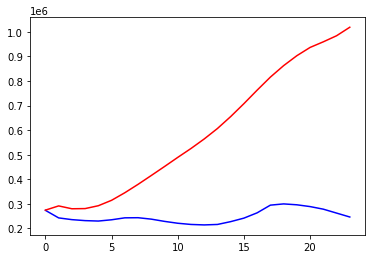

RMSE value:  416978.5091337947


In [69]:
howManyFutureHours = 24
window_size = 3
numEpochs = 20
iters = 5
columnsForDf = ['HLY_TEMP_NORMAL_SD', 'HLY_TEMP_10PCTL_SD',
       'HLY_TEMP_90PCTL_SD', 'HLY_DEWP_NORMAL_SD', 'HLY_DEWP_10PCTL_SD',
       'HLY_DEWP_90PCTL_SD', 'HLY_PRES_NORMAL_SD', 'HLY_PRES_10PCTL_SD',
       'HLY_PRES_90PCTL_SD', 'HLY_CLDH_NORMAL_SD', 'HLY_HTDH_NORMAL_SD',
       'HLY_CLOD_PCTCLR_SD', 'HLY_CLOD_PCTFEW_SD', 'HLY_CLOD_PCTSCT_SD',
       'HLY_CLOD_PCTBKN_SD', 'HLY_CLOD_PCTOVC_SD', 'HLY_HIDX_NORMAL_SD',
       'HLY_WCHL_NORMAL_SD', 'HLY_WIND_AVGSPD_SD', 'HLY_WIND_PCTCLM_SD',
       'HLY_WIND_VCTDIR_SD', 'HLY_WIND_VCTSPD_SD', 'HLY_WIND_1STDIR_SD',
       'HLY_WIND_1STPCT_SD', 'HLY_WIND_2NDDIR_SD', 'HLY_WIND_2NDPCT_SD',
        'Day sin', 'Day cos', 'Year sin', 'Year cos','Megawatts_2019']
columns = ['HLY_TEMP_NORMAL_SD', 'HLY_TEMP_10PCTL_SD',
       'HLY_TEMP_90PCTL_SD', 'HLY_DEWP_NORMAL_SD', 'HLY_DEWP_10PCTL_SD',
       'HLY_DEWP_90PCTL_SD', 'HLY_PRES_NORMAL_SD', 'HLY_PRES_10PCTL_SD',
       'HLY_PRES_90PCTL_SD', 'HLY_CLDH_NORMAL_SD', 'HLY_HTDH_NORMAL_SD',
       'HLY_CLOD_PCTCLR_SD', 'HLY_CLOD_PCTFEW_SD', 'HLY_CLOD_PCTSCT_SD',
       'HLY_CLOD_PCTBKN_SD', 'HLY_CLOD_PCTOVC_SD', 'HLY_HIDX_NORMAL_SD',
       'HLY_WCHL_NORMAL_SD', 'HLY_WIND_AVGSPD_SD', 'HLY_WIND_PCTCLM_SD',
       'HLY_WIND_VCTDIR_SD', 'HLY_WIND_VCTSPD_SD', 'HLY_WIND_1STDIR_SD',
       'HLY_WIND_1STPCT_SD', 'HLY_WIND_2NDDIR_SD', 'HLY_WIND_2NDPCT_SD']

bestPerformingModel(howManyFutureHours, window_size, numEpochs, iters, columnsForDf, columns)

In [29]:
directory = '/Users/yukahatori/A_Fairness/FairnessML_git/NOAA_and_CAISO_Data_ONEYEAR/'
dataFiles = [f for f in listdir(directory) if isfile(join(directory, f))] 
for file in dataFiles:
    print(file)
    df = pd.read_csv(directory + file)

#for now, I will only use SF data 
location = '_SD'
fileRead = directory + dataFiles[1]
print('fileRead: ', fileRead)
df = pd.read_csv(fileRead)

SAC-NOAA-and-Megawatts.csv
SD-NOAA-and-Megawatts.csv
SF-NOAA-and-Megawatts.csv
LA-NOAA-and-Megawatts.csv
fileRead:  /Users/yukahatori/A_Fairness/FairnessML_git/NOAA_and_CAISO_Data_ONEYEAR/SD-NOAA-and-Megawatts.csv


In [32]:
df.columns

Index(['date', 'HLY_TEMP_NORMAL_SD', 'HLY_TEMP_10PCTL_SD',
       'HLY_TEMP_90PCTL_SD', 'HLY_DEWP_NORMAL_SD', 'HLY_DEWP_10PCTL_SD',
       'HLY_DEWP_90PCTL_SD', 'HLY_PRES_NORMAL_SD', 'HLY_PRES_10PCTL_SD',
       'HLY_PRES_90PCTL_SD', 'HLY_CLDH_NORMAL_SD', 'HLY_HTDH_NORMAL_SD',
       'HLY_CLOD_PCTCLR_SD', 'HLY_CLOD_PCTFEW_SD', 'HLY_CLOD_PCTSCT_SD',
       'HLY_CLOD_PCTBKN_SD', 'HLY_CLOD_PCTOVC_SD', 'HLY_HIDX_NORMAL_SD',
       'HLY_WCHL_NORMAL_SD', 'HLY_WIND_AVGSPD_SD', 'HLY_WIND_PCTCLM_SD',
       'HLY_WIND_VCTDIR_SD', 'HLY_WIND_VCTSPD_SD', 'HLY_WIND_1STDIR_SD',
       'HLY_WIND_1STPCT_SD', 'HLY_WIND_2NDDIR_SD', 'HLY_WIND_2NDPCT_SD',
       'Megawatts_2019'],
      dtype='object')

In [ ]:
['date', 'HLY_TEMP_NORMAL_SD', 'HLY_TEMP_10PCTL_SD',
       'HLY_TEMP_90PCTL_SD', 'HLY_DEWP_NORMAL_SD', 'HLY_DEWP_10PCTL_SD',
       'HLY_DEWP_90PCTL_SD', 'HLY_PRES_NORMAL_SD', 'HLY_PRES_10PCTL_SD',
       'HLY_PRES_90PCTL_SD', 'HLY_CLDH_NORMAL_SD', 'HLY_HTDH_NORMAL_SD',
       'HLY_CLOD_PCTCLR_SD', 'HLY_CLOD_PCTFEW_SD', 'HLY_CLOD_PCTSCT_SD',
       'HLY_CLOD_PCTBKN_SD', 'HLY_CLOD_PCTOVC_SD', 'HLY_HIDX_NORMAL_SD',
       'HLY_WCHL_NORMAL_SD', 'HLY_WIND_AVGSPD_SD', 'HLY_WIND_PCTCLM_SD',
       'HLY_WIND_VCTDIR_SD', 'HLY_WIND_VCTSPD_SD', 'HLY_WIND_1STDIR_SD',
       'HLY_WIND_1STPCT_SD', 'HLY_WIND_2NDDIR_SD', 'HLY_WIND_2NDPCT_SD',
       'Megawatts_2019']